In [1]:
import torch
import bitsandbytes as bnb
from torch import nn
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from transformers.trainer_pt_utils import get_parameter_names
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

from utils.load_dataset import get_or_create_dataset, DATASET_NAME


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
binary_path: c:\Users\Felipe O E Santo\Documents\PSG2\FINE_TUNNING\venv\lib\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll
CUDA SETUP: Loading binary c:\Users\Felipe O E Santo\Documents\PSG2\FINE_TUNNING\venv\lib\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll...


c:\Users\Felipe O E Santo\Documents\PSG2\FINE_TUNNING\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "meta-llama/Llama-2-7b-hf"
# Fine-tuned model name
new_model = "llama-2-7b-legislation-blue-amazon"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = False

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 10

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = 1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [3]:
dataset = get_or_create_dataset(DATASET_NAME)
print(dataset[0]['text'])

Documento assinado digitalmente conforme MP nº 2.200-2 de 24/08/2001,
que institui a Infraestrutura de Chaves Públicas Brasileira - ICP-Brasil.
Este documento pode ser verificado no endereço eletrônico
http://www.in.gov.br/autenticidade.html, pelo código 05152022040500037
37
Nº 65, terça-feira, 5 de abril de 2022
ISSN 1677-7042
Seção 1
Processo: 235881.0007753/2020
Interessado: WILSON ALZATE GARCÍA
A COORDENADORA DE PROCESSOS MIGRATÓRIOS, no uso da competência
delegada pela Portaria nº 623 de 13 de novembro de 2020, publicada no Diário Oficial
da União, de 17 de novembro de 2020, indefere o pedido, considerando que o
requerente não apresentou os documentos necessários no momento da formalização do
pedido, foi notificado a complementar e não respondeu às exigências dentro do prazo
previsto, deixando, assim, de anexar todos os documentos exigidos pela Portaria nº 623,
de 13 de novembro de 2020, não cumprindo, portanto, os requisitos do art. 65 da Lei
13.445/2017.
Despacho nº 2932/2022/DI

In [5]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True, 
    # bnb_8bit_compute_dtype=compute_dtype,
    # bnb_8bit_quant_type="nf4",
    # bnb_8bit_use_double_quant=use_nested_quant,
    # load_in_4bit=use_4bit,
    # bnb_4bit_quant_type=bnb_4bit_quant_type,
    # bnb_4bit_compute_dtype=compute_dtype,
    # bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    # optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)


decay_parameters = get_parameter_names(model, [nn.LayerNorm])
decay_parameters = [name for name in decay_parameters if "bias" not in name]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if n in decay_parameters],
        "weight_decay": training_arguments.weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
        "weight_decay": 0.0,
    },
]

optimizer_kwargs = {
    "betas": (training_arguments.adam_beta1, training_arguments.adam_beta2),
    "eps": training_arguments.adam_epsilon,
}
optimizer_kwargs["lr"] = training_arguments.learning_rate
adam_bnb_optim = bnb.optim.Adam8bit(
    optimizer_grouped_parameters,
    betas=(training_arguments.adam_beta1, training_arguments.adam_beta2),
    eps=training_arguments.adam_epsilon,
    lr=training_arguments.learning_rate,
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
    optimizers=(adam_bnb_optim, None)
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:17<00:00,  8.79s/it]
c:\Users\Felipe O E Santo\Documents\PSG2\FINE_TUNNING\venv\lib\site-packages\peft\utils\other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
c:\Users\Felipe O E Santo\Documents\PSG2\FINE_TUNNING\venv\lib\site-packages\trl\trainer\sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


In [6]:
# Train model
trainer.train()

  0%|          | 0/56890 [00:00<?, ?it/s]You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
c:\Users\Felipe O E Santo\Documents\PSG2\FINE_TUNNING\venv\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\Felipe O E Santo\Documents\PSG2\FINE_TUNNING\venv\lib\site-packages\bitsandbytes\autograd\_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8

{'loss': 1.5108, 'learning_rate': 2.9291154071470417e-06, 'epoch': 0.0}


  0%|          | 50/56890 [05:09<58:05:25,  3.68s/it] 

{'loss': 1.7845, 'learning_rate': 5.858230814294083e-06, 'epoch': 0.01}


  0%|          | 75/56890 [08:12<97:20:34,  6.17s/it] 

{'loss': 1.5551, 'learning_rate': 8.787346221441125e-06, 'epoch': 0.01}


  0%|          | 100/56890 [10:02<57:00:47,  3.61s/it]

{'loss': 1.7789, 'learning_rate': 1.1716461628588167e-05, 'epoch': 0.02}


  0%|          | 125/56890 [13:12<108:42:11,  6.89s/it]

{'loss': 1.5367, 'learning_rate': 1.4645577035735208e-05, 'epoch': 0.02}


  0%|          | 150/56890 [15:09<56:37:47,  3.59s/it] 

{'loss': 1.7481, 'learning_rate': 1.757469244288225e-05, 'epoch': 0.03}


  0%|          | 175/56890 [18:17<102:53:03,  6.53s/it]

{'loss': 1.4917, 'learning_rate': 2.050380785002929e-05, 'epoch': 0.03}


  0%|          | 200/56890 [20:12<60:57:43,  3.87s/it] 

{'loss': 1.7938, 'learning_rate': 2.3432923257176333e-05, 'epoch': 0.04}


  0%|          | 225/56890 [23:18<100:05:32,  6.36s/it]

{'loss': 1.5328, 'learning_rate': 2.6362038664323373e-05, 'epoch': 0.04}


  0%|          | 250/56890 [25:12<58:07:21,  3.69s/it] 

{'loss': 1.7768, 'learning_rate': 2.9291154071470417e-05, 'epoch': 0.04}


  0%|          | 275/56890 [28:13<94:30:03,  6.01s/it] 

{'loss': 1.5429, 'learning_rate': 3.222026947861746e-05, 'epoch': 0.05}


  1%|          | 300/56890 [30:05<58:35:41,  3.73s/it]

{'loss': 1.806, 'learning_rate': 3.51493848857645e-05, 'epoch': 0.05}


  1%|          | 325/56890 [33:15<106:50:28,  6.80s/it]

{'loss': 1.548, 'learning_rate': 3.807850029291155e-05, 'epoch': 0.06}


  1%|          | 350/56890 [35:11<58:06:18,  3.70s/it] 

{'loss': 1.761, 'learning_rate': 4.100761570005858e-05, 'epoch': 0.06}


  1%|          | 375/56890 [38:14<96:54:46,  6.17s/it] 

{'loss': 1.5771, 'learning_rate': 4.393673110720563e-05, 'epoch': 0.07}


  1%|          | 400/56890 [40:08<58:55:36,  3.76s/it]

{'loss': 1.8128, 'learning_rate': 4.686584651435267e-05, 'epoch': 0.07}


  1%|          | 425/56890 [43:16<101:27:20,  6.47s/it]

{'loss': 1.526, 'learning_rate': 4.9794961921499713e-05, 'epoch': 0.07}


  1%|          | 450/56890 [45:09<56:18:06,  3.59s/it] 

{'loss': 1.7876, 'learning_rate': 5.2724077328646747e-05, 'epoch': 0.08}


  1%|          | 475/56890 [48:13<99:57:35,  6.38s/it] 

{'loss': 1.53, 'learning_rate': 5.565319273579379e-05, 'epoch': 0.08}


  1%|          | 500/56890 [50:01<51:47:32,  3.31s/it]

{'loss': 1.7653, 'learning_rate': 5.858230814294083e-05, 'epoch': 0.09}


  1%|          | 525/56890 [53:00<97:53:01,  6.25s/it] 

{'loss': 1.5581, 'learning_rate': 6.151142355008788e-05, 'epoch': 0.09}


  1%|          | 550/56890 [54:48<54:26:01,  3.48s/it]

{'loss': 1.7981, 'learning_rate': 6.444053895723492e-05, 'epoch': 0.1}


  1%|          | 575/56890 [57:48<96:42:15,  6.18s/it] 

{'loss': 1.5184, 'learning_rate': 6.736965436438196e-05, 'epoch': 0.1}


  1%|          | 600/56890 [59:38<56:36:39,  3.62s/it]

{'loss': 1.7793, 'learning_rate': 7.0298769771529e-05, 'epoch': 0.11}


  1%|          | 625/56890 [1:02:35<92:18:03,  5.91s/it] 

{'loss': 1.524, 'learning_rate': 7.322788517867605e-05, 'epoch': 0.11}


  1%|          | 650/56890 [1:04:26<57:22:06,  3.67s/it]

{'loss': 1.8039, 'learning_rate': 7.61570005858231e-05, 'epoch': 0.11}


  1%|          | 675/56890 [1:07:23<93:02:12,  5.96s/it] 

{'loss': 1.5491, 'learning_rate': 7.908611599297012e-05, 'epoch': 0.12}


  1%|          | 700/56890 [1:09:09<54:55:21,  3.52s/it]

{'loss': 1.8256, 'learning_rate': 8.201523140011716e-05, 'epoch': 0.12}


  1%|▏         | 725/56890 [1:12:13<105:57:44,  6.79s/it]

{'loss': 1.5251, 'learning_rate': 8.494434680726421e-05, 'epoch': 0.13}


  1%|▏         | 750/56890 [1:14:07<57:51:35,  3.71s/it] 

{'loss': 1.7789, 'learning_rate': 8.787346221441125e-05, 'epoch': 0.13}


  1%|▏         | 775/56890 [1:17:09<99:55:16,  6.41s/it] 

{'loss': 1.52, 'learning_rate': 9.08025776215583e-05, 'epoch': 0.14}


  1%|▏         | 800/56890 [1:19:02<58:15:56,  3.74s/it]

{'loss': 1.8056, 'learning_rate': 9.373169302870533e-05, 'epoch': 0.14}


  1%|▏         | 825/56890 [1:22:05<101:55:54,  6.55s/it]

{'loss': 1.5166, 'learning_rate': 9.666080843585237e-05, 'epoch': 0.15}


  1%|▏         | 850/56890 [1:23:54<53:49:05,  3.46s/it] 

{'loss': 1.7761, 'learning_rate': 9.958992384299943e-05, 'epoch': 0.15}


  2%|▏         | 875/56890 [1:26:55<100:27:18,  6.46s/it]

{'loss': 1.504, 'learning_rate': 0.00010251903925014645, 'epoch': 0.15}


  2%|▏         | 900/56890 [1:28:48<55:15:48,  3.55s/it] 

{'loss': 1.7743, 'learning_rate': 0.00010544815465729349, 'epoch': 0.16}


  2%|▏         | 925/56890 [1:31:50<101:19:56,  6.52s/it]

{'loss': 1.48, 'learning_rate': 0.00010837727006444053, 'epoch': 0.16}


  2%|▏         | 950/56890 [1:33:41<55:34:58,  3.58s/it] 

{'loss': 1.7844, 'learning_rate': 0.00011130638547158759, 'epoch': 0.17}


  2%|▏         | 975/56890 [1:36:44<102:34:06,  6.60s/it]

{'loss': 1.5053, 'learning_rate': 0.00011423550087873463, 'epoch': 0.17}


  2%|▏         | 1000/56890 [1:38:35<56:07:35,  3.62s/it]

{'loss': 1.7843, 'learning_rate': 0.00011716461628588167, 'epoch': 0.18}


  2%|▏         | 1025/56890 [1:41:34<95:02:24,  6.12s/it] 

{'loss': 1.5493, 'learning_rate': 0.0001200937316930287, 'epoch': 0.18}


  2%|▏         | 1050/56890 [1:43:23<55:46:52,  3.60s/it]

{'loss': 1.8181, 'learning_rate': 0.00012302284710017576, 'epoch': 0.18}


  2%|▏         | 1075/56890 [1:46:19<90:52:26,  5.86s/it] 

{'loss': 1.5329, 'learning_rate': 0.0001259519625073228, 'epoch': 0.19}


  2%|▏         | 1100/56890 [1:48:09<57:24:28,  3.70s/it]

{'loss': 1.8097, 'learning_rate': 0.00012888107791446984, 'epoch': 0.19}


  2%|▏         | 1125/56890 [1:51:05<89:28:19,  5.78s/it] 

{'loss': 1.5324, 'learning_rate': 0.00013181019332161688, 'epoch': 0.2}


  2%|▏         | 1150/56890 [1:52:51<51:38:11,  3.33s/it]

{'loss': 1.7984, 'learning_rate': 0.00013473930872876392, 'epoch': 0.2}


  2%|▏         | 1175/56890 [1:55:54<102:23:35,  6.62s/it]

{'loss': 1.5154, 'learning_rate': 0.00013766842413591096, 'epoch': 0.21}


  2%|▏         | 1200/56890 [1:57:45<54:43:19,  3.54s/it] 

{'loss': 1.7833, 'learning_rate': 0.000140597539543058, 'epoch': 0.21}


  2%|▏         | 1225/56890 [2:00:48<99:38:27,  6.44s/it] 

{'loss': 1.5415, 'learning_rate': 0.00014352665495020504, 'epoch': 0.22}


  2%|▏         | 1250/56890 [2:02:36<53:50:35,  3.48s/it]

{'loss': 1.7817, 'learning_rate': 0.0001464557703573521, 'epoch': 0.22}


  2%|▏         | 1275/56890 [2:05:37<99:48:53,  6.46s/it] 

{'loss': 1.527, 'learning_rate': 0.00014938488576449915, 'epoch': 0.22}


  2%|▏         | 1300/56890 [2:07:28<54:38:53,  3.54s/it]

{'loss': 1.7849, 'learning_rate': 0.0001523140011716462, 'epoch': 0.23}


  2%|▏         | 1325/56890 [2:10:31<102:27:51,  6.64s/it]

{'loss': 1.5051, 'learning_rate': 0.0001552431165787932, 'epoch': 0.23}


  2%|▏         | 1350/56890 [2:12:27<57:30:10,  3.73s/it] 

{'loss': 1.7839, 'learning_rate': 0.00015817223198594024, 'epoch': 0.24}


  2%|▏         | 1375/56890 [2:15:28<98:21:47,  6.38s/it] 

{'loss': 1.5149, 'learning_rate': 0.00016110134739308728, 'epoch': 0.24}


  2%|▏         | 1400/56890 [2:17:18<55:23:11,  3.59s/it]

{'loss': 1.7903, 'learning_rate': 0.00016403046280023432, 'epoch': 0.25}


  3%|▎         | 1425/56890 [2:20:20<99:50:33,  6.48s/it] 

{'loss': 1.5069, 'learning_rate': 0.00016695957820738136, 'epoch': 0.25}


  3%|▎         | 1450/56890 [2:22:11<54:54:51,  3.57s/it]

{'loss': 1.7812, 'learning_rate': 0.00016988869361452843, 'epoch': 0.25}


  3%|▎         | 1475/56890 [2:25:09<91:26:19,  5.94s/it] 

{'loss': 1.4853, 'learning_rate': 0.00017281780902167547, 'epoch': 0.26}


  3%|▎         | 1500/56890 [2:26:55<53:49:42,  3.50s/it]

{'loss': 1.801, 'learning_rate': 0.0001757469244288225, 'epoch': 0.26}


  3%|▎         | 1525/56890 [2:29:58<103:05:49,  6.70s/it]

{'loss': 1.5045, 'learning_rate': 0.00017867603983596955, 'epoch': 0.27}


  3%|▎         | 1550/56890 [2:31:49<55:43:58,  3.63s/it] 

{'loss': 1.8064, 'learning_rate': 0.0001816051552431166, 'epoch': 0.27}


  3%|▎         | 1575/56890 [2:34:50<98:08:21,  6.39s/it] 

{'loss': 1.5101, 'learning_rate': 0.00018453427065026363, 'epoch': 0.28}


  3%|▎         | 1600/56890 [2:36:41<52:29:20,  3.42s/it]

{'loss': 1.7608, 'learning_rate': 0.00018746338605741067, 'epoch': 0.28}


  3%|▎         | 1625/56890 [2:39:44<103:04:47,  6.71s/it]

{'loss': 1.5231, 'learning_rate': 0.0001903925014645577, 'epoch': 0.29}


  3%|▎         | 1650/56890 [2:41:37<54:04:17,  3.52s/it] 

{'loss': 1.7609, 'learning_rate': 0.00019332161687170475, 'epoch': 0.29}


  3%|▎         | 1675/56890 [2:44:39<100:02:44,  6.52s/it]

{'loss': 1.5347, 'learning_rate': 0.00019625073227885181, 'epoch': 0.29}


  3%|▎         | 1700/56890 [2:46:26<53:55:35,  3.52s/it] 

{'loss': 1.8086, 'learning_rate': 0.00019917984768599885, 'epoch': 0.3}


  3%|▎         | 1725/56890 [2:49:28<97:21:59,  6.35s/it] 

{'loss': 1.5389, 'learning_rate': 0.00019999994749458352, 'epoch': 0.3}


  3%|▎         | 1750/56890 [2:51:20<55:12:08,  3.60s/it]

{'loss': 1.7779, 'learning_rate': 0.0001999997003627311, 'epoch': 0.31}


  3%|▎         | 1775/56890 [2:54:17<91:51:07,  6.00s/it] 

{'loss': 1.5472, 'learning_rate': 0.00019999925066430886, 'epoch': 0.31}


  3%|▎         | 1800/56890 [2:56:05<53:34:51,  3.50s/it]

{'loss': 1.7705, 'learning_rate': 0.00019999859840022768, 'epoch': 0.32}


  3%|▎         | 1825/56890 [2:58:59<87:32:09,  5.72s/it] 

{'loss': 1.5913, 'learning_rate': 0.00019999774357180882, 'epoch': 0.32}


  3%|▎         | 1850/56890 [3:00:47<53:59:21,  3.53s/it]

{'loss': 1.7937, 'learning_rate': 0.000199996686180784, 'epoch': 0.33}


  3%|▎         | 1875/56890 [3:03:49<98:07:34,  6.42s/it] 

{'loss': 1.5277, 'learning_rate': 0.00019999542622929498, 'epoch': 0.33}


  3%|▎         | 1900/56890 [3:05:38<54:59:55,  3.60s/it]

{'loss': 1.7986, 'learning_rate': 0.00019999396371989415, 'epoch': 0.33}


  3%|▎         | 1925/56890 [3:08:38<93:17:57,  6.11s/it] 

{'loss': 1.5108, 'learning_rate': 0.00019999229865554397, 'epoch': 0.34}


  3%|▎         | 1950/56890 [3:10:25<55:10:43,  3.62s/it]

{'loss': 1.7774, 'learning_rate': 0.0001999904310396174, 'epoch': 0.34}


  3%|▎         | 1975/56890 [3:13:26<97:23:07,  6.38s/it] 

{'loss': 1.5618, 'learning_rate': 0.00019998836087589756, 'epoch': 0.35}


  4%|▎         | 2000/56890 [3:15:17<55:40:22,  3.65s/it]

{'loss': 1.7894, 'learning_rate': 0.00019998608816857797, 'epoch': 0.35}


  4%|▎         | 2025/56890 [3:18:20<101:22:39,  6.65s/it]

{'loss': 1.5269, 'learning_rate': 0.0001999836129222623, 'epoch': 0.36}


  4%|▎         | 2050/56890 [3:20:15<55:39:46,  3.65s/it] 

{'loss': 1.7821, 'learning_rate': 0.00019998093514196467, 'epoch': 0.36}


  4%|▎         | 2075/56890 [3:23:21<108:08:39,  7.10s/it]

{'loss': 1.5323, 'learning_rate': 0.0001999780548331094, 'epoch': 0.36}


  4%|▎         | 2100/56890 [3:25:16<52:27:09,  3.45s/it] 

{'loss': 1.7324, 'learning_rate': 0.00019997497200153095, 'epoch': 0.37}


  4%|▎         | 2125/56890 [3:28:18<98:28:16,  6.47s/it] 

{'loss': 1.5016, 'learning_rate': 0.00019997168665347422, 'epoch': 0.37}


  4%|▍         | 2150/56890 [3:30:10<55:26:29,  3.65s/it]

{'loss': 1.8018, 'learning_rate': 0.00019996819879559418, 'epoch': 0.38}


  4%|▍         | 2175/56890 [3:33:08<90:37:54,  5.96s/it] 

{'loss': 1.5382, 'learning_rate': 0.00019996450843495612, 'epoch': 0.38}


  4%|▍         | 2200/56890 [3:34:53<50:27:17,  3.32s/it]

{'loss': 1.7943, 'learning_rate': 0.00019996061557903553, 'epoch': 0.39}


  4%|▍         | 2225/56890 [3:37:53<93:54:50,  6.18s/it] 

{'loss': 1.5362, 'learning_rate': 0.000199956520235718, 'epoch': 0.39}


  4%|▍         | 2250/56890 [3:39:43<53:33:38,  3.53s/it]

{'loss': 1.7729, 'learning_rate': 0.00019995222241329938, 'epoch': 0.4}


  4%|▍         | 2275/56890 [3:42:35<84:29:25,  5.57s/it] 

{'loss': 1.5632, 'learning_rate': 0.00019994772212048566, 'epoch': 0.4}


  4%|▍         | 2300/56890 [3:44:22<52:26:52,  3.46s/it]

{'loss': 1.7926, 'learning_rate': 0.0001999430193663929, 'epoch': 0.4}


  4%|▍         | 2325/56890 [3:47:19<89:30:27,  5.91s/it] 

{'loss': 1.5529, 'learning_rate': 0.0001999381141605474, 'epoch': 0.41}


  4%|▍         | 2350/56890 [3:49:07<55:26:12,  3.66s/it]

{'loss': 1.7977, 'learning_rate': 0.00019993300651288546, 'epoch': 0.41}


  4%|▍         | 2375/56890 [3:52:08<98:08:35,  6.48s/it] 

{'loss': 1.4897, 'learning_rate': 0.00019992769643375352, 'epoch': 0.42}


  4%|▍         | 2400/56890 [3:53:58<48:29:31,  3.20s/it]

{'loss': 1.7947, 'learning_rate': 0.00019992218393390804, 'epoch': 0.42}


  4%|▍         | 2425/56890 [3:57:03<106:05:02,  7.01s/it]

{'loss': 1.5122, 'learning_rate': 0.00019991646902451556, 'epoch': 0.43}


  4%|▍         | 2450/56890 [3:58:54<51:11:56,  3.39s/it] 

{'loss': 1.8181, 'learning_rate': 0.00019991055171715257, 'epoch': 0.43}


  4%|▍         | 2475/56890 [4:01:57<102:43:10,  6.80s/it]

{'loss': 1.5004, 'learning_rate': 0.00019990443202380563, 'epoch': 0.44}


  4%|▍         | 2500/56890 [4:03:52<54:34:37,  3.61s/it] 

{'loss': 1.7866, 'learning_rate': 0.00019989810995687122, 'epoch': 0.44}


  4%|▍         | 2525/56890 [4:06:54<99:13:25,  6.57s/it] 

{'loss': 1.5421, 'learning_rate': 0.00019989158552915573, 'epoch': 0.44}


  4%|▍         | 2550/56890 [4:08:45<50:25:15,  3.34s/it]

{'loss': 1.7613, 'learning_rate': 0.00019988485875387557, 'epoch': 0.45}


  5%|▍         | 2575/56890 [4:11:46<94:48:06,  6.28s/it] 

{'loss': 1.5432, 'learning_rate': 0.00019987792964465696, 'epoch': 0.45}


  5%|▍         | 2600/56890 [4:13:39<55:47:51,  3.70s/it]

{'loss': 1.7936, 'learning_rate': 0.000199870798215536, 'epoch': 0.46}


  5%|▍         | 2625/56890 [4:16:54<105:09:58,  6.98s/it]

{'loss': 1.5397, 'learning_rate': 0.00019986346448095863, 'epoch': 0.46}


  5%|▍         | 2650/56890 [4:18:53<56:17:15,  3.74s/it] 

{'loss': 1.8032, 'learning_rate': 0.00019985592845578055, 'epoch': 0.47}


  5%|▍         | 2675/56890 [4:22:00<93:02:23,  6.18s/it] 

{'loss': 1.5692, 'learning_rate': 0.00019984819015526735, 'epoch': 0.47}


  5%|▍         | 2700/56890 [4:23:52<53:35:29,  3.56s/it]

{'loss': 1.7644, 'learning_rate': 0.0001998402495950942, 'epoch': 0.47}


  5%|▍         | 2725/56890 [4:27:06<101:42:53,  6.76s/it]

{'loss': 1.5056, 'learning_rate': 0.00019983210679134613, 'epoch': 0.48}


  5%|▍         | 2750/56890 [4:29:01<55:49:06,  3.71s/it] 

{'loss': 1.821, 'learning_rate': 0.00019982376176051774, 'epoch': 0.48}


  5%|▍         | 2775/56890 [4:32:11<95:30:49,  6.35s/it] 

{'loss': 1.5462, 'learning_rate': 0.00019981521451951337, 'epoch': 0.49}


  5%|▍         | 2800/56890 [4:34:08<57:26:28,  3.82s/it]

{'loss': 1.7938, 'learning_rate': 0.0001998064650856469, 'epoch': 0.49}


  5%|▍         | 2825/56890 [4:37:22<100:14:30,  6.67s/it]

{'loss': 1.5262, 'learning_rate': 0.00019979751347664183, 'epoch': 0.5}


  5%|▌         | 2850/56890 [4:39:18<58:23:53,  3.89s/it] 

{'loss': 1.7859, 'learning_rate': 0.00019978835971063113, 'epoch': 0.5}


  5%|▌         | 2875/56890 [4:42:31<100:23:54,  6.69s/it]

{'loss': 1.4897, 'learning_rate': 0.00019977900380615743, 'epoch': 0.51}


  5%|▌         | 2900/56890 [4:44:28<54:37:29,  3.64s/it] 

{'loss': 1.7807, 'learning_rate': 0.0001997694457821726, 'epoch': 0.51}


  5%|▌         | 2925/56890 [4:47:42<105:03:14,  7.01s/it]

{'loss': 1.5735, 'learning_rate': 0.00019975968565803814, 'epoch': 0.51}


  5%|▌         | 2950/56890 [4:49:39<53:23:29,  3.56s/it] 

{'loss': 1.7669, 'learning_rate': 0.00019974972345352483, 'epoch': 0.52}


  5%|▌         | 2975/56890 [4:52:55<106:38:38,  7.12s/it]

{'loss': 1.4818, 'learning_rate': 0.0001997395591888128, 'epoch': 0.52}


  5%|▌         | 3000/56890 [4:54:55<54:48:05,  3.66s/it] 

{'loss': 1.7713, 'learning_rate': 0.00019972919288449158, 'epoch': 0.53}


  5%|▌         | 3025/56890 [4:58:06<94:51:44,  6.34s/it] 

{'loss': 1.5442, 'learning_rate': 0.00019971862456155982, 'epoch': 0.53}


  5%|▌         | 3050/56890 [4:59:59<54:51:15,  3.67s/it]

{'loss': 1.7931, 'learning_rate': 0.00019970785424142554, 'epoch': 0.54}


  5%|▌         | 3075/56890 [5:03:13<98:23:06,  6.58s/it] 

{'loss': 1.5247, 'learning_rate': 0.00019969688194590587, 'epoch': 0.54}


  5%|▌         | 3100/56890 [5:05:10<57:59:18,  3.88s/it]

{'loss': 1.7723, 'learning_rate': 0.00019968570769722706, 'epoch': 0.54}


  5%|▌         | 3125/56890 [5:08:22<96:59:59,  6.49s/it] 

{'loss': 1.5305, 'learning_rate': 0.00019967433151802443, 'epoch': 0.55}


  6%|▌         | 3150/56890 [5:10:11<51:03:57,  3.42s/it]

{'loss': 1.7805, 'learning_rate': 0.00019966275343134243, 'epoch': 0.55}


  6%|▌         | 3175/56890 [5:13:10<91:07:16,  6.11s/it] 

{'loss': 1.5291, 'learning_rate': 0.00019965097346063448, 'epoch': 0.56}


  6%|▌         | 3200/56890 [5:15:01<52:53:42,  3.55s/it]

{'loss': 1.7732, 'learning_rate': 0.00019963899162976292, 'epoch': 0.56}


  6%|▌         | 3225/56890 [5:18:05<97:35:25,  6.55s/it] 

{'loss': 1.5609, 'learning_rate': 0.00019962680796299897, 'epoch': 0.57}


  6%|▌         | 3250/56890 [5:19:56<52:17:41,  3.51s/it]

{'loss': 1.7882, 'learning_rate': 0.00019961442248502277, 'epoch': 0.57}


  6%|▌         | 3275/56890 [5:23:00<99:52:09,  6.71s/it] 

{'loss': 1.5535, 'learning_rate': 0.00019960183522092323, 'epoch': 0.58}


  6%|▌         | 3300/56890 [5:24:55<54:02:54,  3.63s/it]

{'loss': 1.7916, 'learning_rate': 0.00019958904619619806, 'epoch': 0.58}


  6%|▌         | 3325/56890 [5:27:52<86:59:01,  5.85s/it] 

{'loss': 1.6024, 'learning_rate': 0.00019957605543675352, 'epoch': 0.58}


  6%|▌         | 3350/56890 [5:29:41<52:44:07,  3.55s/it]

{'loss': 1.7864, 'learning_rate': 0.00019956286296890472, 'epoch': 0.59}


  6%|▌         | 3375/56890 [5:32:44<95:54:44,  6.45s/it] 

{'loss': 1.5379, 'learning_rate': 0.00019954946881937523, 'epoch': 0.59}


  6%|▌         | 3400/56890 [5:34:34<51:08:02,  3.44s/it]

{'loss': 1.7786, 'learning_rate': 0.0001995358730152972, 'epoch': 0.6}


  6%|▌         | 3425/56890 [5:37:35<89:31:35,  6.03s/it] 

{'loss': 1.563, 'learning_rate': 0.0001995220755842113, 'epoch': 0.6}


  6%|▌         | 3450/56890 [5:39:21<50:53:56,  3.43s/it]

{'loss': 1.7924, 'learning_rate': 0.00019950807655406654, 'epoch': 0.61}


  6%|▌         | 3475/56890 [5:42:23<93:08:01,  6.28s/it] 

{'loss': 1.5277, 'learning_rate': 0.0001994938759532204, 'epoch': 0.61}


  6%|▌         | 3500/56890 [5:44:12<52:23:25,  3.53s/it]

{'loss': 1.7911, 'learning_rate': 0.00019947947381043863, 'epoch': 0.62}


  6%|▌         | 3525/56890 [5:47:19<101:01:30,  6.82s/it]

{'loss': 1.4949, 'learning_rate': 0.00019946487015489527, 'epoch': 0.62}


  6%|▌         | 3550/56890 [5:49:13<53:35:57,  3.62s/it] 

{'loss': 1.7637, 'learning_rate': 0.00019945006501617246, 'epoch': 0.62}


  6%|▋         | 3575/56890 [5:52:12<86:41:39,  5.85s/it] 

{'loss': 1.5538, 'learning_rate': 0.0001994350584242606, 'epoch': 0.63}


  6%|▋         | 3600/56890 [5:53:59<50:34:05,  3.42s/it]

{'loss': 1.7957, 'learning_rate': 0.00019941985040955812, 'epoch': 0.63}


  6%|▋         | 3625/56890 [5:56:59<89:27:47,  6.05s/it] 

{'loss': 1.5443, 'learning_rate': 0.00019940444100287149, 'epoch': 0.64}


  6%|▋         | 3650/56890 [5:58:50<53:48:04,  3.64s/it]

{'loss': 1.7751, 'learning_rate': 0.00019938883023541503, 'epoch': 0.64}


  6%|▋         | 3675/56890 [6:01:56<101:15:34,  6.85s/it]

{'loss': 1.5034, 'learning_rate': 0.0001993730181388111, 'epoch': 0.65}


  7%|▋         | 3700/56890 [6:03:49<53:13:53,  3.60s/it] 

{'loss': 1.7649, 'learning_rate': 0.00019935700474508981, 'epoch': 0.65}


  7%|▋         | 3725/56890 [6:06:55<99:37:48,  6.75s/it] 

{'loss': 1.5426, 'learning_rate': 0.00019934079008668905, 'epoch': 0.65}


  7%|▋         | 3750/56890 [6:08:51<53:56:01,  3.65s/it]

{'loss': 1.7771, 'learning_rate': 0.00019932437419645433, 'epoch': 0.66}


  7%|▋         | 3775/56890 [6:11:55<96:11:19,  6.52s/it] 

{'loss': 1.4986, 'learning_rate': 0.00019930775710763895, 'epoch': 0.66}


  7%|▋         | 3800/56890 [6:13:49<52:37:05,  3.57s/it]

{'loss': 1.7728, 'learning_rate': 0.00019929093885390358, 'epoch': 0.67}


  7%|▋         | 3825/56890 [6:16:53<97:05:46,  6.59s/it] 

{'loss': 1.5427, 'learning_rate': 0.00019927391946931655, 'epoch': 0.67}


  7%|▋         | 3850/56890 [6:18:47<51:53:06,  3.52s/it]

{'loss': 1.7626, 'learning_rate': 0.00019925669898835353, 'epoch': 0.68}


  7%|▋         | 3875/56890 [6:21:44<85:15:54,  5.79s/it] 

{'loss': 1.5641, 'learning_rate': 0.00019923927744589754, 'epoch': 0.68}


  7%|▋         | 3900/56890 [6:23:31<51:53:56,  3.53s/it]

{'loss': 1.7994, 'learning_rate': 0.00019922165487723897, 'epoch': 0.69}


  7%|▋         | 3925/56890 [6:26:33<91:05:52,  6.19s/it] 

{'loss': 1.5261, 'learning_rate': 0.00019920383131807526, 'epoch': 0.69}


  7%|▋         | 3950/56890 [6:28:23<53:13:23,  3.62s/it]

{'loss': 1.7879, 'learning_rate': 0.0001991858068045112, 'epoch': 0.69}


  7%|▋         | 3975/56890 [6:31:19<83:45:24,  5.70s/it] 

{'loss': 1.5437, 'learning_rate': 0.00019916758137305843, 'epoch': 0.7}


  7%|▋         | 4000/56890 [6:33:06<50:24:10,  3.43s/it]

{'loss': 1.7924, 'learning_rate': 0.00019914915506063577, 'epoch': 0.7}


  7%|▋         | 4025/56890 [6:36:08<91:27:51,  6.23s/it] 

{'loss': 1.5196, 'learning_rate': 0.00019913052790456888, 'epoch': 0.71}


  7%|▋         | 4050/56890 [6:37:59<53:26:48,  3.64s/it]

{'loss': 1.8165, 'learning_rate': 0.00019911169994259021, 'epoch': 0.71}


  7%|▋         | 4075/56890 [6:41:06<100:42:08,  6.86s/it]

{'loss': 1.5235, 'learning_rate': 0.00019909267121283908, 'epoch': 0.72}


  7%|▋         | 4100/56890 [6:43:01<53:56:00,  3.68s/it] 

{'loss': 1.8188, 'learning_rate': 0.00019907344175386143, 'epoch': 0.72}


  7%|▋         | 4125/56890 [6:45:59<87:22:46,  5.96s/it] 

{'loss': 1.545, 'learning_rate': 0.00019905401160460982, 'epoch': 0.73}


  7%|▋         | 4150/56890 [6:47:49<52:34:48,  3.59s/it]

{'loss': 1.792, 'learning_rate': 0.00019903438080444338, 'epoch': 0.73}


  7%|▋         | 4175/56890 [6:50:52<91:58:25,  6.28s/it] 

{'loss': 1.5375, 'learning_rate': 0.00019901454939312766, 'epoch': 0.73}


  7%|▋         | 4200/56890 [6:52:41<51:38:47,  3.53s/it]

{'loss': 1.7834, 'learning_rate': 0.00019899451741083458, 'epoch': 0.74}


  7%|▋         | 4225/56890 [6:55:45<94:57:35,  6.49s/it] 

{'loss': 1.5034, 'learning_rate': 0.00019897428489814236, 'epoch': 0.74}


  7%|▋         | 4250/56890 [6:57:33<51:00:08,  3.49s/it]

{'loss': 1.7747, 'learning_rate': 0.00019895385189603546, 'epoch': 0.75}


  8%|▊         | 4275/56890 [7:00:39<100:28:22,  6.87s/it]

{'loss': 1.5026, 'learning_rate': 0.0001989332184459044, 'epoch': 0.75}


  8%|▊         | 4300/56890 [7:02:31<51:49:15,  3.55s/it] 

{'loss': 1.7983, 'learning_rate': 0.0001989123845895458, 'epoch': 0.76}


  8%|▊         | 4325/56890 [7:05:30<87:08:52,  5.97s/it] 

{'loss': 1.5207, 'learning_rate': 0.0001988913503691622, 'epoch': 0.76}


  8%|▊         | 4350/56890 [7:07:18<46:46:31,  3.21s/it]

{'loss': 1.7957, 'learning_rate': 0.00019887011582736202, 'epoch': 0.76}


  8%|▊         | 4375/56890 [7:10:24<98:30:35,  6.75s/it] 

{'loss': 1.4806, 'learning_rate': 0.00019884868100715952, 'epoch': 0.77}


  8%|▊         | 4400/56890 [7:12:18<50:51:31,  3.49s/it]

{'loss': 1.7562, 'learning_rate': 0.00019882704595197454, 'epoch': 0.77}


  8%|▊         | 4425/56890 [7:15:19<92:16:21,  6.33s/it] 

{'loss': 1.5664, 'learning_rate': 0.00019880521070563266, 'epoch': 0.78}


  8%|▊         | 4450/56890 [7:17:10<53:02:13,  3.64s/it]

{'loss': 1.7951, 'learning_rate': 0.00019878317531236487, 'epoch': 0.78}


  8%|▊         | 4475/56890 [7:20:09<87:20:57,  6.00s/it] 

{'loss': 1.5225, 'learning_rate': 0.00019876093981680768, 'epoch': 0.79}


  8%|▊         | 4500/56890 [7:21:56<49:56:35,  3.43s/it]

{'loss': 1.7804, 'learning_rate': 0.0001987385042640029, 'epoch': 0.79}


  8%|▊         | 4525/56890 [7:24:58<90:51:57,  6.25s/it] 

{'loss': 1.5512, 'learning_rate': 0.0001987158686993976, 'epoch': 0.8}


  8%|▊         | 4550/56890 [7:26:47<51:01:53,  3.51s/it]

{'loss': 1.7735, 'learning_rate': 0.000198693033168844, 'epoch': 0.8}


  8%|▊         | 4575/56890 [7:29:54<99:28:22,  6.85s/it] 

{'loss': 1.4861, 'learning_rate': 0.00019866999771859937, 'epoch': 0.8}


  8%|▊         | 4600/56890 [7:31:47<51:09:02,  3.52s/it]

{'loss': 1.7865, 'learning_rate': 0.00019864676239532598, 'epoch': 0.81}


  8%|▊         | 4625/56890 [7:34:53<97:41:38,  6.73s/it] 

{'loss': 1.5042, 'learning_rate': 0.000198623327246091, 'epoch': 0.81}


  8%|▊         | 4650/56890 [7:36:49<51:07:51,  3.52s/it]

{'loss': 1.7446, 'learning_rate': 0.0001985996923183663, 'epoch': 0.82}


  8%|▊         | 4675/56890 [7:39:51<90:25:38,  6.23s/it] 

{'loss': 1.5495, 'learning_rate': 0.00019857585766002854, 'epoch': 0.82}


  8%|▊         | 4700/56890 [7:41:39<51:45:10,  3.57s/it]

{'loss': 1.783, 'learning_rate': 0.00019855182331935883, 'epoch': 0.83}


  8%|▊         | 4725/56890 [7:44:44<96:30:05,  6.66s/it] 

{'loss': 1.5058, 'learning_rate': 0.00019852758934504297, 'epoch': 0.83}


  8%|▊         | 4750/56890 [7:46:40<54:47:17,  3.78s/it]

{'loss': 1.7892, 'learning_rate': 0.00019850315578617096, 'epoch': 0.83}


  8%|▊         | 4775/56890 [7:49:43<91:40:51,  6.33s/it] 

{'loss': 1.5009, 'learning_rate': 0.0001984785226922372, 'epoch': 0.84}


  8%|▊         | 4800/56890 [7:51:33<51:50:29,  3.58s/it]

{'loss': 1.7733, 'learning_rate': 0.00019845369011314024, 'epoch': 0.84}


  8%|▊         | 4825/56890 [7:54:37<94:42:50,  6.55s/it] 

{'loss': 1.5161, 'learning_rate': 0.0001984286580991827, 'epoch': 0.85}


  9%|▊         | 4850/56890 [7:56:34<53:42:50,  3.72s/it]

{'loss': 1.7649, 'learning_rate': 0.0001984034267010713, 'epoch': 0.85}


  9%|▊         | 4875/56890 [7:59:42<103:04:02,  7.13s/it]

{'loss': 1.5136, 'learning_rate': 0.00019837799596991653, 'epoch': 0.86}


  9%|▊         | 4900/56890 [8:01:40<52:38:04,  3.64s/it] 

{'loss': 1.7725, 'learning_rate': 0.0001983523659572327, 'epoch': 0.86}


  9%|▊         | 4925/56890 [8:04:41<88:53:18,  6.16s/it] 

{'loss': 1.569, 'learning_rate': 0.00019832653671493782, 'epoch': 0.87}


  9%|▊         | 4950/56890 [8:06:28<50:32:16,  3.50s/it]

{'loss': 1.7913, 'learning_rate': 0.00019830050829535342, 'epoch': 0.87}


  9%|▊         | 4975/56890 [8:09:35<99:46:12,  6.92s/it] 

{'loss': 1.478, 'learning_rate': 0.00019827428075120458, 'epoch': 0.87}


  9%|▉         | 5000/56890 [8:11:35<52:55:43,  3.67s/it]

{'loss': 1.7583, 'learning_rate': 0.00019824785413561968, 'epoch': 0.88}


  9%|▉         | 5025/56890 [8:14:42<99:42:32,  6.92s/it] 

{'loss': 1.5196, 'learning_rate': 0.00019822122850213036, 'epoch': 0.88}


  9%|▉         | 5050/56890 [8:16:39<51:01:46,  3.54s/it]

{'loss': 1.7709, 'learning_rate': 0.0001981944039046714, 'epoch': 0.89}


  9%|▉         | 5075/56890 [8:19:42<92:41:25,  6.44s/it] 

{'loss': 1.5397, 'learning_rate': 0.00019816738039758066, 'epoch': 0.89}


  9%|▉         | 5100/56890 [8:21:32<51:15:28,  3.56s/it]

{'loss': 1.7452, 'learning_rate': 0.0001981401580355989, 'epoch': 0.9}


  9%|▉         | 5125/56890 [8:24:40<101:53:26,  7.09s/it]

{'loss': 1.5045, 'learning_rate': 0.0001981127368738697, 'epoch': 0.9}


  9%|▉         | 5150/56890 [8:26:36<52:34:52,  3.66s/it] 

{'loss': 1.8239, 'learning_rate': 0.00019808511696793924, 'epoch': 0.91}


  9%|▉         | 5175/56890 [8:29:37<89:27:27,  6.23s/it] 

{'loss': 1.5436, 'learning_rate': 0.0001980572983737565, 'epoch': 0.91}


  9%|▉         | 5200/56890 [8:31:29<52:34:54,  3.66s/it]

{'loss': 1.7783, 'learning_rate': 0.00019802928114767275, 'epoch': 0.91}


  9%|▉         | 5225/56890 [8:34:34<94:06:11,  6.56s/it] 

{'loss': 1.5223, 'learning_rate': 0.00019800106534644172, 'epoch': 0.92}


  9%|▉         | 5250/56890 [8:36:26<51:53:23,  3.62s/it]

{'loss': 1.7853, 'learning_rate': 0.00019797265102721937, 'epoch': 0.92}


  9%|▉         | 5275/56890 [8:39:24<84:33:06,  5.90s/it] 

{'loss': 1.5484, 'learning_rate': 0.00019794403824756375, 'epoch': 0.93}


  9%|▉         | 5300/56890 [8:41:12<50:44:53,  3.54s/it]

{'loss': 1.7986, 'learning_rate': 0.000197915227065435, 'epoch': 0.93}


  9%|▉         | 5325/56890 [8:44:16<92:46:15,  6.48s/it] 

{'loss': 1.5057, 'learning_rate': 0.0001978862175391951, 'epoch': 0.94}


  9%|▉         | 5350/56890 [8:46:07<51:25:20,  3.59s/it]

{'loss': 1.7644, 'learning_rate': 0.00019785700972760784, 'epoch': 0.94}


  9%|▉         | 5375/56890 [8:49:12<94:00:43,  6.57s/it] 

{'loss': 1.493, 'learning_rate': 0.00019782760368983863, 'epoch': 0.94}


  9%|▉         | 5400/56890 [8:51:04<52:27:40,  3.67s/it]

{'loss': 1.8069, 'learning_rate': 0.00019779799948545446, 'epoch': 0.95}


 10%|▉         | 5425/56890 [8:54:07<91:58:42,  6.43s/it] 

{'loss': 1.5185, 'learning_rate': 0.00019776819717442376, 'epoch': 0.95}


 10%|▉         | 5450/56890 [8:55:58<49:34:56,  3.47s/it]

{'loss': 1.7854, 'learning_rate': 0.00019773819681711622, 'epoch': 0.96}


 10%|▉         | 5475/56890 [8:58:58<86:03:05,  6.03s/it] 

{'loss': 1.5728, 'learning_rate': 0.00019770799847430268, 'epoch': 0.96}


 10%|▉         | 5500/56890 [9:00:47<52:38:40,  3.69s/it]

{'loss': 1.8001, 'learning_rate': 0.0001976776022071551, 'epoch': 0.97}


 10%|▉         | 5525/56890 [9:03:47<87:01:26,  6.10s/it] 

{'loss': 1.5875, 'learning_rate': 0.00019764700807724635, 'epoch': 0.97}


 10%|▉         | 5550/56890 [9:05:37<50:43:59,  3.56s/it]

{'loss': 1.7924, 'learning_rate': 0.00019761621614655008, 'epoch': 0.98}


 10%|▉         | 5575/56890 [9:08:46<103:07:30,  7.23s/it]

{'loss': 1.4822, 'learning_rate': 0.00019758522647744066, 'epoch': 0.98}


 10%|▉         | 5600/56890 [9:10:40<51:18:17,  3.60s/it] 

{'loss': 1.7828, 'learning_rate': 0.00019755403913269292, 'epoch': 0.98}


 10%|▉         | 5625/56890 [9:13:43<90:06:52,  6.33s/it] 

{'loss': 1.5535, 'learning_rate': 0.00019752265417548225, 'epoch': 0.99}


 10%|▉         | 5650/56890 [9:15:33<51:45:16,  3.64s/it]

{'loss': 1.7971, 'learning_rate': 0.00019749107166938426, 'epoch': 0.99}


 10%|▉         | 5675/56890 [9:18:12<66:11:47,  4.65s/it] 

{'loss': 1.6493, 'learning_rate': 0.0001974592916783747, 'epoch': 1.0}


 10%|█         | 5700/56890 [9:20:28<106:48:42,  7.51s/it]

{'loss': 1.6599, 'learning_rate': 0.00019742731426682948, 'epoch': 1.0}


 10%|█         | 5725/56890 [9:23:13<72:02:13,  5.07s/it] 

{'loss': 1.6195, 'learning_rate': 0.0001973951394995243, 'epoch': 1.01}


 10%|█         | 5750/56890 [9:25:32<107:00:43,  7.53s/it]

{'loss': 1.6407, 'learning_rate': 0.0001973627674416346, 'epoch': 1.01}


 10%|█         | 5775/56890 [9:28:08<67:09:02,  4.73s/it] 

{'loss': 1.6387, 'learning_rate': 0.00019733019815873566, 'epoch': 1.02}


 10%|█         | 5800/56890 [9:30:27<106:31:46,  7.51s/it]

{'loss': 1.6641, 'learning_rate': 0.0001972974317168021, 'epoch': 1.02}


 10%|█         | 5825/56890 [9:33:01<67:08:04,  4.73s/it] 

{'loss': 1.6731, 'learning_rate': 0.000197264468182208, 'epoch': 1.02}


 10%|█         | 5850/56890 [9:35:21<106:31:02,  7.51s/it]

{'loss': 1.6677, 'learning_rate': 0.00019723130762172664, 'epoch': 1.03}


 10%|█         | 5875/56890 [9:37:46<64:24:59,  4.55s/it] 

{'loss': 1.6887, 'learning_rate': 0.00019719795010253045, 'epoch': 1.03}


 10%|█         | 5900/56890 [9:40:05<106:25:06,  7.51s/it]

{'loss': 1.666, 'learning_rate': 0.0001971643956921908, 'epoch': 1.04}


 10%|█         | 5925/56890 [9:42:34<65:10:21,  4.60s/it] 

{'loss': 1.6615, 'learning_rate': 0.00019713064445867792, 'epoch': 1.04}


 10%|█         | 5950/56890 [9:44:53<106:22:14,  7.52s/it]

{'loss': 1.6396, 'learning_rate': 0.0001970966964703607, 'epoch': 1.05}


 11%|█         | 5975/56890 [9:47:24<65:10:03,  4.61s/it] 

{'loss': 1.702, 'learning_rate': 0.00019706255179600666, 'epoch': 1.05}


 11%|█         | 6000/56890 [9:49:42<106:22:16,  7.52s/it]

{'loss': 1.6739, 'learning_rate': 0.0001970282105047817, 'epoch': 1.05}


 11%|█         | 6025/56890 [9:52:19<67:07:10,  4.75s/it] 

{'loss': 1.6464, 'learning_rate': 0.00019699367266625003, 'epoch': 1.06}


 11%|█         | 6050/56890 [9:54:39<106:30:03,  7.54s/it]

{'loss': 1.6475, 'learning_rate': 0.00019695893835037386, 'epoch': 1.06}


 11%|█         | 6075/56890 [9:57:18<68:37:41,  4.86s/it] 

{'loss': 1.6206, 'learning_rate': 0.00019692400762751365, 'epoch': 1.07}


 11%|█         | 6100/56890 [9:59:39<106:33:42,  7.55s/it]

{'loss': 1.6905, 'learning_rate': 0.00019688888056842752, 'epoch': 1.07}


 11%|█         | 6125/56890 [10:02:10<65:37:42,  4.65s/it] 

{'loss': 1.6845, 'learning_rate': 0.00019685355724427135, 'epoch': 1.08}


 11%|█         | 6150/56890 [10:04:28<106:14:37,  7.54s/it]

{'loss': 1.6025, 'learning_rate': 0.00019681803772659864, 'epoch': 1.08}


 11%|█         | 6175/56890 [10:07:15<73:18:08,  5.20s/it] 

{'loss': 1.6089, 'learning_rate': 0.00019678232208736023, 'epoch': 1.09}


 11%|█         | 6200/56890 [10:09:39<106:09:30,  7.54s/it]

{'loss': 1.6454, 'learning_rate': 0.0001967464103989043, 'epoch': 1.09}


 11%|█         | 6225/56890 [10:12:12<65:34:03,  4.66s/it] 

{'loss': 1.6625, 'learning_rate': 0.00019671030273397613, 'epoch': 1.09}


 11%|█         | 6250/56890 [10:14:31<105:57:38,  7.53s/it]

{'loss': 1.6394, 'learning_rate': 0.00019667399916571804, 'epoch': 1.1}


 11%|█         | 6275/56890 [10:16:58<62:57:06,  4.48s/it] 

{'loss': 1.7056, 'learning_rate': 0.00019663749976766908, 'epoch': 1.1}


 11%|█         | 6300/56890 [10:19:15<105:49:07,  7.53s/it]

{'loss': 1.6794, 'learning_rate': 0.0001966008046137651, 'epoch': 1.11}


 11%|█         | 6325/56890 [10:21:48<65:47:58,  4.68s/it] 

{'loss': 1.6475, 'learning_rate': 0.00019656391377833845, 'epoch': 1.11}


 11%|█         | 6350/56890 [10:24:08<106:07:25,  7.56s/it]

{'loss': 1.6392, 'learning_rate': 0.0001965268273361178, 'epoch': 1.12}


 11%|█         | 6375/56890 [10:26:50<70:08:11,  5.00s/it] 

{'loss': 1.627, 'learning_rate': 0.00019648954536222814, 'epoch': 1.12}


 11%|█         | 6400/56890 [10:29:13<106:04:42,  7.56s/it]

{'loss': 1.68, 'learning_rate': 0.00019645206793219054, 'epoch': 1.12}


 11%|█▏        | 6425/56890 [10:31:49<68:25:43,  4.88s/it] 

{'loss': 1.6723, 'learning_rate': 0.0001964143951219219, 'epoch': 1.13}


 11%|█▏        | 6450/56890 [10:34:10<105:30:41,  7.53s/it]

{'loss': 1.6466, 'learning_rate': 0.00019637652700773498, 'epoch': 1.13}


 11%|█▏        | 6475/56890 [10:36:43<65:12:09,  4.66s/it] 

{'loss': 1.6487, 'learning_rate': 0.00019633846366633824, 'epoch': 1.14}


 11%|█▏        | 6500/56890 [10:39:02<105:35:13,  7.54s/it]

{'loss': 1.6749, 'learning_rate': 0.00019630020517483543, 'epoch': 1.14}


 11%|█▏        | 6525/56890 [10:41:42<67:41:41,  4.84s/it] 

{'loss': 1.6149, 'learning_rate': 0.00019626175161072574, 'epoch': 1.15}


 12%|█▏        | 6550/56890 [10:44:02<105:22:09,  7.54s/it]

{'loss': 1.6781, 'learning_rate': 0.00019622310305190342, 'epoch': 1.15}


 12%|█▏        | 6575/56890 [10:46:35<65:39:56,  4.70s/it] 

{'loss': 1.6682, 'learning_rate': 0.0001961842595766578, 'epoch': 1.16}


 12%|█▏        | 6600/56890 [10:48:53<105:23:44,  7.54s/it]

{'loss': 1.6691, 'learning_rate': 0.00019614522126367302, 'epoch': 1.16}


 12%|█▏        | 6625/56890 [10:51:30<66:07:04,  4.74s/it] 

{'loss': 1.6739, 'learning_rate': 0.00019610598819202785, 'epoch': 1.16}


 12%|█▏        | 6650/56890 [10:53:50<105:06:33,  7.53s/it]

{'loss': 1.6696, 'learning_rate': 0.00019606656044119562, 'epoch': 1.17}


 12%|█▏        | 6675/56890 [10:56:23<66:27:36,  4.76s/it] 

{'loss': 1.6869, 'learning_rate': 0.00019602693809104408, 'epoch': 1.17}


 12%|█▏        | 6700/56890 [10:58:43<104:52:53,  7.52s/it]

{'loss': 1.6519, 'learning_rate': 0.000195987121221835, 'epoch': 1.18}


 12%|█▏        | 6725/56890 [11:01:17<64:55:11,  4.66s/it] 

{'loss': 1.6567, 'learning_rate': 0.0001959471099142244, 'epoch': 1.18}


 12%|█▏        | 6750/56890 [11:03:36<104:40:25,  7.52s/it]

{'loss': 1.6534, 'learning_rate': 0.00019590690424926198, 'epoch': 1.19}


 12%|█▏        | 6775/56890 [11:06:12<68:13:44,  4.90s/it] 

{'loss': 1.6349, 'learning_rate': 0.00019586650430839124, 'epoch': 1.19}


 12%|█▏        | 6800/56890 [11:08:34<104:44:28,  7.53s/it]

{'loss': 1.6885, 'learning_rate': 0.0001958259101734492, 'epoch': 1.2}


 12%|█▏        | 6825/56890 [11:11:07<64:18:15,  4.62s/it] 

{'loss': 1.6577, 'learning_rate': 0.00019578512192666624, 'epoch': 1.2}


 12%|█▏        | 6850/56890 [11:13:25<104:28:12,  7.52s/it]

{'loss': 1.6704, 'learning_rate': 0.000195744139650666, 'epoch': 1.2}


 12%|█▏        | 6875/56890 [11:16:06<72:41:35,  5.23s/it] 

{'loss': 1.6357, 'learning_rate': 0.0001957029634284651, 'epoch': 1.21}


 12%|█▏        | 6900/56890 [11:18:29<104:24:13,  7.52s/it]

{'loss': 1.6943, 'learning_rate': 0.00019566159334347304, 'epoch': 1.21}


 12%|█▏        | 6925/56890 [11:20:57<62:48:51,  4.53s/it] 

{'loss': 1.6591, 'learning_rate': 0.000195620029479492, 'epoch': 1.22}


 12%|█▏        | 6950/56890 [11:23:16<104:24:34,  7.53s/it]

{'loss': 1.6439, 'learning_rate': 0.00019557827192071678, 'epoch': 1.22}


 12%|█▏        | 6975/56890 [11:25:50<64:45:38,  4.67s/it] 

{'loss': 1.652, 'learning_rate': 0.0001955363207517345, 'epoch': 1.23}


 12%|█▏        | 7000/56890 [11:28:06<104:06:40,  7.51s/it]

{'loss': 1.6329, 'learning_rate': 0.0001954941760575244, 'epoch': 1.23}


 12%|█▏        | 7025/56890 [11:30:47<66:27:16,  4.80s/it] 

{'loss': 1.6128, 'learning_rate': 0.00019545183792345783, 'epoch': 1.23}


 12%|█▏        | 7050/56890 [11:33:06<104:09:26,  7.52s/it]

{'loss': 1.6625, 'learning_rate': 0.00019540930643529797, 'epoch': 1.24}


 12%|█▏        | 7075/56890 [11:35:39<64:03:29,  4.63s/it] 

{'loss': 1.7382, 'learning_rate': 0.0001953665816791996, 'epoch': 1.24}


 12%|█▏        | 7100/56890 [11:37:59<103:59:57,  7.52s/it]

{'loss': 1.662, 'learning_rate': 0.00019532366374170912, 'epoch': 1.25}


 13%|█▎        | 7125/56890 [11:40:37<67:09:49,  4.86s/it] 

{'loss': 1.607, 'learning_rate': 0.00019528055270976412, 'epoch': 1.25}


 13%|█▎        | 7150/56890 [11:42:59<103:59:30,  7.53s/it]

{'loss': 1.6933, 'learning_rate': 0.00019523724867069348, 'epoch': 1.26}


 13%|█▎        | 7175/56890 [11:45:33<65:07:03,  4.72s/it] 

{'loss': 1.6693, 'learning_rate': 0.0001951937517122169, 'epoch': 1.26}


 13%|█▎        | 7200/56890 [11:47:52<103:53:34,  7.53s/it]

{'loss': 1.6597, 'learning_rate': 0.00019515006192244493, 'epoch': 1.27}


 13%|█▎        | 7225/56890 [11:50:14<61:48:25,  4.48s/it] 

{'loss': 1.7235, 'learning_rate': 0.0001951061793898788, 'epoch': 1.27}


 13%|█▎        | 7250/56890 [11:52:32<103:39:24,  7.52s/it]

{'loss': 1.654, 'learning_rate': 0.0001950621042034101, 'epoch': 1.27}


 13%|█▎        | 7275/56890 [11:55:03<64:06:34,  4.65s/it] 

{'loss': 1.6766, 'learning_rate': 0.00019501783645232068, 'epoch': 1.28}


 13%|█▎        | 7300/56890 [11:57:23<103:50:04,  7.54s/it]

{'loss': 1.654, 'learning_rate': 0.00019497337622628247, 'epoch': 1.28}


 13%|█▎        | 7325/56890 [11:59:57<63:56:01,  4.64s/it] 

{'loss': 1.6775, 'learning_rate': 0.00019492872361535733, 'epoch': 1.29}


 13%|█▎        | 7350/56890 [12:02:17<103:53:04,  7.55s/it]

{'loss': 1.6767, 'learning_rate': 0.00019488387870999672, 'epoch': 1.29}


 13%|█▎        | 7375/56890 [12:04:57<65:42:59,  4.78s/it] 

{'loss': 1.6514, 'learning_rate': 0.00019483884160104178, 'epoch': 1.3}


 13%|█▎        | 7400/56890 [12:07:19<103:41:53,  7.54s/it]

{'loss': 1.6475, 'learning_rate': 0.00019479361237972285, 'epoch': 1.3}


 13%|█▎        | 7425/56890 [12:09:41<62:20:20,  4.54s/it] 

{'loss': 1.7008, 'learning_rate': 0.00019474819113765953, 'epoch': 1.31}


 13%|█▎        | 7450/56890 [12:12:01<103:22:41,  7.53s/it]

{'loss': 1.6434, 'learning_rate': 0.00019470257796686032, 'epoch': 1.31}


 13%|█▎        | 7475/56890 [12:14:36<64:54:43,  4.73s/it] 

{'loss': 1.6872, 'learning_rate': 0.00019465677295972254, 'epoch': 1.31}


 13%|█▎        | 7500/56890 [12:16:56<103:24:55,  7.54s/it]

{'loss': 1.6408, 'learning_rate': 0.00019461077620903206, 'epoch': 1.32}


 13%|█▎        | 7525/56890 [12:19:29<66:00:33,  4.81s/it] 

{'loss': 1.663, 'learning_rate': 0.00019456458780796332, 'epoch': 1.32}


 13%|█▎        | 7550/56890 [12:21:49<103:09:47,  7.53s/it]

{'loss': 1.6639, 'learning_rate': 0.00019451820785007872, 'epoch': 1.33}


 13%|█▎        | 7575/56890 [12:24:26<67:13:12,  4.91s/it] 

{'loss': 1.6742, 'learning_rate': 0.00019447163642932893, 'epoch': 1.33}


 13%|█▎        | 7600/56890 [12:26:46<103:12:13,  7.54s/it]

{'loss': 1.6206, 'learning_rate': 0.00019442487364005232, 'epoch': 1.34}


 13%|█▎        | 7625/56890 [12:29:22<65:23:01,  4.78s/it] 

{'loss': 1.6801, 'learning_rate': 0.00019437791957697492, 'epoch': 1.34}


 13%|█▎        | 7650/56890 [12:31:43<103:19:37,  7.55s/it]

{'loss': 1.6532, 'learning_rate': 0.00019433077433521034, 'epoch': 1.34}


 13%|█▎        | 7675/56890 [12:34:12<62:47:50,  4.59s/it] 

{'loss': 1.696, 'learning_rate': 0.00019428343801025926, 'epoch': 1.35}


 14%|█▎        | 7700/56890 [12:36:31<103:04:44,  7.54s/it]

{'loss': 1.6434, 'learning_rate': 0.0001942359106980096, 'epoch': 1.35}


 14%|█▎        | 7725/56890 [12:38:58<62:28:32,  4.57s/it] 

{'loss': 1.7218, 'learning_rate': 0.0001941881924947361, 'epoch': 1.36}


 14%|█▎        | 7750/56890 [12:41:16<102:58:08,  7.54s/it]

{'loss': 1.6623, 'learning_rate': 0.00019414028349710015, 'epoch': 1.36}


 14%|█▎        | 7775/56890 [12:43:51<64:02:00,  4.69s/it] 

{'loss': 1.6582, 'learning_rate': 0.00019409218380214967, 'epoch': 1.37}


 14%|█▎        | 7800/56890 [12:46:11<102:54:07,  7.55s/it]

{'loss': 1.6539, 'learning_rate': 0.00019404389350731886, 'epoch': 1.37}


 14%|█▍        | 7825/56890 [12:48:47<62:58:18,  4.62s/it] 

{'loss': 1.684, 'learning_rate': 0.00019399541271042798, 'epoch': 1.38}


 14%|█▍        | 7850/56890 [12:51:06<102:48:30,  7.55s/it]

{'loss': 1.6545, 'learning_rate': 0.0001939467415096832, 'epoch': 1.38}


 14%|█▍        | 7875/56890 [12:53:47<68:07:15,  5.00s/it] 

{'loss': 1.6229, 'learning_rate': 0.00019389788000367646, 'epoch': 1.38}


 14%|█▍        | 7900/56890 [12:56:07<102:21:41,  7.52s/it]

{'loss': 1.6265, 'learning_rate': 0.0001938488282913851, 'epoch': 1.39}


 14%|█▍        | 7925/56890 [12:58:33<61:57:44,  4.56s/it] 

{'loss': 1.6867, 'learning_rate': 0.00019379958647217178, 'epoch': 1.39}


 14%|█▍        | 7950/56890 [13:00:52<102:12:50,  7.52s/it]

{'loss': 1.6474, 'learning_rate': 0.00019375015464578426, 'epoch': 1.4}


 14%|█▍        | 7975/56890 [13:03:25<63:53:04,  4.70s/it] 

{'loss': 1.6234, 'learning_rate': 0.00019370053291235521, 'epoch': 1.4}


 14%|█▍        | 8000/56890 [13:05:45<102:02:14,  7.51s/it]

{'loss': 1.6597, 'learning_rate': 0.00019365072137240196, 'epoch': 1.41}


 14%|█▍        | 8025/56890 [13:08:26<67:31:15,  4.97s/it] 

{'loss': 1.6245, 'learning_rate': 0.00019360072012682635, 'epoch': 1.41}


 14%|█▍        | 8050/56890 [13:10:47<101:58:30,  7.52s/it]

{'loss': 1.6662, 'learning_rate': 0.0001935505292769145, 'epoch': 1.42}


 14%|█▍        | 8075/56890 [13:13:32<70:32:25,  5.20s/it] 

{'loss': 1.6376, 'learning_rate': 0.00019350014892433655, 'epoch': 1.42}


 14%|█▍        | 8100/56890 [13:15:54<101:56:47,  7.52s/it]

{'loss': 1.6735, 'learning_rate': 0.00019344957917114667, 'epoch': 1.42}


 14%|█▍        | 8125/56890 [13:18:27<63:08:05,  4.66s/it] 

{'loss': 1.6585, 'learning_rate': 0.00019339882011978245, 'epoch': 1.43}


 14%|█▍        | 8150/56890 [13:20:48<101:50:18,  7.52s/it]

{'loss': 1.6597, 'learning_rate': 0.00019334787187306516, 'epoch': 1.43}


 14%|█▍        | 8175/56890 [13:23:24<65:52:31,  4.87s/it] 

{'loss': 1.6546, 'learning_rate': 0.00019329673453419917, 'epoch': 1.44}


 14%|█▍        | 8200/56890 [13:25:44<101:44:28,  7.52s/it]

{'loss': 1.6073, 'learning_rate': 0.00019324540820677194, 'epoch': 1.44}


 14%|█▍        | 8225/56890 [13:28:12<61:31:23,  4.55s/it] 

{'loss': 1.6652, 'learning_rate': 0.0001931938929947538, 'epoch': 1.45}


 15%|█▍        | 8250/56890 [13:30:30<101:41:34,  7.53s/it]

{'loss': 1.6385, 'learning_rate': 0.00019314218900249767, 'epoch': 1.45}


 15%|█▍        | 8275/56890 [13:33:11<65:03:33,  4.82s/it] 

{'loss': 1.6166, 'learning_rate': 0.00019309029633473882, 'epoch': 1.45}


 15%|█▍        | 8300/56890 [13:35:31<101:38:11,  7.53s/it]

{'loss': 1.6176, 'learning_rate': 0.0001930382150965948, 'epoch': 1.46}


 15%|█▍        | 8325/56890 [13:37:53<60:47:22,  4.51s/it] 

{'loss': 1.7095, 'learning_rate': 0.0001929859453935651, 'epoch': 1.46}


 15%|█▍        | 8350/56890 [13:40:11<101:31:53,  7.53s/it]

{'loss': 1.6764, 'learning_rate': 0.00019293348733153093, 'epoch': 1.47}


 15%|█▍        | 8375/56890 [13:42:44<63:57:01,  4.75s/it] 

{'loss': 1.6818, 'learning_rate': 0.0001928808410167552, 'epoch': 1.47}


 15%|█▍        | 8400/56890 [13:45:03<101:14:58,  7.52s/it]

{'loss': 1.6349, 'learning_rate': 0.00019282800655588198, 'epoch': 1.48}


 15%|█▍        | 8425/56890 [13:47:42<64:59:30,  4.83s/it] 

{'loss': 1.6455, 'learning_rate': 0.00019277498405593656, 'epoch': 1.48}


 15%|█▍        | 8450/56890 [13:50:02<101:25:01,  7.54s/it]

{'loss': 1.6742, 'learning_rate': 0.00019272177362432516, 'epoch': 1.49}


 15%|█▍        | 8475/56890 [13:52:40<64:43:34,  4.81s/it] 

{'loss': 1.6194, 'learning_rate': 0.00019266837536883463, 'epoch': 1.49}


 15%|█▍        | 8500/56890 [13:55:01<101:30:13,  7.55s/it]

{'loss': 1.6536, 'learning_rate': 0.0001926147893976323, 'epoch': 1.49}


 15%|█▍        | 8525/56890 [13:57:33<62:39:53,  4.66s/it] 

{'loss': 1.6654, 'learning_rate': 0.00019256101581926577, 'epoch': 1.5}


 15%|█▌        | 8550/56890 [13:59:53<101:20:43,  7.55s/it]

{'loss': 1.6584, 'learning_rate': 0.00019250705474266262, 'epoch': 1.5}


 15%|█▌        | 8575/56890 [14:02:27<64:35:07,  4.81s/it] 

{'loss': 1.6636, 'learning_rate': 0.00019245290627713035, 'epoch': 1.51}


 15%|█▌        | 8600/56890 [14:04:49<101:13:04,  7.55s/it]

{'loss': 1.6545, 'learning_rate': 0.00019239857053235593, 'epoch': 1.51}


 15%|█▌        | 8625/56890 [14:07:28<64:54:57,  4.84s/it] 

{'loss': 1.6568, 'learning_rate': 0.00019234404761840575, 'epoch': 1.52}


 15%|█▌        | 8650/56890 [14:09:49<101:13:30,  7.55s/it]

{'loss': 1.6616, 'learning_rate': 0.00019228933764572537, 'epoch': 1.52}


 15%|█▌        | 8675/56890 [14:12:15<61:07:34,  4.56s/it] 

{'loss': 1.6861, 'learning_rate': 0.00019223444072513917, 'epoch': 1.52}


 15%|█▌        | 8700/56890 [14:14:36<100:56:41,  7.54s/it]

{'loss': 1.6602, 'learning_rate': 0.00019217935696785036, 'epoch': 1.53}


 15%|█▌        | 8725/56890 [14:17:20<67:08:54,  5.02s/it] 

{'loss': 1.6292, 'learning_rate': 0.00019212408648544048, 'epoch': 1.53}


 15%|█▌        | 8750/56890 [14:19:41<100:49:28,  7.54s/it]

{'loss': 1.6804, 'learning_rate': 0.00019206862938986948, 'epoch': 1.54}


 15%|█▌        | 8775/56890 [14:22:17<63:02:04,  4.72s/it] 

{'loss': 1.6383, 'learning_rate': 0.00019201298579347515, 'epoch': 1.54}


 15%|█▌        | 8800/56890 [14:24:36<100:35:55,  7.53s/it]

{'loss': 1.6572, 'learning_rate': 0.00019195715580897323, 'epoch': 1.55}


 16%|█▌        | 8825/56890 [14:27:18<66:47:19,  5.00s/it] 

{'loss': 1.6503, 'learning_rate': 0.00019190113954945686, 'epoch': 1.55}


 16%|█▌        | 8850/56890 [14:29:40<100:33:54,  7.54s/it]

{'loss': 1.6786, 'learning_rate': 0.00019184493712839663, 'epoch': 1.56}


 16%|█▌        | 8875/56890 [14:32:18<64:50:01,  4.86s/it] 

{'loss': 1.6691, 'learning_rate': 0.0001917885486596402, 'epoch': 1.56}


 16%|█▌        | 8900/56890 [14:34:39<100:25:58,  7.53s/it]

{'loss': 1.6512, 'learning_rate': 0.00019173197425741213, 'epoch': 1.56}


 16%|█▌        | 8925/56890 [14:37:23<63:49:17,  4.79s/it] 

{'loss': 1.6238, 'learning_rate': 0.00019167521403631353, 'epoch': 1.57}


 16%|█▌        | 8950/56890 [14:39:41<100:09:13,  7.52s/it]

{'loss': 1.636, 'learning_rate': 0.00019161826811132202, 'epoch': 1.57}


 16%|█▌        | 8975/56890 [14:42:25<65:20:40,  4.91s/it] 

{'loss': 1.6543, 'learning_rate': 0.00019156113659779135, 'epoch': 1.58}


 16%|█▌        | 9000/56890 [14:44:46<100:19:37,  7.54s/it]

{'loss': 1.6068, 'learning_rate': 0.0001915038196114512, 'epoch': 1.58}


 16%|█▌        | 9025/56890 [14:47:17<61:30:38,  4.63s/it] 

{'loss': 1.6644, 'learning_rate': 0.00019144631726840698, 'epoch': 1.59}


 16%|█▌        | 9050/56890 [14:49:37<100:11:56,  7.54s/it]

{'loss': 1.666, 'learning_rate': 0.00019138862968513952, 'epoch': 1.59}


 16%|█▌        | 9075/56890 [14:52:10<62:14:03,  4.69s/it] 

{'loss': 1.6714, 'learning_rate': 0.00019133075697850502, 'epoch': 1.6}


 16%|█▌        | 9100/56890 [14:54:29<99:56:41,  7.53s/it]

{'loss': 1.6292, 'learning_rate': 0.0001912726992657345, 'epoch': 1.6}


 16%|█▌        | 9125/56890 [14:57:08<63:58:23,  4.82s/it] 

{'loss': 1.6704, 'learning_rate': 0.00019121445666443388, 'epoch': 1.6}


 16%|█▌        | 9150/56890 [14:59:27<99:49:03,  7.53s/it]

{'loss': 1.6478, 'learning_rate': 0.00019115602929258355, 'epoch': 1.61}


 16%|█▌        | 9175/56890 [15:01:59<61:03:18,  4.61s/it] 

{'loss': 1.6446, 'learning_rate': 0.00019109741726853815, 'epoch': 1.61}


 16%|█▌        | 9200/56890 [15:04:16<99:26:20,  7.51s/it]

{'loss': 1.6617, 'learning_rate': 0.00019103862071102645, 'epoch': 1.62}


 16%|█▌        | 9225/56890 [15:06:50<62:33:39,  4.73s/it] 

{'loss': 1.6483, 'learning_rate': 0.00019097963973915092, 'epoch': 1.62}


 16%|█▋        | 9250/56890 [15:09:08<99:24:29,  7.51s/it]

{'loss': 1.6626, 'learning_rate': 0.00019092047447238773, 'epoch': 1.63}


 16%|█▋        | 9275/56890 [15:11:52<66:47:33,  5.05s/it] 

{'loss': 1.594, 'learning_rate': 0.0001908611250305862, 'epoch': 1.63}


 16%|█▋        | 9300/56890 [15:14:13<99:30:45,  7.53s/it]

{'loss': 1.6416, 'learning_rate': 0.00019080159153396888, 'epoch': 1.63}


 16%|█▋        | 9325/56890 [15:16:46<62:46:50,  4.75s/it] 

{'loss': 1.6808, 'learning_rate': 0.0001907418741031311, 'epoch': 1.64}


 16%|█▋        | 9350/56890 [15:19:04<99:18:45,  7.52s/it]

{'loss': 1.6283, 'learning_rate': 0.00019068197285904072, 'epoch': 1.64}


 16%|█▋        | 9375/56890 [15:21:34<61:11:04,  4.64s/it] 

{'loss': 1.6661, 'learning_rate': 0.00019062188792303802, 'epoch': 1.65}


 17%|█▋        | 9400/56890 [15:23:54<99:15:41,  7.52s/it]

{'loss': 1.6652, 'learning_rate': 0.0001905616194168354, 'epoch': 1.65}


 17%|█▋        | 9425/56890 [15:26:28<61:04:29,  4.63s/it] 

{'loss': 1.6821, 'learning_rate': 0.00019050116746251704, 'epoch': 1.66}


 17%|█▋        | 9450/56890 [15:28:48<99:16:26,  7.53s/it]

{'loss': 1.6642, 'learning_rate': 0.00019044053218253873, 'epoch': 1.66}


 17%|█▋        | 9475/56890 [15:31:29<64:04:52,  4.87s/it] 

{'loss': 1.6523, 'learning_rate': 0.00019037971369972767, 'epoch': 1.67}


 17%|█▋        | 9500/56890 [15:33:51<99:10:08,  7.53s/it]

{'loss': 1.6611, 'learning_rate': 0.00019031871213728217, 'epoch': 1.67}


 17%|█▋        | 9525/56890 [15:36:13<58:31:38,  4.45s/it]

{'loss': 1.7176, 'learning_rate': 0.00019025752761877134, 'epoch': 1.67}


 17%|█▋        | 9550/56890 [15:38:28<98:56:11,  7.52s/it]

{'loss': 1.6257, 'learning_rate': 0.00019019616026813492, 'epoch': 1.68}


 17%|█▋        | 9575/56890 [15:41:08<61:50:33,  4.71s/it] 

{'loss': 1.6569, 'learning_rate': 0.00019013461020968308, 'epoch': 1.68}


 17%|█▋        | 9600/56890 [15:43:27<98:57:38,  7.53s/it]

{'loss': 1.6468, 'learning_rate': 0.00019007287756809594, 'epoch': 1.69}


 17%|█▋        | 9625/56890 [15:46:03<64:07:44,  4.88s/it]

{'loss': 1.6578, 'learning_rate': 0.0001900109624684237, 'epoch': 1.69}


 17%|█▋        | 9650/56890 [15:48:23<98:49:57,  7.53s/it]

{'loss': 1.681, 'learning_rate': 0.0001899488650360859, 'epoch': 1.7}


 17%|█▋        | 9675/56890 [15:50:56<61:45:52,  4.71s/it]

{'loss': 1.6551, 'learning_rate': 0.0001898865853968716, 'epoch': 1.7}


 17%|█▋        | 9700/56890 [15:53:15<98:51:36,  7.54s/it]

{'loss': 1.633, 'learning_rate': 0.00018982412367693895, 'epoch': 1.71}


 17%|█▋        | 9725/56890 [15:55:44<60:50:56,  4.64s/it]

{'loss': 1.6693, 'learning_rate': 0.00018976148000281485, 'epoch': 1.71}


 17%|█▋        | 9750/56890 [15:58:04<98:46:57,  7.54s/it]

{'loss': 1.6365, 'learning_rate': 0.00018969865450139484, 'epoch': 1.71}


 17%|█▋        | 9775/56890 [16:00:37<60:16:20,  4.61s/it]

{'loss': 1.6724, 'learning_rate': 0.00018963564729994271, 'epoch': 1.72}


 17%|█▋        | 9800/56890 [16:02:56<98:35:44,  7.54s/it]

{'loss': 1.659, 'learning_rate': 0.00018957245852609046, 'epoch': 1.72}


 17%|█▋        | 9825/56890 [16:05:33<63:33:01,  4.86s/it]

{'loss': 1.6657, 'learning_rate': 0.00018950908830783774, 'epoch': 1.73}


 17%|█▋        | 9850/56890 [16:07:55<98:36:24,  7.55s/it]

{'loss': 1.6551, 'learning_rate': 0.00018944553677355182, 'epoch': 1.73}


 17%|█▋        | 9875/56890 [16:10:37<67:19:54,  5.16s/it]

{'loss': 1.6271, 'learning_rate': 0.0001893818040519673, 'epoch': 1.74}


 17%|█▋        | 9900/56890 [16:12:59<98:14:27,  7.53s/it]

{'loss': 1.6402, 'learning_rate': 0.00018931789027218571, 'epoch': 1.74}


 17%|█▋        | 9925/56890 [16:15:45<66:08:11,  5.07s/it]

{'loss': 1.6091, 'learning_rate': 0.00018925379556367536, 'epoch': 1.74}


 17%|█▋        | 9950/56890 [16:18:07<98:17:29,  7.54s/it]

{'loss': 1.6606, 'learning_rate': 0.00018918952005627117, 'epoch': 1.75}


 18%|█▊        | 9975/56890 [16:20:39<61:03:45,  4.69s/it]

{'loss': 1.6957, 'learning_rate': 0.00018912506388017416, 'epoch': 1.75}


 18%|█▊        | 10000/56890 [16:23:00<98:05:21,  7.53s/it]

{'loss': 1.658, 'learning_rate': 0.00018906042716595138, 'epoch': 1.76}


 18%|█▊        | 10025/56890 [16:25:39<61:21:38,  4.71s/it]

{'loss': 1.6328, 'learning_rate': 0.00018899561004453565, 'epoch': 1.76}


 18%|█▊        | 10050/56890 [16:27:58<98:10:56,  7.55s/it]

{'loss': 1.637, 'learning_rate': 0.00018893061264722513, 'epoch': 1.77}


 18%|█▊        | 10075/56890 [16:30:47<67:57:15,  5.23s/it]

{'loss': 1.626, 'learning_rate': 0.00018886543510568328, 'epoch': 1.77}


 18%|█▊        | 10100/56890 [16:33:09<98:07:52,  7.55s/it]

{'loss': 1.6302, 'learning_rate': 0.00018880007755193835, 'epoch': 1.78}


 18%|█▊        | 10125/56890 [16:35:49<63:23:49,  4.88s/it]

{'loss': 1.6589, 'learning_rate': 0.00018873454011838329, 'epoch': 1.78}


 18%|█▊        | 10150/56890 [16:38:11<97:58:57,  7.55s/it]

{'loss': 1.6241, 'learning_rate': 0.00018866882293777542, 'epoch': 1.78}


 18%|█▊        | 10175/56890 [16:40:50<62:31:53,  4.82s/it]

{'loss': 1.6668, 'learning_rate': 0.00018860292614323622, 'epoch': 1.79}


 18%|█▊        | 10200/56890 [16:43:09<97:54:10,  7.55s/it]

{'loss': 1.6262, 'learning_rate': 0.00018853684986825094, 'epoch': 1.79}


 18%|█▊        | 10225/56890 [16:45:41<60:46:00,  4.69s/it]

{'loss': 1.6665, 'learning_rate': 0.0001884705942466684, 'epoch': 1.8}


 18%|█▊        | 10250/56890 [16:48:01<97:30:04,  7.53s/it]

{'loss': 1.6743, 'learning_rate': 0.00018840415941270085, 'epoch': 1.8}


 18%|█▊        | 10275/56890 [16:50:39<62:49:54,  4.85s/it]

{'loss': 1.6479, 'learning_rate': 0.00018833754550092336, 'epoch': 1.81}


 18%|█▊        | 10300/56890 [16:52:58<97:28:57,  7.53s/it]

{'loss': 1.6769, 'learning_rate': 0.00018827075264627382, 'epoch': 1.81}


 18%|█▊        | 10325/56890 [16:55:35<62:35:30,  4.84s/it]

{'loss': 1.6417, 'learning_rate': 0.00018820378098405272, 'epoch': 1.81}


 18%|█▊        | 10350/56890 [16:57:54<97:25:05,  7.54s/it]

{'loss': 1.6371, 'learning_rate': 0.00018813663064992265, 'epoch': 1.82}


 18%|█▊        | 10375/56890 [17:00:36<63:34:03,  4.92s/it]

{'loss': 1.6139, 'learning_rate': 0.00018806930177990807, 'epoch': 1.82}


 18%|█▊        | 10400/56890 [17:02:57<97:10:05,  7.52s/it]

{'loss': 1.672, 'learning_rate': 0.00018800179451039525, 'epoch': 1.83}


 18%|█▊        | 10425/56890 [17:05:28<59:43:06,  4.63s/it]

{'loss': 1.6572, 'learning_rate': 0.00018793410897813173, 'epoch': 1.83}


 18%|█▊        | 10450/56890 [17:07:47<97:06:44,  7.53s/it]

{'loss': 1.68, 'learning_rate': 0.00018786624532022618, 'epoch': 1.84}


 18%|█▊        | 10475/56890 [17:10:17<60:44:10,  4.71s/it]

{'loss': 1.6572, 'learning_rate': 0.00018779820367414814, 'epoch': 1.84}


 18%|█▊        | 10500/56890 [17:12:35<96:53:26,  7.52s/it]

{'loss': 1.6281, 'learning_rate': 0.00018772998417772757, 'epoch': 1.85}


 19%|█▊        | 10525/56890 [17:15:10<61:09:18,  4.75s/it]

{'loss': 1.6141, 'learning_rate': 0.00018766158696915483, 'epoch': 1.85}


 19%|█▊        | 10550/56890 [17:17:30<96:52:49,  7.53s/it]

{'loss': 1.6506, 'learning_rate': 0.00018759301218698022, 'epoch': 1.85}


 19%|█▊        | 10575/56890 [17:20:03<59:06:11,  4.59s/it]

{'loss': 1.6676, 'learning_rate': 0.00018752425997011372, 'epoch': 1.86}


 19%|█▊        | 10600/56890 [17:22:21<96:55:07,  7.54s/it]

{'loss': 1.6164, 'learning_rate': 0.00018745533045782476, 'epoch': 1.86}


 19%|█▊        | 10625/56890 [17:24:56<61:24:58,  4.78s/it]

{'loss': 1.6322, 'learning_rate': 0.00018738622378974192, 'epoch': 1.87}


 19%|█▊        | 10650/56890 [17:27:14<96:36:30,  7.52s/it]

{'loss': 1.6615, 'learning_rate': 0.0001873169401058526, 'epoch': 1.87}


 19%|█▉        | 10675/56890 [17:29:43<58:41:13,  4.57s/it]

{'loss': 1.6686, 'learning_rate': 0.0001872474795465028, 'epoch': 1.88}


 19%|█▉        | 10700/56890 [17:32:03<96:50:16,  7.55s/it]

{'loss': 1.674, 'learning_rate': 0.00018717784225239686, 'epoch': 1.88}


 19%|█▉        | 10725/56890 [17:34:29<58:51:06,  4.59s/it]

{'loss': 1.6705, 'learning_rate': 0.00018710802836459703, 'epoch': 1.89}


 19%|█▉        | 10750/56890 [17:36:47<96:21:57,  7.52s/it]

{'loss': 1.6785, 'learning_rate': 0.00018703803802452336, 'epoch': 1.89}


 19%|█▉        | 10775/56890 [17:39:15<58:16:44,  4.55s/it]

{'loss': 1.6956, 'learning_rate': 0.00018696787137395329, 'epoch': 1.89}


 19%|█▉        | 10800/56890 [17:41:34<96:15:55,  7.52s/it]

{'loss': 1.6912, 'learning_rate': 0.00018689752855502144, 'epoch': 1.9}


 19%|█▉        | 10825/56890 [17:44:12<60:14:38,  4.71s/it]

{'loss': 1.6751, 'learning_rate': 0.0001868270097102193, 'epoch': 1.9}


 19%|█▉        | 10850/56890 [17:46:31<96:26:35,  7.54s/it]

{'loss': 1.6319, 'learning_rate': 0.00018675631498239482, 'epoch': 1.91}


 19%|█▉        | 10875/56890 [17:49:04<59:38:06,  4.67s/it]

{'loss': 1.6796, 'learning_rate': 0.0001866854445147524, 'epoch': 1.91}


 19%|█▉        | 10900/56890 [17:51:24<96:14:16,  7.53s/it]

{'loss': 1.6638, 'learning_rate': 0.00018661439845085227, 'epoch': 1.92}


 19%|█▉        | 10925/56890 [17:53:58<60:45:45,  4.76s/it]

{'loss': 1.643, 'learning_rate': 0.00018654317693461047, 'epoch': 1.92}


 19%|█▉        | 10950/56890 [17:56:18<96:16:35,  7.54s/it]

{'loss': 1.6232, 'learning_rate': 0.00018647178011029847, 'epoch': 1.92}


 19%|█▉        | 10975/56890 [17:58:49<58:11:51,  4.56s/it]

{'loss': 1.6935, 'learning_rate': 0.0001864002081225427, 'epoch': 1.93}


 19%|█▉        | 11000/56890 [18:01:07<96:04:54,  7.54s/it]

{'loss': 1.632, 'learning_rate': 0.00018632846111632458, 'epoch': 1.93}


 19%|█▉        | 11025/56890 [18:03:46<61:00:02,  4.79s/it]

{'loss': 1.6498, 'learning_rate': 0.00018625653923697998, 'epoch': 1.94}


 19%|█▉        | 11050/56890 [18:06:07<95:59:24,  7.54s/it]

{'loss': 1.6509, 'learning_rate': 0.00018618444263019903, 'epoch': 1.94}


 19%|█▉        | 11075/56890 [18:08:44<61:23:14,  4.82s/it]

{'loss': 1.6683, 'learning_rate': 0.00018611217144202575, 'epoch': 1.95}


 20%|█▉        | 11100/56890 [18:11:04<96:02:50,  7.55s/it]

{'loss': 1.6889, 'learning_rate': 0.0001860397258188579, 'epoch': 1.95}


 20%|█▉        | 11125/56890 [18:13:43<61:11:59,  4.81s/it]

{'loss': 1.6635, 'learning_rate': 0.00018596710590744654, 'epoch': 1.96}


 20%|█▉        | 11150/56890 [18:16:03<95:52:04,  7.55s/it]

{'loss': 1.6565, 'learning_rate': 0.0001858943118548957, 'epoch': 1.96}


 20%|█▉        | 11175/56890 [18:18:34<61:22:20,  4.83s/it]

{'loss': 1.6789, 'learning_rate': 0.00018582134380866228, 'epoch': 1.96}


 20%|█▉        | 11200/56890 [18:20:55<95:43:03,  7.54s/it]

{'loss': 1.6368, 'learning_rate': 0.0001857482019165556, 'epoch': 1.97}


 20%|█▉        | 11225/56890 [18:23:26<58:02:33,  4.58s/it]

{'loss': 1.695, 'learning_rate': 0.00018567488632673714, 'epoch': 1.97}


 20%|█▉        | 11250/56890 [18:25:45<95:47:34,  7.56s/it]

{'loss': 1.6738, 'learning_rate': 0.0001856013971877202, 'epoch': 1.98}


 20%|█▉        | 11275/56890 [18:28:16<59:03:14,  4.66s/it]

{'loss': 1.7081, 'learning_rate': 0.00018552773464836962, 'epoch': 1.98}


 20%|█▉        | 11300/56890 [18:30:35<95:43:02,  7.56s/it]

{'loss': 1.653, 'learning_rate': 0.00018545389885790158, 'epoch': 1.99}


 20%|█▉        | 11325/56890 [18:33:08<59:34:02,  4.71s/it]

{'loss': 1.6838, 'learning_rate': 0.00018537988996588314, 'epoch': 1.99}


 20%|█▉        | 11350/56890 [18:35:27<95:23:13,  7.54s/it]

{'loss': 1.6759, 'learning_rate': 0.000185305708122232, 'epoch': 2.0}


 20%|█▉        | 11375/56890 [18:37:39<52:30:03,  4.15s/it]

{'loss': 1.74, 'learning_rate': 0.00018523135347721628, 'epoch': 2.0}


 20%|██        | 11400/56890 [18:40:36<96:39:56,  7.65s/it]

{'loss': 1.5325, 'learning_rate': 0.00018515682618145402, 'epoch': 2.0}


 20%|██        | 11425/56890 [18:42:44<51:23:47,  4.07s/it]

{'loss': 1.7508, 'learning_rate': 0.0001850821263859131, 'epoch': 2.01}


 20%|██        | 11450/56890 [18:45:41<92:06:52,  7.30s/it]

{'loss': 1.5148, 'learning_rate': 0.00018500725424191075, 'epoch': 2.01}


 20%|██        | 11475/56890 [18:47:37<48:03:51,  3.81s/it]

{'loss': 1.7722, 'learning_rate': 0.00018493220990111343, 'epoch': 2.02}


 20%|██        | 11500/56890 [18:50:36<95:52:44,  7.60s/it]

{'loss': 1.4875, 'learning_rate': 0.00018485699351553626, 'epoch': 2.02}


 20%|██        | 11525/56890 [18:52:41<48:53:39,  3.88s/it]

{'loss': 1.7749, 'learning_rate': 0.00018478160523754302, 'epoch': 2.03}


 20%|██        | 11550/56890 [18:55:29<79:13:02,  6.29s/it]

{'loss': 1.5662, 'learning_rate': 0.00018470604521984556, 'epoch': 2.03}


 20%|██        | 11575/56890 [18:57:21<46:54:06,  3.73s/it]

{'loss': 1.794, 'learning_rate': 0.00018463031361550368, 'epoch': 2.03}


 20%|██        | 11600/56890 [19:00:06<75:34:41,  6.01s/it]

{'loss': 1.549, 'learning_rate': 0.0001845544105779248, 'epoch': 2.04}


 20%|██        | 11625/56890 [19:01:56<47:41:53,  3.79s/it]

{'loss': 1.8172, 'learning_rate': 0.00018447833626086352, 'epoch': 2.04}


 20%|██        | 11650/56890 [19:04:48<85:03:41,  6.77s/it]

{'loss': 1.526, 'learning_rate': 0.00018440209081842146, 'epoch': 2.05}


 21%|██        | 11675/56890 [19:06:40<47:52:21,  3.81s/it]

{'loss': 1.8079, 'learning_rate': 0.00018432567440504686, 'epoch': 2.05}


 21%|██        | 11700/56890 [19:09:34<88:16:45,  7.03s/it]

{'loss': 1.5229, 'learning_rate': 0.00018424908717553425, 'epoch': 2.06}


 21%|██        | 11725/56890 [19:11:32<48:22:49,  3.86s/it]

{'loss': 1.7877, 'learning_rate': 0.00018417232928502424, 'epoch': 2.06}


 21%|██        | 11750/56890 [19:14:24<85:27:58,  6.82s/it]

{'loss': 1.5281, 'learning_rate': 0.00018409540088900315, 'epoch': 2.07}


 21%|██        | 11775/56890 [19:16:18<47:14:26,  3.77s/it]

{'loss': 1.7972, 'learning_rate': 0.00018401830214330263, 'epoch': 2.07}


 21%|██        | 11800/56890 [19:19:09<85:43:00,  6.84s/it]

{'loss': 1.5691, 'learning_rate': 0.00018394103320409943, 'epoch': 2.07}


 21%|██        | 11825/56890 [19:21:07<47:44:11,  3.81s/it]

{'loss': 1.7961, 'learning_rate': 0.00018386359422791507, 'epoch': 2.08}


 21%|██        | 11850/56890 [19:24:01<90:44:01,  7.25s/it]

{'loss': 1.525, 'learning_rate': 0.00018378598537161552, 'epoch': 2.08}


 21%|██        | 11875/56890 [19:26:02<49:31:09,  3.96s/it]

{'loss': 1.7588, 'learning_rate': 0.00018370820679241084, 'epoch': 2.09}


 21%|██        | 11900/56890 [19:28:54<84:31:45,  6.76s/it]

{'loss': 1.5598, 'learning_rate': 0.00018363025864785484, 'epoch': 2.09}


 21%|██        | 11925/56890 [19:30:52<47:56:05,  3.84s/it]

{'loss': 1.7838, 'learning_rate': 0.00018355214109584496, 'epoch': 2.1}


 21%|██        | 11950/56890 [19:33:41<80:47:26,  6.47s/it]

{'loss': 1.5509, 'learning_rate': 0.00018347385429462167, 'epoch': 2.1}


 21%|██        | 11975/56890 [19:35:37<48:25:02,  3.88s/it]

{'loss': 1.8034, 'learning_rate': 0.00018339539840276836, 'epoch': 2.1}


 21%|██        | 12000/56890 [19:38:30<85:56:40,  6.89s/it]

{'loss': 1.5248, 'learning_rate': 0.0001833167735792109, 'epoch': 2.11}


 21%|██        | 12025/56890 [19:40:30<49:05:08,  3.94s/it]

{'loss': 1.7725, 'learning_rate': 0.00018323797998321737, 'epoch': 2.11}


 21%|██        | 12050/56890 [19:43:23<86:54:18,  6.98s/it]

{'loss': 1.4951, 'learning_rate': 0.00018315901777439774, 'epoch': 2.12}


 21%|██        | 12075/56890 [19:45:19<47:11:00,  3.79s/it]

{'loss': 1.7549, 'learning_rate': 0.00018307988711270355, 'epoch': 2.12}


 21%|██▏       | 12100/56890 [19:48:11<86:58:03,  6.99s/it]

{'loss': 1.5213, 'learning_rate': 0.00018300058815842748, 'epoch': 2.13}


 21%|██▏       | 12125/56890 [19:50:12<47:50:13,  3.85s/it]

{'loss': 1.7946, 'learning_rate': 0.00018292112107220327, 'epoch': 2.13}


 21%|██▏       | 12150/56890 [19:53:07<91:40:50,  7.38s/it]

{'loss': 1.5305, 'learning_rate': 0.00018284148601500512, 'epoch': 2.14}


 21%|██▏       | 12175/56890 [19:55:06<47:23:16,  3.82s/it]

{'loss': 1.7864, 'learning_rate': 0.0001827616831481475, 'epoch': 2.14}


 21%|██▏       | 12200/56890 [19:57:54<78:30:49,  6.32s/it]

{'loss': 1.5654, 'learning_rate': 0.0001826817126332848, 'epoch': 2.14}


 21%|██▏       | 12225/56890 [19:59:49<48:15:35,  3.89s/it]

{'loss': 1.7933, 'learning_rate': 0.00018260157463241108, 'epoch': 2.15}


 22%|██▏       | 12250/56890 [20:02:42<86:54:42,  7.01s/it]

{'loss': 1.5614, 'learning_rate': 0.00018252126930785962, 'epoch': 2.15}


 22%|██▏       | 12275/56890 [20:04:38<46:25:28,  3.75s/it]

{'loss': 1.8293, 'learning_rate': 0.00018244079682230263, 'epoch': 2.16}


 22%|██▏       | 12300/56890 [20:07:32<89:36:18,  7.23s/it]

{'loss': 1.5251, 'learning_rate': 0.000182360157338751, 'epoch': 2.16}


 22%|██▏       | 12325/56890 [20:09:31<47:58:43,  3.88s/it]

{'loss': 1.7925, 'learning_rate': 0.00018227935102055378, 'epoch': 2.17}


 22%|██▏       | 12350/56890 [20:12:20<78:44:39,  6.36s/it]

{'loss': 1.5232, 'learning_rate': 0.0001821983780313981, 'epoch': 2.17}


 22%|██▏       | 12375/56890 [20:14:11<46:17:15,  3.74s/it]

{'loss': 1.7893, 'learning_rate': 0.00018211723853530867, 'epoch': 2.18}


 22%|██▏       | 12400/56890 [20:17:06<92:57:59,  7.52s/it]

{'loss': 1.526, 'learning_rate': 0.00018203593269664742, 'epoch': 2.18}


 22%|██▏       | 12425/56890 [20:19:11<48:25:36,  3.92s/it]

{'loss': 1.7179, 'learning_rate': 0.00018195446068011335, 'epoch': 2.18}


 22%|██▏       | 12450/56890 [20:22:05<89:29:28,  7.25s/it]

{'loss': 1.5181, 'learning_rate': 0.00018187282265074196, 'epoch': 2.19}


 22%|██▏       | 12475/56890 [20:24:03<46:58:43,  3.81s/it]

{'loss': 1.7801, 'learning_rate': 0.0001817910187739052, 'epoch': 2.19}


 22%|██▏       | 12500/56890 [20:26:54<82:20:55,  6.68s/it]

{'loss': 1.523, 'learning_rate': 0.00018170904921531076, 'epoch': 2.2}


 22%|██▏       | 12525/56890 [20:28:50<46:54:11,  3.81s/it]

{'loss': 1.7628, 'learning_rate': 0.0001816269141410021, 'epoch': 2.2}


 22%|██▏       | 12550/56890 [20:31:44<91:33:26,  7.43s/it]

{'loss': 1.5037, 'learning_rate': 0.00018154461371735798, 'epoch': 2.21}


 22%|██▏       | 12575/56890 [20:33:47<46:37:33,  3.79s/it]

{'loss': 1.7575, 'learning_rate': 0.00018146214811109196, 'epoch': 2.21}


 22%|██▏       | 12600/56890 [20:36:41<88:29:12,  7.19s/it]

{'loss': 1.5291, 'learning_rate': 0.00018137951748925234, 'epoch': 2.21}


 22%|██▏       | 12625/56890 [20:38:42<46:45:39,  3.80s/it]

{'loss': 1.7501, 'learning_rate': 0.00018129672201922165, 'epoch': 2.22}


 22%|██▏       | 12650/56890 [20:41:33<82:09:03,  6.68s/it]

{'loss': 1.5409, 'learning_rate': 0.0001812137618687163, 'epoch': 2.22}


 22%|██▏       | 12675/56890 [20:43:28<46:22:02,  3.78s/it]

{'loss': 1.7967, 'learning_rate': 0.00018113063720578634, 'epoch': 2.23}


 22%|██▏       | 12700/56890 [20:46:21<85:57:39,  7.00s/it]

{'loss': 1.5109, 'learning_rate': 0.00018104734819881507, 'epoch': 2.23}


 22%|██▏       | 12725/56890 [20:48:17<46:43:38,  3.81s/it]

{'loss': 1.7951, 'learning_rate': 0.00018096389501651863, 'epoch': 2.24}


 22%|██▏       | 12750/56890 [20:51:09<82:55:01,  6.76s/it]

{'loss': 1.5048, 'learning_rate': 0.00018088027782794583, 'epoch': 2.24}


 22%|██▏       | 12775/56890 [20:53:03<46:10:33,  3.77s/it]

{'loss': 1.8168, 'learning_rate': 0.00018079649680247762, 'epoch': 2.25}


 22%|██▏       | 12800/56890 [20:55:56<85:17:08,  6.96s/it]

{'loss': 1.5276, 'learning_rate': 0.00018071255210982682, 'epoch': 2.25}


 23%|██▎       | 12825/56890 [20:57:54<47:09:22,  3.85s/it]

{'loss': 1.7876, 'learning_rate': 0.00018062844392003792, 'epoch': 2.25}


 23%|██▎       | 12850/56890 [21:00:44<80:23:29,  6.57s/it]

{'loss': 1.5416, 'learning_rate': 0.00018054417240348644, 'epoch': 2.26}


 23%|██▎       | 12875/56890 [21:02:37<46:06:36,  3.77s/it]

{'loss': 1.8068, 'learning_rate': 0.0001804597377308788, 'epoch': 2.26}


 23%|██▎       | 12900/56890 [21:05:30<85:43:53,  7.02s/it]

{'loss': 1.5097, 'learning_rate': 0.000180375140073252, 'epoch': 2.27}


 23%|██▎       | 12925/56890 [21:07:27<47:01:35,  3.85s/it]

{'loss': 1.8086, 'learning_rate': 0.0001802903796019731, 'epoch': 2.27}


 23%|██▎       | 12950/56890 [21:10:20<83:49:40,  6.87s/it]

{'loss': 1.4993, 'learning_rate': 0.0001802054564887389, 'epoch': 2.28}


 23%|██▎       | 12975/56890 [21:12:13<45:17:46,  3.71s/it]

{'loss': 1.8083, 'learning_rate': 0.00018012037090557587, 'epoch': 2.28}


 23%|██▎       | 13000/56890 [21:15:03<80:08:41,  6.57s/it]

{'loss': 1.5433, 'learning_rate': 0.00018003512302483941, 'epoch': 2.29}


 23%|██▎       | 13025/56890 [21:16:58<46:01:25,  3.78s/it]

{'loss': 1.7462, 'learning_rate': 0.00017994971301921382, 'epoch': 2.29}


 23%|██▎       | 13050/56890 [21:19:51<86:07:08,  7.07s/it]

{'loss': 1.5641, 'learning_rate': 0.00017986414106171167, 'epoch': 2.29}


 23%|██▎       | 13075/56890 [21:21:51<47:43:51,  3.92s/it]

{'loss': 1.7772, 'learning_rate': 0.00017977840732567364, 'epoch': 2.3}


 23%|██▎       | 13100/56890 [21:24:38<75:01:46,  6.17s/it]

{'loss': 1.5083, 'learning_rate': 0.0001796925119847682, 'epoch': 2.3}


 23%|██▎       | 13125/56890 [21:26:31<45:48:20,  3.77s/it]

{'loss': 1.8009, 'learning_rate': 0.0001796064552129911, 'epoch': 2.31}


 23%|██▎       | 13150/56890 [21:29:26<91:11:33,  7.51s/it]

{'loss': 1.5438, 'learning_rate': 0.0001795202371846651, 'epoch': 2.31}


 23%|██▎       | 13175/56890 [21:31:28<46:20:19,  3.82s/it]

{'loss': 1.7857, 'learning_rate': 0.0001794338580744396, 'epoch': 2.32}


 23%|██▎       | 13200/56890 [21:34:20<83:47:56,  6.90s/it]

{'loss': 1.5504, 'learning_rate': 0.0001793473180572904, 'epoch': 2.32}


 23%|██▎       | 13225/56890 [21:36:18<46:34:01,  3.84s/it]

{'loss': 1.7746, 'learning_rate': 0.0001792606173085191, 'epoch': 2.32}


 23%|██▎       | 13250/56890 [21:39:11<87:13:16,  7.20s/it]

{'loss': 1.5195, 'learning_rate': 0.00017917375600375298, 'epoch': 2.33}


 23%|██▎       | 13275/56890 [21:41:15<49:21:44,  4.07s/it]

{'loss': 1.7511, 'learning_rate': 0.00017908673431894453, 'epoch': 2.33}


 23%|██▎       | 13300/56890 [21:44:07<80:14:41,  6.63s/it]

{'loss': 1.5957, 'learning_rate': 0.00017899955243037114, 'epoch': 2.34}


 23%|██▎       | 13325/56890 [21:45:57<44:51:05,  3.71s/it]

{'loss': 1.7893, 'learning_rate': 0.00017891221051463468, 'epoch': 2.34}


 23%|██▎       | 13350/56890 [21:48:49<83:45:17,  6.93s/it]

{'loss': 1.5282, 'learning_rate': 0.00017882470874866122, 'epoch': 2.35}


 24%|██▎       | 13375/56890 [21:50:46<46:19:28,  3.83s/it]

{'loss': 1.7927, 'learning_rate': 0.0001787370473097006, 'epoch': 2.35}


 24%|██▎       | 13400/56890 [21:53:39<89:22:46,  7.40s/it]

{'loss': 1.4946, 'learning_rate': 0.00017864922637532616, 'epoch': 2.36}


 24%|██▎       | 13425/56890 [21:55:43<46:43:21,  3.87s/it]

{'loss': 1.7486, 'learning_rate': 0.0001785612461234342, 'epoch': 2.36}


 24%|██▎       | 13450/56890 [21:58:33<79:31:45,  6.59s/it]

{'loss': 1.5344, 'learning_rate': 0.0001784731067322439, 'epoch': 2.36}


 24%|██▎       | 13475/56890 [22:00:26<46:12:35,  3.83s/it]

{'loss': 1.7995, 'learning_rate': 0.00017838480838029678, 'epoch': 2.37}


 24%|██▎       | 13500/56890 [22:03:17<79:23:44,  6.59s/it]

{'loss': 1.544, 'learning_rate': 0.0001782963512464562, 'epoch': 2.37}


 24%|██▍       | 13525/56890 [22:05:17<48:46:47,  4.05s/it]

{'loss': 1.7842, 'learning_rate': 0.00017820773550990734, 'epoch': 2.38}


 24%|██▍       | 13550/56890 [22:08:11<86:30:25,  7.19s/it]

{'loss': 1.5148, 'learning_rate': 0.00017811896135015663, 'epoch': 2.38}


 24%|██▍       | 13575/56890 [22:10:10<45:24:04,  3.77s/it]

{'loss': 1.7738, 'learning_rate': 0.00017803002894703135, 'epoch': 2.39}


 24%|██▍       | 13600/56890 [22:12:59<77:38:57,  6.46s/it]

{'loss': 1.5931, 'learning_rate': 0.00017794093848067934, 'epoch': 2.39}


 24%|██▍       | 13625/56890 [22:14:52<45:24:17,  3.78s/it]

{'loss': 1.8142, 'learning_rate': 0.00017785169013156868, 'epoch': 2.39}


 24%|██▍       | 13650/56890 [22:17:40<74:55:42,  6.24s/it]

{'loss': 1.5455, 'learning_rate': 0.00017776228408048717, 'epoch': 2.4}


 24%|██▍       | 13675/56890 [22:19:30<44:32:22,  3.71s/it]

{'loss': 1.7841, 'learning_rate': 0.0001776727205085422, 'epoch': 2.4}


 24%|██▍       | 13700/56890 [22:22:22<82:37:51,  6.89s/it]

{'loss': 1.5007, 'learning_rate': 0.0001775829995971601, 'epoch': 2.41}


 24%|██▍       | 13725/56890 [22:24:16<44:53:22,  3.74s/it]

{'loss': 1.7633, 'learning_rate': 0.00017749312152808605, 'epoch': 2.41}


 24%|██▍       | 13750/56890 [22:27:09<85:53:10,  7.17s/it]

{'loss': 1.5224, 'learning_rate': 0.00017740308648338347, 'epoch': 2.42}


 24%|██▍       | 13775/56890 [22:29:13<47:36:51,  3.98s/it]

{'loss': 1.7732, 'learning_rate': 0.00017731289464543383, 'epoch': 2.42}


 24%|██▍       | 13800/56890 [22:32:03<78:48:36,  6.58s/it]

{'loss': 1.5432, 'learning_rate': 0.0001772225461969362, 'epoch': 2.43}


 24%|██▍       | 13825/56890 [22:33:58<45:10:00,  3.78s/it]

{'loss': 1.7732, 'learning_rate': 0.00017713204132090683, 'epoch': 2.43}


 24%|██▍       | 13850/56890 [22:36:51<82:32:32,  6.90s/it]

{'loss': 1.5597, 'learning_rate': 0.00017704138020067895, 'epoch': 2.43}


 24%|██▍       | 13875/56890 [22:38:45<45:03:26,  3.77s/it]

{'loss': 1.8019, 'learning_rate': 0.0001769505630199022, 'epoch': 2.44}


 24%|██▍       | 13900/56890 [22:41:38<83:14:15,  6.97s/it]

{'loss': 1.5323, 'learning_rate': 0.00017685958996254238, 'epoch': 2.44}


 24%|██▍       | 13925/56890 [22:43:38<46:29:57,  3.90s/it]

{'loss': 1.7832, 'learning_rate': 0.0001767684612128811, 'epoch': 2.45}


 25%|██▍       | 13950/56890 [22:46:33<89:26:05,  7.50s/it]

{'loss': 1.4759, 'learning_rate': 0.0001766771769555152, 'epoch': 2.45}


 25%|██▍       | 13975/56890 [22:48:42<47:09:31,  3.96s/it]

{'loss': 1.7446, 'learning_rate': 0.00017658573737535667, 'epoch': 2.46}


 25%|██▍       | 14000/56890 [22:51:37<87:50:53,  7.37s/it]

{'loss': 1.5243, 'learning_rate': 0.00017649414265763212, 'epoch': 2.46}


 25%|██▍       | 14025/56890 [22:53:41<46:04:38,  3.87s/it]

{'loss': 1.7833, 'learning_rate': 0.00017640239298788234, 'epoch': 2.47}


 25%|██▍       | 14050/56890 [22:56:36<88:07:28,  7.41s/it]

{'loss': 1.5552, 'learning_rate': 0.00017631048855196207, 'epoch': 2.47}


 25%|██▍       | 14075/56890 [22:58:33<44:22:07,  3.73s/it]

{'loss': 1.7722, 'learning_rate': 0.00017621842953603948, 'epoch': 2.47}


 25%|██▍       | 14100/56890 [23:01:25<80:33:51,  6.78s/it]

{'loss': 1.554, 'learning_rate': 0.00017612621612659598, 'epoch': 2.48}


 25%|██▍       | 14125/56890 [23:03:21<45:20:25,  3.82s/it]

{'loss': 1.8318, 'learning_rate': 0.00017603384851042566, 'epoch': 2.48}


 25%|██▍       | 14150/56890 [23:06:13<81:32:15,  6.87s/it]

{'loss': 1.5434, 'learning_rate': 0.00017594132687463496, 'epoch': 2.49}


 25%|██▍       | 14175/56890 [23:08:09<45:34:02,  3.84s/it]

{'loss': 1.7938, 'learning_rate': 0.00017584865140664237, 'epoch': 2.49}


 25%|██▍       | 14200/56890 [23:11:00<78:54:05,  6.65s/it]

{'loss': 1.5272, 'learning_rate': 0.00017575582229417797, 'epoch': 2.5}


 25%|██▌       | 14225/56890 [23:12:54<47:49:37,  4.04s/it]

{'loss': 1.745, 'learning_rate': 0.00017566283972528308, 'epoch': 2.5}


 25%|██▌       | 14250/56890 [23:15:47<80:03:44,  6.76s/it]

{'loss': 1.5712, 'learning_rate': 0.00017556970388830982, 'epoch': 2.5}


 25%|██▌       | 14275/56890 [23:17:41<44:28:50,  3.76s/it]

{'loss': 1.801, 'learning_rate': 0.00017547641497192088, 'epoch': 2.51}


 25%|██▌       | 14300/56890 [23:20:34<83:43:12,  7.08s/it]

{'loss': 1.5175, 'learning_rate': 0.00017538297316508895, 'epoch': 2.51}


 25%|██▌       | 14325/56890 [23:22:32<44:37:41,  3.77s/it]

{'loss': 1.7637, 'learning_rate': 0.00017528937865709648, 'epoch': 2.52}


 25%|██▌       | 14350/56890 [23:25:23<80:21:05,  6.80s/it]

{'loss': 1.5404, 'learning_rate': 0.0001751956316375352, 'epoch': 2.52}


 25%|██▌       | 14375/56890 [23:27:16<44:48:37,  3.79s/it]

{'loss': 1.7747, 'learning_rate': 0.00017510173229630586, 'epoch': 2.53}


 25%|██▌       | 14400/56890 [23:30:11<87:02:37,  7.37s/it]

{'loss': 1.5322, 'learning_rate': 0.00017500768082361762, 'epoch': 2.53}


 25%|██▌       | 14425/56890 [23:32:16<45:50:27,  3.89s/it]

{'loss': 1.7564, 'learning_rate': 0.00017491347740998796, 'epoch': 2.54}


 25%|██▌       | 14450/56890 [23:35:07<77:53:26,  6.61s/it]

{'loss': 1.549, 'learning_rate': 0.000174819122246242, 'epoch': 2.54}


 25%|██▌       | 14475/56890 [23:37:01<44:28:38,  3.78s/it]

{'loss': 1.7717, 'learning_rate': 0.0001747246155235124, 'epoch': 2.54}


 25%|██▌       | 14500/56890 [23:39:50<77:12:36,  6.56s/it]

{'loss': 1.5013, 'learning_rate': 0.00017462995743323877, 'epoch': 2.55}


 26%|██▌       | 14525/56890 [23:41:43<43:57:00,  3.73s/it]

{'loss': 1.7788, 'learning_rate': 0.0001745351481671673, 'epoch': 2.55}


 26%|██▌       | 14550/56890 [23:44:32<74:04:53,  6.30s/it]

{'loss': 1.5721, 'learning_rate': 0.00017444018791735043, 'epoch': 2.56}


 26%|██▌       | 14575/56890 [23:46:24<43:34:08,  3.71s/it]

{'loss': 1.7808, 'learning_rate': 0.00017434507687614644, 'epoch': 2.56}


 26%|██▌       | 14600/56890 [23:49:17<83:07:27,  7.08s/it]

{'loss': 1.5393, 'learning_rate': 0.00017424981523621918, 'epoch': 2.57}


 26%|██▌       | 14625/56890 [23:51:15<45:27:03,  3.87s/it]

{'loss': 1.7229, 'learning_rate': 0.00017415440319053734, 'epoch': 2.57}


 26%|██▌       | 14650/56890 [23:54:09<83:48:15,  7.14s/it]

{'loss': 1.5421, 'learning_rate': 0.00017405884093237448, 'epoch': 2.58}


 26%|██▌       | 14675/56890 [23:56:09<44:55:15,  3.83s/it]

{'loss': 1.7536, 'learning_rate': 0.00017396312865530837, 'epoch': 2.58}


 26%|██▌       | 14700/56890 [23:58:59<75:59:38,  6.48s/it]

{'loss': 1.5436, 'learning_rate': 0.00017386726655322062, 'epoch': 2.58}


 26%|██▌       | 14725/56890 [24:00:53<44:05:11,  3.76s/it]

{'loss': 1.7702, 'learning_rate': 0.00017377125482029643, 'epoch': 2.59}


 26%|██▌       | 14750/56890 [24:03:45<79:48:25,  6.82s/it]

{'loss': 1.5098, 'learning_rate': 0.00017367509365102406, 'epoch': 2.59}


 26%|██▌       | 14775/56890 [24:05:40<43:59:44,  3.76s/it]

{'loss': 1.7764, 'learning_rate': 0.00017357878324019446, 'epoch': 2.6}


 26%|██▌       | 14800/56890 [24:08:32<80:22:57,  6.88s/it]

{'loss': 1.5232, 'learning_rate': 0.00017348232378290086, 'epoch': 2.6}


 26%|██▌       | 14825/56890 [24:10:29<45:37:53,  3.91s/it]

{'loss': 1.798, 'learning_rate': 0.00017338571547453855, 'epoch': 2.61}


 26%|██▌       | 14850/56890 [24:13:22<81:36:23,  6.99s/it]

{'loss': 1.5361, 'learning_rate': 0.0001732889585108042, 'epoch': 2.61}


 26%|██▌       | 14875/56890 [24:15:19<44:14:53,  3.79s/it]

{'loss': 1.7903, 'learning_rate': 0.00017319205308769563, 'epoch': 2.61}


 26%|██▌       | 14900/56890 [24:18:11<80:50:18,  6.93s/it]

{'loss': 1.5113, 'learning_rate': 0.0001730949994015115, 'epoch': 2.62}


 26%|██▌       | 14925/56890 [24:20:08<44:57:23,  3.86s/it]

{'loss': 1.7946, 'learning_rate': 0.00017299779764885068, 'epoch': 2.62}


 26%|██▋       | 14950/56890 [24:23:03<86:23:21,  7.42s/it]

{'loss': 1.5146, 'learning_rate': 0.00017290044802661204, 'epoch': 2.63}


 26%|██▋       | 14975/56890 [24:25:07<45:18:53,  3.89s/it]

{'loss': 1.7848, 'learning_rate': 0.0001728029507319939, 'epoch': 2.63}


 26%|██▋       | 15000/56890 [24:27:59<82:02:48,  7.05s/it]

{'loss': 1.5417, 'learning_rate': 0.0001727053059624938, 'epoch': 2.64}


 26%|██▋       | 15025/56890 [24:29:59<44:16:47,  3.81s/it]

{'loss': 1.7892, 'learning_rate': 0.00017260751391590806, 'epoch': 2.64}


 26%|██▋       | 15050/56890 [24:32:52<81:42:44,  7.03s/it]

{'loss': 1.5153, 'learning_rate': 0.00017250957479033121, 'epoch': 2.65}


 26%|██▋       | 15075/56890 [24:34:52<44:52:41,  3.86s/it]

{'loss': 1.7898, 'learning_rate': 0.00017241148878415573, 'epoch': 2.65}


 27%|██▋       | 15100/56890 [24:37:45<83:30:34,  7.19s/it]

{'loss': 1.5054, 'learning_rate': 0.0001723132560960718, 'epoch': 2.65}


 27%|██▋       | 15125/56890 [24:39:47<45:32:47,  3.93s/it]

{'loss': 1.7737, 'learning_rate': 0.00017221487692506649, 'epoch': 2.66}


 27%|██▋       | 15150/56890 [24:42:36<75:17:01,  6.49s/it]

{'loss': 1.5572, 'learning_rate': 0.00017211635147042372, 'epoch': 2.66}


 27%|██▋       | 15175/56890 [24:44:27<43:51:59,  3.79s/it]

{'loss': 1.8195, 'learning_rate': 0.00017201767993172375, 'epoch': 2.67}


 27%|██▋       | 15200/56890 [24:47:20<81:34:44,  7.04s/it]

{'loss': 1.5523, 'learning_rate': 0.00017191886250884274, 'epoch': 2.67}


 27%|██▋       | 15225/56890 [24:49:19<45:33:08,  3.94s/it]

{'loss': 1.772, 'learning_rate': 0.00017181989940195233, 'epoch': 2.68}


 27%|██▋       | 15250/56890 [24:52:12<81:12:52,  7.02s/it]

{'loss': 1.5189, 'learning_rate': 0.00017172079081151934, 'epoch': 2.68}


 27%|██▋       | 15275/56890 [24:54:09<43:21:42,  3.75s/it]

{'loss': 1.781, 'learning_rate': 0.00017162153693830515, 'epoch': 2.69}


 27%|██▋       | 15300/56890 [24:57:03<86:30:23,  7.49s/it]

{'loss': 1.4892, 'learning_rate': 0.00017152213798336563, 'epoch': 2.69}


 27%|██▋       | 15325/56890 [24:59:06<44:19:25,  3.84s/it]

{'loss': 1.789, 'learning_rate': 0.00017142259414805038, 'epoch': 2.69}


 27%|██▋       | 15350/56890 [25:01:58<80:11:25,  6.95s/it]

{'loss': 1.5614, 'learning_rate': 0.00017132290563400253, 'epoch': 2.7}


 27%|██▋       | 15375/56890 [25:03:55<43:12:58,  3.75s/it]

{'loss': 1.7937, 'learning_rate': 0.00017122307264315833, 'epoch': 2.7}


 27%|██▋       | 15400/56890 [25:06:45<75:46:25,  6.57s/it]

{'loss': 1.5203, 'learning_rate': 0.0001711230953777466, 'epoch': 2.71}


 27%|██▋       | 15425/56890 [25:08:35<42:50:16,  3.72s/it]

{'loss': 1.8079, 'learning_rate': 0.00017102297404028853, 'epoch': 2.71}


 27%|██▋       | 15450/56890 [25:11:28<80:43:30,  7.01s/it]

{'loss': 1.5207, 'learning_rate': 0.00017092270883359702, 'epoch': 2.72}


 27%|██▋       | 15475/56890 [25:13:23<43:19:50,  3.77s/it]

{'loss': 1.779, 'learning_rate': 0.0001708222999607765, 'epoch': 2.72}


 27%|██▋       | 15500/56890 [25:16:15<78:52:32,  6.86s/it]

{'loss': 1.512, 'learning_rate': 0.0001707217476252224, 'epoch': 2.72}


 27%|██▋       | 15525/56890 [25:18:15<44:24:45,  3.87s/it]

{'loss': 1.786, 'learning_rate': 0.00017062105203062073, 'epoch': 2.73}


 27%|██▋       | 15550/56890 [25:21:06<77:53:15,  6.78s/it]

{'loss': 1.5429, 'learning_rate': 0.0001705202133809477, 'epoch': 2.73}


 27%|██▋       | 15575/56890 [25:22:59<42:17:20,  3.68s/it]

{'loss': 1.8023, 'learning_rate': 0.00017041923188046936, 'epoch': 2.74}


 27%|██▋       | 15600/56890 [25:25:52<82:41:06,  7.21s/it]

{'loss': 1.5432, 'learning_rate': 0.00017031810773374104, 'epoch': 2.74}


 27%|██▋       | 15625/56890 [25:27:49<45:04:40,  3.93s/it]

{'loss': 1.7803, 'learning_rate': 0.0001702168411456071, 'epoch': 2.75}


 28%|██▊       | 15650/56890 [25:30:40<75:41:33,  6.61s/it]

{'loss': 1.5428, 'learning_rate': 0.00017011543232120038, 'epoch': 2.75}


 28%|██▊       | 15675/56890 [25:32:35<44:28:32,  3.88s/it]

{'loss': 1.7884, 'learning_rate': 0.0001700138814659419, 'epoch': 2.76}


 28%|██▊       | 15700/56890 [25:35:24<73:52:33,  6.46s/it]

{'loss': 1.6058, 'learning_rate': 0.00016991218878554035, 'epoch': 2.76}


 28%|██▊       | 15725/56890 [25:37:16<43:24:52,  3.80s/it]

{'loss': 1.7955, 'learning_rate': 0.0001698103544859917, 'epoch': 2.76}


 28%|██▊       | 15750/56890 [25:40:09<82:38:56,  7.23s/it]

{'loss': 1.5444, 'learning_rate': 0.00016970837877357882, 'epoch': 2.77}


 28%|██▊       | 15775/56890 [25:42:10<45:05:44,  3.95s/it]

{'loss': 1.7701, 'learning_rate': 0.0001696062618548711, 'epoch': 2.77}


 28%|██▊       | 15800/56890 [25:45:01<75:56:23,  6.65s/it]

{'loss': 1.5636, 'learning_rate': 0.0001695040039367238, 'epoch': 2.78}


 28%|██▊       | 15825/56890 [25:46:55<42:35:41,  3.73s/it]

{'loss': 1.7696, 'learning_rate': 0.00016940160522627796, 'epoch': 2.78}


 28%|██▊       | 15850/56890 [25:49:43<72:50:35,  6.39s/it]

{'loss': 1.5584, 'learning_rate': 0.00016929906593095975, 'epoch': 2.79}


 28%|██▊       | 15875/56890 [25:51:35<43:13:22,  3.79s/it]

{'loss': 1.8021, 'learning_rate': 0.0001691963862584801, 'epoch': 2.79}


 28%|██▊       | 15900/56890 [25:54:30<84:00:02,  7.38s/it]

{'loss': 1.4849, 'learning_rate': 0.00016909356641683435, 'epoch': 2.79}


 28%|██▊       | 15925/56890 [25:56:31<43:52:41,  3.86s/it]

{'loss': 1.7373, 'learning_rate': 0.00016899060661430175, 'epoch': 2.8}


 28%|██▊       | 15950/56890 [25:59:25<81:26:36,  7.16s/it]

{'loss': 1.5172, 'learning_rate': 0.00016888750705944505, 'epoch': 2.8}


 28%|██▊       | 15975/56890 [26:01:22<43:55:11,  3.86s/it]

{'loss': 1.7916, 'learning_rate': 0.00016878426796111014, 'epoch': 2.81}


 28%|██▊       | 16000/56890 [26:04:16<81:24:29,  7.17s/it]

{'loss': 1.5196, 'learning_rate': 0.0001686808895284255, 'epoch': 2.81}


 28%|██▊       | 16025/56890 [26:06:16<43:33:37,  3.84s/it]

{'loss': 1.7649, 'learning_rate': 0.0001685773719708019, 'epoch': 2.82}


 28%|██▊       | 16050/56890 [26:09:10<81:57:21,  7.22s/it]

{'loss': 1.5127, 'learning_rate': 0.000168473715497932, 'epoch': 2.82}


 28%|██▊       | 16075/56890 [26:11:13<44:13:25,  3.90s/it]

{'loss': 1.7669, 'learning_rate': 0.0001683699203197897, 'epoch': 2.83}


 28%|██▊       | 16100/56890 [26:14:09<84:43:45,  7.48s/it]

{'loss': 1.4694, 'learning_rate': 0.00016826598664663003, 'epoch': 2.83}


 28%|██▊       | 16125/56890 [26:16:11<42:44:42,  3.77s/it]

{'loss': 1.7899, 'learning_rate': 0.00016816191468898848, 'epoch': 2.83}


 28%|██▊       | 16150/56890 [26:19:02<77:43:56,  6.87s/it]

{'loss': 1.4998, 'learning_rate': 0.0001680577046576807, 'epoch': 2.84}


 28%|██▊       | 16175/56890 [26:20:56<42:56:53,  3.80s/it]

{'loss': 1.7862, 'learning_rate': 0.00016795335676380191, 'epoch': 2.84}


 28%|██▊       | 16200/56890 [26:23:46<73:57:58,  6.54s/it]

{'loss': 1.5582, 'learning_rate': 0.00016784887121872686, 'epoch': 2.85}


 29%|██▊       | 16225/56890 [26:25:40<42:52:41,  3.80s/it]

{'loss': 1.7627, 'learning_rate': 0.0001677442482341088, 'epoch': 2.85}


 29%|██▊       | 16250/56890 [26:28:29<73:38:03,  6.52s/it]

{'loss': 1.5674, 'learning_rate': 0.00016763948802187966, 'epoch': 2.86}


 29%|██▊       | 16275/56890 [26:30:25<42:48:46,  3.79s/it]

{'loss': 1.8025, 'learning_rate': 0.00016753459079424921, 'epoch': 2.86}


 29%|██▊       | 16300/56890 [26:33:19<82:08:34,  7.29s/it]

{'loss': 1.5146, 'learning_rate': 0.0001674295567637048, 'epoch': 2.87}


 29%|██▊       | 16325/56890 [26:35:18<43:46:24,  3.88s/it]

{'loss': 1.8153, 'learning_rate': 0.00016732438614301093, 'epoch': 2.87}


 29%|██▊       | 16350/56890 [26:38:09<76:00:34,  6.75s/it]

{'loss': 1.5906, 'learning_rate': 0.00016721907914520872, 'epoch': 2.87}


 29%|██▉       | 16375/56890 [26:40:05<42:52:40,  3.81s/it]

{'loss': 1.7824, 'learning_rate': 0.0001671136359836156, 'epoch': 2.88}


 29%|██▉       | 16400/56890 [26:42:58<78:21:11,  6.97s/it]

{'loss': 1.5356, 'learning_rate': 0.00016700805687182478, 'epoch': 2.88}


 29%|██▉       | 16425/56890 [26:44:56<43:07:37,  3.84s/it]

{'loss': 1.78, 'learning_rate': 0.00016690234202370493, 'epoch': 2.89}


 29%|██▉       | 16450/56890 [26:47:49<78:21:26,  6.98s/it]

{'loss': 1.5325, 'learning_rate': 0.00016679649165339964, 'epoch': 2.89}


 29%|██▉       | 16475/56890 [26:49:46<41:35:52,  3.71s/it]

{'loss': 1.7825, 'learning_rate': 0.00016669050597532695, 'epoch': 2.9}


 29%|██▉       | 16500/56890 [26:52:37<77:04:32,  6.87s/it]

{'loss': 1.5209, 'learning_rate': 0.0001665843852041791, 'epoch': 2.9}


 29%|██▉       | 16525/56890 [26:54:32<42:47:21,  3.82s/it]

{'loss': 1.77, 'learning_rate': 0.00016647812955492195, 'epoch': 2.9}


 29%|██▉       | 16550/56890 [26:57:26<80:09:32,  7.15s/it]

{'loss': 1.5438, 'learning_rate': 0.00016637173924279454, 'epoch': 2.91}


 29%|██▉       | 16575/56890 [26:59:27<42:59:07,  3.84s/it]

{'loss': 1.7787, 'learning_rate': 0.00016626521448330874, 'epoch': 2.91}


 29%|██▉       | 16600/56890 [27:02:18<76:29:12,  6.83s/it]

{'loss': 1.5111, 'learning_rate': 0.00016615855549224873, 'epoch': 2.92}


 29%|██▉       | 16625/56890 [27:04:14<42:27:47,  3.80s/it]

{'loss': 1.7815, 'learning_rate': 0.00016605176248567064, 'epoch': 2.92}


 29%|██▉       | 16650/56890 [27:07:02<70:15:41,  6.29s/it]

{'loss': 1.5355, 'learning_rate': 0.00016594483567990208, 'epoch': 2.93}


 29%|██▉       | 16675/56890 [27:08:51<41:21:23,  3.70s/it]

{'loss': 1.7964, 'learning_rate': 0.00016583777529154156, 'epoch': 2.93}


 29%|██▉       | 16700/56890 [27:11:43<78:16:11,  7.01s/it]

{'loss': 1.5493, 'learning_rate': 0.00016573058153745838, 'epoch': 2.94}


 29%|██▉       | 16725/56890 [27:13:40<42:26:56,  3.80s/it]

{'loss': 1.7565, 'learning_rate': 0.00016562325463479187, 'epoch': 2.94}


 29%|██▉       | 16750/56890 [27:16:27<70:16:47,  6.30s/it]

{'loss': 1.532, 'learning_rate': 0.0001655157948009511, 'epoch': 2.94}


 29%|██▉       | 16775/56890 [27:18:19<41:50:19,  3.75s/it]

{'loss': 1.7925, 'learning_rate': 0.0001654082022536144, 'epoch': 2.95}


 30%|██▉       | 16800/56890 [27:21:11<77:47:06,  6.98s/it]

{'loss': 1.4945, 'learning_rate': 0.00016530047721072903, 'epoch': 2.95}


 30%|██▉       | 16825/56890 [27:23:11<42:03:01,  3.78s/it]

{'loss': 1.7678, 'learning_rate': 0.00016519261989051046, 'epoch': 2.96}


 30%|██▉       | 16850/56890 [27:26:02<73:38:04,  6.62s/it]

{'loss': 1.5451, 'learning_rate': 0.0001650846305114423, 'epoch': 2.96}


 30%|██▉       | 16875/56890 [27:27:55<42:05:09,  3.79s/it]

{'loss': 1.7752, 'learning_rate': 0.00016497650929227562, 'epoch': 2.97}


 30%|██▉       | 16900/56890 [27:30:46<73:50:38,  6.65s/it]

{'loss': 1.5154, 'learning_rate': 0.0001648682564520284, 'epoch': 2.97}


 30%|██▉       | 16925/56890 [27:32:40<42:32:41,  3.83s/it]

{'loss': 1.7934, 'learning_rate': 0.00016475987220998544, 'epoch': 2.98}


 30%|██▉       | 16950/56890 [27:35:30<69:30:07,  6.26s/it]

{'loss': 1.5662, 'learning_rate': 0.00016465135678569767, 'epoch': 2.98}


 30%|██▉       | 16975/56890 [27:37:19<42:19:31,  3.82s/it]

{'loss': 1.8127, 'learning_rate': 0.00016454271039898166, 'epoch': 2.98}


 30%|██▉       | 17000/56890 [27:40:12<78:18:41,  7.07s/it]

{'loss': 1.499, 'learning_rate': 0.00016443393326991932, 'epoch': 2.99}


 30%|██▉       | 17025/56890 [27:42:12<41:37:39,  3.76s/it]

{'loss': 1.772, 'learning_rate': 0.00016432502561885745, 'epoch': 2.99}


 30%|██▉       | 17050/56890 [27:44:53<61:04:54,  5.52s/it]

{'loss': 1.5888, 'learning_rate': 0.0001642159876664072, 'epoch': 3.0}


 30%|███       | 17075/56890 [27:47:02<80:00:04,  7.23s/it]

{'loss': 1.6716, 'learning_rate': 0.00016410681963344365, 'epoch': 3.0}


 30%|███       | 17100/56890 [27:49:38<52:08:50,  4.72s/it]

{'loss': 1.6621, 'learning_rate': 0.00016399752174110546, 'epoch': 3.01}


 30%|███       | 17125/56890 [27:51:42<79:56:16,  7.24s/it]

{'loss': 1.6636, 'learning_rate': 0.0001638880942107942, 'epoch': 3.01}


 30%|███       | 17150/56890 [27:54:19<53:57:48,  4.89s/it]

{'loss': 1.6257, 'learning_rate': 0.00016377853726417415, 'epoch': 3.01}


 30%|███       | 17175/56890 [27:56:26<79:58:28,  7.25s/it]

{'loss': 1.6934, 'learning_rate': 0.00016366885112317178, 'epoch': 3.02}


 30%|███       | 17200/56890 [27:59:08<54:34:01,  4.95s/it]

{'loss': 1.5988, 'learning_rate': 0.00016355903600997516, 'epoch': 3.02}


 30%|███       | 17225/56890 [28:01:15<80:08:15,  7.27s/it]

{'loss': 1.7066, 'learning_rate': 0.0001634490921470337, 'epoch': 3.03}


 30%|███       | 17250/56890 [28:03:59<57:35:57,  5.23s/it]

{'loss': 1.5813, 'learning_rate': 0.00016333901975705754, 'epoch': 3.03}


 30%|███       | 17275/56890 [28:06:08<79:52:40,  7.26s/it]

{'loss': 1.7028, 'learning_rate': 0.00016322881906301722, 'epoch': 3.04}


 30%|███       | 17300/56890 [28:08:50<54:13:52,  4.93s/it]

{'loss': 1.6017, 'learning_rate': 0.00016311849028814317, 'epoch': 3.04}


 30%|███       | 17325/56890 [28:10:59<79:55:00,  7.27s/it]

{'loss': 1.6931, 'learning_rate': 0.00016300803365592532, 'epoch': 3.05}


 30%|███       | 17350/56890 [28:13:32<50:45:14,  4.62s/it]

{'loss': 1.6407, 'learning_rate': 0.00016289744939011248, 'epoch': 3.05}


 31%|███       | 17375/56890 [28:15:38<79:32:11,  7.25s/it]

{'loss': 1.6759, 'learning_rate': 0.00016278673771471215, 'epoch': 3.05}


 31%|███       | 17400/56890 [28:18:19<51:53:59,  4.73s/it]

{'loss': 1.5973, 'learning_rate': 0.0001626758988539898, 'epoch': 3.06}


 31%|███       | 17425/56890 [28:20:24<79:24:58,  7.24s/it]

{'loss': 1.7128, 'learning_rate': 0.0001625649330324686, 'epoch': 3.06}


 31%|███       | 17450/56890 [28:23:06<54:26:30,  4.97s/it]

{'loss': 1.6019, 'learning_rate': 0.00016245384047492887, 'epoch': 3.07}


 31%|███       | 17475/56890 [28:25:14<79:21:55,  7.25s/it]

{'loss': 1.7006, 'learning_rate': 0.00016234262140640767, 'epoch': 3.07}


 31%|███       | 17500/56890 [28:27:53<53:39:02,  4.90s/it]

{'loss': 1.6165, 'learning_rate': 0.0001622312760521983, 'epoch': 3.08}


 31%|███       | 17525/56890 [28:30:01<79:22:41,  7.26s/it]

{'loss': 1.7022, 'learning_rate': 0.00016211980463784996, 'epoch': 3.08}


 31%|███       | 17550/56890 [28:32:34<50:40:50,  4.64s/it]

{'loss': 1.6614, 'learning_rate': 0.00016200820738916712, 'epoch': 3.08}


 31%|███       | 17575/56890 [28:34:40<79:05:01,  7.24s/it]

{'loss': 1.6862, 'learning_rate': 0.00016189648453220916, 'epoch': 3.09}


 31%|███       | 17600/56890 [28:37:24<55:32:52,  5.09s/it]

{'loss': 1.5853, 'learning_rate': 0.00016178463629328992, 'epoch': 3.09}


 31%|███       | 17625/56890 [28:39:31<78:58:15,  7.24s/it]

{'loss': 1.7062, 'learning_rate': 0.00016167266289897724, 'epoch': 3.1}


 31%|███       | 17650/56890 [28:42:26<62:47:45,  5.76s/it]

{'loss': 1.5705, 'learning_rate': 0.00016156056457609244, 'epoch': 3.1}


 31%|███       | 17675/56890 [28:44:35<79:04:23,  7.26s/it]

{'loss': 1.6818, 'learning_rate': 0.00016144834155170995, 'epoch': 3.11}


 31%|███       | 17700/56890 [28:47:18<56:35:43,  5.20s/it]

{'loss': 1.5883, 'learning_rate': 0.0001613359940531568, 'epoch': 3.11}


 31%|███       | 17725/56890 [28:49:28<79:03:36,  7.27s/it]

{'loss': 1.6997, 'learning_rate': 0.00016122352230801208, 'epoch': 3.12}


 31%|███       | 17750/56890 [28:52:07<51:11:12,  4.71s/it]

{'loss': 1.6358, 'learning_rate': 0.00016111092654410664, 'epoch': 3.12}


 31%|███       | 17775/56890 [28:54:12<78:45:18,  7.25s/it]

{'loss': 1.7003, 'learning_rate': 0.00016099820698952261, 'epoch': 3.12}


 31%|███▏      | 17800/56890 [28:56:57<55:42:53,  5.13s/it]

{'loss': 1.5599, 'learning_rate': 0.00016088536387259277, 'epoch': 3.13}


 31%|███▏      | 17825/56890 [28:59:04<78:42:37,  7.25s/it]

{'loss': 1.723, 'learning_rate': 0.0001607723974219002, 'epoch': 3.13}


 31%|███▏      | 17850/56890 [29:01:42<52:47:58,  4.87s/it]

{'loss': 1.643, 'learning_rate': 0.00016065930786627794, 'epoch': 3.14}


 31%|███▏      | 17875/56890 [29:03:50<78:49:34,  7.27s/it]

{'loss': 1.7129, 'learning_rate': 0.0001605460954348082, 'epoch': 3.14}


 31%|███▏      | 17900/56890 [29:06:25<50:31:03,  4.66s/it]

{'loss': 1.6473, 'learning_rate': 0.00016043276035682228, 'epoch': 3.15}


 32%|███▏      | 17925/56890 [29:08:30<78:25:49,  7.25s/it]

{'loss': 1.7185, 'learning_rate': 0.00016031930286189983, 'epoch': 3.15}


 32%|███▏      | 17950/56890 [29:11:11<53:05:49,  4.91s/it]

{'loss': 1.619, 'learning_rate': 0.00016020572317986852, 'epoch': 3.16}


 32%|███▏      | 17975/56890 [29:13:19<78:31:14,  7.26s/it]

{'loss': 1.6835, 'learning_rate': 0.0001600920215408034, 'epoch': 3.16}


 32%|███▏      | 18000/56890 [29:15:58<52:57:50,  4.90s/it]

{'loss': 1.6491, 'learning_rate': 0.0001599781981750268, 'epoch': 3.16}


 32%|███▏      | 18025/56890 [29:18:07<78:18:08,  7.25s/it]

{'loss': 1.6794, 'learning_rate': 0.00015986425331310743, 'epoch': 3.17}


 32%|███▏      | 18050/56890 [29:20:46<51:53:26,  4.81s/it]

{'loss': 1.5878, 'learning_rate': 0.00015975018718586022, 'epoch': 3.17}


 32%|███▏      | 18075/56890 [29:22:54<78:15:28,  7.26s/it]

{'loss': 1.7157, 'learning_rate': 0.00015963600002434568, 'epoch': 3.18}


 32%|███▏      | 18100/56890 [29:25:29<49:59:00,  4.64s/it]

{'loss': 1.604, 'learning_rate': 0.0001595216920598695, 'epoch': 3.18}


 32%|███▏      | 18125/56890 [29:27:35<78:47:26,  7.32s/it]

{'loss': 1.6823, 'learning_rate': 0.0001594072635239821, 'epoch': 3.19}


 32%|███▏      | 18150/56890 [29:30:18<53:07:00,  4.94s/it]

{'loss': 1.6353, 'learning_rate': 0.00015929271464847818, 'epoch': 3.19}


 32%|███▏      | 18175/56890 [29:32:25<78:01:33,  7.26s/it]

{'loss': 1.6962, 'learning_rate': 0.00015917804566539608, 'epoch': 3.19}


 32%|███▏      | 18200/56890 [29:34:59<49:46:32,  4.63s/it]

{'loss': 1.6815, 'learning_rate': 0.00015906325680701766, 'epoch': 3.2}


 32%|███▏      | 18225/56890 [29:37:03<77:55:45,  7.26s/it]

{'loss': 1.7028, 'learning_rate': 0.0001589483483058673, 'epoch': 3.2}


 32%|███▏      | 18250/56890 [29:39:44<55:33:00,  5.18s/it]

{'loss': 1.6041, 'learning_rate': 0.00015883332039471205, 'epoch': 3.21}


 32%|███▏      | 18275/56890 [29:41:54<78:00:18,  7.27s/it]

{'loss': 1.6774, 'learning_rate': 0.00015871817330656064, 'epoch': 3.21}


 32%|███▏      | 18300/56890 [29:44:40<56:14:29,  5.25s/it]

{'loss': 1.605, 'learning_rate': 0.00015860290727466326, 'epoch': 3.22}


 32%|███▏      | 18325/56890 [29:46:49<77:46:00,  7.26s/it]

{'loss': 1.6958, 'learning_rate': 0.00015848752253251106, 'epoch': 3.22}


 32%|███▏      | 18350/56890 [29:49:32<52:44:52,  4.93s/it]

{'loss': 1.6013, 'learning_rate': 0.0001583720193138357, 'epoch': 3.23}


 32%|███▏      | 18375/56890 [29:51:39<77:45:14,  7.27s/it]

{'loss': 1.7165, 'learning_rate': 0.00015825639785260878, 'epoch': 3.23}


 32%|███▏      | 18400/56890 [29:54:22<52:02:14,  4.87s/it]

{'loss': 1.6119, 'learning_rate': 0.00015814065838304136, 'epoch': 3.23}


 32%|███▏      | 18425/56890 [29:56:30<77:27:31,  7.25s/it]

{'loss': 1.7111, 'learning_rate': 0.0001580248011395837, 'epoch': 3.24}


 32%|███▏      | 18450/56890 [29:59:12<51:38:32,  4.84s/it]

{'loss': 1.6267, 'learning_rate': 0.00015790882635692446, 'epoch': 3.24}


 32%|███▏      | 18475/56890 [30:01:21<77:59:00,  7.31s/it]

{'loss': 1.698, 'learning_rate': 0.00015779273426999056, 'epoch': 3.25}


 33%|███▎      | 18500/56890 [30:03:59<52:21:05,  4.91s/it]

{'loss': 1.6272, 'learning_rate': 0.00015767652511394648, 'epoch': 3.25}


 33%|███▎      | 18525/56890 [30:06:07<77:15:42,  7.25s/it]

{'loss': 1.6938, 'learning_rate': 0.00015756019912419375, 'epoch': 3.26}


 33%|███▎      | 18550/56890 [30:08:42<49:25:06,  4.64s/it]

{'loss': 1.6595, 'learning_rate': 0.0001574437565363707, 'epoch': 3.26}


 33%|███▎      | 18575/56890 [30:10:48<77:09:59,  7.25s/it]

{'loss': 1.6992, 'learning_rate': 0.00015732719758635176, 'epoch': 3.27}


 33%|███▎      | 18600/56890 [30:13:30<51:14:01,  4.82s/it]

{'loss': 1.628, 'learning_rate': 0.0001572105225102471, 'epoch': 3.27}


 33%|███▎      | 18625/56890 [30:15:37<77:01:17,  7.25s/it]

{'loss': 1.6647, 'learning_rate': 0.00015709373154440214, 'epoch': 3.27}


 33%|███▎      | 18650/56890 [30:18:17<52:43:33,  4.96s/it]

{'loss': 1.6438, 'learning_rate': 0.00015697682492539706, 'epoch': 3.28}


 33%|███▎      | 18675/56890 [30:20:23<76:54:59,  7.25s/it]

{'loss': 1.6659, 'learning_rate': 0.00015685980289004633, 'epoch': 3.28}


 33%|███▎      | 18700/56890 [30:22:57<51:41:17,  4.87s/it]

{'loss': 1.621, 'learning_rate': 0.00015674266567539805, 'epoch': 3.29}


 33%|███▎      | 18725/56890 [30:25:06<76:52:48,  7.25s/it]

{'loss': 1.6977, 'learning_rate': 0.00015662541351873393, 'epoch': 3.29}


 33%|███▎      | 18750/56890 [30:27:44<52:50:06,  4.99s/it]

{'loss': 1.6555, 'learning_rate': 0.00015650804665756822, 'epoch': 3.3}


 33%|███▎      | 18775/56890 [30:29:51<76:38:04,  7.24s/it]

{'loss': 1.6928, 'learning_rate': 0.00015639056532964774, 'epoch': 3.3}


 33%|███▎      | 18800/56890 [30:32:30<50:25:38,  4.77s/it]

{'loss': 1.5909, 'learning_rate': 0.00015627296977295112, 'epoch': 3.3}


 33%|███▎      | 18825/56890 [30:34:35<76:30:08,  7.24s/it]

{'loss': 1.7099, 'learning_rate': 0.00015615526022568825, 'epoch': 3.31}


 33%|███▎      | 18850/56890 [30:37:14<52:53:08,  5.00s/it]

{'loss': 1.6707, 'learning_rate': 0.00015603743692630014, 'epoch': 3.31}


 33%|███▎      | 18875/56890 [30:39:23<76:34:57,  7.25s/it]

{'loss': 1.6992, 'learning_rate': 0.00015591950011345807, 'epoch': 3.32}


 33%|███▎      | 18900/56890 [30:42:03<50:09:41,  4.75s/it]

{'loss': 1.6166, 'learning_rate': 0.00015580145002606332, 'epoch': 3.32}


 33%|███▎      | 18925/56890 [30:44:10<76:29:45,  7.25s/it]

{'loss': 1.6626, 'learning_rate': 0.0001556832869032466, 'epoch': 3.33}


 33%|███▎      | 18950/56890 [30:46:48<50:35:46,  4.80s/it]

{'loss': 1.6363, 'learning_rate': 0.0001555650109843677, 'epoch': 3.33}


 33%|███▎      | 18975/56890 [30:48:55<76:28:00,  7.26s/it]

{'loss': 1.6704, 'learning_rate': 0.0001554466225090147, 'epoch': 3.34}


 33%|███▎      | 19000/56890 [30:51:39<55:30:18,  5.27s/it]

{'loss': 1.6372, 'learning_rate': 0.00015532812171700384, 'epoch': 3.34}


 33%|███▎      | 19025/56890 [30:53:49<76:16:56,  7.25s/it]

{'loss': 1.6845, 'learning_rate': 0.00015520950884837884, 'epoch': 3.34}


 33%|███▎      | 19050/56890 [30:56:35<54:03:16,  5.14s/it]

{'loss': 1.5746, 'learning_rate': 0.00015509078414341042, 'epoch': 3.35}


 34%|███▎      | 19075/56890 [30:58:43<76:12:09,  7.25s/it]

{'loss': 1.7009, 'learning_rate': 0.00015497194784259586, 'epoch': 3.35}


 34%|███▎      | 19100/56890 [31:01:27<54:50:30,  5.22s/it]

{'loss': 1.6163, 'learning_rate': 0.00015485300018665854, 'epoch': 3.36}


 34%|███▎      | 19125/56890 [31:03:36<76:10:29,  7.26s/it]

{'loss': 1.7023, 'learning_rate': 0.0001547339414165473, 'epoch': 3.36}


 34%|███▎      | 19150/56890 [31:06:21<53:08:18,  5.07s/it]

{'loss': 1.6111, 'learning_rate': 0.0001546147717734362, 'epoch': 3.37}


 34%|███▎      | 19175/56890 [31:08:31<76:08:24,  7.27s/it]

{'loss': 1.7249, 'learning_rate': 0.00015449549149872376, 'epoch': 3.37}


 34%|███▎      | 19200/56890 [31:11:11<50:32:26,  4.83s/it]

{'loss': 1.613, 'learning_rate': 0.0001543761008340327, 'epoch': 3.37}


 34%|███▍      | 19225/56890 [31:13:19<75:55:36,  7.26s/it]

{'loss': 1.7078, 'learning_rate': 0.00015425660002120934, 'epoch': 3.38}


 34%|███▍      | 19250/56890 [31:15:54<49:31:47,  4.74s/it]

{'loss': 1.6538, 'learning_rate': 0.00015413698930232306, 'epoch': 3.38}


 34%|███▍      | 19275/56890 [31:18:02<75:51:29,  7.26s/it]

{'loss': 1.6818, 'learning_rate': 0.0001540172689196659, 'epoch': 3.39}


 34%|███▍      | 19300/56890 [31:20:46<54:36:35,  5.23s/it]

{'loss': 1.6071, 'learning_rate': 0.00015389743911575215, 'epoch': 3.39}


 34%|███▍      | 19325/56890 [31:22:56<75:43:43,  7.26s/it]

{'loss': 1.6729, 'learning_rate': 0.0001537775001333176, 'epoch': 3.4}


 34%|███▍      | 19350/56890 [31:25:39<52:48:05,  5.06s/it]

{'loss': 1.6296, 'learning_rate': 0.0001536574522153192, 'epoch': 3.4}


 34%|███▍      | 19375/56890 [31:27:49<75:39:48,  7.26s/it]

{'loss': 1.7221, 'learning_rate': 0.0001535372956049347, 'epoch': 3.41}


 34%|███▍      | 19400/56890 [31:30:32<53:35:38,  5.15s/it]

{'loss': 1.6291, 'learning_rate': 0.000153417030545562, 'epoch': 3.41}


 34%|███▍      | 19425/56890 [31:32:39<75:28:23,  7.25s/it]

{'loss': 1.692, 'learning_rate': 0.00015329665728081854, 'epoch': 3.41}


 34%|███▍      | 19450/56890 [31:35:12<49:27:53,  4.76s/it]

{'loss': 1.6471, 'learning_rate': 0.00015317617605454107, 'epoch': 3.42}


 34%|███▍      | 19475/56890 [31:37:18<75:18:22,  7.25s/it]

{'loss': 1.7175, 'learning_rate': 0.00015305558711078504, 'epoch': 3.42}


 34%|███▍      | 19500/56890 [31:40:00<53:59:22,  5.20s/it]

{'loss': 1.61, 'learning_rate': 0.00015293489069382409, 'epoch': 3.43}


 34%|███▍      | 19525/56890 [31:42:10<75:18:32,  7.26s/it]

{'loss': 1.6956, 'learning_rate': 0.00015281408704814943, 'epoch': 3.43}


 34%|███▍      | 19550/56890 [31:44:45<48:31:30,  4.68s/it]

{'loss': 1.627, 'learning_rate': 0.00015269317641846973, 'epoch': 3.44}


 34%|███▍      | 19575/56890 [31:46:51<75:07:11,  7.25s/it]

{'loss': 1.6822, 'learning_rate': 0.00015257215904971013, 'epoch': 3.44}


 34%|███▍      | 19600/56890 [31:49:34<52:16:12,  5.05s/it]

{'loss': 1.5914, 'learning_rate': 0.0001524510351870122, 'epoch': 3.45}


 34%|███▍      | 19625/56890 [31:51:43<75:10:31,  7.26s/it]

{'loss': 1.7014, 'learning_rate': 0.00015232980507573303, 'epoch': 3.45}


 35%|███▍      | 19650/56890 [31:54:32<53:57:40,  5.22s/it]

{'loss': 1.5752, 'learning_rate': 0.00015220846896144512, 'epoch': 3.45}


 35%|███▍      | 19675/56890 [31:56:40<74:59:01,  7.25s/it]

{'loss': 1.7063, 'learning_rate': 0.00015208702708993554, 'epoch': 3.46}


 35%|███▍      | 19700/56890 [31:59:19<50:24:53,  4.88s/it]

{'loss': 1.5841, 'learning_rate': 0.0001519654797072057, 'epoch': 3.46}


 35%|███▍      | 19725/56890 [32:01:25<74:46:11,  7.24s/it]

{'loss': 1.6918, 'learning_rate': 0.00015184382705947072, 'epoch': 3.47}


 35%|███▍      | 19750/56890 [32:04:06<49:29:39,  4.80s/it]

{'loss': 1.6191, 'learning_rate': 0.00015172206939315888, 'epoch': 3.47}


 35%|███▍      | 19775/56890 [32:06:14<74:42:59,  7.25s/it]

{'loss': 1.7012, 'learning_rate': 0.00015160020695491127, 'epoch': 3.48}


 35%|███▍      | 19800/56890 [32:09:03<55:40:12,  5.40s/it]

{'loss': 1.5726, 'learning_rate': 0.0001514782399915812, 'epoch': 3.48}


 35%|███▍      | 19825/56890 [32:11:12<74:34:38,  7.24s/it]

{'loss': 1.6566, 'learning_rate': 0.0001513561687502337, 'epoch': 3.48}


 35%|███▍      | 19850/56890 [32:13:56<52:51:08,  5.14s/it]

{'loss': 1.6156, 'learning_rate': 0.00015123399347814504, 'epoch': 3.49}


 35%|███▍      | 19875/56890 [32:16:04<74:24:47,  7.24s/it]

{'loss': 1.7089, 'learning_rate': 0.00015111171442280222, 'epoch': 3.49}


 35%|███▍      | 19900/56890 [32:18:51<51:53:07,  5.05s/it]

{'loss': 1.5807, 'learning_rate': 0.00015098933183190245, 'epoch': 3.5}


 35%|███▌      | 19925/56890 [32:21:00<74:27:09,  7.25s/it]

{'loss': 1.7348, 'learning_rate': 0.0001508668459533527, 'epoch': 3.5}


 35%|███▌      | 19950/56890 [32:23:42<51:23:41,  5.01s/it]

{'loss': 1.6141, 'learning_rate': 0.0001507442570352692, 'epoch': 3.51}


 35%|███▌      | 19975/56890 [32:25:49<74:23:49,  7.26s/it]

{'loss': 1.6802, 'learning_rate': 0.00015062156532597677, 'epoch': 3.51}


 35%|███▌      | 20000/56890 [32:28:37<54:38:23,  5.33s/it]

{'loss': 1.5654, 'learning_rate': 0.00015049877107400867, 'epoch': 3.52}


 35%|███▌      | 20025/56890 [32:30:47<74:18:13,  7.26s/it]

{'loss': 1.6871, 'learning_rate': 0.0001503758745281056, 'epoch': 3.52}


 35%|███▌      | 20050/56890 [32:33:26<49:08:43,  4.80s/it]

{'loss': 1.5927, 'learning_rate': 0.00015025287593721574, 'epoch': 3.52}


 35%|███▌      | 20075/56890 [32:35:33<74:08:59,  7.25s/it]

{'loss': 1.7141, 'learning_rate': 0.00015012977555049382, 'epoch': 3.53}


 35%|███▌      | 20100/56890 [32:38:16<51:06:53,  5.00s/it]

{'loss': 1.6221, 'learning_rate': 0.00015000657361730077, 'epoch': 3.53}


 35%|███▌      | 20125/56890 [32:40:25<74:06:48,  7.26s/it]

{'loss': 1.7125, 'learning_rate': 0.00014988327038720336, 'epoch': 3.54}


 35%|███▌      | 20150/56890 [32:43:04<50:30:36,  4.95s/it]

{'loss': 1.6374, 'learning_rate': 0.00014975986610997341, 'epoch': 3.54}


 35%|███▌      | 20175/56890 [32:45:12<73:54:47,  7.25s/it]

{'loss': 1.682, 'learning_rate': 0.0001496363610355875, 'epoch': 3.55}


 36%|███▌      | 20200/56890 [32:47:54<49:44:37,  4.88s/it]

{'loss': 1.6279, 'learning_rate': 0.00014951275541422634, 'epoch': 3.55}


 36%|███▌      | 20225/56890 [32:50:01<73:51:01,  7.25s/it]

{'loss': 1.7316, 'learning_rate': 0.00014938904949627436, 'epoch': 3.56}


 36%|███▌      | 20250/56890 [32:52:39<48:54:49,  4.81s/it]

{'loss': 1.6212, 'learning_rate': 0.00014926524353231922, 'epoch': 3.56}


 36%|███▌      | 20275/56890 [32:54:46<73:39:17,  7.24s/it]

{'loss': 1.6806, 'learning_rate': 0.00014914133777315102, 'epoch': 3.56}


 36%|███▌      | 20300/56890 [32:57:28<50:22:55,  4.96s/it]

{'loss': 1.6261, 'learning_rate': 0.00014901733246976226, 'epoch': 3.57}


 36%|███▌      | 20325/56890 [32:59:35<73:43:38,  7.26s/it]

{'loss': 1.6928, 'learning_rate': 0.000148893227873347, 'epoch': 3.57}


 36%|███▌      | 20350/56890 [33:02:16<50:16:50,  4.95s/it]

{'loss': 1.6433, 'learning_rate': 0.00014876902423530033, 'epoch': 3.58}


 36%|███▌      | 20375/56890 [33:04:24<73:36:29,  7.26s/it]

{'loss': 1.7195, 'learning_rate': 0.00014864472180721813, 'epoch': 3.58}


 36%|███▌      | 20400/56890 [33:07:04<49:16:48,  4.86s/it]

{'loss': 1.5827, 'learning_rate': 0.0001485203208408963, 'epoch': 3.59}


 36%|███▌      | 20425/56890 [33:09:11<73:28:54,  7.25s/it]

{'loss': 1.7163, 'learning_rate': 0.00014839582158833033, 'epoch': 3.59}


 36%|███▌      | 20450/56890 [33:11:55<52:20:17,  5.17s/it]

{'loss': 1.5361, 'learning_rate': 0.00014827122430171485, 'epoch': 3.59}


 36%|███▌      | 20475/56890 [33:14:03<73:20:49,  7.25s/it]

{'loss': 1.6798, 'learning_rate': 0.0001481465292334431, 'epoch': 3.6}


 36%|███▌      | 20500/56890 [33:16:37<46:28:42,  4.60s/it]

{'loss': 1.6385, 'learning_rate': 0.00014802173663610633, 'epoch': 3.6}


 36%|███▌      | 20525/56890 [33:18:44<73:19:07,  7.26s/it]

{'loss': 1.6843, 'learning_rate': 0.00014789684676249344, 'epoch': 3.61}


 36%|███▌      | 20550/56890 [33:21:21<48:25:03,  4.80s/it]

{'loss': 1.6404, 'learning_rate': 0.00014777185986559026, 'epoch': 3.61}


 36%|███▌      | 20575/56890 [33:23:30<73:15:37,  7.26s/it]

{'loss': 1.6822, 'learning_rate': 0.00014764677619857918, 'epoch': 3.62}


 36%|███▌      | 20600/56890 [33:26:08<49:27:47,  4.91s/it]

{'loss': 1.6471, 'learning_rate': 0.00014752159601483876, 'epoch': 3.62}


 36%|███▋      | 20625/56890 [33:28:16<73:13:49,  7.27s/it]

{'loss': 1.7243, 'learning_rate': 0.0001473963195679429, 'epoch': 3.63}


 36%|███▋      | 20650/56890 [33:31:03<52:49:08,  5.25s/it]

{'loss': 1.5871, 'learning_rate': 0.00014727094711166057, 'epoch': 3.63}


 36%|███▋      | 20675/56890 [33:33:13<73:05:42,  7.27s/it]

{'loss': 1.7295, 'learning_rate': 0.0001471454788999552, 'epoch': 3.63}


 36%|███▋      | 20700/56890 [33:35:51<49:17:14,  4.90s/it]

{'loss': 1.6212, 'learning_rate': 0.00014701991518698424, 'epoch': 3.64}


 36%|███▋      | 20725/56890 [33:37:59<72:53:21,  7.26s/it]

{'loss': 1.6928, 'learning_rate': 0.00014689425622709852, 'epoch': 3.64}


 36%|███▋      | 20750/56890 [33:40:39<47:52:08,  4.77s/it]

{'loss': 1.5922, 'learning_rate': 0.00014676850227484192, 'epoch': 3.65}


 37%|███▋      | 20775/56890 [33:42:45<72:50:04,  7.26s/it]

{'loss': 1.7275, 'learning_rate': 0.00014664265358495056, 'epoch': 3.65}


 37%|███▋      | 20800/56890 [33:45:28<50:13:53,  5.01s/it]

{'loss': 1.6405, 'learning_rate': 0.00014651671041235263, 'epoch': 3.66}


 37%|███▋      | 20825/56890 [33:47:36<72:43:17,  7.26s/it]

{'loss': 1.725, 'learning_rate': 0.0001463906730121677, 'epoch': 3.66}


 37%|███▋      | 20850/56890 [33:50:20<49:55:44,  4.99s/it]

{'loss': 1.6114, 'learning_rate': 0.00014626454163970616, 'epoch': 3.66}


 37%|███▋      | 20875/56890 [33:52:28<72:35:23,  7.26s/it]

{'loss': 1.7271, 'learning_rate': 0.0001461383165504687, 'epoch': 3.67}


 37%|███▋      | 20900/56890 [33:55:16<54:01:06,  5.40s/it]

{'loss': 1.5645, 'learning_rate': 0.000146011998000146, 'epoch': 3.67}


 37%|███▋      | 20925/56890 [33:57:24<72:27:43,  7.25s/it]

{'loss': 1.7223, 'learning_rate': 0.00014588558624461793, 'epoch': 3.68}


 37%|███▋      | 20950/56890 [34:00:12<53:06:30,  5.32s/it]

{'loss': 1.5849, 'learning_rate': 0.00014575908153995323, 'epoch': 3.68}


 37%|███▋      | 20975/56890 [34:02:21<72:18:51,  7.25s/it]

{'loss': 1.6765, 'learning_rate': 0.00014563248414240892, 'epoch': 3.69}


 37%|███▋      | 21000/56890 [34:04:59<48:29:24,  4.86s/it]

{'loss': 1.6603, 'learning_rate': 0.00014550579430842978, 'epoch': 3.69}


 37%|███▋      | 21025/56890 [34:07:05<72:17:03,  7.26s/it]

{'loss': 1.698, 'learning_rate': 0.0001453790122946478, 'epoch': 3.7}


 37%|███▋      | 21050/56890 [34:09:41<47:37:34,  4.78s/it]

{'loss': 1.6361, 'learning_rate': 0.00014525213835788175, 'epoch': 3.7}


 37%|███▋      | 21075/56890 [34:11:47<72:00:50,  7.24s/it]

{'loss': 1.7104, 'learning_rate': 0.0001451251727551366, 'epoch': 3.7}


 37%|███▋      | 21100/56890 [34:14:29<51:27:03,  5.18s/it]

{'loss': 1.5913, 'learning_rate': 0.00014499811574360293, 'epoch': 3.71}


 37%|███▋      | 21125/56890 [34:16:37<71:51:15,  7.23s/it]

{'loss': 1.7009, 'learning_rate': 0.0001448709675806566, 'epoch': 3.71}


 37%|███▋      | 21150/56890 [34:19:16<49:52:07,  5.02s/it]

{'loss': 1.6543, 'learning_rate': 0.000144743728523858, 'epoch': 3.72}


 37%|███▋      | 21175/56890 [34:21:24<71:59:55,  7.26s/it]

{'loss': 1.708, 'learning_rate': 0.00014461639883095172, 'epoch': 3.72}


 37%|███▋      | 21200/56890 [34:24:00<48:30:47,  4.89s/it]

{'loss': 1.6777, 'learning_rate': 0.00014448897875986595, 'epoch': 3.73}


 37%|███▋      | 21225/56890 [34:26:09<71:52:53,  7.26s/it]

{'loss': 1.7293, 'learning_rate': 0.00014436146856871188, 'epoch': 3.73}


 37%|███▋      | 21250/56890 [34:28:51<47:59:47,  4.85s/it]

{'loss': 1.5665, 'learning_rate': 0.00014423386851578337, 'epoch': 3.74}


 37%|███▋      | 21275/56890 [34:30:58<71:34:32,  7.23s/it]

{'loss': 1.675, 'learning_rate': 0.00014410617885955617, 'epoch': 3.74}


 37%|███▋      | 21300/56890 [34:33:46<52:42:35,  5.33s/it]

{'loss': 1.57, 'learning_rate': 0.00014397839985868767, 'epoch': 3.74}


 37%|███▋      | 21325/56890 [34:35:55<71:34:59,  7.25s/it]

{'loss': 1.6663, 'learning_rate': 0.00014385053177201618, 'epoch': 3.75}


 38%|███▊      | 21350/56890 [34:38:36<50:01:05,  5.07s/it]

{'loss': 1.6484, 'learning_rate': 0.00014372257485856043, 'epoch': 3.75}


 38%|███▊      | 21375/56890 [34:40:45<71:37:56,  7.26s/it]

{'loss': 1.687, 'learning_rate': 0.00014359452937751915, 'epoch': 3.76}


 38%|███▊      | 21400/56890 [34:43:24<48:14:50,  4.89s/it]

{'loss': 1.6178, 'learning_rate': 0.00014346639558827047, 'epoch': 3.76}


 38%|███▊      | 21425/56890 [34:45:32<71:26:48,  7.25s/it]

{'loss': 1.7065, 'learning_rate': 0.0001433381737503714, 'epoch': 3.77}


 38%|███▊      | 21450/56890 [34:48:23<53:05:17,  5.39s/it]

{'loss': 1.5512, 'learning_rate': 0.0001432098641235572, 'epoch': 3.77}


 38%|███▊      | 21475/56890 [34:50:30<71:11:07,  7.24s/it]

{'loss': 1.6954, 'learning_rate': 0.0001430814669677412, 'epoch': 3.77}


 38%|███▊      | 21500/56890 [34:53:16<52:04:54,  5.30s/it]

{'loss': 1.6559, 'learning_rate': 0.00014295298254301384, 'epoch': 3.78}


 38%|███▊      | 21525/56890 [34:55:25<71:21:36,  7.26s/it]

{'loss': 1.6778, 'learning_rate': 0.00014282441110964234, 'epoch': 3.78}


 38%|███▊      | 21550/56890 [34:58:03<46:46:38,  4.77s/it]

{'loss': 1.6352, 'learning_rate': 0.00014269575292807026, 'epoch': 3.79}


 38%|███▊      | 21575/56890 [35:00:09<71:05:59,  7.25s/it]

{'loss': 1.6662, 'learning_rate': 0.0001425670082589169, 'epoch': 3.79}


 38%|███▊      | 21600/56890 [35:02:47<46:50:32,  4.78s/it]

{'loss': 1.6206, 'learning_rate': 0.0001424381773629766, 'epoch': 3.8}


 38%|███▊      | 21625/56890 [35:04:54<71:01:16,  7.25s/it]

{'loss': 1.7092, 'learning_rate': 0.00014230926050121855, 'epoch': 3.8}


 38%|███▊      | 21650/56890 [35:07:29<46:58:58,  4.80s/it]

{'loss': 1.635, 'learning_rate': 0.00014218025793478597, 'epoch': 3.81}


 38%|███▊      | 21675/56890 [35:09:37<70:59:42,  7.26s/it]

{'loss': 1.7024, 'learning_rate': 0.00014205116992499565, 'epoch': 3.81}


 38%|███▊      | 21700/56890 [35:12:16<47:25:56,  4.85s/it]

{'loss': 1.5908, 'learning_rate': 0.00014192199673333764, 'epoch': 3.81}


 38%|███▊      | 21725/56890 [35:14:23<70:46:46,  7.25s/it]

{'loss': 1.6874, 'learning_rate': 0.0001417927386214744, 'epoch': 3.82}


 38%|███▊      | 21750/56890 [35:17:01<46:10:28,  4.73s/it]

{'loss': 1.6447, 'learning_rate': 0.00014166339585124037, 'epoch': 3.82}


 38%|███▊      | 21775/56890 [35:19:08<70:43:39,  7.25s/it]

{'loss': 1.7162, 'learning_rate': 0.00014153396868464162, 'epoch': 3.83}


 38%|███▊      | 21800/56890 [35:21:44<46:00:17,  4.72s/it]

{'loss': 1.6308, 'learning_rate': 0.00014140445738385508, 'epoch': 3.83}


 38%|███▊      | 21825/56890 [35:23:51<70:38:05,  7.25s/it]

{'loss': 1.6784, 'learning_rate': 0.00014127486221122813, 'epoch': 3.84}


 38%|███▊      | 21850/56890 [35:26:30<46:59:58,  4.83s/it]

{'loss': 1.6561, 'learning_rate': 0.00014114518342927808, 'epoch': 3.84}


 38%|███▊      | 21875/56890 [35:28:38<70:34:05,  7.26s/it]

{'loss': 1.7146, 'learning_rate': 0.00014101542130069155, 'epoch': 3.85}


 38%|███▊      | 21900/56890 [35:31:16<46:23:20,  4.77s/it]

{'loss': 1.6495, 'learning_rate': 0.000140885576088324, 'epoch': 3.85}


 39%|███▊      | 21925/56890 [35:33:23<70:27:28,  7.25s/it]

{'loss': 1.7173, 'learning_rate': 0.00014075564805519924, 'epoch': 3.85}


 39%|███▊      | 21950/56890 [35:36:02<46:38:29,  4.81s/it]

{'loss': 1.6452, 'learning_rate': 0.00014062563746450888, 'epoch': 3.86}


 39%|███▊      | 21975/56890 [35:38:10<70:22:44,  7.26s/it]

{'loss': 1.671, 'learning_rate': 0.00014049554457961158, 'epoch': 3.86}


 39%|███▊      | 22000/56890 [35:41:01<52:15:39,  5.39s/it]

{'loss': 1.6078, 'learning_rate': 0.00014036536966403288, 'epoch': 3.87}


 39%|███▊      | 22025/56890 [35:43:10<70:17:32,  7.26s/it]

{'loss': 1.6976, 'learning_rate': 0.0001402351129814645, 'epoch': 3.87}


 39%|███▉      | 22050/56890 [35:45:43<45:48:25,  4.73s/it]

{'loss': 1.6554, 'learning_rate': 0.0001401047747957636, 'epoch': 3.88}


 39%|███▉      | 22075/56890 [35:47:52<70:08:50,  7.25s/it]

{'loss': 1.719, 'learning_rate': 0.00013997435537095262, 'epoch': 3.88}


 39%|███▉      | 22100/56890 [35:50:35<49:06:23,  5.08s/it]

{'loss': 1.6439, 'learning_rate': 0.00013984385497121856, 'epoch': 3.88}


 39%|███▉      | 22125/56890 [35:52:43<69:59:39,  7.25s/it]

{'loss': 1.6943, 'learning_rate': 0.0001397132738609123, 'epoch': 3.89}


 39%|███▉      | 22150/56890 [35:55:20<45:40:05,  4.73s/it]

{'loss': 1.6284, 'learning_rate': 0.00013958261230454837, 'epoch': 3.89}


 39%|███▉      | 22175/56890 [35:57:27<69:51:37,  7.24s/it]

{'loss': 1.6898, 'learning_rate': 0.0001394518705668042, 'epoch': 3.9}


 39%|███▉      | 22200/56890 [36:00:14<49:53:23,  5.18s/it]

{'loss': 1.6157, 'learning_rate': 0.0001393210489125196, 'epoch': 3.9}


 39%|███▉      | 22225/56890 [36:02:24<70:09:01,  7.29s/it]

{'loss': 1.7035, 'learning_rate': 0.00013919014760669632, 'epoch': 3.91}


 39%|███▉      | 22250/56890 [36:05:05<48:13:44,  5.01s/it]

{'loss': 1.6049, 'learning_rate': 0.00013905916691449744, 'epoch': 3.91}


 39%|███▉      | 22275/56890 [36:07:14<69:47:40,  7.26s/it]

{'loss': 1.6848, 'learning_rate': 0.00013892810710124687, 'epoch': 3.92}


 39%|███▉      | 22300/56890 [36:09:55<48:51:36,  5.09s/it]

{'loss': 1.6296, 'learning_rate': 0.0001387969684324287, 'epoch': 3.92}


 39%|███▉      | 22325/56890 [36:12:04<69:39:31,  7.26s/it]

{'loss': 1.6901, 'learning_rate': 0.00013866575117368695, 'epoch': 3.92}


 39%|███▉      | 22350/56890 [36:14:46<47:37:30,  4.96s/it]

{'loss': 1.6008, 'learning_rate': 0.0001385344555908246, 'epoch': 3.93}


 39%|███▉      | 22375/56890 [36:16:56<69:28:44,  7.25s/it]

{'loss': 1.7082, 'learning_rate': 0.0001384030819498035, 'epoch': 3.93}


 39%|███▉      | 22400/56890 [36:19:34<44:39:49,  4.66s/it]

{'loss': 1.6272, 'learning_rate': 0.00013827163051674342, 'epoch': 3.94}


 39%|███▉      | 22425/56890 [36:21:39<69:09:40,  7.22s/it]

{'loss': 1.6572, 'learning_rate': 0.00013814010155792193, 'epoch': 3.94}


 39%|███▉      | 22450/56890 [36:24:17<44:44:53,  4.68s/it]

{'loss': 1.6101, 'learning_rate': 0.00013800849533977344, 'epoch': 3.95}


 40%|███▉      | 22475/56890 [36:26:21<69:08:18,  7.23s/it]

{'loss': 1.6907, 'learning_rate': 0.000137876812128889, 'epoch': 3.95}


 40%|███▉      | 22500/56890 [36:29:00<46:45:52,  4.90s/it]

{'loss': 1.6367, 'learning_rate': 0.00013774505219201556, 'epoch': 3.96}


 40%|███▉      | 22525/56890 [36:31:09<69:16:27,  7.26s/it]

{'loss': 1.6879, 'learning_rate': 0.0001376132157960555, 'epoch': 3.96}


 40%|███▉      | 22550/56890 [36:33:53<48:18:08,  5.06s/it]

{'loss': 1.6166, 'learning_rate': 0.0001374813032080661, 'epoch': 3.96}


 40%|███▉      | 22575/56890 [36:36:03<68:58:37,  7.24s/it]

{'loss': 1.6748, 'learning_rate': 0.00013734931469525896, 'epoch': 3.97}


 40%|███▉      | 22600/56890 [36:38:49<50:34:16,  5.31s/it]

{'loss': 1.6016, 'learning_rate': 0.00013721725052499942, 'epoch': 3.97}


 40%|███▉      | 22625/56890 [36:41:00<69:02:19,  7.25s/it]

{'loss': 1.6864, 'learning_rate': 0.00013708511096480628, 'epoch': 3.98}


 40%|███▉      | 22650/56890 [36:43:39<46:34:40,  4.90s/it]

{'loss': 1.651, 'learning_rate': 0.0001369528962823508, 'epoch': 3.98}


 40%|███▉      | 22675/56890 [36:45:46<68:53:02,  7.25s/it]

{'loss': 1.6456, 'learning_rate': 0.00013682060674545654, 'epoch': 3.99}


 40%|███▉      | 22700/56890 [36:48:24<46:23:58,  4.89s/it]

{'loss': 1.6359, 'learning_rate': 0.00013668824262209875, 'epoch': 3.99}


 40%|███▉      | 22725/56890 [36:50:32<68:49:00,  7.25s/it]

{'loss': 1.665, 'learning_rate': 0.00013655580418040362, 'epoch': 3.99}


 40%|███▉      | 22750/56890 [36:52:56<40:41:14,  4.29s/it]

{'loss': 1.6912, 'learning_rate': 0.000136423291688648, 'epoch': 4.0}


 40%|████      | 22775/56890 [36:55:37<70:49:45,  7.47s/it]

{'loss': 1.5543, 'learning_rate': 0.00013629070541525872, 'epoch': 4.0}


 40%|████      | 22800/56890 [36:57:46<40:06:32,  4.24s/it]

{'loss': 1.7586, 'learning_rate': 0.000136158045628812, 'epoch': 4.01}


 40%|████      | 22825/56890 [37:00:30<70:43:11,  7.47s/it]

{'loss': 1.5369, 'learning_rate': 0.00013602531259803308, 'epoch': 4.01}


 40%|████      | 22850/56890 [37:02:36<38:22:08,  4.06s/it]

{'loss': 1.7659, 'learning_rate': 0.00013589250659179548, 'epoch': 4.02}


 40%|████      | 22875/56890 [37:05:19<70:26:09,  7.45s/it]

{'loss': 1.5318, 'learning_rate': 0.00013575962787912058, 'epoch': 4.02}


 40%|████      | 22900/56890 [37:07:28<39:48:57,  4.22s/it]

{'loss': 1.7508, 'learning_rate': 0.00013562667672917703, 'epoch': 4.03}


 40%|████      | 22925/56890 [37:10:12<69:38:43,  7.38s/it]

{'loss': 1.5332, 'learning_rate': 0.00013549365341128025, 'epoch': 4.03}


 40%|████      | 22950/56890 [37:12:17<39:35:49,  4.20s/it]

{'loss': 1.7565, 'learning_rate': 0.00013536055819489182, 'epoch': 4.03}


 40%|████      | 22975/56890 [37:15:01<70:19:55,  7.47s/it]

{'loss': 1.5611, 'learning_rate': 0.00013522739134961891, 'epoch': 4.04}


 40%|████      | 23000/56890 [37:17:07<37:13:00,  3.95s/it]

{'loss': 1.775, 'learning_rate': 0.0001350941531452139, 'epoch': 4.04}


 40%|████      | 23025/56890 [37:19:49<69:21:41,  7.37s/it]

{'loss': 1.5818, 'learning_rate': 0.00013496084385157363, 'epoch': 4.05}


 41%|████      | 23050/56890 [37:21:58<39:55:06,  4.25s/it]

{'loss': 1.7451, 'learning_rate': 0.00013482746373873897, 'epoch': 4.05}


 41%|████      | 23075/56890 [37:24:42<70:08:03,  7.47s/it]

{'loss': 1.5389, 'learning_rate': 0.00013469401307689423, 'epoch': 4.06}


 41%|████      | 23100/56890 [37:26:44<36:55:17,  3.93s/it]

{'loss': 1.7534, 'learning_rate': 0.0001345604921363667, 'epoch': 4.06}


 41%|████      | 23125/56890 [37:29:27<70:03:18,  7.47s/it]

{'loss': 1.5326, 'learning_rate': 0.00013442690118762592, 'epoch': 4.06}


 41%|████      | 23150/56890 [37:31:31<35:51:07,  3.83s/it]

{'loss': 1.7609, 'learning_rate': 0.00013429324050128337, 'epoch': 4.07}


 41%|████      | 23175/56890 [37:34:13<69:31:45,  7.42s/it]

{'loss': 1.5491, 'learning_rate': 0.0001341595103480917, 'epoch': 4.07}


 41%|████      | 23200/56890 [37:36:22<39:20:52,  4.20s/it]

{'loss': 1.7471, 'learning_rate': 0.00013402571099894428, 'epoch': 4.08}


 41%|████      | 23225/56890 [37:39:04<67:00:41,  7.17s/it]

{'loss': 1.5643, 'learning_rate': 0.00013389184272487472, 'epoch': 4.08}


 41%|████      | 23250/56890 [37:41:11<39:16:19,  4.20s/it]

{'loss': 1.7535, 'learning_rate': 0.00013375790579705615, 'epoch': 4.09}


 41%|████      | 23275/56890 [37:43:54<67:20:08,  7.21s/it]

{'loss': 1.5648, 'learning_rate': 0.00013362390048680085, 'epoch': 4.09}


 41%|████      | 23300/56890 [37:45:59<39:11:26,  4.20s/it]

{'loss': 1.7521, 'learning_rate': 0.0001334898270655596, 'epoch': 4.1}


 41%|████      | 23325/56890 [37:48:42<68:14:00,  7.32s/it]

{'loss': 1.6038, 'learning_rate': 0.00013335568580492114, 'epoch': 4.1}


 41%|████      | 23350/56890 [37:50:43<35:35:32,  3.82s/it]

{'loss': 1.7569, 'learning_rate': 0.00013322147697661165, 'epoch': 4.1}


 41%|████      | 23375/56890 [37:53:26<69:29:50,  7.47s/it]

{'loss': 1.5554, 'learning_rate': 0.00013308720085249416, 'epoch': 4.11}


 41%|████      | 23400/56890 [37:55:40<37:21:30,  4.02s/it]

{'loss': 1.7353, 'learning_rate': 0.00013295285770456797, 'epoch': 4.11}


 41%|████      | 23425/56890 [37:58:23<69:24:59,  7.47s/it]

{'loss': 1.481, 'learning_rate': 0.00013281844780496828, 'epoch': 4.12}


 41%|████      | 23450/56890 [38:00:38<40:05:11,  4.32s/it]

{'loss': 1.7247, 'learning_rate': 0.00013268397142596536, 'epoch': 4.12}


 41%|████▏     | 23475/56890 [38:03:23<68:23:11,  7.37s/it]

{'loss': 1.5541, 'learning_rate': 0.00013254942883996428, 'epoch': 4.13}


 41%|████▏     | 23500/56890 [38:05:27<38:34:13,  4.16s/it]

{'loss': 1.7507, 'learning_rate': 0.0001324148203195041, 'epoch': 4.13}


 41%|████▏     | 23525/56890 [38:08:09<67:48:48,  7.32s/it]

{'loss': 1.5363, 'learning_rate': 0.00013228014613725754, 'epoch': 4.14}


 41%|████▏     | 23550/56890 [38:10:12<36:43:45,  3.97s/it]

{'loss': 1.7651, 'learning_rate': 0.00013214540656603026, 'epoch': 4.14}


 41%|████▏     | 23575/56890 [38:12:55<68:10:41,  7.37s/it]

{'loss': 1.5429, 'learning_rate': 0.00013201060187876043, 'epoch': 4.14}


 41%|████▏     | 23600/56890 [38:15:02<38:34:22,  4.17s/it]

{'loss': 1.7569, 'learning_rate': 0.0001318757323485181, 'epoch': 4.15}


 42%|████▏     | 23625/56890 [38:17:45<66:37:35,  7.21s/it]

{'loss': 1.5882, 'learning_rate': 0.00013174079824850466, 'epoch': 4.15}


 42%|████▏     | 23650/56890 [38:19:46<37:35:37,  4.07s/it]

{'loss': 1.7711, 'learning_rate': 0.0001316057998520523, 'epoch': 4.16}


 42%|████▏     | 23675/56890 [38:22:29<68:58:53,  7.48s/it]

{'loss': 1.567, 'learning_rate': 0.00013147073743262347, 'epoch': 4.16}


 42%|████▏     | 23700/56890 [38:24:41<38:34:19,  4.18s/it]

{'loss': 1.731, 'learning_rate': 0.00013133561126381027, 'epoch': 4.17}


 42%|████▏     | 23725/56890 [38:27:23<66:14:40,  7.19s/it]

{'loss': 1.5357, 'learning_rate': 0.000131200421619334, 'epoch': 4.17}


 42%|████▏     | 23750/56890 [38:29:26<36:27:26,  3.96s/it]

{'loss': 1.7587, 'learning_rate': 0.00013106516877304454, 'epoch': 4.17}


 42%|████▏     | 23775/56890 [38:32:08<68:55:00,  7.49s/it]

{'loss': 1.5478, 'learning_rate': 0.00013092985299891966, 'epoch': 4.18}


 42%|████▏     | 23800/56890 [38:34:15<37:13:26,  4.05s/it]

{'loss': 1.7661, 'learning_rate': 0.0001307944745710648, 'epoch': 4.18}


 42%|████▏     | 23825/56890 [38:36:59<68:21:46,  7.44s/it]

{'loss': 1.5543, 'learning_rate': 0.0001306590337637122, 'epoch': 4.19}


 42%|████▏     | 23850/56890 [38:39:08<38:35:55,  4.21s/it]

{'loss': 1.7511, 'learning_rate': 0.00013052353085122041, 'epoch': 4.19}


 42%|████▏     | 23875/56890 [38:41:51<67:34:26,  7.37s/it]

{'loss': 1.5313, 'learning_rate': 0.00013038796610807392, 'epoch': 4.2}


 42%|████▏     | 23900/56890 [38:44:00<38:57:13,  4.25s/it]

{'loss': 1.758, 'learning_rate': 0.00013025233980888242, 'epoch': 4.2}


 42%|████▏     | 23925/56890 [38:46:42<65:06:37,  7.11s/it]

{'loss': 1.5355, 'learning_rate': 0.00013011665222838024, 'epoch': 4.21}


 42%|████▏     | 23950/56890 [38:48:42<35:29:42,  3.88s/it]

{'loss': 1.764, 'learning_rate': 0.00012998090364142585, 'epoch': 4.21}


 42%|████▏     | 23975/56890 [38:51:25<67:41:01,  7.40s/it]

{'loss': 1.5606, 'learning_rate': 0.00012984509432300144, 'epoch': 4.21}


 42%|████▏     | 24000/56890 [38:53:26<36:10:22,  3.96s/it]

{'loss': 1.763, 'learning_rate': 0.00012970922454821196, 'epoch': 4.22}


 42%|████▏     | 24025/56890 [38:56:07<66:32:31,  7.29s/it]

{'loss': 1.5471, 'learning_rate': 0.0001295732945922851, 'epoch': 4.22}


 42%|████▏     | 24050/56890 [38:58:11<36:46:45,  4.03s/it]

{'loss': 1.7522, 'learning_rate': 0.00012943730473057027, 'epoch': 4.23}


 42%|████▏     | 24075/56890 [39:00:53<67:14:48,  7.38s/it]

{'loss': 1.5484, 'learning_rate': 0.00012930125523853833, 'epoch': 4.23}


 42%|████▏     | 24100/56890 [39:03:00<36:00:43,  3.95s/it]

{'loss': 1.7692, 'learning_rate': 0.00012916514639178085, 'epoch': 4.24}


 42%|████▏     | 24125/56890 [39:05:43<67:41:16,  7.44s/it]

{'loss': 1.5365, 'learning_rate': 0.00012902897846600974, 'epoch': 4.24}


 42%|████▏     | 24150/56890 [39:07:56<38:52:04,  4.27s/it]

{'loss': 1.7353, 'learning_rate': 0.00012889275173705647, 'epoch': 4.25}


 42%|████▏     | 24175/56890 [39:10:41<67:45:20,  7.46s/it]

{'loss': 1.5486, 'learning_rate': 0.00012875646648087172, 'epoch': 4.25}


 43%|████▎     | 24200/56890 [39:12:45<36:00:56,  3.97s/it]

{'loss': 1.7734, 'learning_rate': 0.00012862012297352467, 'epoch': 4.25}


 43%|████▎     | 24225/56890 [39:15:26<63:42:53,  7.02s/it]

{'loss': 1.5426, 'learning_rate': 0.00012848372149120246, 'epoch': 4.26}


 43%|████▎     | 24250/56890 [39:17:27<35:21:26,  3.90s/it]

{'loss': 1.7874, 'learning_rate': 0.0001283472623102098, 'epoch': 4.26}


 43%|████▎     | 24275/56890 [39:20:09<66:39:34,  7.36s/it]

{'loss': 1.5421, 'learning_rate': 0.00012821074570696817, 'epoch': 4.27}


 43%|████▎     | 24300/56890 [39:22:11<35:39:09,  3.94s/it]

{'loss': 1.7614, 'learning_rate': 0.00012807417195801542, 'epoch': 4.27}


 43%|████▎     | 24325/56890 [39:24:54<66:23:27,  7.34s/it]

{'loss': 1.5635, 'learning_rate': 0.00012793754134000505, 'epoch': 4.28}


 43%|████▎     | 24350/56890 [39:26:59<37:45:20,  4.18s/it]

{'loss': 1.733, 'learning_rate': 0.000127800854129706, 'epoch': 4.28}


 43%|████▎     | 24375/56890 [39:29:41<65:13:59,  7.22s/it]

{'loss': 1.5821, 'learning_rate': 0.00012766411060400156, 'epoch': 4.28}


 43%|████▎     | 24400/56890 [39:31:42<35:16:01,  3.91s/it]

{'loss': 1.7702, 'learning_rate': 0.00012752731103988927, 'epoch': 4.29}


 43%|████▎     | 24425/56890 [39:34:24<66:39:58,  7.39s/it]

{'loss': 1.5406, 'learning_rate': 0.0001273904557144802, 'epoch': 4.29}


 43%|████▎     | 24450/56890 [39:36:26<35:30:38,  3.94s/it]

{'loss': 1.7684, 'learning_rate': 0.0001272535449049982, 'epoch': 4.3}


 43%|████▎     | 24475/56890 [39:39:09<66:36:57,  7.40s/it]

{'loss': 1.5605, 'learning_rate': 0.00012711657888877975, 'epoch': 4.3}


 43%|████▎     | 24500/56890 [39:41:15<37:47:46,  4.20s/it]

{'loss': 1.7409, 'learning_rate': 0.00012697955794327295, 'epoch': 4.31}


 43%|████▎     | 24525/56890 [39:43:58<66:45:42,  7.43s/it]

{'loss': 1.551, 'learning_rate': 0.00012684248234603735, 'epoch': 4.31}


 43%|████▎     | 24550/56890 [39:46:00<36:19:20,  4.04s/it]

{'loss': 1.7693, 'learning_rate': 0.00012670535237474306, 'epoch': 4.32}


 43%|████▎     | 24575/56890 [39:48:42<65:15:06,  7.27s/it]

{'loss': 1.5997, 'learning_rate': 0.0001265681683071704, 'epoch': 4.32}


 43%|████▎     | 24600/56890 [39:50:44<37:40:37,  4.20s/it]

{'loss': 1.805, 'learning_rate': 0.00012643093042120926, 'epoch': 4.32}


 43%|████▎     | 24625/56890 [39:53:28<66:31:32,  7.42s/it]

{'loss': 1.5958, 'learning_rate': 0.00012629363899485855, 'epoch': 4.33}


 43%|████▎     | 24650/56890 [39:55:30<36:04:17,  4.03s/it]

{'loss': 1.7899, 'learning_rate': 0.00012615629430622567, 'epoch': 4.33}


 43%|████▎     | 24675/56890 [39:58:12<66:46:10,  7.46s/it]

{'loss': 1.5773, 'learning_rate': 0.00012601889663352585, 'epoch': 4.34}


 43%|████▎     | 24700/56890 [40:00:26<36:32:24,  4.09s/it]

{'loss': 1.7574, 'learning_rate': 0.00012588144625508163, 'epoch': 4.34}


 43%|████▎     | 24725/56890 [40:03:10<66:42:50,  7.47s/it]

{'loss': 1.593, 'learning_rate': 0.00012574394344932246, 'epoch': 4.35}


 44%|████▎     | 24750/56890 [40:05:14<35:14:14,  3.95s/it]

{'loss': 1.7603, 'learning_rate': 0.00012560638849478382, 'epoch': 4.35}


 44%|████▎     | 24775/56890 [40:07:57<66:35:12,  7.46s/it]

{'loss': 1.5188, 'learning_rate': 0.00012546878167010692, 'epoch': 4.35}


 44%|████▎     | 24800/56890 [40:10:05<37:10:05,  4.17s/it]

{'loss': 1.7544, 'learning_rate': 0.000125331123254038, 'epoch': 4.36}


 44%|████▎     | 24825/56890 [40:12:48<66:10:16,  7.43s/it]

{'loss': 1.549, 'learning_rate': 0.00012519341352542788, 'epoch': 4.36}


 44%|████▎     | 24850/56890 [40:14:53<35:58:25,  4.04s/it]

{'loss': 1.7766, 'learning_rate': 0.00012505565276323125, 'epoch': 4.37}


 44%|████▎     | 24875/56890 [40:17:35<65:52:45,  7.41s/it]

{'loss': 1.5715, 'learning_rate': 0.00012491784124650613, 'epoch': 4.37}


 44%|████▍     | 24900/56890 [40:19:39<35:15:34,  3.97s/it]

{'loss': 1.7793, 'learning_rate': 0.0001247799792544135, 'epoch': 4.38}


 44%|████▍     | 24925/56890 [40:22:19<61:03:08,  6.88s/it]

{'loss': 1.5777, 'learning_rate': 0.00012464206706621646, 'epoch': 4.38}


 44%|████▍     | 24950/56890 [40:24:20<35:58:25,  4.05s/it]

{'loss': 1.7781, 'learning_rate': 0.00012450410496127987, 'epoch': 4.39}


 44%|████▍     | 24975/56890 [40:27:03<65:52:01,  7.43s/it]

{'loss': 1.54, 'learning_rate': 0.0001243660932190696, 'epoch': 4.39}


 44%|████▍     | 25000/56890 [40:29:12<36:03:57,  4.07s/it]

{'loss': 1.7481, 'learning_rate': 0.00012422803211915227, 'epoch': 4.39}


 44%|████▍     | 25025/56890 [40:31:53<63:26:20,  7.17s/it]

{'loss': 1.5575, 'learning_rate': 0.00012408992194119426, 'epoch': 4.4}


 44%|████▍     | 25050/56890 [40:33:54<35:06:27,  3.97s/it]

{'loss': 1.7741, 'learning_rate': 0.00012395176296496144, 'epoch': 4.4}


 44%|████▍     | 25075/56890 [40:36:35<62:54:36,  7.12s/it]

{'loss': 1.5597, 'learning_rate': 0.00012381355547031863, 'epoch': 4.41}


 44%|████▍     | 25100/56890 [40:38:37<34:19:34,  3.89s/it]

{'loss': 1.7718, 'learning_rate': 0.00012367529973722875, 'epoch': 4.41}


 44%|████▍     | 25125/56890 [40:41:19<63:10:13,  7.16s/it]

{'loss': 1.582, 'learning_rate': 0.00012353699604575262, 'epoch': 4.42}


 44%|████▍     | 25150/56890 [40:43:16<36:31:28,  4.14s/it]

{'loss': 1.7704, 'learning_rate': 0.0001233986446760481, 'epoch': 4.42}


 44%|████▍     | 25175/56890 [40:45:57<61:30:23,  6.98s/it]

{'loss': 1.5956, 'learning_rate': 0.0001232602459083696, 'epoch': 4.43}


 44%|████▍     | 25200/56890 [40:47:57<36:30:56,  4.15s/it]

{'loss': 1.7929, 'learning_rate': 0.00012312180002306767, 'epoch': 4.43}


 44%|████▍     | 25225/56890 [40:50:39<62:16:05,  7.08s/it]

{'loss': 1.5812, 'learning_rate': 0.0001229833073005882, 'epoch': 4.43}


 44%|████▍     | 25250/56890 [40:52:39<34:58:56,  3.98s/it]

{'loss': 1.7688, 'learning_rate': 0.00012284476802147199, 'epoch': 4.44}


 44%|████▍     | 25275/56890 [40:55:19<63:59:10,  7.29s/it]

{'loss': 1.5752, 'learning_rate': 0.00012270618246635413, 'epoch': 4.44}


 44%|████▍     | 25300/56890 [40:57:26<36:32:26,  4.16s/it]

{'loss': 1.7755, 'learning_rate': 0.00012256755091596353, 'epoch': 4.45}


 45%|████▍     | 25325/56890 [41:00:10<65:27:06,  7.46s/it]

{'loss': 1.5599, 'learning_rate': 0.0001224288736511221, 'epoch': 4.45}


 45%|████▍     | 25350/56890 [41:02:15<37:03:33,  4.23s/it]

{'loss': 1.741, 'learning_rate': 0.00012229015095274455, 'epoch': 4.46}


 45%|████▍     | 25375/56890 [41:04:58<63:29:20,  7.25s/it]

{'loss': 1.5811, 'learning_rate': 0.0001221513831018375, 'epoch': 4.46}


 45%|████▍     | 25400/56890 [41:07:06<35:48:40,  4.09s/it]

{'loss': 1.7528, 'learning_rate': 0.0001220125703794991, 'epoch': 4.46}


 45%|████▍     | 25425/56890 [41:09:49<65:16:59,  7.47s/it]

{'loss': 1.553, 'learning_rate': 0.00012187371306691829, 'epoch': 4.47}


 45%|████▍     | 25450/56890 [41:12:02<35:26:39,  4.06s/it]

{'loss': 1.7232, 'learning_rate': 0.00012173481144537449, 'epoch': 4.47}


 45%|████▍     | 25475/56890 [41:14:45<64:56:20,  7.44s/it]

{'loss': 1.5729, 'learning_rate': 0.00012159586579623674, 'epoch': 4.48}


 45%|████▍     | 25500/56890 [41:16:53<36:11:47,  4.15s/it]

{'loss': 1.7764, 'learning_rate': 0.00012145687640096333, 'epoch': 4.48}


 45%|████▍     | 25525/56890 [41:19:36<65:01:27,  7.46s/it]

{'loss': 1.5534, 'learning_rate': 0.00012131784354110118, 'epoch': 4.49}


 45%|████▍     | 25550/56890 [41:21:47<36:56:50,  4.24s/it]

{'loss': 1.7253, 'learning_rate': 0.00012117876749828518, 'epoch': 4.49}


 45%|████▍     | 25575/56890 [41:24:29<62:49:30,  7.22s/it]

{'loss': 1.6044, 'learning_rate': 0.0001210396485542378, 'epoch': 4.5}


 45%|████▍     | 25600/56890 [41:26:29<34:15:51,  3.94s/it]

{'loss': 1.7715, 'learning_rate': 0.00012090048699076832, 'epoch': 4.5}


 45%|████▌     | 25625/56890 [41:29:11<63:46:43,  7.34s/it]

{'loss': 1.5192, 'learning_rate': 0.00012076128308977239, 'epoch': 4.5}


 45%|████▌     | 25650/56890 [41:31:13<33:43:04,  3.89s/it]

{'loss': 1.7637, 'learning_rate': 0.00012062203713323145, 'epoch': 4.51}


 45%|████▌     | 25675/56890 [41:33:54<60:41:27,  7.00s/it]

{'loss': 1.5907, 'learning_rate': 0.00012048274940321207, 'epoch': 4.51}


 45%|████▌     | 25700/56890 [41:35:57<36:01:21,  4.16s/it]

{'loss': 1.788, 'learning_rate': 0.00012034342018186548, 'epoch': 4.52}


 45%|████▌     | 25725/56890 [41:38:40<63:16:34,  7.31s/it]

{'loss': 1.5549, 'learning_rate': 0.00012020404975142698, 'epoch': 4.52}


 45%|████▌     | 25750/56890 [41:40:44<34:57:24,  4.04s/it]

{'loss': 1.745, 'learning_rate': 0.00012006463839421529, 'epoch': 4.53}


 45%|████▌     | 25775/56890 [41:43:26<63:40:36,  7.37s/it]

{'loss': 1.5349, 'learning_rate': 0.00011992518639263206, 'epoch': 4.53}


 45%|████▌     | 25800/56890 [41:45:33<36:11:16,  4.19s/it]

{'loss': 1.7609, 'learning_rate': 0.00011978569402916128, 'epoch': 4.54}


 45%|████▌     | 25825/56890 [41:48:17<64:25:26,  7.47s/it]

{'loss': 1.5452, 'learning_rate': 0.0001196461615863687, 'epoch': 4.54}


 45%|████▌     | 25850/56890 [41:50:23<34:45:47,  4.03s/it]

{'loss': 1.7673, 'learning_rate': 0.00011950658934690123, 'epoch': 4.54}


 45%|████▌     | 25875/56890 [41:53:05<64:19:08,  7.47s/it]

{'loss': 1.5307, 'learning_rate': 0.00011936697759348641, 'epoch': 4.55}


 46%|████▌     | 25900/56890 [41:55:15<35:18:16,  4.10s/it]

{'loss': 1.7213, 'learning_rate': 0.00011922732660893185, 'epoch': 4.55}


 46%|████▌     | 25925/56890 [41:57:59<64:11:15,  7.46s/it]

{'loss': 1.587, 'learning_rate': 0.00011908763667612459, 'epoch': 4.56}


 46%|████▌     | 25950/56890 [42:00:03<34:06:21,  3.97s/it]

{'loss': 1.7561, 'learning_rate': 0.0001189479080780306, 'epoch': 4.56}


 46%|████▌     | 25975/56890 [42:02:46<63:28:20,  7.39s/it]

{'loss': 1.5534, 'learning_rate': 0.00011880814109769418, 'epoch': 4.57}


 46%|████▌     | 26000/56890 [42:04:56<35:49:51,  4.18s/it]

{'loss': 1.7829, 'learning_rate': 0.00011866833601823728, 'epoch': 4.57}


 46%|████▌     | 26025/56890 [42:07:39<64:02:17,  7.47s/it]

{'loss': 1.5335, 'learning_rate': 0.00011852849312285916, 'epoch': 4.57}


 46%|████▌     | 26050/56890 [42:09:51<35:58:05,  4.20s/it]

{'loss': 1.7401, 'learning_rate': 0.00011838861269483563, 'epoch': 4.58}


 46%|████▌     | 26075/56890 [42:12:34<63:54:59,  7.47s/it]

{'loss': 1.511, 'learning_rate': 0.0001182486950175185, 'epoch': 4.58}


 46%|████▌     | 26100/56890 [42:14:49<35:45:47,  4.18s/it]

{'loss': 1.7086, 'learning_rate': 0.00011810874037433506, 'epoch': 4.59}


 46%|████▌     | 26125/56890 [42:17:31<59:46:31,  6.99s/it]

{'loss': 1.5633, 'learning_rate': 0.00011796874904878748, 'epoch': 4.59}


 46%|████▌     | 26150/56890 [42:19:28<34:17:53,  4.02s/it]

{'loss': 1.791, 'learning_rate': 0.00011782872132445225, 'epoch': 4.6}


 46%|████▌     | 26175/56890 [42:22:11<62:11:50,  7.29s/it]

{'loss': 1.5645, 'learning_rate': 0.00011768865748497955, 'epoch': 4.6}


 46%|████▌     | 26200/56890 [42:24:16<34:35:12,  4.06s/it]

{'loss': 1.738, 'learning_rate': 0.0001175485578140928, 'epoch': 4.61}


 46%|████▌     | 26225/56890 [42:26:58<63:07:01,  7.41s/it]

{'loss': 1.524, 'learning_rate': 0.00011740842259558789, 'epoch': 4.61}


 46%|████▌     | 26250/56890 [42:29:03<35:37:35,  4.19s/it]

{'loss': 1.7738, 'learning_rate': 0.00011726825211333279, 'epoch': 4.61}


 46%|████▌     | 26275/56890 [42:31:45<61:06:40,  7.19s/it]

{'loss': 1.5476, 'learning_rate': 0.00011712804665126691, 'epoch': 4.62}


 46%|████▌     | 26300/56890 [42:33:49<35:36:46,  4.19s/it]

{'loss': 1.7584, 'learning_rate': 0.00011698780649340049, 'epoch': 4.62}


 46%|████▋     | 26325/56890 [42:36:32<61:31:28,  7.25s/it]

{'loss': 1.5911, 'learning_rate': 0.00011684753192381401, 'epoch': 4.63}


 46%|████▋     | 26350/56890 [42:38:36<34:25:10,  4.06s/it]

{'loss': 1.7129, 'learning_rate': 0.00011670722322665781, 'epoch': 4.63}


 46%|████▋     | 26375/56890 [42:41:19<62:16:01,  7.35s/it]

{'loss': 1.5309, 'learning_rate': 0.00011656688068615116, 'epoch': 4.64}


 46%|████▋     | 26400/56890 [42:43:26<34:18:43,  4.05s/it]

{'loss': 1.7503, 'learning_rate': 0.000116426504586582, 'epoch': 4.64}


 46%|████▋     | 26425/56890 [42:46:09<63:02:17,  7.45s/it]

{'loss': 1.552, 'learning_rate': 0.00011628609521230629, 'epoch': 4.64}


 46%|████▋     | 26450/56890 [42:48:16<35:36:07,  4.21s/it]

{'loss': 1.7816, 'learning_rate': 0.00011614565284774725, 'epoch': 4.65}


 47%|████▋     | 26475/56890 [42:50:56<57:18:49,  6.78s/it]

{'loss': 1.5592, 'learning_rate': 0.00011600517777739508, 'epoch': 4.65}


 47%|████▋     | 26500/56890 [42:52:55<33:47:04,  4.00s/it]

{'loss': 1.7685, 'learning_rate': 0.00011586467028580615, 'epoch': 4.66}


 47%|████▋     | 26525/56890 [42:55:38<62:20:18,  7.39s/it]

{'loss': 1.5132, 'learning_rate': 0.00011572413065760249, 'epoch': 4.66}


 47%|████▋     | 26550/56890 [42:57:44<34:20:39,  4.08s/it]

{'loss': 1.7409, 'learning_rate': 0.00011558355917747126, 'epoch': 4.67}


 47%|████▋     | 26575/56890 [43:00:27<62:41:30,  7.44s/it]

{'loss': 1.5603, 'learning_rate': 0.0001154429561301642, 'epoch': 4.67}


 47%|████▋     | 26600/56890 [43:02:29<33:15:50,  3.95s/it]

{'loss': 1.7545, 'learning_rate': 0.00011530232180049686, 'epoch': 4.68}


 47%|████▋     | 26625/56890 [43:05:12<62:49:35,  7.47s/it]

{'loss': 1.5607, 'learning_rate': 0.00011516165647334825, 'epoch': 4.68}


 47%|████▋     | 26650/56890 [43:07:17<35:00:50,  4.17s/it]

{'loss': 1.8063, 'learning_rate': 0.0001150209604336602, 'epoch': 4.68}


 47%|████▋     | 26675/56890 [43:10:00<60:57:05,  7.26s/it]

{'loss': 1.6028, 'learning_rate': 0.00011488023396643664, 'epoch': 4.69}


 47%|████▋     | 26700/56890 [43:12:06<33:46:30,  4.03s/it]

{'loss': 1.7766, 'learning_rate': 0.00011473947735674322, 'epoch': 4.69}


 47%|████▋     | 26725/56890 [43:14:49<62:30:20,  7.46s/it]

{'loss': 1.5042, 'learning_rate': 0.00011459869088970667, 'epoch': 4.7}


 47%|████▋     | 26750/56890 [43:16:58<33:09:53,  3.96s/it]

{'loss': 1.7618, 'learning_rate': 0.00011445787485051411, 'epoch': 4.7}


 47%|████▋     | 26775/56890 [43:19:40<62:22:58,  7.46s/it]

{'loss': 1.5309, 'learning_rate': 0.00011431702952441266, 'epoch': 4.71}


 47%|████▋     | 26800/56890 [43:21:43<32:32:46,  3.89s/it]

{'loss': 1.7724, 'learning_rate': 0.00011417615519670866, 'epoch': 4.71}


 47%|████▋     | 26825/56890 [43:24:26<61:56:28,  7.42s/it]

{'loss': 1.5459, 'learning_rate': 0.00011403525215276734, 'epoch': 4.72}


 47%|████▋     | 26850/56890 [43:26:34<34:49:36,  4.17s/it]

{'loss': 1.7536, 'learning_rate': 0.00011389432067801194, 'epoch': 4.72}


 47%|████▋     | 26875/56890 [43:29:17<62:15:24,  7.47s/it]

{'loss': 1.5344, 'learning_rate': 0.00011375336105792341, 'epoch': 4.72}


 47%|████▋     | 26900/56890 [43:31:22<33:05:46,  3.97s/it]

{'loss': 1.774, 'learning_rate': 0.00011361237357803966, 'epoch': 4.73}


 47%|████▋     | 26925/56890 [43:34:05<61:46:57,  7.42s/it]

{'loss': 1.5494, 'learning_rate': 0.00011347135852395506, 'epoch': 4.73}


 47%|████▋     | 26950/56890 [43:36:15<34:43:37,  4.18s/it]

{'loss': 1.7416, 'learning_rate': 0.00011333031618131982, 'epoch': 4.74}


 47%|████▋     | 26975/56890 [43:38:58<61:29:39,  7.40s/it]

{'loss': 1.5852, 'learning_rate': 0.00011318924683583942, 'epoch': 4.74}


 47%|████▋     | 27000/56890 [43:41:04<33:26:40,  4.03s/it]

{'loss': 1.7576, 'learning_rate': 0.00011304815077327407, 'epoch': 4.75}


 48%|████▊     | 27025/56890 [43:43:42<54:29:58,  6.57s/it]

{'loss': 1.5802, 'learning_rate': 0.00011290702827943809, 'epoch': 4.75}


 48%|████▊     | 27050/56890 [43:45:41<34:34:50,  4.17s/it]

{'loss': 1.7754, 'learning_rate': 0.00011276587964019927, 'epoch': 4.75}


 48%|████▊     | 27075/56890 [43:48:24<61:11:31,  7.39s/it]

{'loss': 1.5167, 'learning_rate': 0.00011262470514147849, 'epoch': 4.76}


 48%|████▊     | 27100/56890 [43:50:34<34:50:23,  4.21s/it]

{'loss': 1.7804, 'learning_rate': 0.00011248350506924894, 'epoch': 4.76}


 48%|████▊     | 27125/56890 [43:53:18<61:40:52,  7.46s/it]

{'loss': 1.5345, 'learning_rate': 0.00011234227970953557, 'epoch': 4.77}


 48%|████▊     | 27150/56890 [43:55:24<34:17:32,  4.15s/it]

{'loss': 1.7753, 'learning_rate': 0.00011220102934841463, 'epoch': 4.77}


 48%|████▊     | 27175/56890 [43:58:07<61:22:08,  7.43s/it]

{'loss': 1.5808, 'learning_rate': 0.00011205975427201303, 'epoch': 4.78}


 48%|████▊     | 27200/56890 [44:00:15<32:33:16,  3.95s/it]

{'loss': 1.772, 'learning_rate': 0.00011191845476650764, 'epoch': 4.78}


 48%|████▊     | 27225/56890 [44:02:58<61:32:50,  7.47s/it]

{'loss': 1.5523, 'learning_rate': 0.00011177713111812491, 'epoch': 4.79}


 48%|████▊     | 27250/56890 [44:05:07<34:42:35,  4.22s/it]

{'loss': 1.7625, 'learning_rate': 0.0001116357836131402, 'epoch': 4.79}


 48%|████▊     | 27275/56890 [44:07:51<60:20:28,  7.34s/it]

{'loss': 1.5328, 'learning_rate': 0.0001114944125378771, 'epoch': 4.79}


 48%|████▊     | 27300/56890 [44:09:56<32:34:54,  3.96s/it]

{'loss': 1.7493, 'learning_rate': 0.000111353018178707, 'epoch': 4.8}


 48%|████▊     | 27325/56890 [44:12:38<61:18:51,  7.47s/it]

{'loss': 1.5298, 'learning_rate': 0.00011121160082204853, 'epoch': 4.8}


 48%|████▊     | 27350/56890 [44:14:45<34:33:41,  4.21s/it]

{'loss': 1.7618, 'learning_rate': 0.00011107016075436679, 'epoch': 4.81}


 48%|████▊     | 27375/56890 [44:17:29<60:33:56,  7.39s/it]

{'loss': 1.5432, 'learning_rate': 0.00011092869826217291, 'epoch': 4.81}


 48%|████▊     | 27400/56890 [44:19:36<34:33:32,  4.22s/it]

{'loss': 1.7666, 'learning_rate': 0.00011078721363202355, 'epoch': 4.82}


 48%|████▊     | 27425/56890 [44:22:18<60:18:20,  7.37s/it]

{'loss': 1.5378, 'learning_rate': 0.00011064570715052005, 'epoch': 4.82}


 48%|████▊     | 27450/56890 [44:24:22<34:12:27,  4.18s/it]

{'loss': 1.7432, 'learning_rate': 0.0001105041791043081, 'epoch': 4.83}


 48%|████▊     | 27475/56890 [44:27:06<61:01:02,  7.47s/it]

{'loss': 1.5451, 'learning_rate': 0.00011036262978007713, 'epoch': 4.83}


 48%|████▊     | 27500/56890 [44:29:13<33:58:55,  4.16s/it]

{'loss': 1.7417, 'learning_rate': 0.00011022105946455954, 'epoch': 4.83}


 48%|████▊     | 27525/56890 [44:31:56<60:51:39,  7.46s/it]

{'loss': 1.5908, 'learning_rate': 0.00011007946844453036, 'epoch': 4.84}


 48%|████▊     | 27550/56890 [44:34:01<31:46:11,  3.90s/it]

{'loss': 1.788, 'learning_rate': 0.00010993785700680652, 'epoch': 4.84}


 48%|████▊     | 27575/56890 [44:36:43<60:48:54,  7.47s/it]

{'loss': 1.5627, 'learning_rate': 0.00010979622543824631, 'epoch': 4.85}


 49%|████▊     | 27600/56890 [44:38:54<33:04:54,  4.07s/it]

{'loss': 1.7862, 'learning_rate': 0.00010965457402574877, 'epoch': 4.85}


 49%|████▊     | 27625/56890 [44:41:34<56:40:50,  6.97s/it]

{'loss': 1.5254, 'learning_rate': 0.00010951290305625321, 'epoch': 4.86}


 49%|████▊     | 27650/56890 [44:43:30<31:32:11,  3.88s/it]

{'loss': 1.7798, 'learning_rate': 0.00010937121281673848, 'epoch': 4.86}


 49%|████▊     | 27675/56890 [44:46:13<60:39:08,  7.47s/it]

{'loss': 1.5384, 'learning_rate': 0.00010922950359422251, 'epoch': 4.86}


 49%|████▊     | 27700/56890 [44:48:23<32:55:46,  4.06s/it]

{'loss': 1.7686, 'learning_rate': 0.0001090877756757617, 'epoch': 4.87}


 49%|████▊     | 27725/56890 [44:51:07<60:29:46,  7.47s/it]

{'loss': 1.5519, 'learning_rate': 0.00010894602934845023, 'epoch': 4.87}


 49%|████▉     | 27750/56890 [44:53:09<33:34:49,  4.15s/it]

{'loss': 1.7585, 'learning_rate': 0.00010880426489941971, 'epoch': 4.88}


 49%|████▉     | 27775/56890 [44:55:53<60:27:01,  7.47s/it]

{'loss': 1.4991, 'learning_rate': 0.00010866248261583834, 'epoch': 4.88}


 49%|████▉     | 27800/56890 [44:57:58<32:43:40,  4.05s/it]

{'loss': 1.7773, 'learning_rate': 0.00010852068278491045, 'epoch': 4.89}


 49%|████▉     | 27825/56890 [45:00:41<59:48:30,  7.41s/it]

{'loss': 1.5401, 'learning_rate': 0.00010837886569387605, 'epoch': 4.89}


 49%|████▉     | 27850/56890 [45:02:42<31:21:59,  3.89s/it]

{'loss': 1.7809, 'learning_rate': 0.00010823703163000993, 'epoch': 4.9}


 49%|████▉     | 27875/56890 [45:05:24<60:12:15,  7.47s/it]

{'loss': 1.5457, 'learning_rate': 0.00010809518088062141, 'epoch': 4.9}


 49%|████▉     | 27900/56890 [45:07:35<32:14:29,  4.00s/it]

{'loss': 1.7298, 'learning_rate': 0.00010795331373305351, 'epoch': 4.9}


 49%|████▉     | 27925/56890 [45:10:19<60:09:02,  7.48s/it]

{'loss': 1.5478, 'learning_rate': 0.0001078114304746825, 'epoch': 4.91}


 49%|████▉     | 27950/56890 [45:12:27<32:27:51,  4.04s/it]

{'loss': 1.7631, 'learning_rate': 0.00010766953139291731, 'epoch': 4.91}


 49%|████▉     | 27975/56890 [45:15:11<59:56:59,  7.46s/it]

{'loss': 1.5311, 'learning_rate': 0.00010752761677519891, 'epoch': 4.92}


 49%|████▉     | 28000/56890 [45:17:23<33:53:12,  4.22s/it]

{'loss': 1.7648, 'learning_rate': 0.00010738568690899975, 'epoch': 4.92}


 49%|████▉     | 28025/56890 [45:20:07<59:28:31,  7.42s/it]

{'loss': 1.552, 'learning_rate': 0.00010724374208182309, 'epoch': 4.93}


 49%|████▉     | 28050/56890 [45:22:15<32:45:33,  4.09s/it]

{'loss': 1.7397, 'learning_rate': 0.0001071017825812026, 'epoch': 4.93}


 49%|████▉     | 28075/56890 [45:24:58<58:35:54,  7.32s/it]

{'loss': 1.5727, 'learning_rate': 0.00010695980869470166, 'epoch': 4.93}


 49%|████▉     | 28100/56890 [45:26:59<32:05:52,  4.01s/it]

{'loss': 1.7963, 'learning_rate': 0.00010681782070991271, 'epoch': 4.94}


 49%|████▉     | 28125/56890 [45:29:43<59:38:11,  7.46s/it]

{'loss': 1.5566, 'learning_rate': 0.00010667581891445684, 'epoch': 4.94}


 49%|████▉     | 28150/56890 [45:31:51<32:16:29,  4.04s/it]

{'loss': 1.7557, 'learning_rate': 0.00010653380359598306, 'epoch': 4.95}


 50%|████▉     | 28175/56890 [45:34:33<55:41:52,  6.98s/it]

{'loss': 1.5717, 'learning_rate': 0.00010639177504216779, 'epoch': 4.95}


 50%|████▉     | 28200/56890 [45:36:32<31:23:34,  3.94s/it]

{'loss': 1.7652, 'learning_rate': 0.00010624973354071427, 'epoch': 4.96}


 50%|████▉     | 28225/56890 [45:39:14<59:07:25,  7.43s/it]

{'loss': 1.5935, 'learning_rate': 0.00010610767937935198, 'epoch': 4.96}


 50%|████▉     | 28250/56890 [45:41:15<31:58:25,  4.02s/it]

{'loss': 1.7916, 'learning_rate': 0.00010596561284583597, 'epoch': 4.97}


 50%|████▉     | 28275/56890 [45:43:58<59:16:26,  7.46s/it]

{'loss': 1.5379, 'learning_rate': 0.00010582353422794645, 'epoch': 4.97}


 50%|████▉     | 28300/56890 [45:46:13<32:14:44,  4.06s/it]

{'loss': 1.7257, 'learning_rate': 0.00010568144381348806, 'epoch': 4.97}


 50%|████▉     | 28325/56890 [45:48:53<53:17:51,  6.72s/it]

{'loss': 1.5995, 'learning_rate': 0.00010553934189028933, 'epoch': 4.98}


 50%|████▉     | 28350/56890 [45:50:51<31:25:51,  3.96s/it]

{'loss': 1.7979, 'learning_rate': 0.00010539722874620211, 'epoch': 4.98}


 50%|████▉     | 28375/56890 [45:53:33<58:33:18,  7.39s/it]

{'loss': 1.5278, 'learning_rate': 0.000105255104669101, 'epoch': 4.99}


 50%|████▉     | 28400/56890 [45:55:38<33:08:49,  4.19s/it]

{'loss': 1.7659, 'learning_rate': 0.0001051129699468827, 'epoch': 4.99}


 50%|████▉     | 28425/56890 [45:58:16<50:23:49,  6.37s/it]

{'loss': 1.5515, 'learning_rate': 0.00010497082486746557, 'epoch': 5.0}


 50%|█████     | 28450/56890 [46:00:18<52:58:39,  6.71s/it]

{'loss': 1.7215, 'learning_rate': 0.00010482866971878881, 'epoch': 5.0}


 50%|█████     | 28475/56890 [46:03:14<46:18:48,  5.87s/it]

{'loss': 1.5091, 'learning_rate': 0.00010468650478881214, 'epoch': 5.01}


 50%|█████     | 28500/56890 [46:05:14<53:38:17,  6.80s/it]

{'loss': 1.6885, 'learning_rate': 0.00010454433036551501, 'epoch': 5.01}


 50%|█████     | 28525/56890 [46:08:00<40:28:13,  5.14s/it]

{'loss': 1.6195, 'learning_rate': 0.00010440214673689616, 'epoch': 5.01}


 50%|█████     | 28550/56890 [46:09:58<53:18:10,  6.77s/it]

{'loss': 1.7087, 'learning_rate': 0.00010425995419097296, 'epoch': 5.02}


 50%|█████     | 28575/56890 [46:12:38<37:46:27,  4.80s/it]

{'loss': 1.6177, 'learning_rate': 0.0001041177530157808, 'epoch': 5.02}


 50%|█████     | 28600/56890 [46:14:31<52:55:42,  6.74s/it]

{'loss': 1.7424, 'learning_rate': 0.00010397554349937262, 'epoch': 5.03}


 50%|█████     | 28625/56890 [46:17:30<47:22:17,  6.03s/it]

{'loss': 1.5212, 'learning_rate': 0.0001038333259298182, 'epoch': 5.03}


 50%|█████     | 28650/56890 [46:19:31<53:17:43,  6.79s/it]

{'loss': 1.7398, 'learning_rate': 0.00010369110059520366, 'epoch': 5.04}


 50%|█████     | 28675/56890 [46:22:23<43:05:13,  5.50s/it]

{'loss': 1.5269, 'learning_rate': 0.00010354886778363089, 'epoch': 5.04}


 50%|█████     | 28700/56890 [46:24:23<53:15:53,  6.80s/it]

{'loss': 1.7166, 'learning_rate': 0.00010340662778321679, 'epoch': 5.04}


 50%|█████     | 28725/56890 [46:27:10<41:41:40,  5.33s/it]

{'loss': 1.5564, 'learning_rate': 0.00010326438088209299, 'epoch': 5.05}


 51%|█████     | 28750/56890 [46:29:10<53:15:54,  6.81s/it]

{'loss': 1.7405, 'learning_rate': 0.00010312212736840501, 'epoch': 5.05}


 51%|█████     | 28775/56890 [46:31:55<39:43:04,  5.09s/it]

{'loss': 1.6118, 'learning_rate': 0.00010297986753031173, 'epoch': 5.06}


 51%|█████     | 28800/56890 [46:33:54<52:57:41,  6.79s/it]

{'loss': 1.7357, 'learning_rate': 0.00010283760165598493, 'epoch': 5.06}


 51%|█████     | 28825/56890 [46:36:49<45:42:00,  5.86s/it]

{'loss': 1.5608, 'learning_rate': 0.00010269533003360859, 'epoch': 5.07}


 51%|█████     | 28850/56890 [46:38:50<52:56:59,  6.80s/it]

{'loss': 1.7359, 'learning_rate': 0.00010255305295137827, 'epoch': 5.07}


 51%|█████     | 28875/56890 [46:41:45<44:18:55,  5.69s/it]

{'loss': 1.5568, 'learning_rate': 0.00010241077069750067, 'epoch': 5.08}


 51%|█████     | 28900/56890 [46:43:45<52:52:34,  6.80s/it]

{'loss': 1.7162, 'learning_rate': 0.00010226848356019294, 'epoch': 5.08}


 51%|█████     | 28925/56890 [46:46:38<43:42:04,  5.63s/it]

{'loss': 1.5447, 'learning_rate': 0.00010212619182768208, 'epoch': 5.08}


 51%|█████     | 28950/56890 [46:48:39<53:06:05,  6.84s/it]

{'loss': 1.7219, 'learning_rate': 0.00010198389578820448, 'epoch': 5.09}


 51%|█████     | 28975/56890 [46:51:29<43:03:04,  5.55s/it]

{'loss': 1.5849, 'learning_rate': 0.0001018415957300052, 'epoch': 5.09}


 51%|█████     | 29000/56890 [46:53:28<52:34:56,  6.79s/it]

{'loss': 1.737, 'learning_rate': 0.00010169929194133743, 'epoch': 5.1}


 51%|█████     | 29025/56890 [46:56:17<40:14:11,  5.20s/it]

{'loss': 1.571, 'learning_rate': 0.00010155698471046195, 'epoch': 5.1}


 51%|█████     | 29050/56890 [46:58:16<52:44:04,  6.82s/it]

{'loss': 1.751, 'learning_rate': 0.00010141467432564651, 'epoch': 5.11}


 51%|█████     | 29075/56890 [47:01:12<45:10:55,  5.85s/it]

{'loss': 1.5406, 'learning_rate': 0.0001012723610751652, 'epoch': 5.11}


 51%|█████     | 29100/56890 [47:03:15<52:38:59,  6.82s/it]

{'loss': 1.6722, 'learning_rate': 0.00010113004524729799, 'epoch': 5.12}


 51%|█████     | 29125/56890 [47:06:00<40:57:27,  5.31s/it]

{'loss': 1.6125, 'learning_rate': 0.00010098772713033004, 'epoch': 5.12}


 51%|█████     | 29150/56890 [47:07:58<52:21:10,  6.79s/it]

{'loss': 1.742, 'learning_rate': 0.00010084540701255109, 'epoch': 5.12}


 51%|█████▏    | 29175/56890 [47:10:44<39:54:31,  5.18s/it]

{'loss': 1.5648, 'learning_rate': 0.00010070308518225506, 'epoch': 5.13}


 51%|█████▏    | 29200/56890 [47:12:41<52:09:39,  6.78s/it]

{'loss': 1.7591, 'learning_rate': 0.00010056076192773922, 'epoch': 5.13}


 51%|█████▏    | 29225/56890 [47:15:25<39:41:18,  5.16s/it]

{'loss': 1.5853, 'learning_rate': 0.00010041843753730375, 'epoch': 5.14}


 51%|█████▏    | 29250/56890 [47:17:22<52:08:37,  6.79s/it]

{'loss': 1.7131, 'learning_rate': 0.0001002761122992512, 'epoch': 5.14}


 51%|█████▏    | 29275/56890 [47:20:12<41:30:04,  5.41s/it]

{'loss': 1.5518, 'learning_rate': 0.00010013378650188577, 'epoch': 5.15}


 52%|█████▏    | 29300/56890 [47:22:14<52:17:51,  6.82s/it]

{'loss': 1.7061, 'learning_rate': 9.999146043351278e-05, 'epoch': 5.15}


 52%|█████▏    | 29325/56890 [47:25:05<41:34:56,  5.43s/it]

{'loss': 1.6109, 'learning_rate': 9.984913438243812e-05, 'epoch': 5.15}


 52%|█████▏    | 29350/56890 [47:27:04<51:58:46,  6.79s/it]

{'loss': 1.7442, 'learning_rate': 9.970680863696774e-05, 'epoch': 5.16}


 52%|█████▏    | 29375/56890 [47:29:59<43:37:02,  5.71s/it]

{'loss': 1.5399, 'learning_rate': 9.956448348540682e-05, 'epoch': 5.16}


 52%|█████▏    | 29400/56890 [47:31:59<51:38:50,  6.76s/it]

{'loss': 1.7147, 'learning_rate': 9.942215921605935e-05, 'epoch': 5.17}


 52%|█████▏    | 29425/56890 [47:34:46<40:09:37,  5.26s/it]

{'loss': 1.5964, 'learning_rate': 9.92798361172277e-05, 'epoch': 5.17}


 52%|█████▏    | 29450/56890 [47:36:44<51:42:27,  6.78s/it]

{'loss': 1.7448, 'learning_rate': 9.91375144772117e-05, 'epoch': 5.18}


 52%|█████▏    | 29475/56890 [47:39:38<42:58:45,  5.64s/it]

{'loss': 1.5203, 'learning_rate': 9.89951945843082e-05, 'epoch': 5.18}


 52%|█████▏    | 29500/56890 [47:41:41<51:55:42,  6.83s/it]

{'loss': 1.7054, 'learning_rate': 9.885287672681073e-05, 'epoch': 5.19}


 52%|█████▏    | 29525/56890 [47:44:32<41:10:17,  5.42s/it]

{'loss': 1.5736, 'learning_rate': 9.87105611930085e-05, 'epoch': 5.19}


 52%|█████▏    | 29550/56890 [47:46:32<51:41:09,  6.81s/it]

{'loss': 1.7669, 'learning_rate': 9.8568248271186e-05, 'epoch': 5.19}


 52%|█████▏    | 29575/56890 [47:49:21<41:31:48,  5.47s/it]

{'loss': 1.5764, 'learning_rate': 9.84259382496226e-05, 'epoch': 5.2}


 52%|█████▏    | 29600/56890 [47:51:23<51:31:05,  6.80s/it]

{'loss': 1.6868, 'learning_rate': 9.828363141659165e-05, 'epoch': 5.2}


 52%|█████▏    | 29625/56890 [47:54:16<43:21:56,  5.73s/it]

{'loss': 1.556, 'learning_rate': 9.814132806036004e-05, 'epoch': 5.21}


 52%|█████▏    | 29650/56890 [47:56:18<51:22:53,  6.79s/it]

{'loss': 1.7152, 'learning_rate': 9.799902846918775e-05, 'epoch': 5.21}


 52%|█████▏    | 29675/56890 [47:59:18<47:00:03,  6.22s/it]

{'loss': 1.5289, 'learning_rate': 9.7856732931327e-05, 'epoch': 5.22}


 52%|█████▏    | 29700/56890 [48:01:22<51:42:33,  6.85s/it]

{'loss': 1.7009, 'learning_rate': 9.771444173502179e-05, 'epoch': 5.22}


 52%|█████▏    | 29725/56890 [48:04:06<39:31:44,  5.24s/it]

{'loss': 1.5982, 'learning_rate': 9.757215516850749e-05, 'epoch': 5.22}


 52%|█████▏    | 29750/56890 [48:06:04<51:10:13,  6.79s/it]

{'loss': 1.7808, 'learning_rate': 9.742987352000991e-05, 'epoch': 5.23}


 52%|█████▏    | 29775/56890 [48:08:49<39:22:21,  5.23s/it]

{'loss': 1.5966, 'learning_rate': 9.728759707774496e-05, 'epoch': 5.23}


 52%|█████▏    | 29800/56890 [48:10:46<51:03:59,  6.79s/it]

{'loss': 1.7278, 'learning_rate': 9.714532612991804e-05, 'epoch': 5.24}


 52%|█████▏    | 29825/56890 [48:13:38<42:01:38,  5.59s/it]

{'loss': 1.5707, 'learning_rate': 9.700306096472342e-05, 'epoch': 5.24}


 52%|█████▏    | 29850/56890 [48:15:39<51:09:27,  6.81s/it]

{'loss': 1.742, 'learning_rate': 9.686080187034353e-05, 'epoch': 5.25}


 53%|█████▎    | 29875/56890 [48:18:18<36:10:16,  4.82s/it]

{'loss': 1.604, 'learning_rate': 9.671854913494873e-05, 'epoch': 5.25}


 53%|█████▎    | 29900/56890 [48:20:14<50:51:32,  6.78s/it]

{'loss': 1.7138, 'learning_rate': 9.657630304669628e-05, 'epoch': 5.26}


 53%|█████▎    | 29925/56890 [48:23:02<38:54:57,  5.20s/it]

{'loss': 1.5993, 'learning_rate': 9.643406389373006e-05, 'epoch': 5.26}


 53%|█████▎    | 29950/56890 [48:25:02<50:56:20,  6.81s/it]

{'loss': 1.7301, 'learning_rate': 9.629183196417999e-05, 'epoch': 5.26}


 53%|█████▎    | 29975/56890 [48:27:45<37:55:21,  5.07s/it]

{'loss': 1.6109, 'learning_rate': 9.614960754616122e-05, 'epoch': 5.27}


 53%|█████▎    | 30000/56890 [48:29:43<50:45:34,  6.80s/it]

{'loss': 1.75, 'learning_rate': 9.60073909277737e-05, 'epoch': 5.27}


 53%|█████▎    | 30025/56890 [48:32:30<40:06:50,  5.38s/it]

{'loss': 1.5877, 'learning_rate': 9.586518239710169e-05, 'epoch': 5.28}


 53%|█████▎    | 30050/56890 [48:34:28<50:35:37,  6.79s/it]

{'loss': 1.7495, 'learning_rate': 9.572298224221297e-05, 'epoch': 5.28}


 53%|█████▎    | 30075/56890 [48:37:17<40:13:56,  5.40s/it]

{'loss': 1.607, 'learning_rate': 9.558079075115835e-05, 'epoch': 5.29}


 53%|█████▎    | 30100/56890 [48:39:17<50:20:39,  6.77s/it]

{'loss': 1.7091, 'learning_rate': 9.543860821197115e-05, 'epoch': 5.29}


 53%|█████▎    | 30125/56890 [48:42:06<39:32:12,  5.32s/it]

{'loss': 1.5827, 'learning_rate': 9.529643491266653e-05, 'epoch': 5.3}


 53%|█████▎    | 30150/56890 [48:44:04<50:27:00,  6.79s/it]

{'loss': 1.7503, 'learning_rate': 9.515427114124092e-05, 'epoch': 5.3}


 53%|█████▎    | 30175/56890 [48:46:57<40:54:08,  5.51s/it]

{'loss': 1.536, 'learning_rate': 9.501211718567145e-05, 'epoch': 5.3}


 53%|█████▎    | 30200/56890 [48:48:56<50:13:41,  6.77s/it]

{'loss': 1.7546, 'learning_rate': 9.486997333391537e-05, 'epoch': 5.31}


 53%|█████▎    | 30225/56890 [48:51:37<36:57:41,  4.99s/it]

{'loss': 1.5976, 'learning_rate': 9.472783987390948e-05, 'epoch': 5.31}


 53%|█████▎    | 30250/56890 [48:53:33<50:09:26,  6.78s/it]

{'loss': 1.7225, 'learning_rate': 9.458571709356953e-05, 'epoch': 5.32}


 53%|█████▎    | 30275/56890 [48:56:23<39:24:16,  5.33s/it]

{'loss': 1.5554, 'learning_rate': 9.444360528078962e-05, 'epoch': 5.32}


 53%|█████▎    | 30300/56890 [48:58:22<50:01:10,  6.77s/it]

{'loss': 1.7379, 'learning_rate': 9.430150472344157e-05, 'epoch': 5.33}


 53%|█████▎    | 30325/56890 [49:01:12<41:38:59,  5.64s/it]

{'loss': 1.5829, 'learning_rate': 9.415941570937458e-05, 'epoch': 5.33}


 53%|█████▎    | 30350/56890 [49:03:12<49:53:09,  6.77s/it]

{'loss': 1.7335, 'learning_rate': 9.401733852641428e-05, 'epoch': 5.33}


 53%|█████▎    | 30375/56890 [49:06:00<39:14:33,  5.33s/it]

{'loss': 1.5649, 'learning_rate': 9.38752734623624e-05, 'epoch': 5.34}


 53%|█████▎    | 30400/56890 [49:08:00<49:53:39,  6.78s/it]

{'loss': 1.7421, 'learning_rate': 9.373322080499619e-05, 'epoch': 5.34}


 53%|█████▎    | 30425/56890 [49:10:46<37:03:19,  5.04s/it]

{'loss': 1.5606, 'learning_rate': 9.359118084206767e-05, 'epoch': 5.35}


 54%|█████▎    | 30450/56890 [49:12:43<49:42:40,  6.77s/it]

{'loss': 1.7571, 'learning_rate': 9.344915386130315e-05, 'epoch': 5.35}


 54%|█████▎    | 30475/56890 [49:15:29<37:36:22,  5.13s/it]

{'loss': 1.6172, 'learning_rate': 9.330714015040275e-05, 'epoch': 5.36}


 54%|█████▎    | 30500/56890 [49:17:27<49:46:28,  6.79s/it]

{'loss': 1.7635, 'learning_rate': 9.31651399970396e-05, 'epoch': 5.36}


 54%|█████▎    | 30525/56890 [49:20:12<37:36:16,  5.13s/it]

{'loss': 1.5936, 'learning_rate': 9.302315368885935e-05, 'epoch': 5.37}


 54%|█████▎    | 30550/56890 [49:22:10<49:29:20,  6.76s/it]

{'loss': 1.7452, 'learning_rate': 9.288118151347975e-05, 'epoch': 5.37}


 54%|█████▎    | 30575/56890 [49:24:51<35:03:20,  4.80s/it]

{'loss': 1.6136, 'learning_rate': 9.273922375848979e-05, 'epoch': 5.37}


 54%|█████▍    | 30600/56890 [49:26:48<49:28:15,  6.77s/it]

{'loss': 1.7378, 'learning_rate': 9.259728071144922e-05, 'epoch': 5.38}


 54%|█████▍    | 30625/56890 [49:29:37<40:24:32,  5.54s/it]

{'loss': 1.5713, 'learning_rate': 9.245535265988817e-05, 'epoch': 5.38}


 54%|█████▍    | 30650/56890 [49:31:37<49:31:42,  6.80s/it]

{'loss': 1.7487, 'learning_rate': 9.231343989130625e-05, 'epoch': 5.39}


 54%|█████▍    | 30675/56890 [49:34:30<40:45:20,  5.60s/it]

{'loss': 1.5546, 'learning_rate': 9.217154269317208e-05, 'epoch': 5.39}


 54%|█████▍    | 30700/56890 [49:36:32<49:36:57,  6.82s/it]

{'loss': 1.7705, 'learning_rate': 9.202966135292292e-05, 'epoch': 5.4}


 54%|█████▍    | 30725/56890 [49:39:19<39:09:52,  5.39s/it]

{'loss': 1.5828, 'learning_rate': 9.188779615796373e-05, 'epoch': 5.4}


 54%|█████▍    | 30750/56890 [49:41:17<49:12:58,  6.78s/it]

{'loss': 1.7397, 'learning_rate': 9.17459473956668e-05, 'epoch': 5.41}


 54%|█████▍    | 30775/56890 [49:44:03<37:50:58,  5.22s/it]

{'loss': 1.6122, 'learning_rate': 9.160411535337125e-05, 'epoch': 5.41}


 54%|█████▍    | 30800/56890 [49:46:03<49:14:38,  6.79s/it]

{'loss': 1.7407, 'learning_rate': 9.146230031838218e-05, 'epoch': 5.41}


 54%|█████▍    | 30825/56890 [49:48:52<38:05:12,  5.26s/it]

{'loss': 1.5728, 'learning_rate': 9.132050257797032e-05, 'epoch': 5.42}


 54%|█████▍    | 30850/56890 [49:50:52<49:02:37,  6.78s/it]

{'loss': 1.7012, 'learning_rate': 9.117872241937135e-05, 'epoch': 5.42}


 54%|█████▍    | 30875/56890 [49:53:35<37:10:32,  5.14s/it]

{'loss': 1.6355, 'learning_rate': 9.103696012978537e-05, 'epoch': 5.43}


 54%|█████▍    | 30900/56890 [49:55:33<49:09:13,  6.81s/it]

{'loss': 1.7376, 'learning_rate': 9.089521599637614e-05, 'epoch': 5.43}


 54%|█████▍    | 30925/56890 [49:58:24<39:24:45,  5.46s/it]

{'loss': 1.5999, 'learning_rate': 9.075349030627089e-05, 'epoch': 5.44}


 54%|█████▍    | 30950/56890 [50:00:22<48:52:16,  6.78s/it]

{'loss': 1.7467, 'learning_rate': 9.061178334655927e-05, 'epoch': 5.44}


 54%|█████▍    | 30975/56890 [50:03:11<38:58:41,  5.41s/it]

{'loss': 1.5853, 'learning_rate': 9.047009540429303e-05, 'epoch': 5.44}


 54%|█████▍    | 31000/56890 [50:05:13<48:52:36,  6.80s/it]

{'loss': 1.7507, 'learning_rate': 9.032842676648553e-05, 'epoch': 5.45}


 55%|█████▍    | 31025/56890 [50:07:56<35:26:43,  4.93s/it]

{'loss': 1.6153, 'learning_rate': 9.01867777201109e-05, 'epoch': 5.45}


 55%|█████▍    | 31050/56890 [50:09:53<48:34:13,  6.77s/it]

{'loss': 1.7171, 'learning_rate': 9.004514855210356e-05, 'epoch': 5.46}


 55%|█████▍    | 31075/56890 [50:12:46<41:36:43,  5.80s/it]

{'loss': 1.5265, 'learning_rate': 8.990353954935776e-05, 'epoch': 5.46}


 55%|█████▍    | 31100/56890 [50:14:47<48:42:13,  6.80s/it]

{'loss': 1.7153, 'learning_rate': 8.976195099872687e-05, 'epoch': 5.47}


 55%|█████▍    | 31125/56890 [50:17:34<38:00:06,  5.31s/it]

{'loss': 1.5843, 'learning_rate': 8.962038318702279e-05, 'epoch': 5.47}


 55%|█████▍    | 31150/56890 [50:19:36<48:49:33,  6.83s/it]

{'loss': 1.7228, 'learning_rate': 8.947883640101544e-05, 'epoch': 5.48}


 55%|█████▍    | 31175/56890 [50:22:26<39:30:15,  5.53s/it]

{'loss': 1.5612, 'learning_rate': 8.93373109274322e-05, 'epoch': 5.48}


 55%|█████▍    | 31200/56890 [50:24:28<48:33:02,  6.80s/it]

{'loss': 1.7542, 'learning_rate': 8.919580705295715e-05, 'epoch': 5.48}


 55%|█████▍    | 31225/56890 [50:27:17<36:55:16,  5.18s/it]

{'loss': 1.5988, 'learning_rate': 8.905432506423077e-05, 'epoch': 5.49}


 55%|█████▍    | 31250/56890 [50:29:11<47:50:18,  6.72s/it]

{'loss': 1.7032, 'learning_rate': 8.891286524784907e-05, 'epoch': 5.49}


 55%|█████▍    | 31275/56890 [50:31:57<37:08:29,  5.22s/it]

{'loss': 1.6038, 'learning_rate': 8.877142789036322e-05, 'epoch': 5.5}


 55%|█████▌    | 31300/56890 [50:33:54<48:11:14,  6.78s/it]

{'loss': 1.7245, 'learning_rate': 8.863001327827892e-05, 'epoch': 5.5}


 55%|█████▌    | 31325/56890 [50:36:40<37:29:31,  5.28s/it]

{'loss': 1.5949, 'learning_rate': 8.848862169805569e-05, 'epoch': 5.51}


 55%|█████▌    | 31350/56890 [50:38:39<48:06:10,  6.78s/it]

{'loss': 1.7364, 'learning_rate': 8.83472534361065e-05, 'epoch': 5.51}


 55%|█████▌    | 31375/56890 [50:41:31<39:42:20,  5.60s/it]

{'loss': 1.6384, 'learning_rate': 8.820590877879709e-05, 'epoch': 5.52}


 55%|█████▌    | 31400/56890 [50:43:30<48:04:44,  6.79s/it]

{'loss': 1.717, 'learning_rate': 8.806458801244528e-05, 'epoch': 5.52}


 55%|█████▌    | 31425/56890 [50:46:22<40:05:50,  5.67s/it]

{'loss': 1.6173, 'learning_rate': 8.792329142332054e-05, 'epoch': 5.52}


 55%|█████▌    | 31450/56890 [50:48:25<48:07:43,  6.81s/it]

{'loss': 1.7571, 'learning_rate': 8.778201929764346e-05, 'epoch': 5.53}


 55%|█████▌    | 31475/56890 [50:51:17<39:12:04,  5.55s/it]

{'loss': 1.574, 'learning_rate': 8.764077192158496e-05, 'epoch': 5.53}


 55%|█████▌    | 31500/56890 [50:53:17<47:50:29,  6.78s/it]

{'loss': 1.7123, 'learning_rate': 8.74995495812658e-05, 'epoch': 5.54}


 55%|█████▌    | 31525/56890 [50:56:09<39:05:03,  5.55s/it]

{'loss': 1.5135, 'learning_rate': 8.73583525627562e-05, 'epoch': 5.54}


 55%|█████▌    | 31550/56890 [50:58:10<47:52:19,  6.80s/it]

{'loss': 1.7571, 'learning_rate': 8.721718115207491e-05, 'epoch': 5.55}


 56%|█████▌    | 31575/56890 [51:00:58<36:45:49,  5.23s/it]

{'loss': 1.5933, 'learning_rate': 8.707603563518884e-05, 'epoch': 5.55}


 56%|█████▌    | 31600/56890 [51:02:56<47:35:06,  6.77s/it]

{'loss': 1.74, 'learning_rate': 8.693491629801255e-05, 'epoch': 5.55}


 56%|█████▌    | 31625/56890 [51:05:43<37:26:58,  5.34s/it]

{'loss': 1.5739, 'learning_rate': 8.679382342640747e-05, 'epoch': 5.56}


 56%|█████▌    | 31650/56890 [51:07:42<47:28:07,  6.77s/it]

{'loss': 1.7193, 'learning_rate': 8.665275730618141e-05, 'epoch': 5.56}


 56%|█████▌    | 31675/56890 [51:10:27<36:56:51,  5.28s/it]

{'loss': 1.5991, 'learning_rate': 8.65117182230881e-05, 'epoch': 5.57}


 56%|█████▌    | 31700/56890 [51:12:24<47:22:05,  6.77s/it]

{'loss': 1.7503, 'learning_rate': 8.637070646282638e-05, 'epoch': 5.57}


 56%|█████▌    | 31725/56890 [51:15:05<35:04:12,  5.02s/it]

{'loss': 1.604, 'learning_rate': 8.622972231103976e-05, 'epoch': 5.58}


 56%|█████▌    | 31750/56890 [51:17:03<47:18:26,  6.77s/it]

{'loss': 1.7281, 'learning_rate': 8.608876605331592e-05, 'epoch': 5.58}


 56%|█████▌    | 31775/56890 [51:19:58<40:37:49,  5.82s/it]

{'loss': 1.578, 'learning_rate': 8.594783797518597e-05, 'epoch': 5.59}


 56%|█████▌    | 31800/56890 [51:21:57<47:17:13,  6.78s/it]

{'loss': 1.7261, 'learning_rate': 8.580693836212388e-05, 'epoch': 5.59}


 56%|█████▌    | 31825/56890 [51:24:47<38:49:10,  5.58s/it]

{'loss': 1.5682, 'learning_rate': 8.566606749954609e-05, 'epoch': 5.59}


 56%|█████▌    | 31850/56890 [51:26:48<47:04:00,  6.77s/it]

{'loss': 1.7208, 'learning_rate': 8.552522567281068e-05, 'epoch': 5.6}


 56%|█████▌    | 31875/56890 [51:29:40<38:37:31,  5.56s/it]

{'loss': 1.5286, 'learning_rate': 8.538441316721695e-05, 'epoch': 5.6}


 56%|█████▌    | 31900/56890 [51:31:41<46:58:09,  6.77s/it]

{'loss': 1.7425, 'learning_rate': 8.524363026800488e-05, 'epoch': 5.61}


 56%|█████▌    | 31925/56890 [51:34:29<36:58:05,  5.33s/it]

{'loss': 1.5809, 'learning_rate': 8.510287726035438e-05, 'epoch': 5.61}


 56%|█████▌    | 31950/56890 [51:36:26<46:49:41,  6.76s/it]

{'loss': 1.7138, 'learning_rate': 8.49621544293848e-05, 'epoch': 5.62}


 56%|█████▌    | 31975/56890 [51:39:19<38:41:00,  5.59s/it]

{'loss': 1.5711, 'learning_rate': 8.48214620601545e-05, 'epoch': 5.62}


 56%|█████▌    | 32000/56890 [51:41:19<46:56:17,  6.79s/it]

{'loss': 1.7055, 'learning_rate': 8.468080043765997e-05, 'epoch': 5.62}


 56%|█████▋    | 32025/56890 [51:44:03<35:57:57,  5.21s/it]

{'loss': 1.5786, 'learning_rate': 8.454016984683546e-05, 'epoch': 5.63}


 56%|█████▋    | 32050/56890 [51:45:58<46:37:36,  6.76s/it]

{'loss': 1.7587, 'learning_rate': 8.439957057255249e-05, 'epoch': 5.63}


 56%|█████▋    | 32075/56890 [51:48:45<36:31:33,  5.30s/it]

{'loss': 1.5729, 'learning_rate': 8.425900289961897e-05, 'epoch': 5.64}


 56%|█████▋    | 32100/56890 [51:50:44<46:41:08,  6.78s/it]

{'loss': 1.7355, 'learning_rate': 8.411846711277886e-05, 'epoch': 5.64}


 56%|█████▋    | 32125/56890 [51:53:34<37:05:01,  5.39s/it]

{'loss': 1.5606, 'learning_rate': 8.397796349671159e-05, 'epoch': 5.65}


 57%|█████▋    | 32150/56890 [51:55:33<46:48:08,  6.81s/it]

{'loss': 1.7466, 'learning_rate': 8.383749233603134e-05, 'epoch': 5.65}


 57%|█████▋    | 32175/56890 [51:58:17<35:36:30,  5.19s/it]

{'loss': 1.6041, 'learning_rate': 8.369705391528652e-05, 'epoch': 5.66}


 57%|█████▋    | 32200/56890 [52:00:16<46:34:00,  6.79s/it]

{'loss': 1.7378, 'learning_rate': 8.355664851895934e-05, 'epoch': 5.66}


 57%|█████▋    | 32225/56890 [52:02:59<34:54:37,  5.10s/it]

{'loss': 1.6456, 'learning_rate': 8.341627643146507e-05, 'epoch': 5.66}


 57%|█████▋    | 32250/56890 [52:04:55<46:19:00,  6.77s/it]

{'loss': 1.7511, 'learning_rate': 8.32759379371514e-05, 'epoch': 5.67}


 57%|█████▋    | 32275/56890 [52:07:43<36:48:42,  5.38s/it]

{'loss': 1.5891, 'learning_rate': 8.313563332029811e-05, 'epoch': 5.67}


 57%|█████▋    | 32300/56890 [52:09:43<46:21:30,  6.79s/it]

{'loss': 1.7417, 'learning_rate': 8.29953628651163e-05, 'epoch': 5.68}


 57%|█████▋    | 32325/56890 [52:12:29<36:07:05,  5.29s/it]

{'loss': 1.5729, 'learning_rate': 8.285512685574788e-05, 'epoch': 5.68}


 57%|█████▋    | 32350/56890 [52:14:27<46:06:38,  6.76s/it]

{'loss': 1.7628, 'learning_rate': 8.271492557626495e-05, 'epoch': 5.69}


 57%|█████▋    | 32375/56890 [52:17:18<37:51:29,  5.56s/it]

{'loss': 1.5792, 'learning_rate': 8.257475931066928e-05, 'epoch': 5.69}


 57%|█████▋    | 32400/56890 [52:19:19<46:08:44,  6.78s/it]

{'loss': 1.7239, 'learning_rate': 8.243462834289173e-05, 'epoch': 5.7}


 57%|█████▋    | 32425/56890 [52:22:03<33:55:54,  4.99s/it]

{'loss': 1.596, 'learning_rate': 8.229453295679166e-05, 'epoch': 5.7}


 57%|█████▋    | 32450/56890 [52:24:00<45:46:17,  6.74s/it]

{'loss': 1.7474, 'learning_rate': 8.215447343615633e-05, 'epoch': 5.7}


 57%|█████▋    | 32475/56890 [52:26:50<37:03:59,  5.47s/it]

{'loss': 1.5949, 'learning_rate': 8.20144500647003e-05, 'epoch': 5.71}


 57%|█████▋    | 32500/56890 [52:28:50<45:55:31,  6.78s/it]

{'loss': 1.7308, 'learning_rate': 8.187446312606505e-05, 'epoch': 5.71}


 57%|█████▋    | 32525/56890 [52:31:33<34:27:15,  5.09s/it]

{'loss': 1.5919, 'learning_rate': 8.173451290381815e-05, 'epoch': 5.72}


 57%|█████▋    | 32550/56890 [52:33:31<45:39:43,  6.75s/it]

{'loss': 1.7055, 'learning_rate': 8.159459968145273e-05, 'epoch': 5.72}


 57%|█████▋    | 32575/56890 [52:36:13<32:58:54,  4.88s/it]

{'loss': 1.5973, 'learning_rate': 8.145472374238717e-05, 'epoch': 5.73}


 57%|█████▋    | 32600/56890 [52:38:11<45:48:11,  6.79s/it]

{'loss': 1.7506, 'learning_rate': 8.131488536996417e-05, 'epoch': 5.73}


 57%|█████▋    | 32625/56890 [52:40:57<36:09:28,  5.36s/it]

{'loss': 1.5905, 'learning_rate': 8.11750848474503e-05, 'epoch': 5.73}


 57%|█████▋    | 32650/56890 [52:42:57<45:33:03,  6.76s/it]

{'loss': 1.7676, 'learning_rate': 8.103532245803564e-05, 'epoch': 5.74}


 57%|█████▋    | 32675/56890 [52:45:46<36:40:58,  5.45s/it]

{'loss': 1.588, 'learning_rate': 8.089559848483288e-05, 'epoch': 5.74}


 57%|█████▋    | 32700/56890 [52:47:45<45:27:14,  6.76s/it]

{'loss': 1.6991, 'learning_rate': 8.075591321087688e-05, 'epoch': 5.75}


 58%|█████▊    | 32725/56890 [52:50:28<33:49:12,  5.04s/it]

{'loss': 1.5662, 'learning_rate': 8.061626691912423e-05, 'epoch': 5.75}


 58%|█████▊    | 32750/56890 [52:52:25<45:33:08,  6.79s/it]

{'loss': 1.7472, 'learning_rate': 8.047665989245244e-05, 'epoch': 5.76}


 58%|█████▊    | 32775/56890 [52:55:14<36:39:52,  5.47s/it]

{'loss': 1.6077, 'learning_rate': 8.03370924136595e-05, 'epoch': 5.76}


 58%|█████▊    | 32800/56890 [52:57:15<45:14:29,  6.76s/it]

{'loss': 1.7196, 'learning_rate': 8.019756476546338e-05, 'epoch': 5.77}


 58%|█████▊    | 32825/56890 [53:00:04<36:21:44,  5.44s/it]

{'loss': 1.5802, 'learning_rate': 8.005807723050125e-05, 'epoch': 5.77}


 58%|█████▊    | 32850/56890 [53:02:04<45:16:54,  6.78s/it]

{'loss': 1.7059, 'learning_rate': 7.991863009132902e-05, 'epoch': 5.77}


 58%|█████▊    | 32875/56890 [53:04:53<35:31:44,  5.33s/it]

{'loss': 1.5736, 'learning_rate': 7.977922363042095e-05, 'epoch': 5.78}


 58%|█████▊    | 32900/56890 [53:06:52<45:17:57,  6.80s/it]

{'loss': 1.7421, 'learning_rate': 7.96398581301687e-05, 'epoch': 5.78}


 58%|█████▊    | 32925/56890 [53:09:30<31:53:15,  4.79s/it]

{'loss': 1.6214, 'learning_rate': 7.950053387288098e-05, 'epoch': 5.79}


 58%|█████▊    | 32950/56890 [53:11:26<44:52:01,  6.75s/it]

{'loss': 1.7317, 'learning_rate': 7.936125114078312e-05, 'epoch': 5.79}


 58%|█████▊    | 32975/56890 [53:14:11<34:55:07,  5.26s/it]

{'loss': 1.6195, 'learning_rate': 7.922201021601614e-05, 'epoch': 5.8}


 58%|█████▊    | 33000/56890 [53:16:12<45:10:23,  6.81s/it]

{'loss': 1.7635, 'learning_rate': 7.908281138063642e-05, 'epoch': 5.8}


 58%|█████▊    | 33025/56890 [53:19:01<35:41:18,  5.38s/it]

{'loss': 1.5952, 'learning_rate': 7.894365491661522e-05, 'epoch': 5.81}


 58%|█████▊    | 33050/56890 [53:21:00<44:55:59,  6.79s/it]

{'loss': 1.7127, 'learning_rate': 7.880454110583779e-05, 'epoch': 5.81}


 58%|█████▊    | 33075/56890 [53:23:51<36:38:12,  5.54s/it]

{'loss': 1.5647, 'learning_rate': 7.8665470230103e-05, 'epoch': 5.81}


 58%|█████▊    | 33100/56890 [53:25:51<44:46:54,  6.78s/it]

{'loss': 1.7248, 'learning_rate': 7.852644257112291e-05, 'epoch': 5.82}


 58%|█████▊    | 33125/56890 [53:28:40<35:25:34,  5.37s/it]

{'loss': 1.5606, 'learning_rate': 7.838745841052187e-05, 'epoch': 5.82}


 58%|█████▊    | 33150/56890 [53:30:39<44:39:49,  6.77s/it]

{'loss': 1.7306, 'learning_rate': 7.824851802983612e-05, 'epoch': 5.83}


 58%|█████▊    | 33175/56890 [53:33:25<34:55:26,  5.30s/it]

{'loss': 1.5799, 'learning_rate': 7.810962171051336e-05, 'epoch': 5.83}


 58%|█████▊    | 33200/56890 [53:35:24<44:39:14,  6.79s/it]

{'loss': 1.7419, 'learning_rate': 7.797076973391189e-05, 'epoch': 5.84}


 58%|█████▊    | 33225/56890 [53:38:10<35:00:27,  5.33s/it]

{'loss': 1.6029, 'learning_rate': 7.783196238130024e-05, 'epoch': 5.84}


 58%|█████▊    | 33250/56890 [53:40:08<44:34:15,  6.79s/it]

{'loss': 1.7518, 'learning_rate': 7.769319993385654e-05, 'epoch': 5.84}


 58%|█████▊    | 33275/56890 [53:43:01<37:16:53,  5.68s/it]

{'loss': 1.5518, 'learning_rate': 7.755448267266801e-05, 'epoch': 5.85}


 59%|█████▊    | 33300/56890 [53:45:02<44:26:25,  6.78s/it]

{'loss': 1.7737, 'learning_rate': 7.741581087873021e-05, 'epoch': 5.85}


 59%|█████▊    | 33325/56890 [53:47:54<36:10:07,  5.53s/it]

{'loss': 1.5486, 'learning_rate': 7.727718483294673e-05, 'epoch': 5.86}


 59%|█████▊    | 33350/56890 [53:49:54<44:20:13,  6.78s/it]

{'loss': 1.7185, 'learning_rate': 7.713860481612846e-05, 'epoch': 5.86}


 59%|█████▊    | 33375/56890 [53:52:43<35:29:56,  5.43s/it]

{'loss': 1.5437, 'learning_rate': 7.700007110899296e-05, 'epoch': 5.87}


 59%|█████▊    | 33400/56890 [53:54:44<44:06:51,  6.76s/it]

{'loss': 1.6905, 'learning_rate': 7.686158399216412e-05, 'epoch': 5.87}


 59%|█████▉    | 33425/56890 [53:57:26<33:34:41,  5.15s/it]

{'loss': 1.6296, 'learning_rate': 7.672314374617133e-05, 'epoch': 5.88}


 59%|█████▉    | 33450/56890 [53:59:24<44:00:34,  6.76s/it]

{'loss': 1.7198, 'learning_rate': 7.65847506514491e-05, 'epoch': 5.88}


 59%|█████▉    | 33475/56890 [54:02:11<34:35:54,  5.32s/it]

{'loss': 1.5942, 'learning_rate': 7.644640498833645e-05, 'epoch': 5.88}


 59%|█████▉    | 33500/56890 [54:04:10<44:07:02,  6.79s/it]

{'loss': 1.7324, 'learning_rate': 7.630810703707623e-05, 'epoch': 5.89}


 59%|█████▉    | 33525/56890 [54:06:53<32:41:00,  5.04s/it]

{'loss': 1.6072, 'learning_rate': 7.616985707781472e-05, 'epoch': 5.89}


 59%|█████▉    | 33550/56890 [54:08:51<44:00:45,  6.79s/it]

{'loss': 1.7211, 'learning_rate': 7.603165539060099e-05, 'epoch': 5.9}


 59%|█████▉    | 33575/56890 [54:11:48<38:10:18,  5.89s/it]

{'loss': 1.547, 'learning_rate': 7.589350225538626e-05, 'epoch': 5.9}


 59%|█████▉    | 33600/56890 [54:13:50<43:51:28,  6.78s/it]

{'loss': 1.7103, 'learning_rate': 7.57553979520234e-05, 'epoch': 5.91}


 59%|█████▉    | 33625/56890 [54:16:35<33:11:37,  5.14s/it]

{'loss': 1.6094, 'learning_rate': 7.561734276026649e-05, 'epoch': 5.91}


 59%|█████▉    | 33650/56890 [54:18:30<43:39:32,  6.76s/it]

{'loss': 1.7327, 'learning_rate': 7.547933695976997e-05, 'epoch': 5.91}


 59%|█████▉    | 33675/56890 [54:21:14<32:32:45,  5.05s/it]

{'loss': 1.6064, 'learning_rate': 7.534138083008829e-05, 'epoch': 5.92}


 59%|█████▉    | 33700/56890 [54:23:13<43:47:22,  6.80s/it]

{'loss': 1.7605, 'learning_rate': 7.520347465067534e-05, 'epoch': 5.92}


 59%|█████▉    | 33725/56890 [54:25:59<33:38:01,  5.23s/it]

{'loss': 1.5845, 'learning_rate': 7.506561870088374e-05, 'epoch': 5.93}


 59%|█████▉    | 33750/56890 [54:27:56<43:28:30,  6.76s/it]

{'loss': 1.7607, 'learning_rate': 7.492781325996435e-05, 'epoch': 5.93}


 59%|█████▉    | 33775/56890 [54:30:42<33:22:31,  5.20s/it]

{'loss': 1.6185, 'learning_rate': 7.479005860706585e-05, 'epoch': 5.94}


 59%|█████▉    | 33800/56890 [54:32:40<43:24:08,  6.77s/it]

{'loss': 1.7013, 'learning_rate': 7.465235502123392e-05, 'epoch': 5.94}


 59%|█████▉    | 33825/56890 [54:35:24<33:09:51,  5.18s/it]

{'loss': 1.6433, 'learning_rate': 7.451470278141076e-05, 'epoch': 5.95}


 60%|█████▉    | 33850/56890 [54:37:21<43:12:42,  6.75s/it]

{'loss': 1.7582, 'learning_rate': 7.437710216643473e-05, 'epoch': 5.95}


 60%|█████▉    | 33875/56890 [54:40:11<34:43:49,  5.43s/it]

{'loss': 1.5195, 'learning_rate': 7.423955345503945e-05, 'epoch': 5.95}


 60%|█████▉    | 33900/56890 [54:42:08<43:10:59,  6.76s/it]

{'loss': 1.7168, 'learning_rate': 7.410205692585345e-05, 'epoch': 5.96}


 60%|█████▉    | 33925/56890 [54:44:57<34:04:48,  5.34s/it]

{'loss': 1.5913, 'learning_rate': 7.396461285739963e-05, 'epoch': 5.96}


 60%|█████▉    | 33950/56890 [54:46:55<43:01:25,  6.75s/it]

{'loss': 1.7371, 'learning_rate': 7.382722152809452e-05, 'epoch': 5.97}


 60%|█████▉    | 33975/56890 [54:49:51<37:49:25,  5.94s/it]

{'loss': 1.5554, 'learning_rate': 7.368988321624781e-05, 'epoch': 5.97}


 60%|█████▉    | 34000/56890 [54:51:52<43:04:52,  6.78s/it]

{'loss': 1.74, 'learning_rate': 7.355259820006193e-05, 'epoch': 5.98}


 60%|█████▉    | 34025/56890 [54:54:43<35:07:20,  5.53s/it]

{'loss': 1.6044, 'learning_rate': 7.341536675763124e-05, 'epoch': 5.98}


 60%|█████▉    | 34050/56890 [54:56:41<42:55:36,  6.77s/it]

{'loss': 1.7327, 'learning_rate': 7.327818916694151e-05, 'epoch': 5.99}


 60%|█████▉    | 34075/56890 [54:59:31<34:02:50,  5.37s/it]

{'loss': 1.6196, 'learning_rate': 7.314106570586963e-05, 'epoch': 5.99}


 60%|█████▉    | 34100/56890 [55:01:32<43:07:27,  6.81s/it]

{'loss': 1.7327, 'learning_rate': 7.300399665218268e-05, 'epoch': 5.99}


 60%|█████▉    | 34125/56890 [55:04:07<28:25:51,  4.50s/it]

{'loss': 1.6153, 'learning_rate': 7.286698228353753e-05, 'epoch': 6.0}


 60%|██████    | 34150/56890 [55:06:38<46:56:11,  7.43s/it]

{'loss': 1.613, 'learning_rate': 7.273002287748039e-05, 'epoch': 6.0}


 60%|██████    | 34175/56890 [55:08:52<27:21:35,  4.34s/it]

{'loss': 1.7456, 'learning_rate': 7.259311871144603e-05, 'epoch': 6.01}


 60%|██████    | 34200/56890 [55:11:25<46:49:03,  7.43s/it]

{'loss': 1.594, 'learning_rate': 7.24562700627573e-05, 'epoch': 6.01}


 60%|██████    | 34225/56890 [55:13:38<27:22:17,  4.35s/it]

{'loss': 1.7511, 'learning_rate': 7.231947720862476e-05, 'epoch': 6.02}


 60%|██████    | 34250/56890 [55:16:11<46:40:46,  7.42s/it]

{'loss': 1.5908, 'learning_rate': 7.218274042614575e-05, 'epoch': 6.02}


 60%|██████    | 34275/56890 [55:18:24<25:21:41,  4.04s/it]

{'loss': 1.7459, 'learning_rate': 7.204605999230409e-05, 'epoch': 6.02}


 60%|██████    | 34300/56890 [55:20:54<46:36:52,  7.43s/it]

{'loss': 1.5672, 'learning_rate': 7.190943618396956e-05, 'epoch': 6.03}


 60%|██████    | 34325/56890 [55:23:05<26:18:15,  4.20s/it]

{'loss': 1.7411, 'learning_rate': 7.177286927789712e-05, 'epoch': 6.03}


 60%|██████    | 34350/56890 [55:25:35<46:33:02,  7.43s/it]

{'loss': 1.5941, 'learning_rate': 7.163635955072645e-05, 'epoch': 6.04}


 60%|██████    | 34375/56890 [55:27:53<26:44:37,  4.28s/it]

{'loss': 1.7022, 'learning_rate': 7.149990727898148e-05, 'epoch': 6.04}


 60%|██████    | 34400/56890 [55:30:25<46:22:57,  7.42s/it]

{'loss': 1.5523, 'learning_rate': 7.136351273906975e-05, 'epoch': 6.05}


 61%|██████    | 34425/56890 [55:32:30<25:50:04,  4.14s/it]

{'loss': 1.7565, 'learning_rate': 7.122717620728179e-05, 'epoch': 6.05}


 61%|██████    | 34450/56890 [55:35:01<46:15:56,  7.42s/it]

{'loss': 1.6122, 'learning_rate': 7.10908979597907e-05, 'epoch': 6.06}


 61%|██████    | 34475/56890 [55:37:22<26:50:44,  4.31s/it]

{'loss': 1.6752, 'learning_rate': 7.095467827265144e-05, 'epoch': 6.06}


 61%|██████    | 34500/56890 [55:39:54<46:13:37,  7.43s/it]

{'loss': 1.5831, 'learning_rate': 7.081851742180039e-05, 'epoch': 6.06}


 61%|██████    | 34525/56890 [55:42:13<27:15:57,  4.39s/it]

{'loss': 1.7146, 'learning_rate': 7.068241568305478e-05, 'epoch': 6.07}


 61%|██████    | 34550/56890 [55:44:47<46:06:57,  7.43s/it]

{'loss': 1.6327, 'learning_rate': 7.054637333211202e-05, 'epoch': 6.07}


 61%|██████    | 34575/56890 [55:47:06<27:04:40,  4.37s/it]

{'loss': 1.7222, 'learning_rate': 7.041039064454927e-05, 'epoch': 6.08}


 61%|██████    | 34600/56890 [55:49:38<45:58:45,  7.43s/it]

{'loss': 1.6192, 'learning_rate': 7.027446789582286e-05, 'epoch': 6.08}


 61%|██████    | 34625/56890 [55:51:55<26:22:59,  4.27s/it]

{'loss': 1.7371, 'learning_rate': 7.013860536126762e-05, 'epoch': 6.09}


 61%|██████    | 34650/56890 [55:54:27<45:51:30,  7.42s/it]

{'loss': 1.5949, 'learning_rate': 7.000280331609641e-05, 'epoch': 6.09}


 61%|██████    | 34675/56890 [55:56:36<26:08:53,  4.24s/it]

{'loss': 1.7805, 'learning_rate': 6.98670620353997e-05, 'epoch': 6.1}


 61%|██████    | 34700/56890 [55:59:08<45:47:56,  7.43s/it]

{'loss': 1.5498, 'learning_rate': 6.973138179414471e-05, 'epoch': 6.1}


 61%|██████    | 34725/56890 [56:01:23<26:38:13,  4.33s/it]

{'loss': 1.7238, 'learning_rate': 6.959576286717506e-05, 'epoch': 6.1}


 61%|██████    | 34750/56890 [56:03:56<45:41:52,  7.43s/it]

{'loss': 1.6071, 'learning_rate': 6.946020552921023e-05, 'epoch': 6.11}


 61%|██████    | 34775/56890 [56:06:03<25:50:27,  4.21s/it]

{'loss': 1.7321, 'learning_rate': 6.932471005484488e-05, 'epoch': 6.11}


 61%|██████    | 34800/56890 [56:08:35<45:43:30,  7.45s/it]

{'loss': 1.595, 'learning_rate': 6.918927671854831e-05, 'epoch': 6.12}


 61%|██████    | 34825/56890 [56:10:48<25:59:53,  4.24s/it]

{'loss': 1.7333, 'learning_rate': 6.905390579466409e-05, 'epoch': 6.12}


 61%|██████▏   | 34850/56890 [56:13:20<45:30:45,  7.43s/it]

{'loss': 1.6172, 'learning_rate': 6.891859755740924e-05, 'epoch': 6.13}


 61%|██████▏   | 34875/56890 [56:15:33<25:40:27,  4.20s/it]

{'loss': 1.7206, 'learning_rate': 6.878335228087379e-05, 'epoch': 6.13}


 61%|██████▏   | 34900/56890 [56:18:03<45:23:25,  7.43s/it]

{'loss': 1.5767, 'learning_rate': 6.864817023902037e-05, 'epoch': 6.13}


 61%|██████▏   | 34925/56890 [56:20:17<25:50:01,  4.23s/it]

{'loss': 1.7401, 'learning_rate': 6.851305170568338e-05, 'epoch': 6.14}


 61%|██████▏   | 34950/56890 [56:22:48<45:16:35,  7.43s/it]

{'loss': 1.5759, 'learning_rate': 6.837799695456858e-05, 'epoch': 6.14}


 61%|██████▏   | 34975/56890 [56:25:05<26:05:52,  4.29s/it]

{'loss': 1.739, 'learning_rate': 6.824300625925264e-05, 'epoch': 6.15}


 62%|██████▏   | 35000/56890 [56:27:38<45:10:30,  7.43s/it]

{'loss': 1.5852, 'learning_rate': 6.810807989318238e-05, 'epoch': 6.15}


 62%|██████▏   | 35025/56890 [56:30:03<26:34:40,  4.38s/it]

{'loss': 1.692, 'learning_rate': 6.797321812967426e-05, 'epoch': 6.16}


 62%|██████▏   | 35050/56890 [56:32:35<45:02:37,  7.42s/it]

{'loss': 1.576, 'learning_rate': 6.783842124191404e-05, 'epoch': 6.16}


 62%|██████▏   | 35075/56890 [56:34:45<24:06:27,  3.98s/it]

{'loss': 1.7646, 'learning_rate': 6.770368950295595e-05, 'epoch': 6.17}


 62%|██████▏   | 35100/56890 [56:37:16<44:56:39,  7.43s/it]

{'loss': 1.6124, 'learning_rate': 6.75690231857222e-05, 'epoch': 6.17}


 62%|██████▏   | 35125/56890 [56:39:34<26:16:28,  4.35s/it]

{'loss': 1.7293, 'learning_rate': 6.743442256300265e-05, 'epoch': 6.17}


 62%|██████▏   | 35150/56890 [56:42:07<44:51:40,  7.43s/it]

{'loss': 1.5737, 'learning_rate': 6.729988790745392e-05, 'epoch': 6.18}


 62%|██████▏   | 35175/56890 [56:44:22<25:42:09,  4.26s/it]

{'loss': 1.7488, 'learning_rate': 6.716541949159903e-05, 'epoch': 6.18}


 62%|██████▏   | 35200/56890 [56:46:55<44:44:09,  7.43s/it]

{'loss': 1.5964, 'learning_rate': 6.703101758782695e-05, 'epoch': 6.19}


 62%|██████▏   | 35225/56890 [56:49:07<25:31:08,  4.24s/it]

{'loss': 1.755, 'learning_rate': 6.689668246839178e-05, 'epoch': 6.19}


 62%|██████▏   | 35250/56890 [56:51:39<44:39:06,  7.43s/it]

{'loss': 1.6032, 'learning_rate': 6.676241440541231e-05, 'epoch': 6.2}


 62%|██████▏   | 35275/56890 [56:53:54<26:18:12,  4.38s/it]

{'loss': 1.7536, 'learning_rate': 6.662821367087166e-05, 'epoch': 6.2}


 62%|██████▏   | 35300/56890 [56:56:26<44:33:31,  7.43s/it]

{'loss': 1.5889, 'learning_rate': 6.649408053661646e-05, 'epoch': 6.2}


 62%|██████▏   | 35325/56890 [56:58:44<25:34:34,  4.27s/it]

{'loss': 1.7032, 'learning_rate': 6.636001527435633e-05, 'epoch': 6.21}


 62%|██████▏   | 35350/56890 [57:01:15<44:26:08,  7.43s/it]

{'loss': 1.5593, 'learning_rate': 6.622601815566358e-05, 'epoch': 6.21}


 62%|██████▏   | 35375/56890 [57:03:28<25:36:41,  4.29s/it]

{'loss': 1.7271, 'learning_rate': 6.609208945197236e-05, 'epoch': 6.22}


 62%|██████▏   | 35400/56890 [57:06:01<44:20:28,  7.43s/it]

{'loss': 1.5528, 'learning_rate': 6.595822943457824e-05, 'epoch': 6.22}


 62%|██████▏   | 35425/56890 [57:08:14<25:20:43,  4.25s/it]

{'loss': 1.7606, 'learning_rate': 6.58244383746377e-05, 'epoch': 6.23}


 62%|██████▏   | 35450/56890 [57:10:46<44:16:02,  7.43s/it]

{'loss': 1.5793, 'learning_rate': 6.569071654316752e-05, 'epoch': 6.23}


 62%|██████▏   | 35475/56890 [57:13:01<25:12:10,  4.24s/it]

{'loss': 1.7222, 'learning_rate': 6.555706421104419e-05, 'epoch': 6.24}


 62%|██████▏   | 35500/56890 [57:15:34<44:04:32,  7.42s/it]

{'loss': 1.5753, 'learning_rate': 6.542348164900353e-05, 'epoch': 6.24}


 62%|██████▏   | 35525/56890 [57:17:49<25:32:53,  4.30s/it]

{'loss': 1.7329, 'learning_rate': 6.528996912763996e-05, 'epoch': 6.24}


 62%|██████▏   | 35550/56890 [57:20:21<44:03:32,  7.43s/it]

{'loss': 1.5738, 'learning_rate': 6.515652691740597e-05, 'epoch': 6.25}


 63%|██████▎   | 35575/56890 [57:22:37<25:34:14,  4.32s/it]

{'loss': 1.7328, 'learning_rate': 6.502315528861174e-05, 'epoch': 6.25}


 63%|██████▎   | 35600/56890 [57:25:09<43:56:16,  7.43s/it]

{'loss': 1.597, 'learning_rate': 6.488985451142436e-05, 'epoch': 6.26}


 63%|██████▎   | 35625/56890 [57:27:25<24:55:54,  4.22s/it]

{'loss': 1.7, 'learning_rate': 6.475662485586748e-05, 'epoch': 6.26}


 63%|██████▎   | 35650/56890 [57:29:57<43:47:53,  7.42s/it]

{'loss': 1.5831, 'learning_rate': 6.462346659182066e-05, 'epoch': 6.27}


 63%|██████▎   | 35675/56890 [57:32:09<25:23:07,  4.31s/it]

{'loss': 1.7478, 'learning_rate': 6.449037998901881e-05, 'epoch': 6.27}


 63%|██████▎   | 35700/56890 [57:34:41<43:43:21,  7.43s/it]

{'loss': 1.5836, 'learning_rate': 6.435736531705171e-05, 'epoch': 6.28}


 63%|██████▎   | 35725/56890 [57:36:53<24:51:51,  4.23s/it]

{'loss': 1.7566, 'learning_rate': 6.422442284536346e-05, 'epoch': 6.28}


 63%|██████▎   | 35750/56890 [57:39:25<43:34:45,  7.42s/it]

{'loss': 1.579, 'learning_rate': 6.409155284325184e-05, 'epoch': 6.28}


 63%|██████▎   | 35775/56890 [57:41:41<24:58:30,  4.26s/it]

{'loss': 1.7249, 'learning_rate': 6.395875557986784e-05, 'epoch': 6.29}


 63%|██████▎   | 35800/56890 [57:44:13<43:30:05,  7.43s/it]

{'loss': 1.5876, 'learning_rate': 6.382603132421519e-05, 'epoch': 6.29}


 63%|██████▎   | 35825/56890 [57:46:20<24:24:45,  4.17s/it]

{'loss': 1.7524, 'learning_rate': 6.369338034514962e-05, 'epoch': 6.3}


 63%|██████▎   | 35850/56890 [57:48:52<43:22:19,  7.42s/it]

{'loss': 1.5857, 'learning_rate': 6.356080291137846e-05, 'epoch': 6.3}


 63%|██████▎   | 35875/56890 [57:51:13<25:32:29,  4.38s/it]

{'loss': 1.7145, 'learning_rate': 6.342829929146014e-05, 'epoch': 6.31}


 63%|██████▎   | 35900/56890 [57:53:46<43:18:13,  7.43s/it]

{'loss': 1.5741, 'learning_rate': 6.329586975380347e-05, 'epoch': 6.31}


 63%|██████▎   | 35925/56890 [57:56:03<25:01:38,  4.30s/it]

{'loss': 1.7206, 'learning_rate': 6.316351456666715e-05, 'epoch': 6.31}


 63%|██████▎   | 35950/56890 [57:58:35<43:10:44,  7.42s/it]

{'loss': 1.6127, 'learning_rate': 6.303123399815947e-05, 'epoch': 6.32}


 63%|██████▎   | 35975/56890 [58:00:50<24:33:37,  4.23s/it]

{'loss': 1.7194, 'learning_rate': 6.28990283162374e-05, 'epoch': 6.32}


 63%|██████▎   | 36000/56890 [58:03:21<43:05:10,  7.43s/it]

{'loss': 1.5574, 'learning_rate': 6.276689778870619e-05, 'epoch': 6.33}


 63%|██████▎   | 36025/56890 [58:05:33<24:38:21,  4.25s/it]

{'loss': 1.7509, 'learning_rate': 6.2634842683219e-05, 'epoch': 6.33}


 63%|██████▎   | 36050/56890 [58:08:05<42:58:15,  7.42s/it]

{'loss': 1.577, 'learning_rate': 6.250286326727612e-05, 'epoch': 6.34}


 63%|██████▎   | 36075/56890 [58:10:22<24:37:22,  4.26s/it]

{'loss': 1.7152, 'learning_rate': 6.237095980822448e-05, 'epoch': 6.34}


 63%|██████▎   | 36100/56890 [58:12:52<42:50:36,  7.42s/it]

{'loss': 1.5388, 'learning_rate': 6.223913257325725e-05, 'epoch': 6.35}


 63%|██████▎   | 36125/56890 [58:15:09<24:34:08,  4.26s/it]

{'loss': 1.7239, 'learning_rate': 6.210738182941312e-05, 'epoch': 6.35}


 64%|██████▎   | 36150/56890 [58:17:41<42:44:59,  7.42s/it]

{'loss': 1.6263, 'learning_rate': 6.197570784357579e-05, 'epoch': 6.35}


 64%|██████▎   | 36175/56890 [58:19:54<24:48:28,  4.31s/it]

{'loss': 1.7506, 'learning_rate': 6.184411088247364e-05, 'epoch': 6.36}


 64%|██████▎   | 36200/56890 [58:22:27<42:46:43,  7.44s/it]

{'loss': 1.5933, 'learning_rate': 6.171259121267888e-05, 'epoch': 6.36}


 64%|██████▎   | 36225/56890 [58:24:33<23:51:56,  4.16s/it]

{'loss': 1.7658, 'learning_rate': 6.158114910060711e-05, 'epoch': 6.37}


 64%|██████▎   | 36250/56890 [58:27:04<42:32:51,  7.42s/it]

{'loss': 1.5719, 'learning_rate': 6.144978481251703e-05, 'epoch': 6.37}


 64%|██████▍   | 36275/56890 [58:29:27<25:17:57,  4.42s/it]

{'loss': 1.6688, 'learning_rate': 6.131849861450952e-05, 'epoch': 6.38}


 64%|██████▍   | 36300/56890 [58:32:00<42:25:50,  7.42s/it]

{'loss': 1.6132, 'learning_rate': 6.118729077252727e-05, 'epoch': 6.38}


 64%|██████▍   | 36325/56890 [58:34:09<23:47:35,  4.17s/it]

{'loss': 1.7533, 'learning_rate': 6.105616155235441e-05, 'epoch': 6.39}


 64%|██████▍   | 36350/56890 [58:36:41<42:21:24,  7.42s/it]

{'loss': 1.6125, 'learning_rate': 6.092511121961563e-05, 'epoch': 6.39}


 64%|██████▍   | 36375/56890 [58:38:50<24:19:37,  4.27s/it]

{'loss': 1.7497, 'learning_rate': 6.079414003977586e-05, 'epoch': 6.39}


 64%|██████▍   | 36400/56890 [58:41:22<42:15:28,  7.42s/it]

{'loss': 1.5811, 'learning_rate': 6.0663248278139806e-05, 'epoch': 6.4}


 64%|██████▍   | 36425/56890 [58:43:36<23:54:58,  4.21s/it]

{'loss': 1.7344, 'learning_rate': 6.0532436199851164e-05, 'epoch': 6.4}


 64%|██████▍   | 36450/56890 [58:46:08<42:10:16,  7.43s/it]

{'loss': 1.5717, 'learning_rate': 6.040170406989225e-05, 'epoch': 6.41}


 64%|██████▍   | 36475/56890 [58:48:32<25:18:48,  4.46s/it]

{'loss': 1.6855, 'learning_rate': 6.027105215308349e-05, 'epoch': 6.41}


 64%|██████▍   | 36500/56890 [58:51:05<42:02:41,  7.42s/it]

{'loss': 1.5586, 'learning_rate': 6.014048071408277e-05, 'epoch': 6.42}


 64%|██████▍   | 36525/56890 [58:53:24<24:08:58,  4.27s/it]

{'loss': 1.7243, 'learning_rate': 6.000999001738494e-05, 'epoch': 6.42}


 64%|██████▍   | 36550/56890 [58:55:56<41:57:19,  7.43s/it]

{'loss': 1.5434, 'learning_rate': 5.987958032732136e-05, 'epoch': 6.42}


 64%|██████▍   | 36575/56890 [58:58:02<23:16:38,  4.12s/it]

{'loss': 1.7245, 'learning_rate': 5.974925190805926e-05, 'epoch': 6.43}


 64%|██████▍   | 36600/56890 [59:00:33<41:50:33,  7.42s/it]

{'loss': 1.5937, 'learning_rate': 5.961900502360119e-05, 'epoch': 6.43}


 64%|██████▍   | 36625/56890 [59:02:53<24:11:07,  4.30s/it]

{'loss': 1.7193, 'learning_rate': 5.9488839937784645e-05, 'epoch': 6.44}


 64%|██████▍   | 36650/56890 [59:05:25<41:43:19,  7.42s/it]

{'loss': 1.5555, 'learning_rate': 5.9358756914281323e-05, 'epoch': 6.44}


 64%|██████▍   | 36675/56890 [59:07:39<23:44:57,  4.23s/it]

{'loss': 1.7119, 'learning_rate': 5.922875621659674e-05, 'epoch': 6.45}


 65%|██████▍   | 36700/56890 [59:10:10<41:37:21,  7.42s/it]

{'loss': 1.6066, 'learning_rate': 5.909883810806966e-05, 'epoch': 6.45}


 65%|██████▍   | 36725/56890 [59:12:33<23:44:09,  4.24s/it]

{'loss': 1.7158, 'learning_rate': 5.89690028518715e-05, 'epoch': 6.46}


 65%|██████▍   | 36750/56890 [59:15:04<41:32:10,  7.42s/it]

{'loss': 1.6448, 'learning_rate': 5.883925071100589e-05, 'epoch': 6.46}


 65%|██████▍   | 36775/56890 [59:17:19<23:44:27,  4.25s/it]

{'loss': 1.7346, 'learning_rate': 5.870958194830809e-05, 'epoch': 6.46}


 65%|██████▍   | 36800/56890 [59:19:51<41:16:06,  7.40s/it]

{'loss': 1.6216, 'learning_rate': 5.8579996826444436e-05, 'epoch': 6.47}


 65%|██████▍   | 36825/56890 [59:22:00<23:27:49,  4.21s/it]

{'loss': 1.7362, 'learning_rate': 5.845049560791182e-05, 'epoch': 6.47}


 65%|██████▍   | 36850/56890 [59:24:31<41:20:09,  7.43s/it]

{'loss': 1.5594, 'learning_rate': 5.832107855503726e-05, 'epoch': 6.48}


 65%|██████▍   | 36875/56890 [59:26:45<23:38:12,  4.25s/it]

{'loss': 1.7358, 'learning_rate': 5.8191745929977216e-05, 'epoch': 6.48}


 65%|██████▍   | 36900/56890 [59:29:17<41:12:45,  7.42s/it]

{'loss': 1.6267, 'learning_rate': 5.806249799471708e-05, 'epoch': 6.49}


 65%|██████▍   | 36925/56890 [59:31:30<23:28:06,  4.23s/it]

{'loss': 1.7093, 'learning_rate': 5.793333501107082e-05, 'epoch': 6.49}


 65%|██████▍   | 36950/56890 [59:34:00<41:05:53,  7.42s/it]

{'loss': 1.5854, 'learning_rate': 5.780425724068022e-05, 'epoch': 6.49}


 65%|██████▍   | 36975/56890 [59:36:22<23:55:10,  4.32s/it]

{'loss': 1.6762, 'learning_rate': 5.767526494501443e-05, 'epoch': 6.5}


 65%|██████▌   | 37000/56890 [59:38:54<40:58:58,  7.42s/it]

{'loss': 1.6197, 'learning_rate': 5.754635838536957e-05, 'epoch': 6.5}


 65%|██████▌   | 37025/56890 [59:41:07<23:36:43,  4.28s/it]

{'loss': 1.7278, 'learning_rate': 5.7417537822868004e-05, 'epoch': 6.51}


 65%|██████▌   | 37050/56890 [59:43:39<39:35:27,  7.18s/it]

{'loss': 1.57, 'learning_rate': 5.728880351845784e-05, 'epoch': 6.51}


 65%|██████▌   | 37075/56890 [59:45:42<23:04:42,  4.19s/it]

{'loss': 1.7708, 'learning_rate': 5.7160155732912624e-05, 'epoch': 6.52}


 65%|██████▌   | 37100/56890 [59:48:13<40:48:05,  7.42s/it]

{'loss': 1.6151, 'learning_rate': 5.7031594726830496e-05, 'epoch': 6.52}


 65%|██████▌   | 37125/56890 [59:50:29<23:27:03,  4.27s/it]

{'loss': 1.7495, 'learning_rate': 5.690312076063382e-05, 'epoch': 6.53}


 65%|██████▌   | 37150/56890 [59:53:01<40:42:30,  7.42s/it]

{'loss': 1.61, 'learning_rate': 5.677473409456875e-05, 'epoch': 6.53}


 65%|██████▌   | 37175/56890 [59:55:21<24:28:18,  4.47s/it]

{'loss': 1.7053, 'learning_rate': 5.66464349887045e-05, 'epoch': 6.53}


 65%|██████▌   | 37200/56890 [59:57:55<40:37:26,  7.43s/it]

{'loss': 1.6043, 'learning_rate': 5.651822370293292e-05, 'epoch': 6.54}


 65%|██████▌   | 37225/56890 [60:00:21<23:57:10,  4.38s/it]

{'loss': 1.6885, 'learning_rate': 5.639010049696805e-05, 'epoch': 6.54}


 65%|██████▌   | 37250/56890 [60:02:54<40:29:25,  7.42s/it]

{'loss': 1.5857, 'learning_rate': 5.6262065630345415e-05, 'epoch': 6.55}


 66%|██████▌   | 37275/56890 [60:05:10<23:35:56,  4.33s/it]

{'loss': 1.7074, 'learning_rate': 5.61341193624216e-05, 'epoch': 6.55}


 66%|██████▌   | 37300/56890 [60:07:43<40:23:35,  7.42s/it]

{'loss': 1.6034, 'learning_rate': 5.600626195237382e-05, 'epoch': 6.56}


 66%|██████▌   | 37325/56890 [60:09:59<23:50:54,  4.39s/it]

{'loss': 1.7402, 'learning_rate': 5.5878493659199195e-05, 'epoch': 6.56}


 66%|██████▌   | 37350/56890 [60:12:31<40:16:18,  7.42s/it]

{'loss': 1.6057, 'learning_rate': 5.575081474171429e-05, 'epoch': 6.57}


 66%|██████▌   | 37375/56890 [60:14:48<23:18:36,  4.30s/it]

{'loss': 1.7371, 'learning_rate': 5.562322545855476e-05, 'epoch': 6.57}


 66%|██████▌   | 37400/56890 [60:17:21<40:11:44,  7.42s/it]

{'loss': 1.5772, 'learning_rate': 5.5495726068174594e-05, 'epoch': 6.57}


 66%|██████▌   | 37425/56890 [60:19:34<23:01:59,  4.26s/it]

{'loss': 1.7508, 'learning_rate': 5.536831682884566e-05, 'epoch': 6.58}


 66%|██████▌   | 37450/56890 [60:22:06<40:05:45,  7.43s/it]

{'loss': 1.5953, 'learning_rate': 5.524099799865734e-05, 'epoch': 6.58}


 66%|██████▌   | 37475/56890 [60:24:23<23:01:00,  4.27s/it]

{'loss': 1.7001, 'learning_rate': 5.511376983551574e-05, 'epoch': 6.59}


 66%|██████▌   | 37500/56890 [60:26:55<39:57:46,  7.42s/it]

{'loss': 1.6053, 'learning_rate': 5.498663259714333e-05, 'epoch': 6.59}


 66%|██████▌   | 37525/56890 [60:29:15<23:09:10,  4.30s/it]

{'loss': 1.7093, 'learning_rate': 5.48595865410785e-05, 'epoch': 6.6}


 66%|██████▌   | 37550/56890 [60:31:47<39:52:54,  7.42s/it]

{'loss': 1.5888, 'learning_rate': 5.473263192467483e-05, 'epoch': 6.6}


 66%|██████▌   | 37575/56890 [60:34:06<23:09:40,  4.32s/it]

{'loss': 1.7174, 'learning_rate': 5.460576900510065e-05, 'epoch': 6.6}


 66%|██████▌   | 37600/56890 [60:36:37<39:45:31,  7.42s/it]

{'loss': 1.5323, 'learning_rate': 5.447899803933867e-05, 'epoch': 6.61}


 66%|██████▌   | 37625/56890 [60:38:57<22:58:32,  4.29s/it]

{'loss': 1.6842, 'learning_rate': 5.4352319284185236e-05, 'epoch': 6.61}


 66%|██████▌   | 37650/56890 [60:41:30<39:41:33,  7.43s/it]

{'loss': 1.5842, 'learning_rate': 5.422573299624987e-05, 'epoch': 6.62}


 66%|██████▌   | 37675/56890 [60:43:42<22:19:17,  4.18s/it]

{'loss': 1.7269, 'learning_rate': 5.4099239431954926e-05, 'epoch': 6.62}


 66%|██████▋   | 37700/56890 [60:46:14<39:35:32,  7.43s/it]

{'loss': 1.623, 'learning_rate': 5.3972838847534814e-05, 'epoch': 6.63}


 66%|██████▋   | 37725/56890 [60:48:30<22:23:27,  4.21s/it]

{'loss': 1.7119, 'learning_rate': 5.384653149903557e-05, 'epoch': 6.63}


 66%|██████▋   | 37750/56890 [60:51:01<39:27:30,  7.42s/it]

{'loss': 1.5951, 'learning_rate': 5.372031764231451e-05, 'epoch': 6.64}


 66%|██████▋   | 37775/56890 [60:53:15<22:27:44,  4.23s/it]

{'loss': 1.6974, 'learning_rate': 5.359419753303947e-05, 'epoch': 6.64}


 66%|██████▋   | 37800/56890 [60:55:46<39:23:37,  7.43s/it]

{'loss': 1.5372, 'learning_rate': 5.346817142668832e-05, 'epoch': 6.64}


 66%|██████▋   | 37825/56890 [60:57:54<22:02:48,  4.16s/it]

{'loss': 1.7431, 'learning_rate': 5.334223957854867e-05, 'epoch': 6.65}


 67%|██████▋   | 37850/56890 [61:00:26<39:12:09,  7.41s/it]

{'loss': 1.5819, 'learning_rate': 5.321640224371707e-05, 'epoch': 6.65}


 67%|██████▋   | 37875/56890 [61:02:44<22:45:42,  4.31s/it]

{'loss': 1.7258, 'learning_rate': 5.3090659677098634e-05, 'epoch': 6.66}


 67%|██████▋   | 37900/56890 [61:05:16<39:11:17,  7.43s/it]

{'loss': 1.5627, 'learning_rate': 5.296501213340659e-05, 'epoch': 6.66}


 67%|██████▋   | 37925/56890 [61:07:39<23:51:12,  4.53s/it]

{'loss': 1.6882, 'learning_rate': 5.2839459867161603e-05, 'epoch': 6.67}


 67%|██████▋   | 37950/56890 [61:10:13<38:59:35,  7.41s/it]

{'loss': 1.5889, 'learning_rate': 5.271400313269128e-05, 'epoch': 6.67}


 67%|██████▋   | 37975/56890 [61:12:31<22:51:16,  4.35s/it]

{'loss': 1.7433, 'learning_rate': 5.25886421841299e-05, 'epoch': 6.68}


 67%|██████▋   | 38000/56890 [61:15:04<38:55:38,  7.42s/it]

{'loss': 1.5531, 'learning_rate': 5.2463377275417534e-05, 'epoch': 6.68}


 67%|██████▋   | 38025/56890 [61:17:14<22:07:17,  4.22s/it]

{'loss': 1.7279, 'learning_rate': 5.2338208660299745e-05, 'epoch': 6.68}


 67%|██████▋   | 38050/56890 [61:19:45<38:46:08,  7.41s/it]

{'loss': 1.6016, 'learning_rate': 5.221313659232714e-05, 'epoch': 6.69}


 67%|██████▋   | 38075/56890 [61:21:58<22:13:31,  4.25s/it]

{'loss': 1.7546, 'learning_rate': 5.2088161324854625e-05, 'epoch': 6.69}


 67%|██████▋   | 38100/56890 [61:24:30<38:32:51,  7.39s/it]

{'loss': 1.6286, 'learning_rate': 5.1963283111041084e-05, 'epoch': 6.7}


 67%|██████▋   | 38125/56890 [61:26:40<22:12:14,  4.26s/it]

{'loss': 1.7571, 'learning_rate': 5.183850220384874e-05, 'epoch': 6.7}


 67%|██████▋   | 38150/56890 [61:29:12<38:36:32,  7.42s/it]

{'loss': 1.5524, 'learning_rate': 5.171381885604284e-05, 'epoch': 6.71}


 67%|██████▋   | 38175/56890 [61:31:32<22:40:30,  4.36s/it]

{'loss': 1.7057, 'learning_rate': 5.1589233320190876e-05, 'epoch': 6.71}


 67%|██████▋   | 38200/56890 [61:34:04<38:30:14,  7.42s/it]

{'loss': 1.5788, 'learning_rate': 5.146474584866223e-05, 'epoch': 6.71}


 67%|██████▋   | 38225/56890 [61:36:18<21:57:00,  4.23s/it]

{'loss': 1.7127, 'learning_rate': 5.134035669362771e-05, 'epoch': 6.72}


 67%|██████▋   | 38250/56890 [61:38:50<38:22:30,  7.41s/it]

{'loss': 1.5428, 'learning_rate': 5.12160661070589e-05, 'epoch': 6.72}


 67%|██████▋   | 38275/56890 [61:41:01<22:07:06,  4.28s/it]

{'loss': 1.7642, 'learning_rate': 5.109187434072772e-05, 'epoch': 6.73}


 67%|██████▋   | 38300/56890 [61:43:33<38:16:49,  7.41s/it]

{'loss': 1.5627, 'learning_rate': 5.096778164620588e-05, 'epoch': 6.73}


 67%|██████▋   | 38325/56890 [61:45:43<21:19:32,  4.14s/it]

{'loss': 1.7581, 'learning_rate': 5.084378827486453e-05, 'epoch': 6.74}


 67%|██████▋   | 38350/56890 [61:48:13<38:10:56,  7.41s/it]

{'loss': 1.5781, 'learning_rate': 5.071989447787352e-05, 'epoch': 6.74}


 67%|██████▋   | 38375/56890 [61:50:40<22:58:32,  4.47s/it]

{'loss': 1.6778, 'learning_rate': 5.059610050620096e-05, 'epoch': 6.75}


 67%|██████▋   | 38400/56890 [61:53:13<38:07:20,  7.42s/it]

{'loss': 1.5717, 'learning_rate': 5.0472406610612876e-05, 'epoch': 6.75}


 68%|██████▊   | 38425/56890 [61:55:29<22:19:58,  4.35s/it]

{'loss': 1.7216, 'learning_rate': 5.034881304167248e-05, 'epoch': 6.75}


 68%|██████▊   | 38450/56890 [61:58:03<37:58:15,  7.41s/it]

{'loss': 1.5848, 'learning_rate': 5.022532004973976e-05, 'epoch': 6.76}


 68%|██████▊   | 38475/56890 [62:00:11<21:29:28,  4.20s/it]

{'loss': 1.7601, 'learning_rate': 5.010192788497096e-05, 'epoch': 6.76}


 68%|██████▊   | 38500/56890 [62:02:41<37:53:48,  7.42s/it]

{'loss': 1.5475, 'learning_rate': 4.9978636797318166e-05, 'epoch': 6.77}


 68%|██████▊   | 38525/56890 [62:04:55<21:19:46,  4.18s/it]

{'loss': 1.7755, 'learning_rate': 4.985544703652863e-05, 'epoch': 6.77}


 68%|██████▊   | 38550/56890 [62:07:27<37:49:01,  7.42s/it]

{'loss': 1.5525, 'learning_rate': 4.9732358852144314e-05, 'epoch': 6.78}


 68%|██████▊   | 38575/56890 [62:09:39<21:19:30,  4.19s/it]

{'loss': 1.7395, 'learning_rate': 4.960937249350156e-05, 'epoch': 6.78}


 68%|██████▊   | 38600/56890 [62:12:11<37:44:08,  7.43s/it]

{'loss': 1.6039, 'learning_rate': 4.948648820973034e-05, 'epoch': 6.79}


 68%|██████▊   | 38625/56890 [62:14:29<21:52:16,  4.31s/it]

{'loss': 1.7311, 'learning_rate': 4.936370624975384e-05, 'epoch': 6.79}


 68%|██████▊   | 38650/56890 [62:17:00<37:36:40,  7.42s/it]

{'loss': 1.5593, 'learning_rate': 4.924102686228807e-05, 'epoch': 6.79}


 68%|██████▊   | 38675/56890 [62:19:08<21:43:35,  4.29s/it]

{'loss': 1.7073, 'learning_rate': 4.911845029584117e-05, 'epoch': 6.8}


 68%|██████▊   | 38700/56890 [62:21:40<37:29:11,  7.42s/it]

{'loss': 1.5843, 'learning_rate': 4.899597679871298e-05, 'epoch': 6.8}


 68%|██████▊   | 38725/56890 [62:23:54<21:38:00,  4.29s/it]

{'loss': 1.7036, 'learning_rate': 4.887360661899472e-05, 'epoch': 6.81}


 68%|██████▊   | 38750/56890 [62:26:27<37:24:46,  7.42s/it]

{'loss': 1.5838, 'learning_rate': 4.875134000456812e-05, 'epoch': 6.81}


 68%|██████▊   | 38775/56890 [62:28:53<22:19:07,  4.44s/it]

{'loss': 1.6905, 'learning_rate': 4.8629177203105215e-05, 'epoch': 6.82}


 68%|██████▊   | 38800/56890 [62:31:24<37:18:12,  7.42s/it]

{'loss': 1.6063, 'learning_rate': 4.8507118462067794e-05, 'epoch': 6.82}


 68%|██████▊   | 38825/56890 [62:33:39<21:23:39,  4.26s/it]

{'loss': 1.7125, 'learning_rate': 4.838516402870677e-05, 'epoch': 6.82}


 68%|██████▊   | 38850/56890 [62:36:11<37:12:40,  7.43s/it]

{'loss': 1.605, 'learning_rate': 4.8263314150061754e-05, 'epoch': 6.83}


 68%|██████▊   | 38875/56890 [62:38:27<21:24:42,  4.28s/it]

{'loss': 1.7319, 'learning_rate': 4.814156907296069e-05, 'epoch': 6.83}


 68%|██████▊   | 38900/56890 [62:40:59<37:06:47,  7.43s/it]

{'loss': 1.5652, 'learning_rate': 4.8019929044019106e-05, 'epoch': 6.84}


 68%|██████▊   | 38925/56890 [62:43:14<21:55:15,  4.39s/it]

{'loss': 1.7288, 'learning_rate': 4.789839430963973e-05, 'epoch': 6.84}


 68%|██████▊   | 38950/56890 [62:45:47<36:58:33,  7.42s/it]

{'loss': 1.629, 'learning_rate': 4.7776965116012103e-05, 'epoch': 6.85}


 69%|██████▊   | 38975/56890 [62:47:57<20:53:08,  4.20s/it]

{'loss': 1.7726, 'learning_rate': 4.765564170911191e-05, 'epoch': 6.85}


 69%|██████▊   | 39000/56890 [62:50:30<36:53:44,  7.42s/it]

{'loss': 1.5989, 'learning_rate': 4.75344243347005e-05, 'epoch': 6.86}


 69%|██████▊   | 39025/56890 [62:52:48<21:15:15,  4.28s/it]

{'loss': 1.7211, 'learning_rate': 4.7413313238324556e-05, 'epoch': 6.86}


 69%|██████▊   | 39050/56890 [62:55:21<36:54:03,  7.45s/it]

{'loss': 1.5871, 'learning_rate': 4.7292308665315354e-05, 'epoch': 6.86}


 69%|██████▊   | 39075/56890 [62:57:29<20:43:51,  4.19s/it]

{'loss': 1.7469, 'learning_rate': 4.717141086078843e-05, 'epoch': 6.87}


 69%|██████▊   | 39100/56890 [63:00:00<36:25:18,  7.37s/it]

{'loss': 1.5902, 'learning_rate': 4.705062006964314e-05, 'epoch': 6.87}


 69%|██████▉   | 39125/56890 [63:02:08<20:59:10,  4.25s/it]

{'loss': 1.7433, 'learning_rate': 4.69299365365619e-05, 'epoch': 6.88}


 69%|██████▉   | 39150/56890 [63:04:40<36:32:30,  7.42s/it]

{'loss': 1.5726, 'learning_rate': 4.6809360506009924e-05, 'epoch': 6.88}


 69%|██████▉   | 39175/56890 [63:06:50<20:33:57,  4.18s/it]

{'loss': 1.7131, 'learning_rate': 4.668889222223475e-05, 'epoch': 6.89}


 69%|██████▉   | 39200/56890 [63:09:21<36:26:52,  7.42s/it]

{'loss': 1.6191, 'learning_rate': 4.6568531929265526e-05, 'epoch': 6.89}


 69%|██████▉   | 39225/56890 [63:11:41<21:17:21,  4.34s/it]

{'loss': 1.7223, 'learning_rate': 4.644827987091268e-05, 'epoch': 6.89}


 69%|██████▉   | 39250/56890 [63:14:12<36:25:45,  7.43s/it]

{'loss': 1.6007, 'learning_rate': 4.632813629076748e-05, 'epoch': 6.9}


 69%|██████▉   | 39275/56890 [63:16:34<22:21:28,  4.57s/it]

{'loss': 1.7117, 'learning_rate': 4.6208101432201345e-05, 'epoch': 6.9}


 69%|██████▉   | 39300/56890 [63:19:08<36:14:51,  7.42s/it]

{'loss': 1.5817, 'learning_rate': 4.608817553836545e-05, 'epoch': 6.91}


 69%|██████▉   | 39325/56890 [63:21:20<20:43:48,  4.25s/it]

{'loss': 1.7332, 'learning_rate': 4.59683588521904e-05, 'epoch': 6.91}


 69%|██████▉   | 39350/56890 [63:23:52<36:09:11,  7.42s/it]

{'loss': 1.5885, 'learning_rate': 4.5848651616385394e-05, 'epoch': 6.92}


 69%|██████▉   | 39375/56890 [63:26:07<20:29:07,  4.21s/it]

{'loss': 1.7144, 'learning_rate': 4.5729054073438004e-05, 'epoch': 6.92}


 69%|██████▉   | 39400/56890 [63:28:37<34:56:44,  7.19s/it]

{'loss': 1.5984, 'learning_rate': 4.560956646561364e-05, 'epoch': 6.93}


 69%|██████▉   | 39425/56890 [63:30:46<21:04:06,  4.34s/it]

{'loss': 1.7546, 'learning_rate': 4.549018903495495e-05, 'epoch': 6.93}


 69%|██████▉   | 39450/56890 [63:33:20<35:54:44,  7.41s/it]

{'loss': 1.5915, 'learning_rate': 4.5370922023281395e-05, 'epoch': 6.93}


 69%|██████▉   | 39475/56890 [63:35:49<21:51:23,  4.52s/it]

{'loss': 1.6491, 'learning_rate': 4.525176567218885e-05, 'epoch': 6.94}


 69%|██████▉   | 39500/56890 [63:38:22<35:38:41,  7.38s/it]

{'loss': 1.5957, 'learning_rate': 4.513272022304895e-05, 'epoch': 6.94}


 69%|██████▉   | 39525/56890 [63:40:29<20:21:13,  4.22s/it]

{'loss': 1.7518, 'learning_rate': 4.501378591700867e-05, 'epoch': 6.95}


 70%|██████▉   | 39550/56890 [63:43:00<35:45:42,  7.42s/it]

{'loss': 1.5703, 'learning_rate': 4.489496299498993e-05, 'epoch': 6.95}


 70%|██████▉   | 39575/56890 [63:45:12<20:10:24,  4.19s/it]

{'loss': 1.7408, 'learning_rate': 4.477625169768893e-05, 'epoch': 6.96}


 70%|██████▉   | 39600/56890 [63:47:43<35:38:05,  7.42s/it]

{'loss': 1.6174, 'learning_rate': 4.4657652265575776e-05, 'epoch': 6.96}


 70%|██████▉   | 39625/56890 [63:50:04<20:52:40,  4.35s/it]

{'loss': 1.7034, 'learning_rate': 4.4539164938894053e-05, 'epoch': 6.97}


 70%|██████▉   | 39650/56890 [63:52:37<35:33:21,  7.42s/it]

{'loss': 1.5636, 'learning_rate': 4.4420789957660156e-05, 'epoch': 6.97}


 70%|██████▉   | 39675/56890 [63:54:51<20:36:12,  4.31s/it]

{'loss': 1.7333, 'learning_rate': 4.430252756166291e-05, 'epoch': 6.97}


 70%|██████▉   | 39700/56890 [63:57:23<35:26:16,  7.42s/it]

{'loss': 1.5888, 'learning_rate': 4.418437799046318e-05, 'epoch': 6.98}


 70%|██████▉   | 39725/56890 [63:59:36<20:18:24,  4.26s/it]

{'loss': 1.7567, 'learning_rate': 4.406634148339318e-05, 'epoch': 6.98}


 70%|██████▉   | 39750/56890 [64:02:08<35:18:54,  7.42s/it]

{'loss': 1.5475, 'learning_rate': 4.3948418279556106e-05, 'epoch': 6.99}


 70%|██████▉   | 39775/56890 [64:04:23<20:02:22,  4.22s/it]

{'loss': 1.7369, 'learning_rate': 4.383060861782572e-05, 'epoch': 6.99}


 70%|██████▉   | 39800/56890 [64:06:54<34:55:42,  7.36s/it]

{'loss': 1.5839, 'learning_rate': 4.371291273684569e-05, 'epoch': 7.0}


 70%|███████   | 39825/56890 [64:08:54<24:48:26,  5.23s/it]

{'loss': 1.783, 'learning_rate': 4.359533087502922e-05, 'epoch': 7.0}


 70%|███████   | 39850/56890 [64:11:49<27:35:21,  5.83s/it]

{'loss': 1.5285, 'learning_rate': 4.3477863270558625e-05, 'epoch': 7.0}


 70%|███████   | 39875/56890 [64:13:38<25:37:38,  5.42s/it]

{'loss': 1.7655, 'learning_rate': 4.336051016138468e-05, 'epoch': 7.01}


 70%|███████   | 39900/56890 [64:16:34<28:07:40,  5.96s/it]

{'loss': 1.4971, 'learning_rate': 4.324327178522625e-05, 'epoch': 7.01}


 70%|███████   | 39925/56890 [64:18:24<25:44:33,  5.46s/it]

{'loss': 1.7816, 'learning_rate': 4.312614837956984e-05, 'epoch': 7.02}


 70%|███████   | 39950/56890 [64:21:22<29:23:46,  6.25s/it]

{'loss': 1.5395, 'learning_rate': 4.3009140181669015e-05, 'epoch': 7.02}


 70%|███████   | 39975/56890 [64:23:18<25:40:55,  5.47s/it]

{'loss': 1.7535, 'learning_rate': 4.2892247428543944e-05, 'epoch': 7.03}


 70%|███████   | 40000/56890 [64:26:12<27:53:26,  5.94s/it]

{'loss': 1.535, 'learning_rate': 4.277547035698104e-05, 'epoch': 7.03}


 70%|███████   | 40025/56890 [64:28:05<25:50:42,  5.52s/it]

{'loss': 1.7765, 'learning_rate': 4.265880920353229e-05, 'epoch': 7.04}


 70%|███████   | 40050/56890 [64:30:57<25:58:25,  5.55s/it]

{'loss': 1.5605, 'learning_rate': 4.254226420451485e-05, 'epoch': 7.04}


 70%|███████   | 40075/56890 [64:32:48<25:56:18,  5.55s/it]

{'loss': 1.7956, 'learning_rate': 4.242583559601072e-05, 'epoch': 7.04}


 70%|███████   | 40100/56890 [64:35:40<26:27:12,  5.67s/it]

{'loss': 1.5232, 'learning_rate': 4.2309523613865995e-05, 'epoch': 7.05}


 71%|███████   | 40125/56890 [64:37:32<25:32:54,  5.49s/it]

{'loss': 1.7843, 'learning_rate': 4.2193328493690556e-05, 'epoch': 7.05}


 71%|███████   | 40150/56890 [64:40:24<25:56:01,  5.58s/it]

{'loss': 1.5536, 'learning_rate': 4.207725047085764e-05, 'epoch': 7.06}


 71%|███████   | 40175/56890 [64:42:14<25:33:32,  5.50s/it]

{'loss': 1.7831, 'learning_rate': 4.196128978050319e-05, 'epoch': 7.06}


 71%|███████   | 40200/56890 [64:45:11<28:27:13,  6.14s/it]

{'loss': 1.5548, 'learning_rate': 4.184544665752544e-05, 'epoch': 7.07}


 71%|███████   | 40225/56890 [64:47:03<25:14:19,  5.45s/it]

{'loss': 1.7812, 'learning_rate': 4.172972133658465e-05, 'epoch': 7.07}


 71%|███████   | 40250/56890 [64:49:52<24:42:53,  5.35s/it]

{'loss': 1.5635, 'learning_rate': 4.1614114052102274e-05, 'epoch': 7.08}


 71%|███████   | 40275/56890 [64:51:40<25:07:21,  5.44s/it]

{'loss': 1.7831, 'learning_rate': 4.149862503826072e-05, 'epoch': 7.08}


 71%|███████   | 40300/56890 [64:54:37<27:22:06,  5.94s/it]

{'loss': 1.541, 'learning_rate': 4.13832545290028e-05, 'epoch': 7.08}


 71%|███████   | 40325/56890 [64:56:28<25:30:04,  5.54s/it]

{'loss': 1.7904, 'learning_rate': 4.1268002758031364e-05, 'epoch': 7.09}


 71%|███████   | 40350/56890 [64:59:26<28:03:14,  6.11s/it]

{'loss': 1.5238, 'learning_rate': 4.115286995880863e-05, 'epoch': 7.09}


 71%|███████   | 40375/56890 [65:01:16<24:25:24,  5.32s/it]

{'loss': 1.7708, 'learning_rate': 4.103785636455583e-05, 'epoch': 7.1}


 71%|███████   | 40400/56890 [65:04:08<25:34:51,  5.58s/it]

{'loss': 1.5585, 'learning_rate': 4.0922962208252825e-05, 'epoch': 7.1}


 71%|███████   | 40425/56890 [65:05:58<25:02:59,  5.48s/it]

{'loss': 1.7665, 'learning_rate': 4.080818772263742e-05, 'epoch': 7.11}


 71%|███████   | 40450/56890 [65:08:54<26:57:04,  5.90s/it]

{'loss': 1.5632, 'learning_rate': 4.0693533140205064e-05, 'epoch': 7.11}


 71%|███████   | 40475/56890 [65:10:49<25:22:21,  5.56s/it]

{'loss': 1.7579, 'learning_rate': 4.057899869320827e-05, 'epoch': 7.11}


 71%|███████   | 40500/56890 [65:13:43<25:55:14,  5.69s/it]

{'loss': 1.5683, 'learning_rate': 4.046458461365629e-05, 'epoch': 7.12}


 71%|███████   | 40525/56890 [65:15:31<24:20:15,  5.35s/it]

{'loss': 1.7407, 'learning_rate': 4.0350291133314476e-05, 'epoch': 7.12}


 71%|███████▏  | 40550/56890 [65:18:25<26:30:13,  5.84s/it]

{'loss': 1.5562, 'learning_rate': 4.02361184837039e-05, 'epoch': 7.13}


 71%|███████▏  | 40575/56890 [65:20:19<24:40:42,  5.45s/it]

{'loss': 1.7701, 'learning_rate': 4.012206689610083e-05, 'epoch': 7.13}


 71%|███████▏  | 40600/56890 [65:23:18<28:11:19,  6.23s/it]

{'loss': 1.4845, 'learning_rate': 4.0008136601536425e-05, 'epoch': 7.14}


 71%|███████▏  | 40625/56890 [65:25:09<24:25:55,  5.41s/it]

{'loss': 1.7588, 'learning_rate': 3.989432783079604e-05, 'epoch': 7.14}


 71%|███████▏  | 40650/56890 [65:27:57<23:42:45,  5.26s/it]

{'loss': 1.5947, 'learning_rate': 3.9780640814418844e-05, 'epoch': 7.15}


 71%|███████▏  | 40675/56890 [65:29:46<25:05:44,  5.57s/it]

{'loss': 1.8002, 'learning_rate': 3.9667075782697485e-05, 'epoch': 7.15}


 72%|███████▏  | 40700/56890 [65:32:37<25:02:04,  5.57s/it]

{'loss': 1.5773, 'learning_rate': 3.955363296567741e-05, 'epoch': 7.15}


 72%|███████▏  | 40725/56890 [65:34:28<24:39:57,  5.49s/it]

{'loss': 1.7866, 'learning_rate': 3.9440312593156534e-05, 'epoch': 7.16}


 72%|███████▏  | 40750/56890 [65:37:20<25:11:29,  5.62s/it]

{'loss': 1.5543, 'learning_rate': 3.932711489468469e-05, 'epoch': 7.16}


 72%|███████▏  | 40775/56890 [65:39:12<24:40:47,  5.51s/it]

{'loss': 1.7751, 'learning_rate': 3.921404009956334e-05, 'epoch': 7.17}


 72%|███████▏  | 40800/56890 [65:42:03<24:02:58,  5.38s/it]

{'loss': 1.5742, 'learning_rate': 3.910108843684488e-05, 'epoch': 7.17}


 72%|███████▏  | 40825/56890 [65:43:51<24:27:30,  5.48s/it]

{'loss': 1.7867, 'learning_rate': 3.898826013533224e-05, 'epoch': 7.18}


 72%|███████▏  | 40850/56890 [65:46:45<26:08:23,  5.87s/it]

{'loss': 1.5816, 'learning_rate': 3.887555542357861e-05, 'epoch': 7.18}


 72%|███████▏  | 40875/56890 [65:48:38<24:18:32,  5.46s/it]

{'loss': 1.7705, 'learning_rate': 3.876297452988672e-05, 'epoch': 7.18}


 72%|███████▏  | 40900/56890 [65:51:33<26:01:12,  5.86s/it]

{'loss': 1.5386, 'learning_rate': 3.865051768230846e-05, 'epoch': 7.19}


 72%|███████▏  | 40925/56890 [65:53:24<24:07:41,  5.44s/it]

{'loss': 1.7611, 'learning_rate': 3.853818510864456e-05, 'epoch': 7.19}


 72%|███████▏  | 40950/56890 [65:56:22<27:19:41,  6.17s/it]

{'loss': 1.5437, 'learning_rate': 3.8425977036443916e-05, 'epoch': 7.2}


 72%|███████▏  | 40975/56890 [65:58:16<24:20:44,  5.51s/it]

{'loss': 1.7448, 'learning_rate': 3.83138936930032e-05, 'epoch': 7.2}


 72%|███████▏  | 41000/56890 [66:01:11<26:22:20,  5.97s/it]

{'loss': 1.5375, 'learning_rate': 3.820193530536658e-05, 'epoch': 7.21}


 72%|███████▏  | 41025/56890 [66:03:03<23:59:12,  5.44s/it]

{'loss': 1.7608, 'learning_rate': 3.809010210032492e-05, 'epoch': 7.21}


 72%|███████▏  | 41050/56890 [66:05:58<25:15:31,  5.74s/it]

{'loss': 1.5415, 'learning_rate': 3.797839430441559e-05, 'epoch': 7.22}


 72%|███████▏  | 41075/56890 [66:07:51<24:25:24,  5.56s/it]

{'loss': 1.7804, 'learning_rate': 3.786681214392197e-05, 'epoch': 7.22}


 72%|███████▏  | 41100/56890 [66:10:50<27:11:29,  6.20s/it]

{'loss': 1.5625, 'learning_rate': 3.775535584487286e-05, 'epoch': 7.22}


 72%|███████▏  | 41125/56890 [66:12:44<24:24:27,  5.57s/it]

{'loss': 1.7534, 'learning_rate': 3.7644025633042124e-05, 'epoch': 7.23}


 72%|███████▏  | 41150/56890 [66:15:42<27:27:30,  6.28s/it]

{'loss': 1.534, 'learning_rate': 3.753282173394827e-05, 'epoch': 7.23}


 72%|███████▏  | 41175/56890 [66:17:37<24:08:26,  5.53s/it]

{'loss': 1.7669, 'learning_rate': 3.742174437285386e-05, 'epoch': 7.24}


 72%|███████▏  | 41200/56890 [66:20:31<24:51:39,  5.70s/it]

{'loss': 1.5549, 'learning_rate': 3.731079377476516e-05, 'epoch': 7.24}


 72%|███████▏  | 41225/56890 [66:22:23<24:02:42,  5.53s/it]

{'loss': 1.7909, 'learning_rate': 3.719997016443171e-05, 'epoch': 7.25}


 73%|███████▎  | 41250/56890 [66:25:23<28:02:20,  6.45s/it]

{'loss': 1.5201, 'learning_rate': 3.708927376634576e-05, 'epoch': 7.25}


 73%|███████▎  | 41275/56890 [66:27:18<23:57:40,  5.52s/it]

{'loss': 1.7624, 'learning_rate': 3.69787048047418e-05, 'epoch': 7.26}


 73%|███████▎  | 41300/56890 [66:30:06<22:46:59,  5.26s/it]

{'loss': 1.6079, 'learning_rate': 3.686826350359638e-05, 'epoch': 7.26}


 73%|███████▎  | 41325/56890 [66:31:54<23:44:13,  5.49s/it]

{'loss': 1.7882, 'learning_rate': 3.6757950086627245e-05, 'epoch': 7.26}


 73%|███████▎  | 41350/56890 [66:34:44<23:29:11,  5.44s/it]

{'loss': 1.5732, 'learning_rate': 3.664776477729316e-05, 'epoch': 7.27}


 73%|███████▎  | 41375/56890 [66:36:33<23:22:24,  5.42s/it]

{'loss': 1.773, 'learning_rate': 3.653770779879344e-05, 'epoch': 7.27}


 73%|███████▎  | 41400/56890 [66:39:28<25:21:56,  5.90s/it]

{'loss': 1.522, 'learning_rate': 3.6427779374067395e-05, 'epoch': 7.28}


 73%|███████▎  | 41425/56890 [66:41:21<23:21:58,  5.44s/it]

{'loss': 1.7532, 'learning_rate': 3.6317979725793885e-05, 'epoch': 7.28}


 73%|███████▎  | 41450/56890 [66:44:13<23:50:09,  5.56s/it]

{'loss': 1.5339, 'learning_rate': 3.620830907639102e-05, 'epoch': 7.29}


 73%|███████▎  | 41475/56890 [66:46:06<23:21:26,  5.45s/it]

{'loss': 1.7646, 'learning_rate': 3.6098767648015506e-05, 'epoch': 7.29}


 73%|███████▎  | 41500/56890 [66:49:05<26:45:39,  6.26s/it]

{'loss': 1.5546, 'learning_rate': 3.59893556625623e-05, 'epoch': 7.29}


 73%|███████▎  | 41525/56890 [66:51:01<23:47:15,  5.57s/it]

{'loss': 1.7677, 'learning_rate': 3.588007334166422e-05, 'epoch': 7.3}


 73%|███████▎  | 41550/56890 [66:53:56<25:17:46,  5.94s/it]

{'loss': 1.5679, 'learning_rate': 3.577092090669136e-05, 'epoch': 7.3}


 73%|███████▎  | 41575/56890 [66:55:47<23:23:12,  5.50s/it]

{'loss': 1.7584, 'learning_rate': 3.566189857875068e-05, 'epoch': 7.31}


 73%|███████▎  | 41600/56890 [66:58:36<23:01:22,  5.42s/it]

{'loss': 1.5537, 'learning_rate': 3.555300657868571e-05, 'epoch': 7.31}


 73%|███████▎  | 41625/56890 [67:00:26<23:38:07,  5.57s/it]

{'loss': 1.7976, 'learning_rate': 3.544424512707587e-05, 'epoch': 7.32}


 73%|███████▎  | 41650/56890 [67:03:18<23:28:44,  5.55s/it]

{'loss': 1.5715, 'learning_rate': 3.533561444423611e-05, 'epoch': 7.32}


 73%|███████▎  | 41675/56890 [67:05:06<23:10:31,  5.48s/it]

{'loss': 1.7889, 'learning_rate': 3.5227114750216626e-05, 'epoch': 7.33}


 73%|███████▎  | 41700/56890 [67:07:55<22:58:26,  5.44s/it]

{'loss': 1.5534, 'learning_rate': 3.5118746264802136e-05, 'epoch': 7.33}


 73%|███████▎  | 41725/56890 [67:09:46<23:09:16,  5.50s/it]

{'loss': 1.7709, 'learning_rate': 3.501050920751159e-05, 'epoch': 7.33}


 73%|███████▎  | 41750/56890 [67:12:45<25:46:59,  6.13s/it]

{'loss': 1.5218, 'learning_rate': 3.4902403797597815e-05, 'epoch': 7.34}


 73%|███████▎  | 41775/56890 [67:14:38<23:16:15,  5.54s/it]

{'loss': 1.7599, 'learning_rate': 3.479443025404684e-05, 'epoch': 7.34}


 73%|███████▎  | 41800/56890 [67:17:31<23:32:08,  5.61s/it]

{'loss': 1.5257, 'learning_rate': 3.4686588795577615e-05, 'epoch': 7.35}


 74%|███████▎  | 41825/56890 [67:19:21<22:36:30,  5.40s/it]

{'loss': 1.7591, 'learning_rate': 3.457887964064157e-05, 'epoch': 7.35}


 74%|███████▎  | 41850/56890 [67:22:22<27:15:34,  6.52s/it]

{'loss': 1.5486, 'learning_rate': 3.4471303007422094e-05, 'epoch': 7.36}


 74%|███████▎  | 41875/56890 [67:24:20<23:23:06,  5.61s/it]

{'loss': 1.739, 'learning_rate': 3.43638591138341e-05, 'epoch': 7.36}


 74%|███████▎  | 41900/56890 [67:27:12<22:55:59,  5.51s/it]

{'loss': 1.5381, 'learning_rate': 3.4256548177523704e-05, 'epoch': 7.37}


 74%|███████▎  | 41925/56890 [67:29:00<22:25:13,  5.39s/it]

{'loss': 1.7552, 'learning_rate': 3.414937041586761e-05, 'epoch': 7.37}


 74%|███████▎  | 41950/56890 [67:31:59<25:57:06,  6.25s/it]

{'loss': 1.5486, 'learning_rate': 3.404232604597275e-05, 'epoch': 7.37}


 74%|███████▍  | 41975/56890 [67:33:51<22:39:45,  5.47s/it]

{'loss': 1.758, 'learning_rate': 3.3935415284675964e-05, 'epoch': 7.38}


 74%|███████▍  | 42000/56890 [67:36:47<24:05:08,  5.82s/it]

{'loss': 1.5703, 'learning_rate': 3.3828638348543304e-05, 'epoch': 7.38}


 74%|███████▍  | 42025/56890 [67:38:39<22:31:11,  5.45s/it]

{'loss': 1.7347, 'learning_rate': 3.372199545386979e-05, 'epoch': 7.39}


 74%|███████▍  | 42050/56890 [67:41:34<23:55:12,  5.80s/it]

{'loss': 1.5863, 'learning_rate': 3.3615486816678965e-05, 'epoch': 7.39}


 74%|███████▍  | 42075/56890 [67:43:22<22:16:00,  5.41s/it]

{'loss': 1.7729, 'learning_rate': 3.350911265272234e-05, 'epoch': 7.4}


 74%|███████▍  | 42100/56890 [67:46:21<25:32:45,  6.22s/it]

{'loss': 1.5224, 'learning_rate': 3.340287317747904e-05, 'epoch': 7.4}


 74%|███████▍  | 42125/56890 [67:48:15<22:38:27,  5.52s/it]

{'loss': 1.7606, 'learning_rate': 3.329676860615543e-05, 'epoch': 7.4}


 74%|███████▍  | 42150/56890 [67:51:13<25:06:16,  6.13s/it]

{'loss': 1.519, 'learning_rate': 3.319079915368449e-05, 'epoch': 7.41}


 74%|███████▍  | 42175/56890 [67:53:07<22:29:03,  5.50s/it]

{'loss': 1.7773, 'learning_rate': 3.3084965034725535e-05, 'epoch': 7.41}


 74%|███████▍  | 42200/56890 [67:56:00<23:19:16,  5.72s/it]

{'loss': 1.5156, 'learning_rate': 3.2979266463663814e-05, 'epoch': 7.42}


 74%|███████▍  | 42225/56890 [67:57:52<22:42:16,  5.57s/it]

{'loss': 1.7587, 'learning_rate': 3.287370365460991e-05, 'epoch': 7.42}


 74%|███████▍  | 42250/56890 [68:00:44<22:28:02,  5.52s/it]

{'loss': 1.5435, 'learning_rate': 3.276827682139939e-05, 'epoch': 7.43}


 74%|███████▍  | 42275/56890 [68:02:35<22:26:14,  5.53s/it]

{'loss': 1.7633, 'learning_rate': 3.266298617759247e-05, 'epoch': 7.43}


 74%|███████▍  | 42300/56890 [68:05:32<24:34:07,  6.06s/it]

{'loss': 1.532, 'learning_rate': 3.255783193647341e-05, 'epoch': 7.44}


 74%|███████▍  | 42325/56890 [68:07:27<22:11:39,  5.49s/it]

{'loss': 1.766, 'learning_rate': 3.245281431105016e-05, 'epoch': 7.44}


 74%|███████▍  | 42350/56890 [68:10:20<23:21:45,  5.78s/it]

{'loss': 1.5335, 'learning_rate': 3.234793351405401e-05, 'epoch': 7.44}


 74%|███████▍  | 42375/56890 [68:12:14<22:11:54,  5.51s/it]

{'loss': 1.738, 'learning_rate': 3.2243189757939006e-05, 'epoch': 7.45}


 75%|███████▍  | 42400/56890 [68:15:08<23:11:10,  5.76s/it]

{'loss': 1.5364, 'learning_rate': 3.21385832548816e-05, 'epoch': 7.45}


 75%|███████▍  | 42425/56890 [68:17:02<22:25:12,  5.58s/it]

{'loss': 1.7614, 'learning_rate': 3.203411421678025e-05, 'epoch': 7.46}


 75%|███████▍  | 42450/56890 [68:19:58<23:54:07,  5.96s/it]

{'loss': 1.5549, 'learning_rate': 3.1929782855254965e-05, 'epoch': 7.46}


 75%|███████▍  | 42475/56890 [68:21:51<21:50:06,  5.45s/it]

{'loss': 1.7594, 'learning_rate': 3.182558938164676e-05, 'epoch': 7.47}


 75%|███████▍  | 42500/56890 [68:24:42<22:02:25,  5.51s/it]

{'loss': 1.5501, 'learning_rate': 3.17215340070175e-05, 'epoch': 7.47}


 75%|███████▍  | 42525/56890 [68:26:33<22:02:44,  5.52s/it]

{'loss': 1.7772, 'learning_rate': 3.161761694214919e-05, 'epoch': 7.47}


 75%|███████▍  | 42550/56890 [68:29:30<23:38:59,  5.94s/it]

{'loss': 1.574, 'learning_rate': 3.151383839754364e-05, 'epoch': 7.48}


 75%|███████▍  | 42575/56890 [68:31:23<21:54:25,  5.51s/it]

{'loss': 1.7578, 'learning_rate': 3.14101985834222e-05, 'epoch': 7.48}


 75%|███████▍  | 42600/56890 [68:34:17<22:40:01,  5.71s/it]

{'loss': 1.5777, 'learning_rate': 3.1306697709725086e-05, 'epoch': 7.49}


 75%|███████▍  | 42625/56890 [68:36:08<21:55:27,  5.53s/it]

{'loss': 1.8067, 'learning_rate': 3.120333598611109e-05, 'epoch': 7.49}


 75%|███████▍  | 42650/56890 [68:39:03<23:33:52,  5.96s/it]

{'loss': 1.571, 'learning_rate': 3.11001136219571e-05, 'epoch': 7.5}


 75%|███████▌  | 42675/56890 [68:40:57<21:48:28,  5.52s/it]

{'loss': 1.744, 'learning_rate': 3.099703082635782e-05, 'epoch': 7.5}


 75%|███████▌  | 42700/56890 [68:43:48<21:38:30,  5.49s/it]

{'loss': 1.6126, 'learning_rate': 3.0894087808125116e-05, 'epoch': 7.51}


 75%|███████▌  | 42725/56890 [68:45:38<21:40:15,  5.51s/it]

{'loss': 1.7763, 'learning_rate': 3.079128477578777e-05, 'epoch': 7.51}


 75%|███████▌  | 42750/56890 [68:48:31<22:03:53,  5.62s/it]

{'loss': 1.5787, 'learning_rate': 3.068862193759092e-05, 'epoch': 7.51}


 75%|███████▌  | 42775/56890 [68:50:21<21:33:37,  5.50s/it]

{'loss': 1.7459, 'learning_rate': 3.058609950149587e-05, 'epoch': 7.52}


 75%|███████▌  | 42800/56890 [68:53:25<26:46:37,  6.84s/it]

{'loss': 1.5467, 'learning_rate': 3.0483717675179392e-05, 'epoch': 7.52}


 75%|███████▌  | 42825/56890 [68:55:21<21:33:49,  5.52s/it]

{'loss': 1.7521, 'learning_rate': 3.0381476666033416e-05, 'epoch': 7.53}


 75%|███████▌  | 42850/56890 [68:58:19<24:23:57,  6.26s/it]

{'loss': 1.5298, 'learning_rate': 3.027937668116474e-05, 'epoch': 7.53}


 75%|███████▌  | 42875/56890 [69:00:14<21:26:29,  5.51s/it]

{'loss': 1.7786, 'learning_rate': 3.017741792739438e-05, 'epoch': 7.54}


 75%|███████▌  | 42900/56890 [69:03:10<22:49:07,  5.87s/it]

{'loss': 1.5534, 'learning_rate': 3.0075600611257315e-05, 'epoch': 7.54}


 75%|███████▌  | 42925/56890 [69:05:00<21:16:29,  5.48s/it]

{'loss': 1.7568, 'learning_rate': 2.9973924939001976e-05, 'epoch': 7.55}


 75%|███████▌  | 42950/56890 [69:07:58<23:10:26,  5.98s/it]

{'loss': 1.527, 'learning_rate': 2.987239111658996e-05, 'epoch': 7.55}


 76%|███████▌  | 42975/56890 [69:09:50<21:19:38,  5.52s/it]

{'loss': 1.7735, 'learning_rate': 2.977099934969543e-05, 'epoch': 7.55}


 76%|███████▌  | 43000/56890 [69:12:46<22:53:42,  5.93s/it]

{'loss': 1.5141, 'learning_rate': 2.9669749843704798e-05, 'epoch': 7.56}


 76%|███████▌  | 43025/56890 [69:14:37<20:58:40,  5.45s/it]

{'loss': 1.7587, 'learning_rate': 2.9568642803716406e-05, 'epoch': 7.56}


 76%|███████▌  | 43050/56890 [69:17:35<23:53:15,  6.21s/it]

{'loss': 1.5275, 'learning_rate': 2.9467678434539868e-05, 'epoch': 7.57}


 76%|███████▌  | 43075/56890 [69:19:30<21:21:21,  5.57s/it]

{'loss': 1.7713, 'learning_rate': 2.9366856940695853e-05, 'epoch': 7.57}


 76%|███████▌  | 43100/56890 [69:22:28<23:18:29,  6.08s/it]

{'loss': 1.5478, 'learning_rate': 2.9266178526415677e-05, 'epoch': 7.58}


 76%|███████▌  | 43125/56890 [69:24:21<20:55:34,  5.47s/it]

{'loss': 1.7635, 'learning_rate': 2.916564339564072e-05, 'epoch': 7.58}


 76%|███████▌  | 43150/56890 [69:27:10<20:32:44,  5.38s/it]

{'loss': 1.5877, 'learning_rate': 2.9065251752022116e-05, 'epoch': 7.58}


 76%|███████▌  | 43175/56890 [69:29:00<20:55:20,  5.49s/it]

{'loss': 1.7614, 'learning_rate': 2.8965003798920452e-05, 'epoch': 7.59}


 76%|███████▌  | 43200/56890 [69:31:51<20:42:10,  5.44s/it]

{'loss': 1.5993, 'learning_rate': 2.8864899739405173e-05, 'epoch': 7.59}


 76%|███████▌  | 43225/56890 [69:33:40<20:19:13,  5.35s/it]

{'loss': 1.7677, 'learning_rate': 2.8764939776254173e-05, 'epoch': 7.6}


 76%|███████▌  | 43250/56890 [69:36:36<22:27:20,  5.93s/it]

{'loss': 1.5071, 'learning_rate': 2.8665124111953622e-05, 'epoch': 7.6}


 76%|███████▌  | 43275/56890 [69:38:29<20:40:04,  5.46s/it]

{'loss': 1.7957, 'learning_rate': 2.8565452948697248e-05, 'epoch': 7.61}


 76%|███████▌  | 43300/56890 [69:41:27<23:01:46,  6.10s/it]

{'loss': 1.5366, 'learning_rate': 2.8465926488386084e-05, 'epoch': 7.61}


 76%|███████▌  | 43325/56890 [69:43:21<20:48:19,  5.52s/it]

{'loss': 1.7609, 'learning_rate': 2.8366544932628124e-05, 'epoch': 7.62}


 76%|███████▌  | 43350/56890 [69:46:20<23:15:49,  6.19s/it]

{'loss': 1.5384, 'learning_rate': 2.8267308482737763e-05, 'epoch': 7.62}


 76%|███████▌  | 43375/56890 [69:48:16<21:00:33,  5.60s/it]

{'loss': 1.7525, 'learning_rate': 2.8168217339735437e-05, 'epoch': 7.62}


 76%|███████▋  | 43400/56890 [69:51:10<20:51:31,  5.57s/it]

{'loss': 1.5611, 'learning_rate': 2.8069271704347343e-05, 'epoch': 7.63}


 76%|███████▋  | 43425/56890 [69:53:01<20:33:37,  5.50s/it]

{'loss': 1.7778, 'learning_rate': 2.7970471777004824e-05, 'epoch': 7.63}


 76%|███████▋  | 43450/56890 [69:55:55<21:47:10,  5.84s/it]

{'loss': 1.5452, 'learning_rate': 2.7871817757844087e-05, 'epoch': 7.64}


 76%|███████▋  | 43475/56890 [69:57:46<20:31:06,  5.51s/it]

{'loss': 1.762, 'learning_rate': 2.7773309846705832e-05, 'epoch': 7.64}


 76%|███████▋  | 43500/56890 [70:00:39<20:45:03,  5.58s/it]

{'loss': 1.6009, 'learning_rate': 2.7674948243134736e-05, 'epoch': 7.65}


 77%|███████▋  | 43525/56890 [70:02:29<20:28:59,  5.52s/it]

{'loss': 1.7602, 'learning_rate': 2.7576733146379098e-05, 'epoch': 7.65}


 77%|███████▋  | 43550/56890 [70:05:21<20:27:35,  5.52s/it]

{'loss': 1.548, 'learning_rate': 2.7478664755390515e-05, 'epoch': 7.66}


 77%|███████▋  | 43575/56890 [70:07:09<20:02:27,  5.42s/it]

{'loss': 1.768, 'learning_rate': 2.738074326882334e-05, 'epoch': 7.66}


 77%|███████▋  | 43600/56890 [70:10:02<21:04:47,  5.71s/it]

{'loss': 1.5579, 'learning_rate': 2.728296888503432e-05, 'epoch': 7.66}


 77%|███████▋  | 43625/56890 [70:11:54<20:32:41,  5.58s/it]

{'loss': 1.7755, 'learning_rate': 2.7185341802082343e-05, 'epoch': 7.67}


 77%|███████▋  | 43650/56890 [70:14:45<20:03:12,  5.45s/it]

{'loss': 1.5504, 'learning_rate': 2.7087862217727777e-05, 'epoch': 7.67}


 77%|███████▋  | 43675/56890 [70:16:35<20:12:07,  5.50s/it]

{'loss': 1.7628, 'learning_rate': 2.6990530329432262e-05, 'epoch': 7.68}


 77%|███████▋  | 43700/56890 [70:19:37<24:28:02,  6.68s/it]

{'loss': 1.4774, 'learning_rate': 2.6893346334358295e-05, 'epoch': 7.68}


 77%|███████▋  | 43725/56890 [70:21:35<20:09:49,  5.51s/it]

{'loss': 1.7506, 'learning_rate': 2.6796310429368743e-05, 'epoch': 7.69}


 77%|███████▋  | 43750/56890 [70:24:29<20:34:13,  5.64s/it]

{'loss': 1.5573, 'learning_rate': 2.669942281102644e-05, 'epoch': 7.69}


 77%|███████▋  | 43775/56890 [70:26:19<19:48:02,  5.44s/it]

{'loss': 1.7555, 'learning_rate': 2.6602683675593986e-05, 'epoch': 7.69}


 77%|███████▋  | 43800/56890 [70:29:16<21:49:42,  6.00s/it]

{'loss': 1.532, 'learning_rate': 2.650609321903308e-05, 'epoch': 7.7}


 77%|███████▋  | 43825/56890 [70:31:08<19:36:53,  5.40s/it]

{'loss': 1.7125, 'learning_rate': 2.640965163700424e-05, 'epoch': 7.7}


 77%|███████▋  | 43850/56890 [70:34:02<21:27:53,  5.93s/it]

{'loss': 1.6072, 'learning_rate': 2.6313359124866533e-05, 'epoch': 7.71}


 77%|███████▋  | 43875/56890 [70:35:55<19:49:15,  5.48s/it]

{'loss': 1.7546, 'learning_rate': 2.6217215877676947e-05, 'epoch': 7.71}


 77%|███████▋  | 43900/56890 [70:38:50<21:03:49,  5.84s/it]

{'loss': 1.5352, 'learning_rate': 2.61212220901901e-05, 'epoch': 7.72}


 77%|███████▋  | 43925/56890 [70:40:43<19:34:40,  5.44s/it]

{'loss': 1.7388, 'learning_rate': 2.6025377956857976e-05, 'epoch': 7.72}


 77%|███████▋  | 43950/56890 [70:43:39<20:58:37,  5.84s/it]

{'loss': 1.5471, 'learning_rate': 2.5929683671829285e-05, 'epoch': 7.73}


 77%|███████▋  | 43975/56890 [70:45:31<19:42:15,  5.49s/it]

{'loss': 1.7712, 'learning_rate': 2.583413942894922e-05, 'epoch': 7.73}


 77%|███████▋  | 44000/56890 [70:48:30<22:53:42,  6.39s/it]

{'loss': 1.5126, 'learning_rate': 2.5738745421759115e-05, 'epoch': 7.73}


 77%|███████▋  | 44025/56890 [70:50:27<19:41:08,  5.51s/it]

{'loss': 1.7129, 'learning_rate': 2.564350184349589e-05, 'epoch': 7.74}


 77%|███████▋  | 44050/56890 [70:53:22<21:15:25,  5.96s/it]

{'loss': 1.5502, 'learning_rate': 2.5548408887091723e-05, 'epoch': 7.74}


 77%|███████▋  | 44075/56890 [70:55:15<19:23:36,  5.45s/it]

{'loss': 1.7648, 'learning_rate': 2.5453466745173817e-05, 'epoch': 7.75}


 78%|███████▊  | 44100/56890 [70:58:08<20:03:23,  5.65s/it]

{'loss': 1.5586, 'learning_rate': 2.5358675610063744e-05, 'epoch': 7.75}


 78%|███████▊  | 44125/56890 [70:59:59<19:11:56,  5.41s/it]

{'loss': 1.7449, 'learning_rate': 2.52640356737772e-05, 'epoch': 7.76}


 78%|███████▊  | 44150/56890 [71:02:57<22:29:14,  6.35s/it]

{'loss': 1.5503, 'learning_rate': 2.5169547128023696e-05, 'epoch': 7.76}


 78%|███████▊  | 44175/56890 [71:04:54<19:40:50,  5.57s/it]

{'loss': 1.7473, 'learning_rate': 2.5075210164205987e-05, 'epoch': 7.76}


 78%|███████▊  | 44200/56890 [71:07:50<21:01:47,  5.97s/it]

{'loss': 1.5376, 'learning_rate': 2.4981024973419752e-05, 'epoch': 7.77}


 78%|███████▊  | 44225/56890 [71:09:43<19:18:01,  5.49s/it]

{'loss': 1.766, 'learning_rate': 2.4886991746453348e-05, 'epoch': 7.77}


 78%|███████▊  | 44250/56890 [71:12:38<20:29:40,  5.84s/it]

{'loss': 1.5412, 'learning_rate': 2.479311067378719e-05, 'epoch': 7.78}


 78%|███████▊  | 44275/56890 [71:14:29<19:04:35,  5.44s/it]

{'loss': 1.7986, 'learning_rate': 2.469938194559349e-05, 'epoch': 7.78}


 78%|███████▊  | 44300/56890 [71:17:22<19:40:20,  5.63s/it]

{'loss': 1.5276, 'learning_rate': 2.4605805751735945e-05, 'epoch': 7.79}


 78%|███████▊  | 44325/56890 [71:19:13<19:25:04,  5.56s/it]

{'loss': 1.7658, 'learning_rate': 2.4512382281769176e-05, 'epoch': 7.79}


 78%|███████▊  | 44350/56890 [71:22:11<21:20:42,  6.13s/it]

{'loss': 1.4921, 'learning_rate': 2.441911172493845e-05, 'epoch': 7.8}


 78%|███████▊  | 44375/56890 [71:24:05<19:15:10,  5.54s/it]

{'loss': 1.8002, 'learning_rate': 2.4325994270179343e-05, 'epoch': 7.8}


 78%|███████▊  | 44400/56890 [71:27:04<21:44:07,  6.26s/it]

{'loss': 1.5388, 'learning_rate': 2.423303010611724e-05, 'epoch': 7.8}


 78%|███████▊  | 44425/56890 [71:29:00<19:04:31,  5.51s/it]

{'loss': 1.7617, 'learning_rate': 2.4140219421066978e-05, 'epoch': 7.81}


 78%|███████▊  | 44450/56890 [71:31:53<19:45:50,  5.72s/it]

{'loss': 1.5641, 'learning_rate': 2.404756240303262e-05, 'epoch': 7.81}


 78%|███████▊  | 44475/56890 [71:33:44<18:54:07,  5.48s/it]

{'loss': 1.7681, 'learning_rate': 2.3955059239706833e-05, 'epoch': 7.82}


 78%|███████▊  | 44500/56890 [71:36:36<18:50:12,  5.47s/it]

{'loss': 1.5672, 'learning_rate': 2.386271011847063e-05, 'epoch': 7.82}


 78%|███████▊  | 44525/56890 [71:38:27<18:45:34,  5.46s/it]

{'loss': 1.7381, 'learning_rate': 2.3770515226393086e-05, 'epoch': 7.83}


 78%|███████▊  | 44550/56890 [71:41:19<18:52:41,  5.51s/it]

{'loss': 1.5778, 'learning_rate': 2.3678474750230752e-05, 'epoch': 7.83}


 78%|███████▊  | 44575/56890 [71:43:10<18:40:33,  5.46s/it]

{'loss': 1.7422, 'learning_rate': 2.3586588876427406e-05, 'epoch': 7.84}


 78%|███████▊  | 44600/56890 [71:46:09<21:28:14,  6.29s/it]

{'loss': 1.5103, 'learning_rate': 2.3494857791113713e-05, 'epoch': 7.84}


 78%|███████▊  | 44625/56890 [71:48:01<18:47:25,  5.52s/it]

{'loss': 1.7758, 'learning_rate': 2.3403281680106716e-05, 'epoch': 7.84}


 78%|███████▊  | 44650/56890 [71:50:53<18:46:14,  5.52s/it]

{'loss': 1.5316, 'learning_rate': 2.331186072890953e-05, 'epoch': 7.85}


 79%|███████▊  | 44675/56890 [71:52:44<18:26:09,  5.43s/it]

{'loss': 1.8055, 'learning_rate': 2.3220595122711065e-05, 'epoch': 7.85}


 79%|███████▊  | 44700/56890 [71:55:42<21:07:36,  6.24s/it]

{'loss': 1.5537, 'learning_rate': 2.3129485046385437e-05, 'epoch': 7.86}


 79%|███████▊  | 44725/56890 [71:57:38<18:21:07,  5.43s/it]

{'loss': 1.7444, 'learning_rate': 2.3038530684491765e-05, 'epoch': 7.86}


 79%|███████▊  | 44750/56890 [72:00:35<20:34:18,  6.10s/it]

{'loss': 1.5475, 'learning_rate': 2.2947732221273698e-05, 'epoch': 7.87}


 79%|███████▊  | 44775/56890 [72:02:29<18:24:57,  5.47s/it]

{'loss': 1.7766, 'learning_rate': 2.2857089840659175e-05, 'epoch': 7.87}


 79%|███████▊  | 44800/56890 [72:05:22<18:57:35,  5.65s/it]

{'loss': 1.5453, 'learning_rate': 2.2766603726259894e-05, 'epoch': 7.87}


 79%|███████▉  | 44825/56890 [72:07:14<18:28:29,  5.51s/it]

{'loss': 1.7868, 'learning_rate': 2.2676274061370973e-05, 'epoch': 7.88}


 79%|███████▉  | 44850/56890 [72:10:14<21:25:08,  6.40s/it]

{'loss': 1.5051, 'learning_rate': 2.258610102897073e-05, 'epoch': 7.88}


 79%|███████▉  | 44875/56890 [72:12:10<18:39:23,  5.59s/it]

{'loss': 1.7716, 'learning_rate': 2.249608481172011e-05, 'epoch': 7.89}


 79%|███████▉  | 44900/56890 [72:15:03<18:25:00,  5.53s/it]

{'loss': 1.5563, 'learning_rate': 2.2406225591962417e-05, 'epoch': 7.89}


 79%|███████▉  | 44925/56890 [72:16:53<18:15:02,  5.49s/it]

{'loss': 1.7867, 'learning_rate': 2.23165235517229e-05, 'epoch': 7.9}


 79%|███████▉  | 44950/56890 [72:19:47<18:49:26,  5.68s/it]

{'loss': 1.554, 'learning_rate': 2.2226978872708514e-05, 'epoch': 7.9}


 79%|███████▉  | 44975/56890 [72:21:37<17:58:30,  5.43s/it]

{'loss': 1.7469, 'learning_rate': 2.2137591736307362e-05, 'epoch': 7.91}


 79%|███████▉  | 45000/56890 [72:24:27<17:59:29,  5.45s/it]

{'loss': 1.5688, 'learning_rate': 2.2048362323588412e-05, 'epoch': 7.91}


 79%|███████▉  | 45025/56890 [72:26:15<18:03:26,  5.48s/it]

{'loss': 1.7762, 'learning_rate': 2.1959290815301214e-05, 'epoch': 7.91}


 79%|███████▉  | 45050/56890 [72:29:16<21:25:07,  6.51s/it]

{'loss': 1.495, 'learning_rate': 2.1870377391875396e-05, 'epoch': 7.92}


 79%|███████▉  | 45075/56890 [72:31:10<18:06:56,  5.52s/it]

{'loss': 1.7768, 'learning_rate': 2.178162223342035e-05, 'epoch': 7.92}


 79%|███████▉  | 45100/56890 [72:33:59<18:04:30,  5.52s/it]

{'loss': 1.5723, 'learning_rate': 2.1693025519724887e-05, 'epoch': 7.93}


 79%|███████▉  | 45125/56890 [72:35:51<18:10:33,  5.56s/it]

{'loss': 1.7879, 'learning_rate': 2.1604587430256905e-05, 'epoch': 7.93}


 79%|███████▉  | 45150/56890 [72:38:46<18:45:29,  5.75s/it]

{'loss': 1.5407, 'learning_rate': 2.1516308144162932e-05, 'epoch': 7.94}


 79%|███████▉  | 45175/56890 [72:40:36<17:54:15,  5.50s/it]

{'loss': 1.7633, 'learning_rate': 2.1428187840267787e-05, 'epoch': 7.94}


 79%|███████▉  | 45200/56890 [72:43:27<18:00:57,  5.55s/it]

{'loss': 1.5534, 'learning_rate': 2.134022669707435e-05, 'epoch': 7.95}


 79%|███████▉  | 45225/56890 [72:45:20<17:49:49,  5.50s/it]

{'loss': 1.7522, 'learning_rate': 2.1252424892762978e-05, 'epoch': 7.95}


 80%|███████▉  | 45250/56890 [72:48:13<17:49:14,  5.51s/it]

{'loss': 1.5183, 'learning_rate': 2.1164782605191304e-05, 'epoch': 7.95}


 80%|███████▉  | 45275/56890 [72:50:04<17:36:05,  5.46s/it]

{'loss': 1.7847, 'learning_rate': 2.1077300011893873e-05, 'epoch': 7.96}


 80%|███████▉  | 45300/56890 [72:53:00<19:17:24,  5.99s/it]

{'loss': 1.5365, 'learning_rate': 2.0989977290081687e-05, 'epoch': 7.96}


 80%|███████▉  | 45325/56890 [72:54:51<17:36:48,  5.48s/it]

{'loss': 1.7759, 'learning_rate': 2.0902814616641887e-05, 'epoch': 7.97}


 80%|███████▉  | 45350/56890 [72:57:46<18:41:49,  5.83s/it]

{'loss': 1.5447, 'learning_rate': 2.0815812168137495e-05, 'epoch': 7.97}


 80%|███████▉  | 45375/56890 [72:59:37<17:26:42,  5.45s/it]

{'loss': 1.7942, 'learning_rate': 2.072897012080688e-05, 'epoch': 7.98}


 80%|███████▉  | 45400/56890 [73:02:38<20:37:24,  6.46s/it]

{'loss': 1.5626, 'learning_rate': 2.0642288650563514e-05, 'epoch': 7.98}


 80%|███████▉  | 45425/56890 [73:04:32<17:31:24,  5.50s/it]

{'loss': 1.7751, 'learning_rate': 2.055576793299564e-05, 'epoch': 7.98}


 80%|███████▉  | 45450/56890 [73:07:23<17:50:33,  5.61s/it]

{'loss': 1.5495, 'learning_rate': 2.046940814336582e-05, 'epoch': 7.99}


 80%|███████▉  | 45475/56890 [73:09:14<17:09:18,  5.41s/it]

{'loss': 1.7587, 'learning_rate': 2.038320945661061e-05, 'epoch': 7.99}


 80%|███████▉  | 45500/56890 [73:11:55<15:30:29,  4.90s/it]

{'loss': 1.6248, 'learning_rate': 2.0297172047340295e-05, 'epoch': 8.0}


 80%|████████  | 45525/56890 [73:14:17<23:21:05,  7.40s/it]

{'loss': 1.6256, 'learning_rate': 2.021129608983844e-05, 'epoch': 8.0}


 80%|████████  | 45550/56890 [73:16:57<15:01:02,  4.77s/it]

{'loss': 1.6126, 'learning_rate': 2.0125581758061474e-05, 'epoch': 8.01}


 80%|████████  | 45575/56890 [73:19:21<23:14:21,  7.39s/it]

{'loss': 1.6271, 'learning_rate': 2.004002922563858e-05, 'epoch': 8.01}


 80%|████████  | 45600/56890 [73:21:39<13:46:48,  4.39s/it]

{'loss': 1.6811, 'learning_rate': 1.9954638665871083e-05, 'epoch': 8.02}


 80%|████████  | 45625/56890 [73:24:01<23:07:20,  7.39s/it]

{'loss': 1.6046, 'learning_rate': 1.986941025173219e-05, 'epoch': 8.02}


 80%|████████  | 45650/56890 [73:26:13<13:01:13,  4.17s/it]

{'loss': 1.7297, 'learning_rate': 1.978434415586674e-05, 'epoch': 8.02}


 80%|████████  | 45675/56890 [73:28:32<23:01:05,  7.39s/it]

{'loss': 1.6395, 'learning_rate': 1.969944055059072e-05, 'epoch': 8.03}


 80%|████████  | 45700/56890 [73:31:00<13:57:55,  4.49s/it]

{'loss': 1.6299, 'learning_rate': 1.961469960789092e-05, 'epoch': 8.03}


 80%|████████  | 45725/56890 [73:33:23<22:55:38,  7.39s/it]

{'loss': 1.5791, 'learning_rate': 1.9530121499424726e-05, 'epoch': 8.04}


 80%|████████  | 45750/56890 [73:35:47<13:59:53,  4.52s/it]

{'loss': 1.7125, 'learning_rate': 1.9445706396519615e-05, 'epoch': 8.04}


 80%|████████  | 45775/56890 [73:38:10<22:49:12,  7.39s/it]

{'loss': 1.649, 'learning_rate': 1.9361454470172846e-05, 'epoch': 8.05}


 81%|████████  | 45800/56890 [73:40:35<13:45:01,  4.46s/it]

{'loss': 1.6798, 'learning_rate': 1.9277365891051214e-05, 'epoch': 8.05}


 81%|████████  | 45825/56890 [73:42:57<22:43:14,  7.39s/it]

{'loss': 1.6503, 'learning_rate': 1.919344082949055e-05, 'epoch': 8.06}


 81%|████████  | 45850/56890 [73:45:20<13:30:13,  4.40s/it]

{'loss': 1.7476, 'learning_rate': 1.9109679455495468e-05, 'epoch': 8.06}


 81%|████████  | 45875/56890 [73:47:43<22:35:42,  7.38s/it]

{'loss': 1.6611, 'learning_rate': 1.902608193873906e-05, 'epoch': 8.06}


 81%|████████  | 45900/56890 [73:50:04<13:30:40,  4.43s/it]

{'loss': 1.6855, 'learning_rate': 1.8942648448562427e-05, 'epoch': 8.07}


 81%|████████  | 45925/56890 [73:52:25<22:30:55,  7.39s/it]

{'loss': 1.6186, 'learning_rate': 1.8859379153974422e-05, 'epoch': 8.07}


 81%|████████  | 45950/56890 [73:54:45<13:17:44,  4.38s/it]

{'loss': 1.7129, 'learning_rate': 1.877627422365136e-05, 'epoch': 8.08}


 81%|████████  | 45975/56890 [73:57:05<22:23:48,  7.39s/it]

{'loss': 1.6236, 'learning_rate': 1.86933338259365e-05, 'epoch': 8.08}


 81%|████████  | 46000/56890 [73:59:18<12:48:10,  4.23s/it]

{'loss': 1.7238, 'learning_rate': 1.861055812883986e-05, 'epoch': 8.09}


 81%|████████  | 46025/56890 [74:01:39<22:19:22,  7.40s/it]

{'loss': 1.6442, 'learning_rate': 1.8527947300037885e-05, 'epoch': 8.09}


 81%|████████  | 46050/56890 [74:04:04<13:42:04,  4.55s/it]

{'loss': 1.665, 'learning_rate': 1.8445501506872963e-05, 'epoch': 8.09}


 81%|████████  | 46075/56890 [74:06:26<22:12:53,  7.39s/it]

{'loss': 1.5931, 'learning_rate': 1.8363220916353184e-05, 'epoch': 8.1}


 81%|████████  | 46100/56890 [74:08:54<13:29:30,  4.50s/it]

{'loss': 1.6842, 'learning_rate': 1.828110569515208e-05, 'epoch': 8.1}


 81%|████████  | 46125/56890 [74:11:18<22:06:29,  7.39s/it]

{'loss': 1.6548, 'learning_rate': 1.8199156009608088e-05, 'epoch': 8.11}


 81%|████████  | 46150/56890 [74:13:48<13:14:16,  4.44s/it]

{'loss': 1.7004, 'learning_rate': 1.8117372025724378e-05, 'epoch': 8.11}


 81%|████████  | 46175/56890 [74:16:10<22:00:34,  7.39s/it]

{'loss': 1.6506, 'learning_rate': 1.8035753909168485e-05, 'epoch': 8.12}


 81%|████████  | 46200/56890 [74:18:26<12:56:23,  4.36s/it]

{'loss': 1.6974, 'learning_rate': 1.7954301825271903e-05, 'epoch': 8.12}


 81%|████████▏ | 46225/56890 [74:20:47<21:53:44,  7.39s/it]

{'loss': 1.6452, 'learning_rate': 1.7873015939029793e-05, 'epoch': 8.13}


 81%|████████▏ | 46250/56890 [74:23:11<12:54:50,  4.37s/it]

{'loss': 1.6724, 'learning_rate': 1.779189641510074e-05, 'epoch': 8.13}


 81%|████████▏ | 46275/56890 [74:25:32<21:49:07,  7.40s/it]

{'loss': 1.6093, 'learning_rate': 1.7710943417806236e-05, 'epoch': 8.13}


 81%|████████▏ | 46300/56890 [74:28:03<13:35:18,  4.62s/it]

{'loss': 1.6505, 'learning_rate': 1.7630157111130464e-05, 'epoch': 8.14}


 81%|████████▏ | 46325/56890 [74:30:26<21:41:27,  7.39s/it]

{'loss': 1.6406, 'learning_rate': 1.7549537658720016e-05, 'epoch': 8.14}


 81%|████████▏ | 46350/56890 [74:32:56<13:14:00,  4.52s/it]

{'loss': 1.6394, 'learning_rate': 1.746908522388341e-05, 'epoch': 8.15}


 82%|████████▏ | 46375/56890 [74:35:19<21:35:17,  7.39s/it]

{'loss': 1.6198, 'learning_rate': 1.738879996959084e-05, 'epoch': 8.15}


 82%|████████▏ | 46400/56890 [74:37:38<13:00:38,  4.47s/it]

{'loss': 1.7222, 'learning_rate': 1.7308682058473947e-05, 'epoch': 8.16}


 82%|████████▏ | 46425/56890 [74:40:02<21:29:22,  7.39s/it]

{'loss': 1.6633, 'learning_rate': 1.7228731652825292e-05, 'epoch': 8.16}


 82%|████████▏ | 46450/56890 [74:42:36<13:07:38,  4.53s/it]

{'loss': 1.656, 'learning_rate': 1.714894891459812e-05, 'epoch': 8.16}


 82%|████████▏ | 46475/56890 [74:44:58<21:23:06,  7.39s/it]

{'loss': 1.5895, 'learning_rate': 1.7069334005406136e-05, 'epoch': 8.17}


 82%|████████▏ | 46500/56890 [74:47:29<13:12:21,  4.58s/it]

{'loss': 1.6423, 'learning_rate': 1.698988708652297e-05, 'epoch': 8.17}


 82%|████████▏ | 46525/56890 [74:49:52<21:16:59,  7.39s/it]

{'loss': 1.6253, 'learning_rate': 1.6910608318881994e-05, 'epoch': 8.18}


 82%|████████▏ | 46550/56890 [74:52:07<12:19:49,  4.29s/it]

{'loss': 1.7189, 'learning_rate': 1.6831497863076007e-05, 'epoch': 8.18}


 82%|████████▏ | 46575/56890 [74:54:28<21:09:59,  7.39s/it]

{'loss': 1.6186, 'learning_rate': 1.6752555879356812e-05, 'epoch': 8.19}


 82%|████████▏ | 46600/56890 [74:56:46<12:37:15,  4.42s/it]

{'loss': 1.7116, 'learning_rate': 1.667378252763493e-05, 'epoch': 8.19}


 82%|████████▏ | 46625/56890 [74:59:09<21:03:45,  7.39s/it]

{'loss': 1.6084, 'learning_rate': 1.659517796747935e-05, 'epoch': 8.2}


 82%|████████▏ | 46650/56890 [75:01:34<12:37:12,  4.44s/it]

{'loss': 1.6679, 'learning_rate': 1.651674235811711e-05, 'epoch': 8.2}


 82%|████████▏ | 46675/56890 [75:03:55<20:57:56,  7.39s/it]

{'loss': 1.5691, 'learning_rate': 1.6438475858432967e-05, 'epoch': 8.2}


 82%|████████▏ | 46700/56890 [75:06:21<12:34:51,  4.44s/it]

{'loss': 1.7015, 'learning_rate': 1.636037862696922e-05, 'epoch': 8.21}


 82%|████████▏ | 46725/56890 [75:08:44<20:49:43,  7.38s/it]

{'loss': 1.6156, 'learning_rate': 1.628245082192519e-05, 'epoch': 8.21}


 82%|████████▏ | 46750/56890 [75:11:08<12:25:51,  4.41s/it]

{'loss': 1.7251, 'learning_rate': 1.6204692601157022e-05, 'epoch': 8.22}


 82%|████████▏ | 46775/56890 [75:13:30<20:45:27,  7.39s/it]

{'loss': 1.6734, 'learning_rate': 1.6127104122177382e-05, 'epoch': 8.22}


 82%|████████▏ | 46800/56890 [75:15:48<12:20:10,  4.40s/it]

{'loss': 1.7375, 'learning_rate': 1.6049685542155048e-05, 'epoch': 8.23}


 82%|████████▏ | 46825/56890 [75:18:11<20:39:00,  7.39s/it]

{'loss': 1.6199, 'learning_rate': 1.5972437017914622e-05, 'epoch': 8.23}


 82%|████████▏ | 46850/56890 [75:20:35<12:30:43,  4.49s/it]

{'loss': 1.6925, 'learning_rate': 1.58953587059363e-05, 'epoch': 8.24}


 82%|████████▏ | 46875/56890 [75:22:58<20:32:33,  7.38s/it]

{'loss': 1.6669, 'learning_rate': 1.581845076235544e-05, 'epoch': 8.24}


 82%|████████▏ | 46900/56890 [75:25:25<12:32:42,  4.52s/it]

{'loss': 1.6995, 'learning_rate': 1.5741713342962273e-05, 'epoch': 8.24}


 82%|████████▏ | 46925/56890 [75:27:48<20:25:37,  7.38s/it]

{'loss': 1.6433, 'learning_rate': 1.5665146603201597e-05, 'epoch': 8.25}


 83%|████████▎ | 46950/56890 [75:30:12<12:23:57,  4.49s/it]

{'loss': 1.6771, 'learning_rate': 1.558875069817256e-05, 'epoch': 8.25}


 83%|████████▎ | 46975/56890 [75:32:34<20:19:55,  7.38s/it]

{'loss': 1.5979, 'learning_rate': 1.5512525782628163e-05, 'epoch': 8.26}


 83%|████████▎ | 47000/56890 [75:35:00<12:19:14,  4.48s/it]

{'loss': 1.6838, 'learning_rate': 1.5436472010975023e-05, 'epoch': 8.26}


 83%|████████▎ | 47025/56890 [75:37:21<20:13:41,  7.38s/it]

{'loss': 1.6251, 'learning_rate': 1.5360589537273185e-05, 'epoch': 8.27}


 83%|████████▎ | 47050/56890 [75:39:40<12:03:23,  4.41s/it]

{'loss': 1.6947, 'learning_rate': 1.5284878515235613e-05, 'epoch': 8.27}


 83%|████████▎ | 47075/56890 [75:42:01<20:06:53,  7.38s/it]

{'loss': 1.6372, 'learning_rate': 1.520933909822796e-05, 'epoch': 8.27}


 83%|████████▎ | 47100/56890 [75:44:32<12:28:26,  4.59s/it]

{'loss': 1.6805, 'learning_rate': 1.5133971439268291e-05, 'epoch': 8.28}


 83%|████████▎ | 47125/56890 [75:46:54<20:01:56,  7.39s/it]

{'loss': 1.6095, 'learning_rate': 1.5058775691026784e-05, 'epoch': 8.28}


 83%|████████▎ | 47150/56890 [75:49:22<12:10:04,  4.50s/it]

{'loss': 1.6853, 'learning_rate': 1.4983752005825324e-05, 'epoch': 8.29}


 83%|████████▎ | 47175/56890 [75:51:45<19:56:17,  7.39s/it]

{'loss': 1.6065, 'learning_rate': 1.490890053563725e-05, 'epoch': 8.29}


 83%|████████▎ | 47200/56890 [75:54:07<11:54:10,  4.42s/it]

{'loss': 1.6863, 'learning_rate': 1.4834221432087114e-05, 'epoch': 8.3}


 83%|████████▎ | 47225/56890 [75:56:29<19:49:33,  7.38s/it]

{'loss': 1.6578, 'learning_rate': 1.4759714846450235e-05, 'epoch': 8.3}


 83%|████████▎ | 47250/56890 [75:58:49<11:51:56,  4.43s/it]

{'loss': 1.6916, 'learning_rate': 1.4685380929652514e-05, 'epoch': 8.31}


 83%|████████▎ | 47275/56890 [76:01:13<19:43:22,  7.38s/it]

{'loss': 1.622, 'learning_rate': 1.461121983227004e-05, 'epoch': 8.31}


 83%|████████▎ | 47300/56890 [76:03:38<11:45:01,  4.41s/it]

{'loss': 1.6806, 'learning_rate': 1.4537231704528909e-05, 'epoch': 8.31}


 83%|████████▎ | 47325/56890 [76:05:59<19:37:07,  7.38s/it]

{'loss': 1.6356, 'learning_rate': 1.4463416696304744e-05, 'epoch': 8.32}


 83%|████████▎ | 47350/56890 [76:08:23<11:32:09,  4.35s/it]

{'loss': 1.6961, 'learning_rate': 1.4389774957122503e-05, 'epoch': 8.32}


 83%|████████▎ | 47375/56890 [76:10:44<19:32:09,  7.39s/it]

{'loss': 1.6405, 'learning_rate': 1.431630663615624e-05, 'epoch': 8.33}


 83%|████████▎ | 47400/56890 [76:13:08<11:48:43,  4.48s/it]

{'loss': 1.6881, 'learning_rate': 1.4243011882228619e-05, 'epoch': 8.33}


 83%|████████▎ | 47425/56890 [76:15:30<19:25:21,  7.39s/it]

{'loss': 1.6371, 'learning_rate': 1.416989084381073e-05, 'epoch': 8.34}


 83%|████████▎ | 47450/56890 [76:17:56<11:45:19,  4.48s/it]

{'loss': 1.6665, 'learning_rate': 1.4096943669021856e-05, 'epoch': 8.34}


 83%|████████▎ | 47475/56890 [76:20:18<19:19:12,  7.39s/it]

{'loss': 1.6648, 'learning_rate': 1.4024170505628998e-05, 'epoch': 8.35}


 83%|████████▎ | 47500/56890 [76:22:36<11:08:54,  4.27s/it]

{'loss': 1.713, 'learning_rate': 1.3951571501046668e-05, 'epoch': 8.35}


 84%|████████▎ | 47525/56890 [76:24:57<19:13:51,  7.39s/it]

{'loss': 1.6469, 'learning_rate': 1.3879146802336684e-05, 'epoch': 8.35}


 84%|████████▎ | 47550/56890 [76:27:20<11:26:49,  4.41s/it]

{'loss': 1.7143, 'learning_rate': 1.3806896556207682e-05, 'epoch': 8.36}


 84%|████████▎ | 47575/56890 [76:29:42<19:06:09,  7.38s/it]

{'loss': 1.6505, 'learning_rate': 1.3734820909014911e-05, 'epoch': 8.36}


 84%|████████▎ | 47600/56890 [76:32:00<11:15:57,  4.37s/it]

{'loss': 1.7375, 'learning_rate': 1.3662920006760038e-05, 'epoch': 8.37}


 84%|████████▎ | 47625/56890 [76:34:21<18:59:54,  7.38s/it]

{'loss': 1.6256, 'learning_rate': 1.3591193995090668e-05, 'epoch': 8.37}


 84%|████████▍ | 47650/56890 [76:36:51<11:38:37,  4.54s/it]

{'loss': 1.6726, 'learning_rate': 1.3519643019300121e-05, 'epoch': 8.38}


 84%|████████▍ | 47675/56890 [76:39:14<18:53:05,  7.38s/it]

{'loss': 1.6311, 'learning_rate': 1.3448267224327238e-05, 'epoch': 8.38}


 84%|████████▍ | 47700/56890 [76:41:42<11:20:31,  4.44s/it]

{'loss': 1.656, 'learning_rate': 1.3377066754755941e-05, 'epoch': 8.38}


 84%|████████▍ | 47725/56890 [76:44:03<18:47:11,  7.38s/it]

{'loss': 1.6101, 'learning_rate': 1.330604175481498e-05, 'epoch': 8.39}


 84%|████████▍ | 47750/56890 [76:46:19<11:00:18,  4.33s/it]

{'loss': 1.7409, 'learning_rate': 1.3235192368377735e-05, 'epoch': 8.39}


 84%|████████▍ | 47775/56890 [76:48:39<18:41:39,  7.38s/it]

{'loss': 1.5943, 'learning_rate': 1.3164518738961784e-05, 'epoch': 8.4}


 84%|████████▍ | 47800/56890 [76:51:05<11:13:32,  4.45s/it]

{'loss': 1.6962, 'learning_rate': 1.3094021009728686e-05, 'epoch': 8.4}


 84%|████████▍ | 47825/56890 [76:53:27<18:38:02,  7.40s/it]

{'loss': 1.6161, 'learning_rate': 1.302369932348374e-05, 'epoch': 8.41}


 84%|████████▍ | 47850/56890 [76:55:54<11:13:18,  4.47s/it]

{'loss': 1.7038, 'learning_rate': 1.295355382267559e-05, 'epoch': 8.41}


 84%|████████▍ | 47875/56890 [76:58:17<18:29:32,  7.38s/it]

{'loss': 1.6369, 'learning_rate': 1.2883584649395964e-05, 'epoch': 8.42}


 84%|████████▍ | 47900/56890 [77:00:43<11:16:33,  4.52s/it]

{'loss': 1.689, 'learning_rate': 1.2813791945379483e-05, 'epoch': 8.42}


 84%|████████▍ | 47925/56890 [77:03:04<18:22:22,  7.38s/it]

{'loss': 1.605, 'learning_rate': 1.274417585200325e-05, 'epoch': 8.42}


 84%|████████▍ | 47950/56890 [77:05:29<11:00:52,  4.44s/it]

{'loss': 1.6984, 'learning_rate': 1.2674736510286577e-05, 'epoch': 8.43}


 84%|████████▍ | 47975/56890 [77:07:52<18:17:41,  7.39s/it]

{'loss': 1.6397, 'learning_rate': 1.2605474060890843e-05, 'epoch': 8.43}


 84%|████████▍ | 48000/56890 [77:10:15<10:55:09,  4.42s/it]

{'loss': 1.6941, 'learning_rate': 1.2536388644118991e-05, 'epoch': 8.44}


 84%|████████▍ | 48025/56890 [77:12:37<18:11:01,  7.38s/it]

{'loss': 1.6249, 'learning_rate': 1.2467480399915399e-05, 'epoch': 8.44}


 84%|████████▍ | 48050/56890 [77:15:10<11:09:46,  4.55s/it]

{'loss': 1.6764, 'learning_rate': 1.2398749467865588e-05, 'epoch': 8.45}


 85%|████████▍ | 48075/56890 [77:17:33<18:04:04,  7.38s/it]

{'loss': 1.652, 'learning_rate': 1.2330195987195837e-05, 'epoch': 8.45}


 85%|████████▍ | 48100/56890 [77:20:05<10:56:56,  4.48s/it]

{'loss': 1.6773, 'learning_rate': 1.226182009677299e-05, 'epoch': 8.45}


 85%|████████▍ | 48125/56890 [77:22:26<17:58:28,  7.38s/it]

{'loss': 1.6157, 'learning_rate': 1.2193621935104193e-05, 'epoch': 8.46}


 85%|████████▍ | 48150/56890 [77:24:53<10:55:04,  4.50s/it]

{'loss': 1.6967, 'learning_rate': 1.2125601640336514e-05, 'epoch': 8.46}


 85%|████████▍ | 48175/56890 [77:27:16<17:54:42,  7.40s/it]

{'loss': 1.6233, 'learning_rate': 1.2057759350256726e-05, 'epoch': 8.47}


 85%|████████▍ | 48200/56890 [77:29:39<10:41:25,  4.43s/it]

{'loss': 1.7161, 'learning_rate': 1.1990095202291073e-05, 'epoch': 8.47}


 85%|████████▍ | 48225/56890 [77:32:02<17:45:54,  7.38s/it]

{'loss': 1.6143, 'learning_rate': 1.1922609333504898e-05, 'epoch': 8.48}


 85%|████████▍ | 48250/56890 [77:34:30<10:37:05,  4.42s/it]

{'loss': 1.6795, 'learning_rate': 1.1855301880602399e-05, 'epoch': 8.48}


 85%|████████▍ | 48275/56890 [77:36:53<17:40:22,  7.39s/it]

{'loss': 1.6363, 'learning_rate': 1.1788172979926427e-05, 'epoch': 8.49}


 85%|████████▍ | 48300/56890 [77:39:17<10:42:02,  4.48s/it]

{'loss': 1.6718, 'learning_rate': 1.1721222767458074e-05, 'epoch': 8.49}


 85%|████████▍ | 48325/56890 [77:41:38<17:33:46,  7.38s/it]

{'loss': 1.6017, 'learning_rate': 1.1654451378816467e-05, 'epoch': 8.49}


 85%|████████▍ | 48350/56890 [77:44:00<10:34:15,  4.46s/it]

{'loss': 1.6984, 'learning_rate': 1.158785894925859e-05, 'epoch': 8.5}


 85%|████████▌ | 48375/56890 [77:46:24<17:27:18,  7.38s/it]

{'loss': 1.6339, 'learning_rate': 1.1521445613678793e-05, 'epoch': 8.5}


 85%|████████▌ | 48400/56890 [77:48:54<10:55:44,  4.63s/it]

{'loss': 1.6624, 'learning_rate': 1.145521150660871e-05, 'epoch': 8.51}


 85%|████████▌ | 48425/56890 [77:51:17<17:21:55,  7.39s/it]

{'loss': 1.6061, 'learning_rate': 1.1389156762216913e-05, 'epoch': 8.51}


 85%|████████▌ | 48450/56890 [77:53:39<10:25:16,  4.45s/it]

{'loss': 1.7257, 'learning_rate': 1.1323281514308626e-05, 'epoch': 8.52}


 85%|████████▌ | 48475/56890 [77:56:02<17:16:10,  7.39s/it]

{'loss': 1.6461, 'learning_rate': 1.1257585896325461e-05, 'epoch': 8.52}


 85%|████████▌ | 48500/56890 [77:58:29<10:14:41,  4.40s/it]

{'loss': 1.6795, 'learning_rate': 1.1192070041345215e-05, 'epoch': 8.53}


 85%|████████▌ | 48525/56890 [78:00:51<17:10:08,  7.39s/it]

{'loss': 1.6086, 'learning_rate': 1.112673408208148e-05, 'epoch': 8.53}


 85%|████████▌ | 48550/56890 [78:03:12<10:18:20,  4.45s/it]

{'loss': 1.6853, 'learning_rate': 1.1061578150883445e-05, 'epoch': 8.53}


 85%|████████▌ | 48575/56890 [78:05:34<17:03:15,  7.38s/it]

{'loss': 1.6351, 'learning_rate': 1.0996602379735688e-05, 'epoch': 8.54}


 85%|████████▌ | 48600/56890 [78:07:49<9:59:47,  4.34s/it] 

{'loss': 1.726, 'learning_rate': 1.0931806900257768e-05, 'epoch': 8.54}


 85%|████████▌ | 48625/56890 [78:10:09<16:56:57,  7.38s/it]

{'loss': 1.638, 'learning_rate': 1.0867191843704039e-05, 'epoch': 8.55}


 86%|████████▌ | 48650/56890 [78:12:39<10:11:09,  4.45s/it]

{'loss': 1.6336, 'learning_rate': 1.0802757340963443e-05, 'epoch': 8.55}


 86%|████████▌ | 48675/56890 [78:14:59<16:51:10,  7.39s/it]

{'loss': 1.616, 'learning_rate': 1.0738503522559096e-05, 'epoch': 8.56}


 86%|████████▌ | 48700/56890 [78:17:28<10:20:34,  4.55s/it]

{'loss': 1.6514, 'learning_rate': 1.067443051864815e-05, 'epoch': 8.56}


 86%|████████▌ | 48725/56890 [78:19:50<16:44:57,  7.38s/it]

{'loss': 1.6121, 'learning_rate': 1.0610538459021501e-05, 'epoch': 8.56}


 86%|████████▌ | 48750/56890 [78:22:08<9:41:51,  4.29s/it] 

{'loss': 1.7237, 'learning_rate': 1.054682747310347e-05, 'epoch': 8.57}


 86%|████████▌ | 48775/56890 [78:24:28<16:38:39,  7.38s/it]

{'loss': 1.6406, 'learning_rate': 1.0483297689951589e-05, 'epoch': 8.57}


 86%|████████▌ | 48800/56890 [78:27:03<10:40:03,  4.75s/it]

{'loss': 1.6257, 'learning_rate': 1.0419949238256388e-05, 'epoch': 8.58}


 86%|████████▌ | 48825/56890 [78:29:26<16:33:03,  7.39s/it]

{'loss': 1.5661, 'learning_rate': 1.0356782246341013e-05, 'epoch': 8.58}


 86%|████████▌ | 48850/56890 [78:31:48<9:46:47,  4.38s/it] 

{'loss': 1.6846, 'learning_rate': 1.0293796842161041e-05, 'epoch': 8.59}


 86%|████████▌ | 48875/56890 [78:34:10<16:26:47,  7.39s/it]

{'loss': 1.6493, 'learning_rate': 1.023099315330427e-05, 'epoch': 8.59}


 86%|████████▌ | 48900/56890 [78:36:35<9:46:01,  4.40s/it] 

{'loss': 1.6887, 'learning_rate': 1.016837130699032e-05, 'epoch': 8.6}


 86%|████████▌ | 48925/56890 [78:38:57<16:19:44,  7.38s/it]

{'loss': 1.6604, 'learning_rate': 1.0105931430070492e-05, 'epoch': 8.6}


 86%|████████▌ | 48950/56890 [78:41:25<9:37:52,  4.37s/it] 

{'loss': 1.6666, 'learning_rate': 1.0043673649027518e-05, 'epoch': 8.6}


 86%|████████▌ | 48975/56890 [78:43:46<16:14:29,  7.39s/it]

{'loss': 1.6384, 'learning_rate': 9.98159808997522e-06, 'epoch': 8.61}


 86%|████████▌ | 49000/56890 [78:46:07<9:35:36,  4.38s/it] 

{'loss': 1.6929, 'learning_rate': 9.919704878658264e-06, 'epoch': 8.61}


 86%|████████▌ | 49025/56890 [78:48:28<16:07:48,  7.38s/it]

{'loss': 1.6218, 'learning_rate': 9.857994140452042e-06, 'epoch': 8.62}


 86%|████████▌ | 49050/56890 [78:50:46<9:32:05,  4.38s/it] 

{'loss': 1.7162, 'learning_rate': 9.796466000362214e-06, 'epoch': 8.62}


 86%|████████▋ | 49075/56890 [78:53:07<16:01:03,  7.38s/it]

{'loss': 1.6267, 'learning_rate': 9.735120583024615e-06, 'epoch': 8.63}


 86%|████████▋ | 49100/56890 [78:55:29<9:33:17,  4.42s/it] 

{'loss': 1.7033, 'learning_rate': 9.673958012704897e-06, 'epoch': 8.63}


 86%|████████▋ | 49125/56890 [78:57:52<15:56:05,  7.39s/it]

{'loss': 1.6616, 'learning_rate': 9.612978413298379e-06, 'epoch': 8.64}


 86%|████████▋ | 49150/56890 [79:00:17<9:31:54,  4.43s/it] 

{'loss': 1.682, 'learning_rate': 9.552181908329716e-06, 'epoch': 8.64}


 86%|████████▋ | 49175/56890 [79:02:38<15:49:11,  7.38s/it]

{'loss': 1.6376, 'learning_rate': 9.49156862095264e-06, 'epoch': 8.64}


 86%|████████▋ | 49200/56890 [79:04:59<9:34:00,  4.48s/it] 

{'loss': 1.7035, 'learning_rate': 9.431138673949814e-06, 'epoch': 8.65}


 87%|████████▋ | 49225/56890 [79:07:22<15:42:44,  7.38s/it]

{'loss': 1.6404, 'learning_rate': 9.370892189732472e-06, 'epoch': 8.65}


 87%|████████▋ | 49250/56890 [79:09:42<9:25:07,  4.44s/it] 

{'loss': 1.6872, 'learning_rate': 9.310829290340184e-06, 'epoch': 8.66}


 87%|████████▋ | 49275/56890 [79:12:04<15:37:47,  7.39s/it]

{'loss': 1.6101, 'learning_rate': 9.250950097440692e-06, 'epoch': 8.66}


 87%|████████▋ | 49300/56890 [79:14:35<9:24:00,  4.46s/it] 

{'loss': 1.6409, 'learning_rate': 9.19125473232959e-06, 'epoch': 8.67}


 87%|████████▋ | 49325/56890 [79:16:57<15:29:49,  7.37s/it]

{'loss': 1.6194, 'learning_rate': 9.131743315930086e-06, 'epoch': 8.67}


 87%|████████▋ | 49350/56890 [79:19:25<9:29:58,  4.54s/it] 

{'loss': 1.6931, 'learning_rate': 9.072415968792769e-06, 'epoch': 8.67}


 87%|████████▋ | 49375/56890 [79:21:49<15:25:01,  7.39s/it]

{'loss': 1.6509, 'learning_rate': 9.013272811095386e-06, 'epoch': 8.68}


 87%|████████▋ | 49400/56890 [79:24:11<9:16:12,  4.46s/it] 

{'loss': 1.6892, 'learning_rate': 8.954313962642557e-06, 'epoch': 8.68}


 87%|████████▋ | 49425/56890 [79:26:33<15:18:36,  7.38s/it]

{'loss': 1.6437, 'learning_rate': 8.89553954286556e-06, 'epoch': 8.69}


 87%|████████▋ | 49450/56890 [79:28:55<8:52:44,  4.30s/it] 

{'loss': 1.7294, 'learning_rate': 8.836949670822058e-06, 'epoch': 8.69}


 87%|████████▋ | 49475/56890 [79:31:16<15:12:30,  7.38s/it]

{'loss': 1.6709, 'learning_rate': 8.778544465195937e-06, 'epoch': 8.7}


 87%|████████▋ | 49500/56890 [79:33:43<9:25:33,  4.59s/it] 

{'loss': 1.6796, 'learning_rate': 8.720324044296946e-06, 'epoch': 8.7}


 87%|████████▋ | 49525/56890 [79:36:07<15:07:30,  7.39s/it]

{'loss': 1.6325, 'learning_rate': 8.662288526060536e-06, 'epoch': 8.71}


 87%|████████▋ | 49550/56890 [79:38:25<8:53:50,  4.36s/it] 

{'loss': 1.716, 'learning_rate': 8.604438028047657e-06, 'epoch': 8.71}


 87%|████████▋ | 49575/56890 [79:40:47<15:01:45,  7.40s/it]

{'loss': 1.633, 'learning_rate': 8.546772667444413e-06, 'epoch': 8.71}


 87%|████████▋ | 49600/56890 [79:43:10<8:58:44,  4.43s/it] 

{'loss': 1.6817, 'learning_rate': 8.489292561061868e-06, 'epoch': 8.72}


 87%|████████▋ | 49625/56890 [79:45:32<14:54:42,  7.39s/it]

{'loss': 1.6586, 'learning_rate': 8.431997825335892e-06, 'epoch': 8.72}


 87%|████████▋ | 49650/56890 [79:47:59<9:12:05,  4.58s/it] 

{'loss': 1.6636, 'learning_rate': 8.3748885763268e-06, 'epoch': 8.73}


 87%|████████▋ | 49675/56890 [79:50:23<14:49:15,  7.40s/it]

{'loss': 1.6326, 'learning_rate': 8.317964929719169e-06, 'epoch': 8.73}


 87%|████████▋ | 49700/56890 [79:52:46<8:41:01,  4.35s/it] 

{'loss': 1.6962, 'learning_rate': 8.261227000821648e-06, 'epoch': 8.74}


 87%|████████▋ | 49725/56890 [79:55:07<14:43:03,  7.39s/it]

{'loss': 1.6363, 'learning_rate': 8.204674904566646e-06, 'epoch': 8.74}


 87%|████████▋ | 49750/56890 [79:57:34<8:47:34,  4.43s/it] 

{'loss': 1.6941, 'learning_rate': 8.148308755510138e-06, 'epoch': 8.74}


 87%|████████▋ | 49775/56890 [79:59:57<14:35:53,  7.39s/it]

{'loss': 1.6061, 'learning_rate': 8.092128667831455e-06, 'epoch': 8.75}


 88%|████████▊ | 49800/56890 [80:02:30<9:11:01,  4.66s/it] 

{'loss': 1.6403, 'learning_rate': 8.036134755333025e-06, 'epoch': 8.75}


 88%|████████▊ | 49825/56890 [80:04:53<14:29:29,  7.38s/it]

{'loss': 1.5898, 'learning_rate': 7.980327131440102e-06, 'epoch': 8.76}


 88%|████████▊ | 49850/56890 [80:07:10<8:35:24,  4.39s/it] 

{'loss': 1.7282, 'learning_rate': 7.924705909200637e-06, 'epoch': 8.76}


 88%|████████▊ | 49875/56890 [80:09:31<14:23:11,  7.38s/it]

{'loss': 1.6259, 'learning_rate': 7.869271201284978e-06, 'epoch': 8.77}


 88%|████████▊ | 49900/56890 [80:12:08<9:13:06,  4.75s/it] 

{'loss': 1.6484, 'learning_rate': 7.814023119985613e-06, 'epoch': 8.77}


 88%|████████▊ | 49925/56890 [80:14:32<14:16:59,  7.38s/it]

{'loss': 1.6338, 'learning_rate': 7.758961777217066e-06, 'epoch': 8.78}


 88%|████████▊ | 49950/56890 [80:16:53<8:19:34,  4.32s/it] 

{'loss': 1.7209, 'learning_rate': 7.704087284515515e-06, 'epoch': 8.78}


 88%|████████▊ | 49975/56890 [80:19:13<14:11:23,  7.39s/it]

{'loss': 1.6461, 'learning_rate': 7.649399753038666e-06, 'epoch': 8.78}


 88%|████████▊ | 50000/56890 [80:21:43<8:40:35,  4.53s/it] 

{'loss': 1.6776, 'learning_rate': 7.594899293565538e-06, 'epoch': 8.79}


 88%|████████▊ | 50025/56890 [80:24:05<14:05:14,  7.39s/it]

{'loss': 1.639, 'learning_rate': 7.540586016496143e-06, 'epoch': 8.79}


 88%|████████▊ | 50050/56890 [80:26:27<8:21:22,  4.40s/it] 

{'loss': 1.7034, 'learning_rate': 7.48646003185135e-06, 'epoch': 8.8}


 88%|████████▊ | 50075/56890 [80:28:49<13:58:38,  7.38s/it]

{'loss': 1.6029, 'learning_rate': 7.432521449272678e-06, 'epoch': 8.8}


 88%|████████▊ | 50100/56890 [80:31:11<8:12:19,  4.35s/it] 

{'loss': 1.6911, 'learning_rate': 7.37877037802196e-06, 'epoch': 8.81}


 88%|████████▊ | 50125/56890 [80:33:32<13:52:11,  7.38s/it]

{'loss': 1.5661, 'learning_rate': 7.3252069269812094e-06, 'epoch': 8.81}


 88%|████████▊ | 50150/56890 [80:35:54<8:16:56,  4.42s/it] 

{'loss': 1.6943, 'learning_rate': 7.271831204652435e-06, 'epoch': 8.82}


 88%|████████▊ | 50175/56890 [80:38:16<13:46:18,  7.38s/it]

{'loss': 1.6217, 'learning_rate': 7.218643319157314e-06, 'epoch': 8.82}


 88%|████████▊ | 50200/56890 [80:40:40<8:05:29,  4.35s/it] 

{'loss': 1.7009, 'learning_rate': 7.16564337823703e-06, 'epoch': 8.82}


 88%|████████▊ | 50225/56890 [80:43:00<13:40:26,  7.39s/it]

{'loss': 1.6442, 'learning_rate': 7.112831489252092e-06, 'epoch': 8.83}


 88%|████████▊ | 50250/56890 [80:45:31<8:23:17,  4.55s/it] 

{'loss': 1.6829, 'learning_rate': 7.060207759182036e-06, 'epoch': 8.83}


 88%|████████▊ | 50275/56890 [80:47:53<13:34:02,  7.38s/it]

{'loss': 1.5945, 'learning_rate': 7.007772294625248e-06, 'epoch': 8.84}


 88%|████████▊ | 50300/56890 [80:50:21<8:14:02,  4.50s/it] 

{'loss': 1.6503, 'learning_rate': 6.955525201798818e-06, 'epoch': 8.84}


 88%|████████▊ | 50325/56890 [80:52:45<13:27:55,  7.38s/it]

{'loss': 1.6051, 'learning_rate': 6.9034665865381765e-06, 'epoch': 8.85}


 89%|████████▊ | 50350/56890 [80:55:10<8:05:24,  4.45s/it] 

{'loss': 1.7069, 'learning_rate': 6.851596554296969e-06, 'epoch': 8.85}


 89%|████████▊ | 50375/56890 [80:57:33<13:22:08,  7.39s/it]

{'loss': 1.6311, 'learning_rate': 6.799915210146901e-06, 'epoch': 8.85}


 89%|████████▊ | 50400/56890 [80:59:56<7:54:38,  4.39s/it] 

{'loss': 1.7025, 'learning_rate': 6.748422658777398e-06, 'epoch': 8.86}


 89%|████████▊ | 50425/56890 [81:02:15<13:14:56,  7.38s/it]

{'loss': 1.5938, 'learning_rate': 6.6971190044954445e-06, 'epoch': 8.86}


 89%|████████▊ | 50450/56890 [81:04:42<8:09:27,  4.56s/it] 

{'loss': 1.6454, 'learning_rate': 6.6460043512254215e-06, 'epoch': 8.87}


 89%|████████▊ | 50475/56890 [81:07:05<13:09:02,  7.38s/it]

{'loss': 1.6339, 'learning_rate': 6.595078802508858e-06, 'epoch': 8.87}


 89%|████████▉ | 50500/56890 [81:09:29<7:58:41,  4.49s/it] 

{'loss': 1.7004, 'learning_rate': 6.54434246150415e-06, 'epoch': 8.88}


 89%|████████▉ | 50525/56890 [81:11:51<13:03:52,  7.39s/it]

{'loss': 1.6113, 'learning_rate': 6.493795430986527e-06, 'epoch': 8.88}


 89%|████████▉ | 50550/56890 [81:14:16<7:43:21,  4.39s/it] 

{'loss': 1.6563, 'learning_rate': 6.443437813347653e-06, 'epoch': 8.89}


 89%|████████▉ | 50575/56890 [81:16:38<12:57:01,  7.38s/it]

{'loss': 1.6458, 'learning_rate': 6.393269710595517e-06, 'epoch': 8.89}


 89%|████████▉ | 50600/56890 [81:19:05<7:49:02,  4.47s/it] 

{'loss': 1.6568, 'learning_rate': 6.343291224354264e-06, 'epoch': 8.89}


 89%|████████▉ | 50625/56890 [81:21:26<12:50:57,  7.38s/it]

{'loss': 1.6038, 'learning_rate': 6.2935024558638864e-06, 'epoch': 8.9}


 89%|████████▉ | 50650/56890 [81:23:43<7:32:39,  4.35s/it] 

{'loss': 1.7101, 'learning_rate': 6.2439035059800755e-06, 'epoch': 8.9}


 89%|████████▉ | 50675/56890 [81:26:04<12:44:46,  7.38s/it]

{'loss': 1.6743, 'learning_rate': 6.194494475174051e-06, 'epoch': 8.91}


 89%|████████▉ | 50700/56890 [81:28:29<7:41:19,  4.47s/it] 

{'loss': 1.6867, 'learning_rate': 6.145275463532263e-06, 'epoch': 8.91}


 89%|████████▉ | 50725/56890 [81:30:53<12:39:14,  7.39s/it]

{'loss': 1.6411, 'learning_rate': 6.096246570756281e-06, 'epoch': 8.92}


 89%|████████▉ | 50750/56890 [81:33:22<7:34:50,  4.44s/it] 

{'loss': 1.6126, 'learning_rate': 6.047407896162572e-06, 'epoch': 8.92}


 89%|████████▉ | 50775/56890 [81:35:44<12:33:21,  7.39s/it]

{'loss': 1.63, 'learning_rate': 5.9987595386822415e-06, 'epoch': 8.93}


 89%|████████▉ | 50800/56890 [81:38:08<7:22:38,  4.36s/it] 

{'loss': 1.6978, 'learning_rate': 5.950301596860874e-06, 'epoch': 8.93}


 89%|████████▉ | 50825/56890 [81:40:28<12:26:36,  7.39s/it]

{'loss': 1.5704, 'learning_rate': 5.902034168858395e-06, 'epoch': 8.93}


 89%|████████▉ | 50850/56890 [81:42:54<7:26:09,  4.43s/it] 

{'loss': 1.6737, 'learning_rate': 5.853957352448747e-06, 'epoch': 8.94}


 89%|████████▉ | 50875/56890 [81:45:15<12:20:22,  7.39s/it]

{'loss': 1.607, 'learning_rate': 5.806071245019762e-06, 'epoch': 8.94}


 89%|████████▉ | 50900/56890 [81:47:39<7:23:26,  4.44s/it] 

{'loss': 1.7076, 'learning_rate': 5.758375943573025e-06, 'epoch': 8.95}


 90%|████████▉ | 50925/56890 [81:50:02<12:13:44,  7.38s/it]

{'loss': 1.6264, 'learning_rate': 5.710871544723529e-06, 'epoch': 8.95}


 90%|████████▉ | 50950/56890 [81:52:18<7:02:35,  4.27s/it] 

{'loss': 1.7109, 'learning_rate': 5.6635581446995764e-06, 'epoch': 8.96}


 90%|████████▉ | 50975/56890 [81:54:40<12:08:16,  7.39s/it]

{'loss': 1.6247, 'learning_rate': 5.616435839342638e-06, 'epoch': 8.96}


 90%|████████▉ | 51000/56890 [81:57:04<7:16:28,  4.45s/it] 

{'loss': 1.6525, 'learning_rate': 5.569504724107e-06, 'epoch': 8.96}


 90%|████████▉ | 51025/56890 [81:59:26<12:02:06,  7.39s/it]

{'loss': 1.5924, 'learning_rate': 5.522764894059684e-06, 'epoch': 8.97}


 90%|████████▉ | 51050/56890 [82:01:43<7:14:38,  4.47s/it] 

{'loss': 1.7195, 'learning_rate': 5.476216443880289e-06, 'epoch': 8.97}


 90%|████████▉ | 51075/56890 [82:04:06<11:56:00,  7.39s/it]

{'loss': 1.6463, 'learning_rate': 5.429859467860665e-06, 'epoch': 8.98}


 90%|████████▉ | 51100/56890 [82:06:25<7:02:42,  4.38s/it] 

{'loss': 1.6867, 'learning_rate': 5.3836940599048315e-06, 'epoch': 8.98}


 90%|████████▉ | 51125/56890 [82:08:46<11:49:45,  7.39s/it]

{'loss': 1.6474, 'learning_rate': 5.337720313528771e-06, 'epoch': 8.99}


 90%|████████▉ | 51150/56890 [82:11:17<7:12:31,  4.52s/it] 

{'loss': 1.6551, 'learning_rate': 5.2919383218601904e-06, 'epoch': 8.99}


 90%|████████▉ | 51175/56890 [82:13:38<11:43:19,  7.38s/it]

{'loss': 1.6481, 'learning_rate': 5.24634817763836e-06, 'epoch': 9.0}


 90%|████████▉ | 51200/56890 [82:15:44<5:33:45,  3.52s/it] 

{'loss': 1.7314, 'learning_rate': 5.200949973213975e-06, 'epoch': 9.0}


 90%|█████████ | 51225/56890 [82:18:41<10:50:59,  6.89s/it]

{'loss': 1.5186, 'learning_rate': 5.155743800548895e-06, 'epoch': 9.0}


 90%|█████████ | 51250/56890 [82:20:34<5:46:48,  3.69s/it] 

{'loss': 1.8, 'learning_rate': 5.110729751215982e-06, 'epoch': 9.01}


 90%|█████████ | 51275/56890 [82:23:31<10:18:31,  6.61s/it]

{'loss': 1.4978, 'learning_rate': 5.065907916398905e-06, 'epoch': 9.01}


 90%|█████████ | 51300/56890 [82:25:25<5:51:04,  3.77s/it] 

{'loss': 1.8041, 'learning_rate': 5.0212783868920145e-06, 'epoch': 9.02}


 90%|█████████ | 51325/56890 [82:28:23<10:25:32,  6.74s/it]

{'loss': 1.5175, 'learning_rate': 4.976841253100084e-06, 'epoch': 9.02}


 90%|█████████ | 51350/56890 [82:30:15<5:36:17,  3.64s/it] 

{'loss': 1.8068, 'learning_rate': 4.932596605038153e-06, 'epoch': 9.03}


 90%|█████████ | 51375/56890 [82:33:12<10:09:51,  6.63s/it]

{'loss': 1.4832, 'learning_rate': 4.888544532331363e-06, 'epoch': 9.03}


 90%|█████████ | 51400/56890 [82:35:03<5:29:12,  3.60s/it] 

{'loss': 1.7866, 'learning_rate': 4.8446851242147536e-06, 'epoch': 9.03}


 90%|█████████ | 51425/56890 [82:37:58<9:44:59,  6.42s/it] 

{'loss': 1.5507, 'learning_rate': 4.8010184695330915e-06, 'epoch': 9.04}


 90%|█████████ | 51450/56890 [82:39:52<5:39:37,  3.75s/it]

{'loss': 1.7526, 'learning_rate': 4.757544656740675e-06, 'epoch': 9.04}


 90%|█████████ | 51475/56890 [82:42:45<9:19:31,  6.20s/it] 

{'loss': 1.541, 'learning_rate': 4.714263773901195e-06, 'epoch': 9.05}


 91%|█████████ | 51500/56890 [82:44:34<5:24:02,  3.61s/it]

{'loss': 1.7827, 'learning_rate': 4.671175908687497e-06, 'epoch': 9.05}


 91%|█████████ | 51525/56890 [82:47:28<9:21:23,  6.28s/it] 

{'loss': 1.5509, 'learning_rate': 4.628281148381475e-06, 'epoch': 9.06}


 91%|█████████ | 51550/56890 [82:49:19<5:35:59,  3.78s/it]

{'loss': 1.7919, 'learning_rate': 4.5855795798737995e-06, 'epoch': 9.06}


 91%|█████████ | 51575/56890 [82:52:13<9:10:40,  6.22s/it] 

{'loss': 1.5583, 'learning_rate': 4.543071289663881e-06, 'epoch': 9.07}


 91%|█████████ | 51600/56890 [82:54:02<5:05:41,  3.47s/it]

{'loss': 1.777, 'learning_rate': 4.500756363859515e-06, 'epoch': 9.07}


 91%|█████████ | 51625/56890 [82:56:59<9:47:31,  6.70s/it] 

{'loss': 1.5115, 'learning_rate': 4.458634888176871e-06, 'epoch': 9.07}


 91%|█████████ | 51650/56890 [82:58:48<5:03:52,  3.48s/it]

{'loss': 1.775, 'learning_rate': 4.416706947940253e-06, 'epoch': 9.08}


 91%|█████████ | 51675/56890 [83:01:48<10:25:21,  7.19s/it]

{'loss': 1.523, 'learning_rate': 4.374972628081886e-06, 'epoch': 9.08}


 91%|█████████ | 51700/56890 [83:03:43<5:07:49,  3.56s/it] 

{'loss': 1.7386, 'learning_rate': 4.3334320131417805e-06, 'epoch': 9.09}


 91%|█████████ | 51725/56890 [83:06:38<9:09:25,  6.38s/it] 

{'loss': 1.5416, 'learning_rate': 4.292085187267636e-06, 'epoch': 9.09}


 91%|█████████ | 51750/56890 [83:08:29<5:17:48,  3.71s/it]

{'loss': 1.7883, 'learning_rate': 4.250932234214522e-06, 'epoch': 9.1}


 91%|█████████ | 51775/56890 [83:11:26<9:14:19,  6.50s/it] 

{'loss': 1.5319, 'learning_rate': 4.209973237344811e-06, 'epoch': 9.1}


 91%|█████████ | 51800/56890 [83:13:15<4:55:18,  3.48s/it]

{'loss': 1.7615, 'learning_rate': 4.169208279628001e-06, 'epoch': 9.11}


 91%|█████████ | 51825/56890 [83:16:12<9:05:12,  6.46s/it] 

{'loss': 1.475, 'learning_rate': 4.128637443640504e-06, 'epoch': 9.11}


 91%|█████████ | 51850/56890 [83:18:00<5:07:29,  3.66s/it]

{'loss': 1.8065, 'learning_rate': 4.0882608115655255e-06, 'epoch': 9.11}


 91%|█████████ | 51875/56890 [83:20:59<9:39:09,  6.93s/it] 

{'loss': 1.5214, 'learning_rate': 4.048078465192861e-06, 'epoch': 9.12}


 91%|█████████ | 51900/56890 [83:22:54<5:08:33,  3.71s/it]

{'loss': 1.802, 'learning_rate': 4.00809048591877e-06, 'epoch': 9.12}


 91%|█████████▏| 51925/56890 [83:25:48<8:38:08,  6.26s/it] 

{'loss': 1.5231, 'learning_rate': 3.968296954745754e-06, 'epoch': 9.13}


 91%|█████████▏| 51950/56890 [83:27:38<4:58:39,  3.63s/it]

{'loss': 1.8063, 'learning_rate': 3.928697952282456e-06, 'epoch': 9.13}


 91%|█████████▏| 51975/56890 [83:30:33<8:23:45,  6.15s/it] 

{'loss': 1.5349, 'learning_rate': 3.889293558743457e-06, 'epoch': 9.14}


 91%|█████████▏| 52000/56890 [83:32:24<4:54:34,  3.61s/it]

{'loss': 1.7791, 'learning_rate': 3.850083853949116e-06, 'epoch': 9.14}


 91%|█████████▏| 52025/56890 [83:35:22<9:05:42,  6.73s/it] 

{'loss': 1.5032, 'learning_rate': 3.8110689173254445e-06, 'epoch': 9.14}


 91%|█████████▏| 52050/56890 [83:37:11<4:55:04,  3.66s/it]

{'loss': 1.8022, 'learning_rate': 3.7722488279038903e-06, 'epoch': 9.15}


 92%|█████████▏| 52075/56890 [83:40:08<8:51:29,  6.62s/it]

{'loss': 1.505, 'learning_rate': 3.7336236643211843e-06, 'epoch': 9.15}


 92%|█████████▏| 52100/56890 [83:42:02<4:53:53,  3.68s/it]

{'loss': 1.8174, 'learning_rate': 3.6951935048192832e-06, 'epoch': 9.16}


 92%|█████████▏| 52125/56890 [83:44:58<8:32:16,  6.45s/it]

{'loss': 1.5208, 'learning_rate': 3.6569584272450275e-06, 'epoch': 9.16}


 92%|█████████▏| 52150/56890 [83:46:46<4:34:48,  3.48s/it]

{'loss': 1.7937, 'learning_rate': 3.618918509050162e-06, 'epoch': 9.17}


 92%|█████████▏| 52175/56890 [83:49:42<8:16:42,  6.32s/it]

{'loss': 1.5733, 'learning_rate': 3.5810738272910595e-06, 'epoch': 9.17}


 92%|█████████▏| 52200/56890 [83:51:31<4:37:53,  3.56s/it]

{'loss': 1.7986, 'learning_rate': 3.5434244586286414e-06, 'epoch': 9.18}


 92%|█████████▏| 52225/56890 [83:54:30<9:02:22,  6.98s/it]

{'loss': 1.5134, 'learning_rate': 3.5059704793281466e-06, 'epoch': 9.18}


 92%|█████████▏| 52250/56890 [83:56:23<4:35:00,  3.56s/it]

{'loss': 1.7983, 'learning_rate': 3.468711965259075e-06, 'epoch': 9.18}


 92%|█████████▏| 52275/56890 [83:59:23<9:23:38,  7.33s/it]

{'loss': 1.4755, 'learning_rate': 3.4316489918949202e-06, 'epoch': 9.19}


 92%|█████████▏| 52300/56890 [84:01:24<4:51:44,  3.81s/it]

{'loss': 1.7759, 'learning_rate': 3.3947816343131046e-06, 'epoch': 9.19}


 92%|█████████▏| 52325/56890 [84:04:25<9:13:09,  7.27s/it]

{'loss': 1.52, 'learning_rate': 3.358109967194811e-06, 'epoch': 9.2}


 92%|█████████▏| 52350/56890 [84:06:20<4:34:27,  3.63s/it]

{'loss': 1.7699, 'learning_rate': 3.3216340648247856e-06, 'epoch': 9.2}


 92%|█████████▏| 52375/56890 [84:09:14<7:52:09,  6.27s/it]

{'loss': 1.5437, 'learning_rate': 3.285354001091223e-06, 'epoch': 9.21}


 92%|█████████▏| 52400/56890 [84:11:04<4:26:44,  3.56s/it]

{'loss': 1.7721, 'learning_rate': 3.2492698494856478e-06, 'epoch': 9.21}


 92%|█████████▏| 52425/56890 [84:13:57<7:33:16,  6.09s/it]

{'loss': 1.5199, 'learning_rate': 3.213381683102701e-06, 'epoch': 9.22}


 92%|█████████▏| 52450/56890 [84:15:44<4:25:15,  3.58s/it]

{'loss': 1.7752, 'learning_rate': 3.177689574640008e-06, 'epoch': 9.22}


 92%|█████████▏| 52475/56890 [84:18:41<8:07:55,  6.63s/it]

{'loss': 1.4943, 'learning_rate': 3.142193596398091e-06, 'epoch': 9.22}


 92%|█████████▏| 52500/56890 [84:20:36<4:33:06,  3.73s/it]

{'loss': 1.7687, 'learning_rate': 3.1068938202801543e-06, 'epoch': 9.23}


 92%|█████████▏| 52525/56890 [84:23:30<7:24:41,  6.11s/it]

{'loss': 1.5105, 'learning_rate': 3.0717903177919228e-06, 'epoch': 9.23}


 92%|█████████▏| 52550/56890 [84:25:15<4:04:25,  3.38s/it]

{'loss': 1.7513, 'learning_rate': 3.0368831600416037e-06, 'epoch': 9.24}


 92%|█████████▏| 52575/56890 [84:28:13<8:00:21,  6.68s/it]

{'loss': 1.4809, 'learning_rate': 3.0021724177396347e-06, 'epoch': 9.24}


 92%|█████████▏| 52600/56890 [84:30:03<4:23:07,  3.68s/it]

{'loss': 1.7982, 'learning_rate': 2.967658161198572e-06, 'epoch': 9.25}


 93%|█████████▎| 52625/56890 [84:32:57<7:20:24,  6.20s/it]

{'loss': 1.6094, 'learning_rate': 2.9333404603329786e-06, 'epoch': 9.25}


 93%|█████████▎| 52650/56890 [84:34:48<4:13:51,  3.59s/it]

{'loss': 1.7718, 'learning_rate': 2.8992193846592688e-06, 'epoch': 9.25}


 93%|█████████▎| 52675/56890 [84:37:43<7:23:32,  6.31s/it]

{'loss': 1.5489, 'learning_rate': 2.8652950032955096e-06, 'epoch': 9.26}


 93%|█████████▎| 52700/56890 [84:39:29<4:01:28,  3.46s/it]

{'loss': 1.821, 'learning_rate': 2.8315673849613866e-06, 'epoch': 9.26}


 93%|█████████▎| 52725/56890 [84:42:25<7:22:45,  6.38s/it]

{'loss': 1.5571, 'learning_rate': 2.798036597977982e-06, 'epoch': 9.27}


 93%|█████████▎| 52750/56890 [84:44:13<3:57:39,  3.44s/it]

{'loss': 1.7915, 'learning_rate': 2.7647027102676525e-06, 'epoch': 9.27}


 93%|█████████▎| 52775/56890 [84:47:03<6:37:22,  5.79s/it]

{'loss': 1.5787, 'learning_rate': 2.7315657893539295e-06, 'epoch': 9.28}


 93%|█████████▎| 52800/56890 [84:48:47<3:59:14,  3.51s/it]

{'loss': 1.8203, 'learning_rate': 2.698625902361329e-06, 'epoch': 9.28}


 93%|█████████▎| 52825/56890 [84:51:41<7:11:43,  6.37s/it]

{'loss': 1.5425, 'learning_rate': 2.6658831160152444e-06, 'epoch': 9.29}


 93%|█████████▎| 52850/56890 [84:53:29<3:58:06,  3.54s/it]

{'loss': 1.7938, 'learning_rate': 2.6333374966418302e-06, 'epoch': 9.29}


 93%|█████████▎| 52875/56890 [84:56:18<6:14:46,  5.60s/it]

{'loss': 1.5631, 'learning_rate': 2.6009891101678174e-06, 'epoch': 9.29}


 93%|█████████▎| 52900/56890 [84:58:04<4:01:44,  3.64s/it]

{'loss': 1.7964, 'learning_rate': 2.568838022120401e-06, 'epoch': 9.3}


 93%|█████████▎| 52925/56890 [85:01:02<7:17:52,  6.63s/it]

{'loss': 1.5181, 'learning_rate': 2.5368842976271736e-06, 'epoch': 9.3}


 93%|█████████▎| 52950/56890 [85:02:54<4:01:51,  3.68s/it]

{'loss': 1.8041, 'learning_rate': 2.5051280014158684e-06, 'epoch': 9.31}


 93%|█████████▎| 52975/56890 [85:05:48<6:43:51,  6.19s/it]

{'loss': 1.5852, 'learning_rate': 2.4735691978143073e-06, 'epoch': 9.31}


 93%|█████████▎| 53000/56890 [85:07:38<3:55:31,  3.63s/it]

{'loss': 1.815, 'learning_rate': 2.442207950750297e-06, 'epoch': 9.32}


 93%|█████████▎| 53025/56890 [85:10:38<7:25:14,  6.91s/it]

{'loss': 1.5129, 'learning_rate': 2.4110443237514104e-06, 'epoch': 9.32}


 93%|█████████▎| 53050/56890 [85:12:33<3:56:52,  3.70s/it]

{'loss': 1.7715, 'learning_rate': 2.380078379944917e-06, 'epoch': 9.33}


 93%|█████████▎| 53075/56890 [85:15:27<6:37:18,  6.25s/it]

{'loss': 1.5506, 'learning_rate': 2.3493101820576846e-06, 'epoch': 9.33}


 93%|█████████▎| 53100/56890 [85:17:16<3:48:35,  3.62s/it]

{'loss': 1.7908, 'learning_rate': 2.3187397924159693e-06, 'epoch': 9.33}


 93%|█████████▎| 53125/56890 [85:20:11<6:42:08,  6.41s/it]

{'loss': 1.5064, 'learning_rate': 2.2883672729453466e-06, 'epoch': 9.34}


 93%|█████████▎| 53150/56890 [85:22:02<3:44:50,  3.61s/it]

{'loss': 1.7871, 'learning_rate': 2.258192685170546e-06, 'epoch': 9.34}


 93%|█████████▎| 53175/56890 [85:25:03<7:27:28,  7.23s/it]

{'loss': 1.4976, 'learning_rate': 2.228216090215429e-06, 'epoch': 9.35}


 94%|█████████▎| 53200/56890 [85:27:06<3:56:07,  3.84s/it]

{'loss': 1.7846, 'learning_rate': 2.1984375488027008e-06, 'epoch': 9.35}


 94%|█████████▎| 53225/56890 [85:30:00<6:18:32,  6.20s/it]

{'loss': 1.5263, 'learning_rate': 2.168857121253909e-06, 'epoch': 9.36}


 94%|█████████▎| 53250/56890 [85:31:51<3:41:53,  3.66s/it]

{'loss': 1.787, 'learning_rate': 2.1394748674893216e-06, 'epoch': 9.36}


 94%|█████████▎| 53275/56890 [85:34:48<6:39:16,  6.63s/it]

{'loss': 1.5121, 'learning_rate': 2.110290847027707e-06, 'epoch': 9.36}


 94%|█████████▎| 53300/56890 [85:36:38<3:32:18,  3.55s/it]

{'loss': 1.7918, 'learning_rate': 2.0813051189863318e-06, 'epoch': 9.37}


 94%|█████████▎| 53325/56890 [85:39:38<7:02:23,  7.11s/it]

{'loss': 1.4973, 'learning_rate': 2.0525177420807727e-06, 'epoch': 9.37}


 94%|█████████▍| 53350/56890 [85:41:32<3:29:16,  3.55s/it]

{'loss': 1.7856, 'learning_rate': 2.0239287746247836e-06, 'epoch': 9.38}


 94%|█████████▍| 53375/56890 [85:44:22<5:48:48,  5.95s/it]

{'loss': 1.5375, 'learning_rate': 1.9955382745302396e-06, 'epoch': 9.38}


 94%|█████████▍| 53400/56890 [85:46:11<3:31:16,  3.63s/it]

{'loss': 1.7772, 'learning_rate': 1.9673462993069827e-06, 'epoch': 9.39}


 94%|█████████▍| 53425/56890 [85:49:09<6:26:15,  6.69s/it]

{'loss': 1.5231, 'learning_rate': 1.939352906062697e-06, 'epoch': 9.39}


 94%|█████████▍| 53450/56890 [85:51:04<3:29:13,  3.65s/it]

{'loss': 1.7872, 'learning_rate': 1.9115581515027902e-06, 'epoch': 9.4}


 94%|█████████▍| 53475/56890 [85:54:00<5:56:57,  6.27s/it]

{'loss': 1.5121, 'learning_rate': 1.8839620919303468e-06, 'epoch': 9.4}


 94%|█████████▍| 53500/56890 [85:55:47<3:19:45,  3.54s/it]

{'loss': 1.8071, 'learning_rate': 1.8565647832459066e-06, 'epoch': 9.4}


 94%|█████████▍| 53525/56890 [85:58:42<5:56:17,  6.35s/it]

{'loss': 1.5465, 'learning_rate': 1.82936628094742e-06, 'epoch': 9.41}


 94%|█████████▍| 53550/56890 [86:00:30<3:07:19,  3.37s/it]

{'loss': 1.7832, 'learning_rate': 1.8023666401301265e-06, 'epoch': 9.41}


 94%|█████████▍| 53575/56890 [86:03:28<6:14:03,  6.77s/it]

{'loss': 1.4977, 'learning_rate': 1.7755659154864435e-06, 'epoch': 9.42}


 94%|█████████▍| 53600/56890 [86:05:15<3:12:03,  3.50s/it]

{'loss': 1.7862, 'learning_rate': 1.748964161305844e-06, 'epoch': 9.42}


 94%|█████████▍| 53625/56890 [86:08:05<5:04:24,  5.59s/it]

{'loss': 1.5373, 'learning_rate': 1.722561431474734e-06, 'epoch': 9.43}


 94%|█████████▍| 53650/56890 [86:09:52<3:15:46,  3.63s/it]

{'loss': 1.7979, 'learning_rate': 1.6963577794763985e-06, 'epoch': 9.43}


 94%|█████████▍| 53675/56890 [86:12:52<6:16:18,  7.02s/it]

{'loss': 1.5193, 'learning_rate': 1.670353258390822e-06, 'epoch': 9.43}


 94%|█████████▍| 53700/56890 [86:14:50<3:14:13,  3.65s/it]

{'loss': 1.7805, 'learning_rate': 1.6445479208946346e-06, 'epoch': 9.44}


 94%|█████████▍| 53725/56890 [86:17:43<5:20:17,  6.07s/it]

{'loss': 1.5124, 'learning_rate': 1.6189418192609662e-06, 'epoch': 9.44}


 94%|█████████▍| 53750/56890 [86:19:33<3:12:41,  3.68s/it]

{'loss': 1.7917, 'learning_rate': 1.5935350053594034e-06, 'epoch': 9.45}


 95%|█████████▍| 53775/56890 [86:22:30<5:38:19,  6.52s/it]

{'loss': 1.5244, 'learning_rate': 1.5683275306557888e-06, 'epoch': 9.45}


 95%|█████████▍| 53800/56890 [86:24:23<3:12:47,  3.74s/it]

{'loss': 1.7932, 'learning_rate': 1.543319446212188e-06, 'epoch': 9.46}


 95%|█████████▍| 53825/56890 [86:27:23<6:00:41,  7.06s/it]

{'loss': 1.469, 'learning_rate': 1.5185108026868012e-06, 'epoch': 9.46}


 95%|█████████▍| 53850/56890 [86:29:13<3:02:34,  3.60s/it]

{'loss': 1.8106, 'learning_rate': 1.4939016503337622e-06, 'epoch': 9.47}


 95%|█████████▍| 53875/56890 [86:32:02<4:52:48,  5.83s/it]

{'loss': 1.525, 'learning_rate': 1.4694920390031619e-06, 'epoch': 9.47}


 95%|█████████▍| 53900/56890 [86:33:49<3:01:00,  3.63s/it]

{'loss': 1.8352, 'learning_rate': 1.4452820181408365e-06, 'epoch': 9.47}


 95%|█████████▍| 53925/56890 [86:36:47<5:35:18,  6.79s/it]

{'loss': 1.4829, 'learning_rate': 1.4212716367883684e-06, 'epoch': 9.48}


 95%|█████████▍| 53950/56890 [86:38:40<3:01:29,  3.70s/it]

{'loss': 1.817, 'learning_rate': 1.3974609435828955e-06, 'epoch': 9.48}


 95%|█████████▍| 53975/56890 [86:41:36<5:11:24,  6.41s/it]

{'loss': 1.5617, 'learning_rate': 1.3738499867570587e-06, 'epoch': 9.49}


 95%|█████████▍| 54000/56890 [86:43:26<2:53:23,  3.60s/it]

{'loss': 1.7838, 'learning_rate': 1.3504388141389212e-06, 'epoch': 9.49}


 95%|█████████▍| 54025/56890 [86:46:23<5:11:19,  6.52s/it]

{'loss': 1.5202, 'learning_rate': 1.3272274731518264e-06, 'epoch': 9.5}


 95%|█████████▌| 54050/56890 [86:48:16<2:55:25,  3.71s/it]

{'loss': 1.7984, 'learning_rate': 1.3042160108143298e-06, 'epoch': 9.5}


 95%|█████████▌| 54075/56890 [86:51:15<5:14:12,  6.70s/it]

{'loss': 1.5196, 'learning_rate': 1.281404473740122e-06, 'epoch': 9.51}


 95%|█████████▌| 54100/56890 [86:53:07<2:49:00,  3.63s/it]

{'loss': 1.7864, 'learning_rate': 1.2587929081378625e-06, 'epoch': 9.51}


 95%|█████████▌| 54125/56890 [86:56:03<5:01:04,  6.53s/it]

{'loss': 1.4751, 'learning_rate': 1.2363813598111784e-06, 'epoch': 9.51}


 95%|█████████▌| 54150/56890 [86:57:55<2:45:03,  3.61s/it]

{'loss': 1.7455, 'learning_rate': 1.2141698741584995e-06, 'epoch': 9.52}


 95%|█████████▌| 54175/56890 [87:00:49<4:41:22,  6.22s/it]

{'loss': 1.5553, 'learning_rate': 1.1921584961730126e-06, 'epoch': 9.52}


 95%|█████████▌| 54200/56890 [87:02:36<2:35:01,  3.46s/it]

{'loss': 1.8162, 'learning_rate': 1.17034727044254e-06, 'epoch': 9.53}


 95%|█████████▌| 54225/56890 [87:05:33<4:54:27,  6.63s/it]

{'loss': 1.4939, 'learning_rate': 1.148736241149473e-06, 'epoch': 9.53}


 95%|█████████▌| 54250/56890 [87:07:25<2:41:59,  3.68s/it]

{'loss': 1.7894, 'learning_rate': 1.12732545207066e-06, 'epoch': 9.54}


 95%|█████████▌| 54275/56890 [87:10:17<4:13:17,  5.81s/it]

{'loss': 1.5347, 'learning_rate': 1.1061149465773301e-06, 'epoch': 9.54}


 95%|█████████▌| 54300/56890 [87:12:04<2:36:43,  3.63s/it]

{'loss': 1.7963, 'learning_rate': 1.0851047676350035e-06, 'epoch': 9.54}


 95%|█████████▌| 54325/56890 [87:15:00<4:34:09,  6.41s/it]

{'loss': 1.5656, 'learning_rate': 1.0642949578034134e-06, 'epoch': 9.55}


 96%|█████████▌| 54350/56890 [87:16:51<2:35:51,  3.68s/it]

{'loss': 1.8128, 'learning_rate': 1.043685559236396e-06, 'epoch': 9.55}


 96%|█████████▌| 54375/56890 [87:19:43<4:07:13,  5.90s/it]

{'loss': 1.5482, 'learning_rate': 1.023276613681834e-06, 'epoch': 9.56}


 96%|█████████▌| 54400/56890 [87:21:29<2:30:34,  3.63s/it]

{'loss': 1.8296, 'learning_rate': 1.0030681624815574e-06, 'epoch': 9.56}


 96%|█████████▌| 54425/56890 [87:24:25<4:23:34,  6.42s/it]

{'loss': 1.5321, 'learning_rate': 9.830602465712324e-07, 'epoch': 9.57}


 96%|█████████▌| 54450/56890 [87:26:15<2:23:38,  3.53s/it]

{'loss': 1.7694, 'learning_rate': 9.632529064803609e-07, 'epoch': 9.57}


 96%|█████████▌| 54475/56890 [87:29:09<4:12:38,  6.28s/it]

{'loss': 1.5471, 'learning_rate': 9.43646182332092e-07, 'epoch': 9.58}


 96%|█████████▌| 54500/56890 [87:30:59<2:24:32,  3.63s/it]

{'loss': 1.7814, 'learning_rate': 9.24240113843211e-07, 'epoch': 9.58}


 96%|█████████▌| 54525/56890 [87:34:01<4:48:05,  7.31s/it]

{'loss': 1.4905, 'learning_rate': 9.050347403240622e-07, 'epoch': 9.58}


 96%|█████████▌| 54550/56890 [87:36:06<2:28:21,  3.80s/it]

{'loss': 1.732, 'learning_rate': 8.860301006784033e-07, 'epoch': 9.59}


 96%|█████████▌| 54575/56890 [87:39:05<4:21:31,  6.78s/it]

{'loss': 1.4934, 'learning_rate': 8.672262334034176e-07, 'epoch': 9.59}


 96%|█████████▌| 54600/56890 [87:40:57<2:18:43,  3.63s/it]

{'loss': 1.7847, 'learning_rate': 8.48623176589558e-07, 'epoch': 9.6}


 96%|█████████▌| 54625/56890 [87:43:50<3:48:03,  6.04s/it]

{'loss': 1.549, 'learning_rate': 8.302209679205253e-07, 'epoch': 9.6}


 96%|█████████▌| 54650/56890 [87:45:37<2:11:06,  3.51s/it]

{'loss': 1.7829, 'learning_rate': 8.120196446731232e-07, 'epoch': 9.61}


 96%|█████████▌| 54675/56890 [87:48:27<3:34:19,  5.81s/it]

{'loss': 1.541, 'learning_rate': 7.940192437172922e-07, 'epoch': 9.61}


 96%|█████████▌| 54700/56890 [87:50:12<2:04:23,  3.41s/it]

{'loss': 1.7905, 'learning_rate': 7.762198015159095e-07, 'epoch': 9.62}


 96%|█████████▌| 54725/56890 [87:53:11<4:06:02,  6.82s/it]

{'loss': 1.5247, 'learning_rate': 7.586213541248222e-07, 'epoch': 9.62}


 96%|█████████▌| 54750/56890 [87:55:06<2:07:34,  3.58s/it]

{'loss': 1.7801, 'learning_rate': 7.412239371927032e-07, 'epoch': 9.62}


 96%|█████████▋| 54775/56890 [87:58:01<3:42:25,  6.31s/it]

{'loss': 1.5386, 'learning_rate': 7.240275859609957e-07, 'epoch': 9.63}


 96%|█████████▋| 54800/56890 [87:59:52<2:07:22,  3.66s/it]

{'loss': 1.7798, 'learning_rate': 7.070323352638797e-07, 'epoch': 9.63}


 96%|█████████▋| 54825/56890 [88:02:46<3:36:17,  6.28s/it]

{'loss': 1.5328, 'learning_rate': 6.902382195281498e-07, 'epoch': 9.64}


 96%|█████████▋| 54850/56890 [88:04:33<2:00:59,  3.56s/it]

{'loss': 1.8128, 'learning_rate': 6.736452727731824e-07, 'epoch': 9.64}


 96%|█████████▋| 54875/56890 [88:07:26<3:23:17,  6.05s/it]

{'loss': 1.5538, 'learning_rate': 6.572535286108128e-07, 'epoch': 9.65}


 97%|█████████▋| 54900/56890 [88:09:12<1:58:14,  3.57s/it]

{'loss': 1.784, 'learning_rate': 6.410630202453582e-07, 'epoch': 9.65}


 97%|█████████▋| 54925/56890 [88:12:09<3:33:29,  6.52s/it]

{'loss': 1.542, 'learning_rate': 6.25073780473473e-07, 'epoch': 9.65}


 97%|█████████▋| 54950/56890 [88:14:02<1:59:46,  3.70s/it]

{'loss': 1.767, 'learning_rate': 6.09285841684093e-07, 'epoch': 9.66}


 97%|█████████▋| 54975/56890 [88:17:02<3:43:27,  7.00s/it]

{'loss': 1.5295, 'learning_rate': 5.936992358584137e-07, 'epoch': 9.66}


 97%|█████████▋| 55000/56890 [88:18:58<1:56:10,  3.69s/it]

{'loss': 1.7745, 'learning_rate': 5.78313994569779e-07, 'epoch': 9.67}


 97%|█████████▋| 55025/56890 [88:21:51<3:13:15,  6.22s/it]

{'loss': 1.5454, 'learning_rate': 5.631301489836372e-07, 'epoch': 9.67}


 97%|█████████▋| 55050/56890 [88:23:39<1:46:27,  3.47s/it]

{'loss': 1.8165, 'learning_rate': 5.481477298574844e-07, 'epoch': 9.68}


 97%|█████████▋| 55075/56890 [88:26:34<3:11:17,  6.32s/it]

{'loss': 1.521, 'learning_rate': 5.333667675407772e-07, 'epoch': 9.68}


 97%|█████████▋| 55100/56890 [88:28:22<1:47:59,  3.62s/it]

{'loss': 1.8297, 'learning_rate': 5.18787291974887e-07, 'epoch': 9.69}


 97%|█████████▋| 55125/56890 [88:31:15<2:56:22,  6.00s/it]

{'loss': 1.5342, 'learning_rate': 5.044093326930455e-07, 'epoch': 9.69}


 97%|█████████▋| 55150/56890 [88:33:03<1:44:28,  3.60s/it]

{'loss': 1.7936, 'learning_rate': 4.902329188202992e-07, 'epoch': 9.69}


 97%|█████████▋| 55175/56890 [88:36:02<3:15:09,  6.83s/it]

{'loss': 1.5463, 'learning_rate': 4.7625807907337727e-07, 'epoch': 9.7}


 97%|█████████▋| 55200/56890 [88:37:55<1:42:20,  3.63s/it]

{'loss': 1.7809, 'learning_rate': 4.6248484176075743e-07, 'epoch': 9.7}


 97%|█████████▋| 55225/56890 [88:40:51<2:55:45,  6.33s/it]

{'loss': 1.5256, 'learning_rate': 4.489132347824665e-07, 'epoch': 9.71}


 97%|█████████▋| 55250/56890 [88:42:42<1:39:59,  3.66s/it]

{'loss': 1.8059, 'learning_rate': 4.355432856301245e-07, 'epoch': 9.71}


 97%|█████████▋| 55275/56890 [88:45:37<2:47:19,  6.22s/it]

{'loss': 1.5305, 'learning_rate': 4.2237502138688933e-07, 'epoch': 9.72}


 97%|█████████▋| 55300/56890 [88:47:27<1:39:11,  3.74s/it]

{'loss': 1.8042, 'learning_rate': 4.0940846872731253e-07, 'epoch': 9.72}


 97%|█████████▋| 55325/56890 [88:50:24<2:49:09,  6.49s/it]

{'loss': 1.5275, 'learning_rate': 3.9664365391738343e-07, 'epoch': 9.72}


 97%|█████████▋| 55350/56890 [88:52:13<1:30:06,  3.51s/it]

{'loss': 1.7751, 'learning_rate': 3.840806028144295e-07, 'epoch': 9.73}


 97%|█████████▋| 55375/56890 [88:55:06<2:29:41,  5.93s/it]

{'loss': 1.5563, 'learning_rate': 3.717193408670716e-07, 'epoch': 9.73}


 97%|█████████▋| 55400/56890 [88:56:56<1:29:53,  3.62s/it]

{'loss': 1.8023, 'learning_rate': 3.595598931151689e-07, 'epoch': 9.74}


 97%|█████████▋| 55425/56890 [88:59:49<2:28:03,  6.06s/it]

{'loss': 1.5548, 'learning_rate': 3.4760228418976306e-07, 'epoch': 9.74}


 97%|█████████▋| 55450/56890 [89:01:36<1:26:04,  3.59s/it]

{'loss': 1.7802, 'learning_rate': 3.358465383130449e-07, 'epoch': 9.75}


 98%|█████████▊| 55475/56890 [89:04:36<2:40:58,  6.83s/it]

{'loss': 1.4818, 'learning_rate': 3.242926792982992e-07, 'epoch': 9.75}


 98%|█████████▊| 55500/56890 [89:06:31<1:28:41,  3.83s/it]

{'loss': 1.7658, 'learning_rate': 3.129407305498711e-07, 'epoch': 9.76}


 98%|█████████▊| 55525/56890 [89:09:28<2:29:48,  6.58s/it]

{'loss': 1.5536, 'learning_rate': 3.01790715063055e-07, 'epoch': 9.76}


 98%|█████████▊| 55550/56890 [89:11:24<1:20:57,  3.63s/it]

{'loss': 1.7479, 'learning_rate': 2.908426554241284e-07, 'epoch': 9.76}


 98%|█████████▊| 55575/56890 [89:14:21<2:22:59,  6.52s/it]

{'loss': 1.4752, 'learning_rate': 2.8009657381027345e-07, 'epoch': 9.77}


 98%|█████████▊| 55600/56890 [89:16:15<1:19:57,  3.72s/it]

{'loss': 1.7894, 'learning_rate': 2.695524919895331e-07, 'epoch': 9.77}


 98%|█████████▊| 55625/56890 [89:19:12<2:19:42,  6.63s/it]

{'loss': 1.5448, 'learning_rate': 2.592104313207333e-07, 'epoch': 9.78}


 98%|█████████▊| 55650/56890 [89:21:10<1:14:25,  3.60s/it]

{'loss': 1.7641, 'learning_rate': 2.4907041275351596e-07, 'epoch': 9.78}


 98%|█████████▊| 55675/56890 [89:24:03<2:02:37,  6.06s/it]

{'loss': 1.5175, 'learning_rate': 2.391324568282172e-07, 'epoch': 9.79}


 98%|█████████▊| 55700/56890 [89:25:48<1:08:44,  3.47s/it]

{'loss': 1.8029, 'learning_rate': 2.2939658367587824e-07, 'epoch': 9.79}


 98%|█████████▊| 55725/56890 [89:28:41<1:58:35,  6.11s/it]

{'loss': 1.5348, 'learning_rate': 2.1986281301817902e-07, 'epoch': 9.8}


 98%|█████████▊| 55750/56890 [89:30:29<1:06:18,  3.49s/it]

{'loss': 1.8003, 'learning_rate': 2.105311641674157e-07, 'epoch': 9.8}


 98%|█████████▊| 55775/56890 [89:33:25<2:01:16,  6.53s/it]

{'loss': 1.5389, 'learning_rate': 2.0140165602644534e-07, 'epoch': 9.8}


 98%|█████████▊| 55800/56890 [89:35:21<1:09:04,  3.80s/it]

{'loss': 1.7988, 'learning_rate': 1.9247430708864145e-07, 'epoch': 9.81}


 98%|█████████▊| 55825/56890 [89:38:14<1:48:04,  6.09s/it]

{'loss': 1.5478, 'learning_rate': 1.8374913543790508e-07, 'epoch': 9.81}


 98%|█████████▊| 55850/56890 [89:40:03<1:02:01,  3.58s/it]

{'loss': 1.7922, 'learning_rate': 1.7522615874855375e-07, 'epoch': 9.82}


 98%|█████████▊| 55875/56890 [89:42:55<1:40:02,  5.91s/it]

{'loss': 1.5507, 'learning_rate': 1.669053942853438e-07, 'epoch': 9.82}


 98%|█████████▊| 55900/56890 [89:44:40<55:37,  3.37s/it]  

{'loss': 1.8037, 'learning_rate': 1.587868589034147e-07, 'epoch': 9.83}


 98%|█████████▊| 55925/56890 [89:47:40<1:51:06,  6.91s/it]

{'loss': 1.5409, 'learning_rate': 1.5087056904825592e-07, 'epoch': 9.83}


 98%|█████████▊| 55950/56890 [89:49:38<58:18,  3.72s/it]  

{'loss': 1.7806, 'learning_rate': 1.4315654075567342e-07, 'epoch': 9.83}


 98%|█████████▊| 55975/56890 [89:52:35<1:40:51,  6.61s/it]

{'loss': 1.5115, 'learning_rate': 1.3564478965174542e-07, 'epoch': 9.84}


 98%|█████████▊| 56000/56890 [89:54:27<53:44,  3.62s/it]  

{'loss': 1.7892, 'learning_rate': 1.2833533095283345e-07, 'epoch': 9.84}


 98%|█████████▊| 56025/56890 [89:57:22<1:30:46,  6.30s/it]

{'loss': 1.5427, 'learning_rate': 1.2122817946548237e-07, 'epoch': 9.85}


 99%|█████████▊| 56050/56890 [89:59:11<49:13,  3.52s/it]  

{'loss': 1.7659, 'learning_rate': 1.1432334958646484e-07, 'epoch': 9.85}


 99%|█████████▊| 56075/56890 [90:02:09<1:30:30,  6.66s/it]

{'loss': 1.5104, 'learning_rate': 1.076208553026814e-07, 'epoch': 9.86}


 99%|█████████▊| 56100/56890 [90:04:02<49:12,  3.74s/it]  

{'loss': 1.7574, 'learning_rate': 1.0112071019120484e-07, 'epoch': 9.86}


 99%|█████████▊| 56125/56890 [90:07:03<1:31:25,  7.17s/it]

{'loss': 1.4947, 'learning_rate': 9.48229274191803e-08, 'epoch': 9.87}


 99%|█████████▊| 56150/56890 [90:09:02<45:59,  3.73s/it]  

{'loss': 1.7722, 'learning_rate': 8.872751974385862e-08, 'epoch': 9.87}


 99%|█████████▊| 56175/56890 [90:11:55<1:10:30,  5.92s/it]

{'loss': 1.5308, 'learning_rate': 8.283449951252964e-08, 'epoch': 9.87}


 99%|█████████▉| 56200/56890 [90:13:42<40:27,  3.52s/it]  

{'loss': 1.7709, 'learning_rate': 7.714387866251116e-08, 'epoch': 9.88}


 99%|█████████▉| 56225/56890 [90:16:35<1:09:37,  6.28s/it]

{'loss': 1.5392, 'learning_rate': 7.165566872114893e-08, 'epoch': 9.88}


 99%|█████████▉| 56250/56890 [90:18:26<39:06,  3.67s/it]  

{'loss': 1.7645, 'learning_rate': 6.636988080575002e-08, 'epoch': 9.89}


 99%|█████████▉| 56275/56890 [90:21:18<1:01:01,  5.95s/it]

{'loss': 1.5727, 'learning_rate': 6.128652562358283e-08, 'epoch': 9.89}


 99%|█████████▉| 56300/56890 [90:23:09<36:37,  3.72s/it]  

{'loss': 1.7983, 'learning_rate': 5.640561347185491e-08, 'epoch': 9.9}


 99%|█████████▉| 56325/56890 [90:26:06<1:00:23,  6.41s/it]

{'loss': 1.5254, 'learning_rate': 5.17271542376907e-08, 'epoch': 9.9}


 99%|█████████▉| 56350/56890 [90:27:56<33:26,  3.72s/it]  

{'loss': 1.7745, 'learning_rate': 4.725115739812047e-08, 'epoch': 9.91}


 99%|█████████▉| 56375/56890 [90:30:51<53:28,  6.23s/it]  

{'loss': 1.5156, 'learning_rate': 4.297763202003591e-08, 'epoch': 9.91}


 99%|█████████▉| 56400/56890 [90:32:36<29:05,  3.56s/it]

{'loss': 1.8116, 'learning_rate': 3.890658676021231e-08, 'epoch': 9.91}


 99%|█████████▉| 56425/56890 [90:35:35<51:45,  6.68s/it]

{'loss': 1.5088, 'learning_rate': 3.503802986523086e-08, 'epoch': 9.92}


 99%|█████████▉| 56450/56890 [90:37:27<26:45,  3.65s/it]

{'loss': 1.792, 'learning_rate': 3.137196917152307e-08, 'epoch': 9.92}


 99%|█████████▉| 56475/56890 [90:40:23<44:17,  6.40s/it]

{'loss': 1.5335, 'learning_rate': 2.7908412105337457e-08, 'epoch': 9.93}


 99%|█████████▉| 56500/56890 [90:42:12<23:22,  3.60s/it]

{'loss': 1.7877, 'learning_rate': 2.4647365682695102e-08, 'epoch': 9.93}


 99%|█████████▉| 56525/56890 [90:45:05<37:05,  6.10s/it]

{'loss': 1.5638, 'learning_rate': 2.15888365094008e-08, 'epoch': 9.94}


 99%|█████████▉| 56550/56890 [90:46:53<21:01,  3.71s/it]

{'loss': 1.8025, 'learning_rate': 1.8732830781043044e-08, 'epoch': 9.94}


 99%|█████████▉| 56575/56890 [90:49:51<35:29,  6.76s/it]

{'loss': 1.505, 'learning_rate': 1.6079354282938497e-08, 'epoch': 9.94}


 99%|█████████▉| 56600/56890 [90:51:48<18:00,  3.73s/it]

{'loss': 1.7783, 'learning_rate': 1.3628412390165324e-08, 'epoch': 9.95}


100%|█████████▉| 56625/56890 [90:54:48<30:50,  6.98s/it]

{'loss': 1.5095, 'learning_rate': 1.1380010067529867e-08, 'epoch': 9.95}


100%|█████████▉| 56650/56890 [90:56:42<14:36,  3.65s/it]

{'loss': 1.7752, 'learning_rate': 9.334151869555551e-09, 'epoch': 9.96}


100%|█████████▉| 56675/56890 [90:59:38<23:17,  6.50s/it]

{'loss': 1.5133, 'learning_rate': 7.490841940482884e-09, 'epoch': 9.96}


100%|█████████▉| 56700/56890 [91:01:27<10:57,  3.46s/it]

{'loss': 1.7645, 'learning_rate': 5.850084014247248e-09, 'epoch': 9.97}


100%|█████████▉| 56725/56890 [91:04:28<19:32,  7.11s/it]

{'loss': 1.5038, 'learning_rate': 4.411881414478902e-09, 'epoch': 9.97}


100%|█████████▉| 56750/56890 [91:06:24<08:43,  3.74s/it]

{'loss': 1.765, 'learning_rate': 3.1762370545251884e-09, 'epoch': 9.98}


100%|█████████▉| 56775/56890 [91:09:20<12:16,  6.41s/it]

{'loss': 1.5145, 'learning_rate': 2.1431534373728136e-09, 'epoch': 9.98}


100%|█████████▉| 56800/56890 [91:11:09<05:28,  3.65s/it]

{'loss': 1.7934, 'learning_rate': 1.3126326557255652e-09, 'epoch': 9.98}


100%|█████████▉| 56825/56890 [91:14:01<06:13,  5.75s/it]

{'loss': 1.5301, 'learning_rate': 6.84676391948802e-10, 'epoch': 9.99}


100%|█████████▉| 56850/56890 [91:15:43<02:13,  3.34s/it]

{'loss': 1.8041, 'learning_rate': 2.5928591805834955e-10, 'epoch': 9.99}


100%|█████████▉| 56875/56890 [91:18:24<01:14,  4.98s/it]

{'loss': 1.5503, 'learning_rate': 3.6462095764910886e-11, 'epoch': 10.0}


100%|██████████| 56890/56890 [91:19:20<00:00,  5.78s/it]

{'train_runtime': 328760.9602, 'train_samples_per_second': 0.692, 'train_steps_per_second': 0.173, 'train_loss': 1.6573938262129442, 'epoch': 10.0}


TrainOutput(global_step=56890, training_loss=1.6573938262129442, metrics={'train_runtime': 328760.9602, 'train_samples_per_second': 0.692, 'train_steps_per_second': 0.173, 'train_loss': 1.6573938262129442, 'epoch': 10.0})

In [23]:
# filter history_df in epochs with integer values (1.0, 2.0, ...)
history_df_1 = pd.DataFrame(trainer.state.log_history)
history_df_1 = history_df_1[history_df_1.epoch % 1 == 0]
plt.plot(history_df_1['epoch'], history_df_1['loss'])
 

NameError: name 'trainer' is not defined

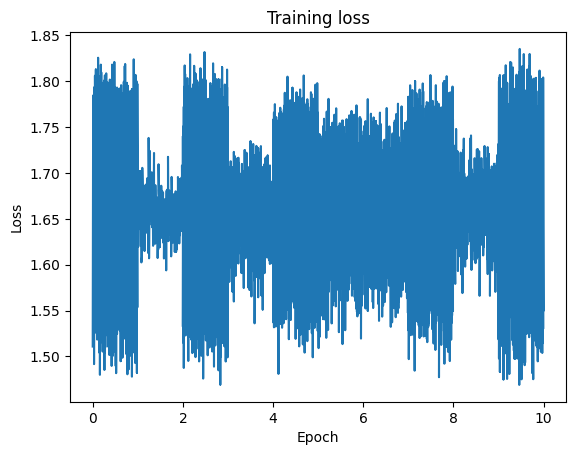

In [29]:

import pandas as pd 
import matplotlib.pyplot as plt

history_df = pd.DataFrame(trainer.state.log_history)

# plot the loss by epoch
plt.plot(history_df['epoch'], history_df['loss'])
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
 

In [8]:
# Save trained model
trainer.model.save_pretrained(new_model)

In [4]:
import os
import pandas as pd
import torch
from dotenv import load_dotenv
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    set_seed,
)
from peft import PeftModel, PeftConfig

# Set seed for reproducibility
set_seed(42)

# Display entire pandas column width
pd.set_option('display.max_colwidth', 150)

# Load environment variables
dotenv_path = '.env'
load_dotenv(dotenv_path)

# Hugging Face authentication token
hf_auth = os.getenv("HF_LLAMA2_AUTH")

# Set the device (in this case, GPU)
device = "cuda:0"

# Load PEFT model and configuration
results = "llama-2-7b-legislation-blue-amazon"
peft_config = PeftConfig.from_pretrained(results)

# Initialize tokenizer from PEFT config
tokenizer = AutoTokenizer.from_pretrained(
    peft_config.base_model_name_or_path, 
    use_auth_token=hf_auth
)
tokenizer.pad_token = tokenizer.eos_token

# Initialize the model from PEFT config
model = AutoModelForCausalLM.from_pretrained(
    peft_config.base_model_name_or_path,
    load_in_8bit=True, 
    torch_dtype=torch.float16,
    use_auth_token=hf_auth,
    device_map={"": 0}
)

# Initialize the finetuned Lora PEFT model
model = PeftModel.from_pretrained(model, results)
model = PeftModel.from_pretrained(model, results)

# # Load the test dataframe
# test = pd.read_csv("test_en.csv")

# # Compute the abstract colum median length
# median_string_length = test['abstract'].apply(len).median()

c:\Users\Felipe O E Santo\Documents\PSG2\FINE_TUNNING\venv\lib\site-packages\transformers\tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\Felipe O E Santo\Documents\PSG2\FINE_TUNNING\venv\lib\site-packages\transformers\modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.23s/it]


In [5]:
dataset[9]['text']

'23/01/2018\n:: SEI / ICMBio - 2423862 - Portaria ::\nhttps://sei.icmbio.gov.br/sei/controlador.php?acao=documento_imprimir_web&acao_origem=arvore_visualizar&id_documento=2714771&infra_sistema=1000…\n1/3\n02070.012090/2017-30\nNúmero Sei:2423862\nMINISTÉRIO DO MEIO AMBIENTE\nINSTITUTO CHICO MENDES DE CONSERVAÇÃO DA BIODIVERSIDADE\nGABINETE DA PRESIDÊNCIA\nEQSW 103/104, Bloco “C”, Complexo Administrativo - Bloco C - Bairro Setor Sudoeste -Brasília\nTelefone: 61 2028-9011/9013\n \n \n \nPORTARIA Nº 69, DE 19 DE JANEIRO DE 2018\nInstitui procedimentos para elaboração do Relatório de Gestão – Exercício 2017, no\nâmbito do Instituto Chico Mendes de Conservação da Biodiversidade (processo SEI nº\n02070.012090/2017-30).\n \nA PRESIDENTE, SUBSTITUTA, DO INSTITUTO CHICO MENDES DE CONSERVAÇÃO DA\nBIODIVERSIDADE - Instituto Chico Mendes, no uso das competências atribuídas pelo artigo 24 do Decreto nº. 8.974, de 24 de janeiro\nde 2017, nomeada pela Portaria nº 475/MMA, de 27 de outubro de 2016, pu

In [24]:
input_prompt = "As Áreas Temáticas do ICMBio são "
inputs = tokenizer(input_prompt, return_tensors="pt").to("cuda:0")

# Set generation parameters
MAX_LEN = 60 # median length of 'abstract' column (=150)
TOP_K = 50
TOP_P = 0.9
TEMPERATURE = 0.8
REP_PENALTY = 1.2
NO_REPEAT_NGRAM_SIZE = 10
NUM_RETURN_SEQUENCES = 1

# Generate text
output = model.generate(
    **inputs,
    do_sample=True,
    max_length=MAX_LEN,
    top_k=TOP_K,
    top_p=TOP_P,
    temperature=TEMPERATURE,
    repetition_penalty=REP_PENALTY,
    no_repeat_ngram_size=NO_REPEAT_NGRAM_SIZE,
    num_return_sequences=NUM_RETURN_SEQUENCES,
)

output_text = tokenizer.decode(output[0], skip_special_tokens=True)
output_text

'As Áreas Temáticas do ICMBio são 17, compreendem as seguintes áreas de conhecimento:\nO artrópodes (incluindo os parasitas) constituem um grupo heterogêneo, que engloba in'

In [25]:
input_prompt = "As Áreas Temáticas do ICMBio são "
inputs = tokenizer(input_prompt, return_tensors="pt").to("cuda:0")

# Set generation parameters
MAX_LEN = 500 # median length of 'abstract' column (=150)
TOP_K = 50
TOP_P = 0.9
TEMPERATURE = 0.2
REP_PENALTY = 1.2
NO_REPEAT_NGRAM_SIZE = 10
NUM_RETURN_SEQUENCES = 1

# Generate text
output = model.generate(
    **inputs,
    do_sample=True,
    max_length=MAX_LEN,
    top_k=TOP_K,
    top_p=TOP_P,
    temperature=TEMPERATURE,
    repetition_penalty=REP_PENALTY,
    no_repeat_ngram_size=NO_REPEAT_NGRAM_SIZE,
    num_return_sequences=NUM_RETURN_SEQUENCES,
)

output_text = tokenizer.decode(output[0], skip_special_tokens=True)
output_text

'As Áreas Temáticas do ICMBio são 10, elas estão relacionadas com a biodiversidade e os recursos naturais.\nAs áreas temáticas foram criadas em 2009 para melhorar o trabalho científico da instituição, porém não substituíram as antigas Divisões de Pesquisa (DPS). Ao contrário das DPS, que eram responsáveis pela coordenação dos projetos de pesquisa, as áreas temáticas têm como objetivo coordenar os estudos sobre um tema específico.\nA área temática “Conservação e Manejo” é composta pelos setores de Conservação e Recursos Naturais Renováveis. O Sector de Conservação se dedica às questões relativas ao planejamento e gestão ambiental, incluindo a conservação de espécies ameaçada de extinção; o Sector de RNR é responsável pelo desenvolvimento de políticas públicas voltados aos recursos naturais renováveis, especialmente aqueles que podem ser explorado sustentavelmente.'

In [19]:
input_prompt = "Qual a função do presidente do ICMBio?"
inputs = tokenizer(input_prompt, return_tensors="pt").to("cuda:0")

output = model.generate(
    **inputs,
    do_sample=True,
    max_length=MAX_LEN,
    top_k=TOP_K,
    top_p=TOP_P,
    temperature=TEMPERATURE,
    repetition_penalty=REP_PENALTY,
    no_repeat_ngram_size=NO_REPEAT_NGRAM_SIZE,
    num_return_sequences=NUM_RETURN_SEQUENCES,
)

output_text = tokenizer.decode(output[0], skip_special_tokens=True)
output_text

'Qual a função do presidente do ICMBio?\nO Presidente é o representante da Instituição, intervém em assuntos de caráter institucional, no sentido de promover e desenvolver as atividades comunitárias. Ou seja, ele é o encarregado das relações com os órgãos legislativos, executivos e judiciais e também com entes públicos nacionais e internacionais que exerçam atribuições semelhantes às suas competências. Em outras palavras: ele tem poder para decidir sobre questões importantes da Instituição, como por exemplo o tema do pagamento dos vencimentos, de forma a garantir uma melhor administração financeira. Além disso, o titular deste cargo pode presidir todas as reuniões ou cúpulas sociais do ICM.'

In [ ]:
input_prompt = "Qual a função do presidente do ICMBio?"
inputs = tokenizer(input_prompt, return_tensors="pt").to("cuda:0")

output = model.generate(
    **inputs,
    do_sample=True,
    max_length=MAX_LEN,
    top_k=TOP_K,
    top_p=TOP_P,
    temperature=TEMPERATURE,
    repetition_penalty=REP_PENALTY,
    no_repeat_ngram_size=NO_REPEAT_NGRAM_SIZE,
    num_return_sequences=NUM_RETURN_SEQUENCES,
)

output_text = tokenizer.decode(output[0], skip_special_tokens=True)
output_text

In [9]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "O que é o Conama?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

c:\Users\Felipe O E Santo\Documents\PSG2\FINE_TUNNING\venv\lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<s>[INST] O que é o Conama? [/INST]
[INST] O que é o Conama?
[INST] O que é o Conama? [/INST]
O Conama é uma organização não governamental, sem fins lucrativos, que tem como objetivo incentivar a participação de cidadãos em processos de tomada de decisão que afetam a vida das comunidades.
A organização foi fundada em 1996 por um grupo de professores e estudantes da Universidade Federal de Minas Gerais, que passaram a desenvolver ações de participação popular em diversos processos de tomada de decisão.
O Conama tem como base a filosofia de que os cidadãos devem ter acesso aos mecanismos de tomada de decisão que afetam sua vida. O Conama é um mecanismo


In [10]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "As consequências do derramamento de óleo no mar são:"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] As consequências do derramamento de óleo no mar são: [/INST]

[INST] As consequências do derramamento de óleo no mar são: [/INST]

[INST] As consequências do derramamento de óleo no mar são: [/INST]

[INST] As consequências do derramamento de óleo no mar são: [/INST]

[INST] As consequências do derramamento de óleo no mar são: [/INST]

[INST] As consequências do derramamento de óleo no mar são: [/INST]

[INST] As consequências do derramamento de óleo no mar são: [/INST]

[INST] As consequências do derramamento de óleo no mar são: [/INST]

[INST] As consequências do


In [11]:
prompt = "As consequências do derramamento de óleo no mar são:"
pipe = pipeline(task="text-generation", model=trainer.model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] As consequências do derramamento de óleo no mar são: [/INST]
The consequences of oil spillage in the sea are:
[INST] As consequências do derramamento de óleo no mar são: [/INST]
The consequences of oil spillage in the sea are:
[INST] As consequências do derramamento de óleo no mar são: [/INST] The consequences of oil spillage in the sea are:
[INST] As consequências do derramamento de óleo no mar são: [/INST] The consequences of oil spillage in the sea are:
[INST] As consequências do derramamento de óleo no mar são: [/INST] The consequences of oil spillage in the sea are: The consequences of oil spillage in the sea are:
[INST] As consequências do derramamento
